In [7]:
from valurap import path_planning
from valurap import gcode
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import time
from IPython.display import display
import IPython


import imp
imp.reload(path_planning)
imp.reload(gcode)

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('valurp.path_planning').setLevel(logging.DEBUG)

lines = gcode.reader("test.gcode")
pg = gcode.path_gen(lines)
sg = gcode.gen_segments(pg)
todo = []

for i, s in enumerate(sg):
    #print(str(s)[:100])
    if isinstance(s, gcode.do_move):
        print(i, s)
        if i != 4:
            assert s.deltas.get("X", 0) == 0
            assert s.deltas.get("Y", 0) == 0
    if isinstance(s, gcode.do_segment):
        print("segment", i, len(s.path))
        if i > 135:
            break
        elif i >= 10 and i <= 225:
            todo.append(s)

seg = np.array(todo[0].path)

Do Home
do_home
Set current ['E0']
Set current ['E0']
Set current ['E0']
Set current ['E0']
1 do_move(deltas={'Z': 2.5, 'F': 6000.0, 'line': 20})
2 do_move(deltas={'E': 3.0, 'F': 200.0, 'line': 23})
3 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 27})
4 do_move(deltas={'X': -156.977, 'Y': 203.188, 'Z': -14.7, 'F': 3600.0, 'line': 31})
5 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 33})
segment 6 264
7 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 296})
segment 8 6
9 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 303})
segment 10 917
11 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 1221})
segment 12 11
13 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 1232})
segment 14 942
15 do_move(deltas={'X': 0.0, 'Y': 0.0, 'Z': 0.3, 'F': 600.0, 'line': 2176})
segment 16 986
17 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 3169})
segment 18 13
19 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 3182})
segment 20 947
21 do_move(deltas={'X': 0.0, 'Y': 0.0, 'Z': 0.30000000000000004, 'F': 600.0,

In [ ]:
a = 2
b = 5
c = 100
seg = [
    [0, 0, 0],
    [b, 0, 100],
    [b, 0.01, 300],
    [b, 0.02, 300],
    [b + 1, a, 300],
    [b + c, a, 200],
    [b + c, a, 0]
]

seg = np.array(seg)

In [ ]:
import numpy as np
import pandas as pd
import IPython

path, slowdowns = path_planning.make_path(seg)
IPython.display.display(path)
IPython.display.display(slowdowns)


In [ ]:
speeds = path_planning.gen_speeds(path, slowdowns)
speeds[0:1]

In [ ]:
# corner calculations

corner_errors_slowdowns, cc = path_planning.process_corner_errors(path, slowdowns)
cc
corner_errors_slowdowns[73:76]

In [ ]:
import IPython
new_slowdowns, cc = path_planning.process_corner_errors(path, corner_errors_slowdowns)
IPython.display.display(cc)
IPython.display.display(new_slowdowns)

In [ ]:
corner_space_slowdowns, cc = path_planning.process_corner_space(path, corner_errors_slowdowns)
speeds = path_planning.gen_speeds(path, corner_space_slowdowns)

IPython.display.display(cc)
IPython.display.display(corner_space_slowdowns)
IPython.display.display(speeds)

In [ ]:
plato_slowdowns = corner_space_slowdowns
for i in range(20):
    new_plato_slowdowns, stage_ok, cc, ac, dc, nc, sc = path_planning.process_plato(path, plato_slowdowns)
    plato_slowdowns = new_plato_slowdowns
    print("Result", i, len(sc[sc["slowdown"] < 0.999]))

    if stage_ok:
        break            

speeds = path_planning.gen_speeds(path, plato_slowdowns)

IPython.display.display(cc)
IPython.display.display(ac)
IPython.display.display(dc)
IPython.display.display(sc)
IPython.display.display(nc)
IPython.display.display(plato_slowdowns)
IPython.display.display(speeds)

plato2_slowdowns, stage_ok, cc1, ac1, dc1, nc1, sc1 = path_planning.process_plato(path, plato_slowdowns)
IPython.display.display(sc1)
IPython.display.display(nc1)
IPython.display.display(plato2_slowdowns)


In [8]:
######## All-in-One

t0 = time.time()
path, slowdowns = path_planning.make_path(seg)
corner_errors_slowdowns, cc = path_planning.process_corner_errors(path, slowdowns)
corner_space_slowdowns, cc = path_planning.process_corner_space(path, corner_errors_slowdowns)
plato_slowdowns = corner_space_slowdowns
for i in range(20):
    new_plato_slowdowns, stage_ok, cc, nc, sc = path_planning.process_plato(path, plato_slowdowns)
    plato_slowdowns = new_plato_slowdowns
    print("Result", i, len(sc[sc["slowdown"] < 0.999]))

    if stage_ok:
        break

final_slowdowns, stage_ok, cc1, nc1, sc1 = path_planning.process_plato(path, plato_slowdowns)
ce_slowdowns, ce1 = path_planning.process_corner_errors(path, plato_slowdowns)
cs_slowdowns, cs1 = path_planning.process_corner_space(path, plato_slowdowns)
speeds = path_planning.gen_speeds(path, plato_slowdowns)

assert stage_ok
t1 = time.time()
print("Planning time:", t1 - t0)


Result 0 807
Result 1 136
Result 2 50
Result 3 35
Result 4 16
Result 5 8
Result 6 8
Result 7 2
Result 8 0
Planning time: 13.526643991470337


In [17]:
print("---- path ----")
display(path.iloc[0])
print("---- ce1 ----")
display(ce1.iloc[0])
print("---- cs1 ----")
display(cs1.iloc[0])
print("---- nc1 ----")
display(nc1.iloc[0])
print("---- speeds ----")
display(speeds.iloc[0])
l = len(cs1)
print("---- cs1 ----")
display(cs1.iloc[l-10:])
print("---- path ----")
display(path.iloc[l-10:])

---- path ----


x           -49.443000
y           -38.129000
v           180.000000
e         -5461.423270
src_idx       1.000000
dx          -40.683000
dy          -40.682000
l            57.533743
de           -2.870370
px           -8.760000
py            2.553000
pe        -5458.552900
pv            0.000000
pdx           0.000000
pdy           0.000000
pl            0.000000
pde           0.000000
nx          -49.513000
ny          -38.199000
ne        -5461.423270
nv          180.000000
ndx          -0.070000
ndy          -0.070000
nde           0.000000
nl            0.098995
dt            0.319632
Name: 0.0, dtype: float64

---- ce1 ----


dvx               -127.280785
dvy               -127.277656
dtx                  0.127281
dty                  0.127278
dt                   0.127281
ax               -1000.000000
ay                -999.975420
mdx                 -2.025050
mdy                 -2.025000
mvx                -63.640392
mvy                -63.638828
md                   0.000000
error_slowdown       1.000000
Name: 0.0, dtype: float64

---- cs1 ----


dvx            -127.280785
dvy            -127.277656
dtx               0.127281
dty               0.127278
dt                0.127281
cdt               0.063640
in_l              0.000000
in_dx            -0.000000
in_dy            -0.000000
pl                0.000000
in_slowdown       1.000000
out_l            11.455271
out_dx           -8.100199
out_dy           -8.100000
l                57.533743
out_slowdown      1.000000
slowdown          1.000000
Name: 0.0, dtype: float64

---- nc1 ----


n_dvx           115.510273
n_dvy           115.507434
n_dtx             0.115510
n_dty             0.115507
n_dt              0.115510
n_ax           1000.000000
n_ay            999.975420
n_dx             -8.030927
n_dy             -8.030729
n_l              11.357306
n_avail_l        46.078471
n_k               4.057166
n_real_dt         0.468644
n_real_ax       246.477486
n_real_ay       246.471427
n_dvx_in          0.000000
n_dvy_in          0.000000
n_dvx_out       115.510273
n_dvy_out       115.507434
n_dtx_in          0.000000
n_dty_in          0.000000
n_dt_in           0.000000
n_ax_in           0.000000
n_ay_in           0.000000
n_dx_in           0.000000
n_dy_in           0.000000
n_l_in            0.000000
n_avail_in       23.039236
n_dtx_out         0.115510
n_dty_out         0.115507
n_dt_out          0.115510
n_ax_out       1000.000000
n_ay_out        999.975420
n_dx_out         -8.030927
n_dy_out         -8.030729
n_l_out          11.357306
n_avail_out      11.681930
N

---- speeds ----


path            180.000000
c_in              0.000000
c_out           180.000000
out              16.645813
plato_base       16.645813
plato_delta     163.354187
plato           180.000000
c_in_x            0.000000
c_in_y            0.000000
c_out_x        -127.280785
c_out_y        -127.277656
plato_x        -127.280785
plato_y        -127.277656
out_x           -11.770512
out_y           -11.770223
max_a          1414.196182
Name: 0.0, dtype: float64

---- cs1 ----


dvx           dvy           dtx           dty  \
t                                                                   
19.339667 -8.881784e-15  7.105427e-15  8.881784e-18  7.105427e-18   
19.340767  1.012883e+00  3.951786e+00  1.012883e-03  3.951786e-03   
19.346191 -7.134501e+00 -2.783800e+01  7.134501e-03  2.783800e-02   
19.408691 -1.470203e-03  1.470018e-03  1.470203e-06  1.470018e-06   
19.409791 -4.342739e-01 -3.235136e+00  4.342739e-04  3.235136e-03   
19.412108  1.099361e+01  2.723691e+01  1.099361e-02  2.723691e-02   
19.494163 -1.776357e-15  1.776357e-15  1.776357e-18  1.776357e-18   
19.495263  3.265840e+00  1.976783e-01  3.265840e-03  1.976783e-04   
19.497362 -2.748280e+01 -9.593586e+00  2.748280e-02  9.593586e-03   
19.596561  4.494183e-13 -4.511946e-13  4.494183e-16  4.511946e-16   

                     dt           cdt          in_l         in_dx  \
t                                                                   
19.339667  8.881784e-18  4.440892e-18  7.340506e-17  5.190521e-17   
19.340767  3.951786e-03  1.975893e-03  1.669589e-03  1.180578e-03   
19.346191  2.783800e-02  1.391900e-02  3.313985e-01 -4.072894e-02   
19.408691  1.470203e-06  7.351015e-07  1.215773e-05  8.595732e-06   
19.409791  3.235136e-03  1.617568e-03  1.671508e-03  1.181934e-03   
19.412108  2.723691e-02  1.361846e-02  3.264499e-01  9.200719e-02   
19.494163  1.776357e-18  8.881784e-19  1.468983e-17 -1.038728e-17   
19.495263  3.265840e-03  1.632920e-03  1.671595e-03 -1.181996e-03   
19.497362  2.748280e-02  1.374140e-02  3.280726e-01 -3.196564e-01   
19.596561  4.511946e-16  2.255973e-16  3.756231e-15  2.656056e-15   

                  in_dy        pl  in_slowdown         out_l        out_dx  \
t                                                                            
19.339667  5.190521e-17  3.667056          1.0  7.340506e-17 -5.190521e-17   
19.340767  1.180578e-03  0.098995          1.0  6.678356e-03  8.207712e-04   
19.346191 -3.288862e-01  1.952804          1.0  8.284963e-02 -5.857617e-02   
19.408691  8.597894e-06  5.625034          1.0  1.215773e-05 -8.596813e-06   
19.409791  1.181934e-03  0.098995          1.0  6.686031e-03 -1.884402e-03   
19.412108  3.132160e-01  0.833802          1.0  8.161249e-02  5.770874e-02   
19.494163 -1.038728e-17  7.385023          1.0  1.468983e-17  1.038728e-17   
19.495263 -1.181996e-03  0.098995          1.0  6.686380e-03  6.514851e-03   
19.497362 -7.383368e-02  0.755378          1.0  8.201815e-02 -5.799559e-02   
19.596561  2.656056e-15  8.927930          1.0  3.756231e-15 -2.656056e-15   

                 out_dy         l  out_slowdown  slowdown  
t                                                          
19.339667 -5.190521e-17  0.098995           1.0       1.0  
19.340767  6.627727e-03  1.952804           1.0       1.0  
19.346191 -5.859090e-02  5.625034           1.0       1.0  
19.408691 -8.596813e-06  0.098995           1.0       1.0  
19.409791 -6.414985e-03  0.833802           1.0       1.0  
19.412108  5.770874e-02  7.385023           1.0       1.0  
19.494163  1.038728e-17  0.098995           1.0       1.0  
19.495263  1.504789e-03  0.755378           1.0       1.0  
19.497362 -5.799559e-02  8.927930           1.0       1.0  
19.596561 -2.656056e-15  0.098995           1.0       1.0

---- path ----


x       y      v           e  src_idx     dx     dy         l  \
t                                                                               
19.339667 -34.385  13.131   90.0 -5591.62291      609 -0.070 -0.070  0.098995   
19.340767 -34.145  15.069  360.0 -5591.62291      610  0.240  1.938  1.952804   
19.346191 -38.122  11.091   90.0 -5591.90355      611 -3.977 -3.978  5.625034   
19.408691 -38.192  11.021   90.0 -5591.90355      612 -0.070 -0.070  0.098995   
19.409791 -38.427  10.221  360.0 -5591.90355      613 -0.235 -0.800  0.833802   
19.412108 -33.205  15.443   90.0 -5592.27199      614  5.222  5.222  7.385023   
19.494163 -33.135  15.513   90.0 -5592.27199      615  0.070  0.070  0.098995   
19.495263 -32.399  15.683  360.0 -5592.27199      616  0.736  0.170  0.755378   
19.497362 -38.712   9.370   90.0 -5592.71740      617 -6.313 -6.313  8.927930   
19.596561 -38.782   9.300   90.0 -5592.71740      618 -0.070 -0.070  0.098995   

                de      px  ...      pde      nx      ny          ne     nv  \
t                           ...                                               
19.339667  0.00000 -34.315  ... -0.18295 -34.145  15.069 -5591.62291  360.0   
19.340767  0.00000 -34.385  ...  0.00000 -38.122  11.091 -5591.90355   90.0   
19.346191 -0.28064 -34.145  ...  0.00000 -38.192  11.021 -5591.90355   90.0   
19.408691  0.00000 -38.122  ... -0.28064 -38.427  10.221 -5591.90355  360.0   
19.409791  0.00000 -38.192  ...  0.00000 -33.205  15.443 -5592.27199   90.0   
19.412108 -0.36844 -38.427  ...  0.00000 -33.135  15.513 -5592.27199   90.0   
19.494163  0.00000 -33.205  ... -0.36844 -32.399  15.683 -5592.27199  360.0   
19.495263  0.00000 -33.135  ...  0.00000 -38.712   9.370 -5592.71740   90.0   
19.497362 -0.44541 -32.399  ...  0.00000 -38.782   9.300 -5592.71740   90.0   
19.596561  0.00000 -38.712  ... -0.44541 -38.782   9.300 -5592.71740    0.0   

             ndx    ndy      nde        nl        dt  
t                                                     
19.339667  0.240  1.938  0.00000  1.952804  0.001100  
19.340767 -3.977 -3.978 -0.28064  5.625034  0.005424  
19.346191 -0.070 -0.070  0.00000  0.098995  0.062500  
19.408691 -0.235 -0.800  0.00000  0.833802  0.001100  
19.409791  5.222  5.222 -0.36844  7.385023  0.002316  
19.412108  0.070  0.070  0.00000  0.098995  0.082056  
19.494163  0.736  0.170  0.00000  0.755378  0.001100  
19.495263 -6.313 -6.313 -0.44541  8.927930  0.002098  
19.497362 -0.070 -0.070  0.00000  0.098995  0.099199  
19.596561  0.000  0.000  0.00000  0.000000  0.001100  

[10 rows x 26 columns]

DEBUG:matplotlib.pyplot:Loaded backend nbAgg version unknown.


<IPython.core.display.Javascript object>


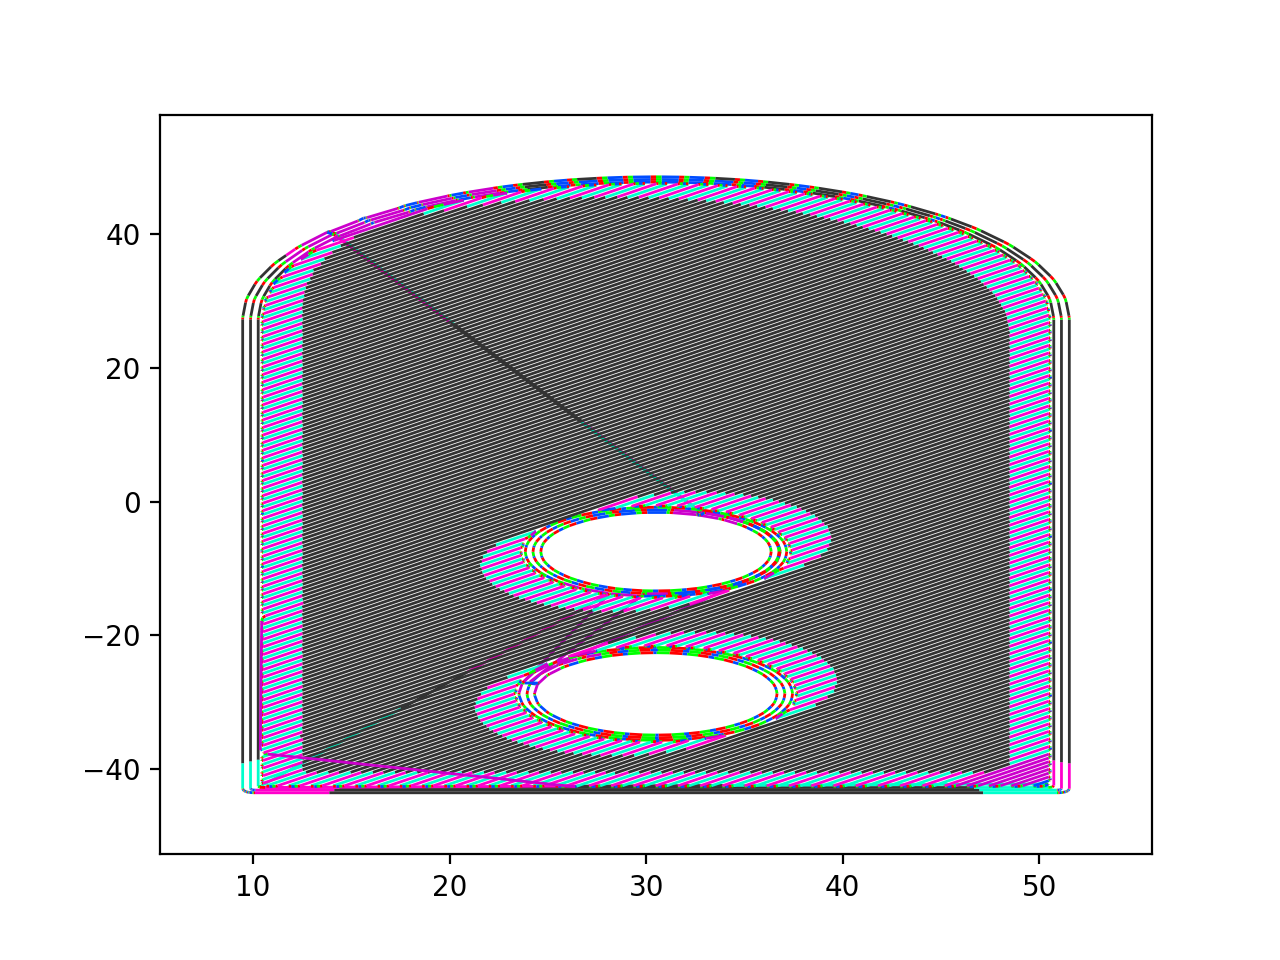

x       y
0  25.527 -24.410
1  26.712 -23.347
2  28.114 -22.597
3  29.657 -22.205
4  31.248 -22.194
5  32.795 -22.562
6  34.208 -23.291
7  35.408 -24.337
8  36.320 -25.640
9  36.896 -27.123

x0         y0        vx0        vy0          ax0          ay0  \
0  25.527000 -24.410000   0.000000   0.000000  1000.000000   897.046414   
1  25.772189 -24.190054  22.144501  19.864646   746.866530   669.973942   
2  26.503560 -23.533981  39.785059  35.689045   700.703621 -1000.000000   
3  26.721617 -23.360724  43.456157  30.449886   700.703621 -1000.000000   
4  26.958907 -23.214917  47.127254  25.210728   571.097289   305.508536   
5  27.719041 -22.808283  55.580561  29.732825   387.864591 -1000.000000   
6  28.123793 -22.622248  58.336752  22.626760   387.864591 -1000.000000   
7  28.548130 -22.486709  61.092943  15.520696   592.981854   150.647367   
8  29.113439 -22.343092  66.353468  16.857135   128.551729 -1000.000000   
9  29.661313 -22.238554  67.406551   8.665229   128.551729 -1000.000000   

          x1         y1        vx1        vy1          ax1          ay1  \
0  25.772189 -24.190054  22.144501  19.864646  1000.000000   897.046414   
1  26.503560 -23.533981  39.785059  35.689045   746.866530   669.973942   
2  26.721617 -23.360724  43.456157  30.449886   700.703621 -1000.000000   
3  26.958907 -23.214917  47.127254  25.210728   700.703621 -1000.000000   
4  27.719041 -22.808283  55.580561  29.732825   571.097289   305.508536   
5  28.123793 -22.622248  58.336752  22.626760   387.864591 -1000.000000   
6  28.548130 -22.486709  61.092943  15.520696   387.864591 -1000.000000   
7  29.113439 -22.343092  66.353468  16.857135   592.981854   150.647367   
8  29.661313 -22.238554  67.406551   8.665229   128.551729 -1000.000000   
9  30.217815 -22.201123  68.459635   0.473322   128.551729 -1000.000000   

         dt  src_idx  src_part      seg_type         t   src_de        de  
0  0.022145        1  0.206911         start  0.022145 -0.07942 -0.016433  
1  0.023619        1  0.617190  middle_plato  0.045764 -0.07942 -0.049017  
2  0.005239        1  0.175899           end  0.051003 -0.07942 -0.013970  
3  0.005239        2  0.176111         start  0.056242 -0.07932 -0.013969  
4  0.014802        2  0.542178  middle_plato  0.071044 -0.07932 -0.043006  
5  0.007106        2  0.281711           end  0.078150 -0.07932 -0.022345  
6  0.007106        3  0.281355         start  0.085256 -0.07943 -0.022348  
7  0.008871        3  0.366370   short_plato  0.094128 -0.07943 -0.029101  
8  0.008192        3  0.352276           end  0.102319 -0.07943 -0.027981  
9  0.008192        4  0.352492         start  0.110511 -0.07938 -0.027981

x       y
906  22.918  46.111
907  21.794  45.553
908  12.499  36.258
909  12.429  36.188
910  13.048  37.372
911  20.641  44.966
912  20.711  45.036
913  19.110  44.001
914  14.111  39.001
915  14.041  38.931

x0         y0        vx0        vy0          ax0          ay0  \
3237  15.131093  39.455367  63.635420  63.643801     0.000000     0.000000   
3238  18.684470  43.009212  63.635420  63.643801  -999.868317 -1000.000000   
3239  20.641000  44.966000  11.701718  11.702488  -989.928085  -989.928085   
3240  20.709817  45.034817   0.837393   0.837393 -1000.000000  -751.211002   
3241  20.710001  45.035250  -0.575833  -0.224238 -1000.000000  -751.211002   
3242  20.708189  45.034183  -1.989059  -1.285869  -963.947531  -623.164081   
3243  19.683239  44.371582 -44.496665 -28.765801  1000.000000   389.313921   
3244  19.192982  44.033306 -31.613933 -23.750374  1000.000000   389.313921   
3245  18.868691  43.759643 -18.731200 -18.734947    22.309762    22.314224   
3246  14.111000  39.001000 -11.772261 -11.773439   990.098029   990.098029   

             x1         y1        vx1        vy1          ax1          ay1  \
3237  18.684470  43.009212  63.635420  63.643801     0.000000     0.000000   
3238  20.641000  44.966000  11.701718  11.702488  -999.868317 -1000.000000   
3239  20.709817  45.034817   0.837393   0.837393  -989.928085  -989.928085   
3240  20.710001  45.035250  -0.575833  -0.224238 -1000.000000  -751.211002   
3241  20.708189  45.034183  -1.989059  -1.285869 -1000.000000  -751.211002   
3242  19.683239  44.371582 -44.496665 -28.765801  -963.947531  -623.164081   
3243  19.192982  44.033306 -31.613933 -23.750374  1000.000000   389.313921   
3244  18.868691  43.759643 -18.731200 -18.734947  1000.000000   389.313921   
3245  14.111000  39.001000 -11.772261 -11.773439    22.309762    22.314224   
3246  14.041000  38.931000   0.000000   0.000000   990.098029   990.098029   

            dt  src_idx  src_part         seg_type           t   src_de  \
3237  0.055840      911  0.467981  long_plato_main  135.629815 -0.53576   
3238  0.051941      911  0.257676   long_plato_out  135.681756 -0.53576   
3239  0.010976      912  0.983094      short_plato  135.692732  0.00000   
3240  0.001413      912  0.016906              end  135.694145  0.00000   
3241  0.001413      913  0.001756            start  135.695558  0.00000   
3242  0.044097      913  0.640194     middle_plato  135.739656  0.00000   
3243  0.012883      913  0.358050              end  135.752539  0.00000   
3244  0.012883      914  0.048271            start  135.765421 -0.35274   
3245  0.311950      914  0.951729     middle_plato  136.077372 -0.35274   
3246  0.011891      915  1.000000      short_plato  136.089263  0.00000   

            de  
3237 -0.250725  
3238 -0.138052  
3239  0.000000  
3240  0.000000  
3241  0.000000  
3242  0.000000  
3243  0.000000  
3244 -0.017027  
3245 -0.335713  
3246  0.000000

In [3]:
%matplotlib notebook

from matplotlib.collections import LineCollection
import warnings

warnings.simplefilter("error")

all_segments = path_planning.build_segments(path, plato_slowdowns)

lines = []
colors = []

i = 0
for index, row in all_segments.iterrows():
    i += 1
    lines.append(((row['x0'], row['y0']), (row['x1'], row['y1'])))
    st = row["seg_type"]
    if st == "start":
        colors.append((1,0,0,1))
    elif st == "end":
        colors.append((0,1,0,1))
    elif st == "short_plato":
        colors.append((0,0.3,1,1))
    elif st == "middle_plato":
        colors.append((0.8,0,0.8,1))
    elif st == "long_plato_main":
        colors.append((0.2,0.2,0.2,1))
    elif st == "long_plato_in":
        colors.append((1,0,0.8,1))
    elif st == "long_plato_out":
        colors.append((0,1,0.8,1))
    else:
        colors.append((1,1,0,1))
    
lc = LineCollection(lines, colors=colors, linewidths=1)
fig, ax = plt.subplots()

ax.add_collection(lc)

#path.iloc[limit:].plot(x="px", y="py", linewidth=3, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
full_path = pd.DataFrame()
full_path["x"] = path["px"]
full_path["y"] = path["py"]
last_x = path["x"].iloc[-1]
last_y = path["y"].iloc[-1]
full_path = full_path.append({"x": last_x, "y": last_y}, ignore_index=True)
full_path.plot(x="x", y="y", linewidth=5, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
    
ax.autoscale()
ax.margins(0.1)
display(full_path.iloc[:10])
display(all_segments.iloc[:10])

display(full_path.iloc[-10:])
display(all_segments.iloc[-10:])


In [4]:
all_segments["test_vx1"] = all_segments["vx0"] + all_segments["dt"] * all_segments["ax0"]
all_segments["test_vy1"] = all_segments["vy0"] + all_segments["dt"] * all_segments["ay0"]
all_segments["test_x1"] = all_segments["x0"] + all_segments["dt"] * all_segments["vx0"] + all_segments["dt"] * all_segments["dt"] * all_segments["ax0"]/2
all_segments["test_y1"] = all_segments["y0"] + all_segments["dt"] * all_segments["vy0"] + all_segments["dt"] * all_segments["dt"] * all_segments["ay0"]/2
print("bad vx1")
display(all_segments[abs(all_segments["test_vx1"] - all_segments["vx1"]) > 0.01])
print("bad vy1")
display(all_segments[abs(all_segments["test_vy1"] - all_segments["vy1"]) > 0.01])
print("bad x1")
display(all_segments[abs(all_segments["test_x1"] - all_segments["x1"]) > 0.0001])
print("bad y1")
display(all_segments[abs(all_segments["test_y1"] - all_segments["y1"]) > 0.0001])
print("ax non continuous")
display(all_segments[abs(all_segments["ax1"] - all_segments["ax0"]) > 0.001])
print("ay non continuous")
display(all_segments[abs(all_segments["ay1"] - all_segments["ay0"]) > 0.001])
print("vx non continuous")
display(all_segments[abs(all_segments["vx1"] - all_segments["vx0"].shift(-1)) > 0.001])
print("vy non continuous")
display(all_segments[abs(all_segments["vy1"] - all_segments["vy0"].shift(-1)) > 0.001])
print("x non continuous")
display(all_segments[abs(all_segments["x1"] - all_segments["x0"].shift(-1)) > 0.001])
print("y non continuous")
display(all_segments[abs(all_segments["y1"] - all_segments["y0"].shift(-1)) > 0.001])
print("src_part groups")
display(np.bincount(all_segments["src_idx"], weights=all_segments["src_part"]))
display(all_segments[np.isnan(all_segments["dt"])][["seg_type", "vx0", "vx1", "vy0", "vy1"]])


bad vx1


x0         y0        vx0        vy0         ax0         ay0  \
221    9.868000 -42.870000  -0.000072 -10.147490    0.000000  990.035530   
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
229    9.959876 -43.101063   7.111078  -1.862425 -204.457186   53.548311   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
221    9.868020 -42.920998   0.199844  -1.597110  ...       74  1.000000   
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
229   10.078003 -43.131979   1.573010  -0.202573  ...       78  0.937492   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
221    short_plato   3.520897 -0.00255 -0.002550  -0.000072  -1.424192   
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
229    short_plato   3.575201 -0.00650 -0.006094   1.505505  -0.394299   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plat

bad vy1


x0         y0        vx0        vy0         ax0         ay0  \
221    9.868000 -42.870000  -0.000072 -10.147490    0.000000  990.035530   
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
229    9.959876 -43.101063   7.111078  -1.862425 -204.457186   53.548311   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
221    9.868020 -42.920998   0.199844  -1.597110  ...       74  1.000000   
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
229   10.078003 -43.131979   1.573010  -0.202573  ...       78  0.937492   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
221    short_plato   3.520897 -0.00255 -0.002550  -0.000072  -1.424192   
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
229    short_plato   3.575201 -0.00650 -0.006094   1.505505  -0.394299   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plat

bad x1


x0         y0        vx0        vy0         ax0         ay0  \
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plato  80.291867  0.00000  0.000000  17.848361   9.158879   

        test_x1    test_y1  
222    9.889671 -43.018322  
225    9.933642 -43.086522  
226    9.943117 -43.095031  
230   10.130523 -43.133769  
239   51.087871 -43.065095  
240   51.099596 -43.053931  
241   51.134596 -42.945263  
1625  27.433416 -22.345581  
1626  26.287749 -23.079172  
1921  33.050542 -35.396458  
1922  33.826622 -35.002105  
2202  28.368487  -1.046513  
2203  27.767266  

bad y1


x0         y0        vx0        vy0         ax0         ay0  \
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plato  80.291867  0.00000  0.000000  17.848361   9.158879   

        test_x1    test_y1  
222    9.889671 -43.018322  
226    9.943117 -43.095031  
230   10.130523 -43.133769  
239   51.087871 -43.065095  
240   51.099596 -43.053931  
241   51.134596 -42.945263  
1625  27.433416 -22.345581  
1626  26.287749 -23.079172  
1921  33.050542 -35.396458  
1922  33.826622 -35.002105  
2202  28.368487  -1.046513  
2203  27.767266  -1.290392  
2482  33.182548 -13.768452  
2483  34.000642 -13.337358  

[14 rows x 23 columns]

ax non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

ay non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

vx non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

vy non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

x non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

y non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

src_part groups


array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Empty DataFrame
Columns: [seg_type, vx0, vx1, vy0, vy1]
Index: []

In [ ]:
sub_path = pd.DataFrame()
sub_path["src_idx"] = path["src_idx"]
sub_path["src_de"] = path["de"]
all_segments_extras = all_segments.merge(sub_path, on='src_idx')
all_segments_extras["de"] = all_segments_extras["src_de"] * all_segments_extras["src_part"]
all_segments_extras["de_v"] = all_segments_extras["de"] / all_segments_extras["dt"]
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, 'de_v' ] = 0
all_segments_extras["v0"] = np.linalg.norm(all_segments_extras[['vx0', 'vy0']].values, axis=1)
all_segments_extras["v1"] = np.linalg.norm(all_segments_extras[['vx1', 'vy1']].values, axis=1)
all_segments_extras["avg_v"] = (all_segments_extras["v0"] + all_segments_extras["v1"])/2
all_segments_extras["de_v0"] = all_segments_extras["de_v"] / all_segments_extras["avg_v"] * all_segments_extras["v0"]
all_segments_extras["de_v1"] = all_segments_extras["de_v"] / all_segments_extras["avg_v"] * all_segments_extras["v1"]
all_segments_extras["de_a"] = (all_segments_extras["de_v1"] - all_segments_extras["de_v0"])/ all_segments_extras["dt"]
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_v0"] = 0
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_v1"] = 0
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_a"] = 0

acc_step = 10000
v_step = 50000000
v_mult = v_step / acc_step
spm = 80

delta_e = all_segments_extras["de_v1"] - all_segments_extras["de_v0"].shift(-1)
all_segments_extras["delta_ve"] = delta_e
all_segments_extras["int_dt"] = (all_segments_extras["dt"] * acc_step).fillna(0).astype(int)
all_segments_extras["int_vx0"] = (all_segments_extras["vx0"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vy0"] = (all_segments_extras["vy0"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vx1"] = (all_segments_extras["vx1"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vy1"] = (all_segments_extras["vy1"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_ax"] = (np.around((all_segments_extras["int_vx1"] - all_segments_extras["int_vx0"]) / all_segments_extras["int_dt"])).replace([np.inf, -np.inf], np.nan).fillna(0).astype(int) 
all_segments_extras["int_ay"] = (np.around((all_segments_extras["int_vy1"] - all_segments_extras["int_vy0"]) / all_segments_extras["int_dt"])).replace([np.inf, -np.inf], np.nan).fillna(0).astype(int) 
#all_segments_extras["int_vx1_real1"] = (all_segments_extras["int_vx0"] + (all_segments_extras["int_ax"]-1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_vx1_real"] = (
    all_segments_extras["int_vx0"] + all_segments_extras["int_ax"] * all_segments_extras["int_dt"]
).fillna(0).astype(int)
#all_segments_extras["int_vx1_real3"] = (all_segments_extras["int_vx0"] + (all_segments_extras["int_ax"]+1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
#all_segments_extras["int_vy1_real1"] = (all_segments_extras["int_vy0"] + (all_segments_extras["int_ay"]-1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_vy1_real"] = (
    all_segments_extras["int_vy0"] + all_segments_extras["int_ay"] * all_segments_extras["int_dt"]
).fillna(0).astype(int)
#all_segments_extras["int_vy1_real3"] = (all_segments_extras["int_vy0"] + (all_segments_extras["int_ay"]+1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_dx"] = ((all_segments_extras["int_vx0"] + all_segments_extras["int_vx1_real"]) / 2 * all_segments_extras["int_dt"] * v_mult).fillna(0).astype(int)
all_segments_extras["int_dy"] = ((all_segments_extras["int_vy0"] + all_segments_extras["int_vy1_real"]) / 2 * all_segments_extras["int_dt"] * v_mult).fillna(0).astype(int)
all_segments_extras["real_dx"] = all_segments_extras["int_dx"] / spm / 2.0 ** 32
all_segments_extras["exp_dx"] = all_segments_extras["x1"] - all_segments_extras["x0"]
all_segments_extras["real_dy"] = all_segments_extras["int_dy"] / spm / 2.0 ** 32
all_segments_extras["exp_dy"] = all_segments_extras["y1"] - all_segments_extras["y0"]
all_segments_extras["error"] = np.linalg.norm([
    all_segments_extras["real_dx"] - all_segments_extras["exp_dx"],
    all_segments_extras["real_dy"] - all_segments_extras["exp_dy"],
], axis = 0)

#display(all_segments_extras[all_segments_extras["error"]>0.02])
display(all_segments_extras[np.logical_and(all_segments_extras["dt"] > -1e-27,all_segments_extras["dt"] < 1e-4)][["seg_type","dt", "vx0", "vx1", "vy0", "vy1", "exp_dx", "exp_dy"]])


In [ ]:
from valurap.asg import ProfileSegment
from numpy.linalg import norm

def format(all_segments, apgs=None, acc_step=1000):
    if apgs is None:
        apgs = {}

    apg_states = {}
    
    apg_x = apgs.get("X", path_planning.FakeApg("X"))
    apg_y = apgs.get("Y", path_planning.FakeApg("Y"))
    apg_z = apgs.get("Z", path_planning.FakeApg("Z"))

    v_step = 50000000
    v_mult = v_step / acc_step
    spm = 80
    spme = 837

    pr_opt = []
    first_row = all_segments.iloc[0]
    last_x = first_row["x0"]
    last_y = first_row["y0"]
    last_vx = first_row["vx0"]
    last_vy = first_row["vy0"]
    assert last_vx == 0
    assert last_vy == 0
    segs = [
        ProfileSegment(
            apg=apg_x, x = last_x * spm, v = 0, a = 0
        ),
        ProfileSegment(
            apg=apg_y, x = last_y * spm, v = 0, a = 0
        ),
    ]
    
    sub_profile = [[5, segs]]
    pr_opt += sub_profile
    
    path_planning.emulate(sub_profile, apg_states=apg_states, accel_step=50000000/acc_step)
    print(apg_states["X"], apg_states["Y"])
    
    for index, up_row in all_segments.iterrows():
        if 0:
            if index > 55:
                print("last_x:", last_x, "last_y:", last_y)
                print("last_vx:", last_vx, "last_vy:", last_vy)
                break

        print("index:", index, up_row["seg_type"])
        
        if up_row["dt"] < 0.2:
            rows = [up_row]
        else:
            splits = int(up_row["dt"] / 0.15)
            print("long segment, split up", splits)
            tx0 = up_row["x0"]
            ty0 = up_row["y0"]
            tx1 = up_row["x1"]
            ty1 = up_row["y1"]
            tvx0 = up_row["vx0"]
            tvy0 = up_row["vy0"]
            tvx1 = up_row["vx1"]
            tvy1 = up_row["vy1"]
            lx1 = tx0
            ly1 = ty0
            lvx1 = tvx0
            lvy1 = tvy0
            dvx = (tvx1 - tvx0)/splits
            dvy = (tvy1 - tvy0)/splits
            dt = up_row["dt"]/splits
            rows = []
            for i in range(splits):
                cvx1 = lvx1 + dvx
                cvy1 = lvy1 + dvy
                cx1 = lx1 + (lvx1 + dvx/2) * dt
                cy1 = ly1 + (lvy1 + dvy/2) * dt
                if i == splits - 1:
                    cvx1 = tvx1
                    cvy1 = tvy1
                    cx1 = tx1
                    cy1 = ty1
                rows.append(
                    {
                        "x0": lx1,
                        "y0": ly1,
                        "x1": cx1,
                        "y1": cy1,
                        "vx0": lvx1,
                        "vy0": lvy1,
                        "vx1": cvx1,
                        "vy1": cvy1,
                        "dt": dt,
                        "de": 0
                    }
                )
                lx1 = cx1
                ly1 = cy1
                lvx1 = cvx1
                lvy1 = cvy1
            
        for row in rows:
            next_x = row["x1"]
            next_y = row["y1"]
            next_vx = row["vx1"]
            next_vy = row["vy1"]
            de = row["de"]

            dx = next_x - last_x
            dy = next_y - last_y
            dvx = next_vx - last_vx
            dvy = next_vy - last_vy
            avg_vx = last_vx + 0.5 * dvx
            avg_vy = last_vy + 0.5 * dvy

            print("x:", last_x, row["x0"])
            print("y:", last_y, row["y0"])
            print("vx:", last_vx, row["vx0"])
            print("vy:", last_vy, row["vy0"])
            print("dx:", dx)
            print("dy:", dy)
            print("dvx:", dvx)
            print("dvy:", dvy)

            dt = row["dt"]
            int_dt = np.around(dt * acc_step)

            if int_dt == 0:
                int_dt = 1

            print("int_dt:", int_dt)

            int_vx0 = np.around(last_vx * 2 ** 32 * spm / v_step)
            int_vy0 = np.around(last_vy * 2 ** 32 * spm / v_step)
            int_vx1 = np.around(next_vx * 2 ** 32 * spm / v_step)
            int_vy1 = np.around(next_vy * 2 ** 32 * spm / v_step)
            int_ax = np.around((int_vx1 - int_vx0) / int_dt * 65536)
            int_ay = np.around((int_vy1 - int_vy0) / int_dt * 65536)
            print("int_vx1:", int_vx1, "int_vy1:", int_vy1)

            real_dx = path_planning.int_x(int_dt, int_vx0 * 65536, int_ax, 0, 0) / 65536 * v_mult
            real_dy = path_planning.int_x(int_dt, int_vy0 * 65536, int_ay, 0, 0) / 65536 * v_mult
            x_error = dx * 2.0 ** 32 * spm - real_dx 

            int_jx = np.around(-12 * x_error / int_dt / int_dt / int_dt * 65536 / v_mult)
            int_ax = np.around(int_ax - int_jx * int_dt / 2)
            print("x_error:", x_error / 2.0 ** 32 / spm, "int_jx:", int_jx, "int_ax:", int_ax)

            y_error = dy * 2.0 ** 32 * spm - real_dy 
            int_jy = np.around(-12 * y_error / int_dt / int_dt / int_dt * 65536 / v_mult)
            int_ay = np.around(int_ay - int_jy * int_dt / 2)
            print("y_error:", y_error / 2.0 ** 32 / spm, "int_jy:", int_jy, "int_ay:", int_ay)

            segs = [
                    ProfileSegment(
                        apg=apg_x, a = int(int_ax), j = int(int_jx)
                    ),
                    ProfileSegment(
                        apg=apg_y, a = int(int_ay), j = int(int_jy)
                    ),
                ]

            sub_profile = [[int(int_dt), segs]]
            pr_opt += sub_profile

            res = path_planning.emulate(sub_profile, apg_states=apg_states, accel_step=50000000/acc_step)
            res["xv"] = res["X_v"] * 65536 / 2**32 / 80 * 50000000
            res["yv"] = res["Y_v"] * 65536 / 2**32 / 80 * 50000000

            print("ApgStates:", apg_states["X"].x / 2**32 / spm, apg_states["Y"].x / 2**32 / spm)
            print("        V:", apg_states["X"].v / 2**32 / spm * v_step, apg_states["Y"].v / 2**32 / spm * v_step)
            print("   max_xv:", res["xv"].max(), res["xv"].min())
            print("   max_yv:", res["yv"].max(), res["yv"].min())

            last_x = apg_states["X"].x / 2**32 / spm
            last_y = apg_states["Y"].x / 2**32 / spm
            last_vx = apg_states["X"].v / 2**32 / spm * v_step
            last_vy = apg_states["Y"].v / 2**32 / spm * v_step

            print("final x_error:", last_x - next_x)
            print("final y_error:", last_y - next_y)
            print("final vx_error:", last_vx - next_vx)
            print("final vy_error:", last_vy - next_vy)

            if 1:
                assert res["xv"].max() < 300
                assert res["xv"].min() > -300
                assert res["yv"].max() < 300
                assert res["yv"].min() > -300

                assert abs(last_x - next_x) < 0.1
                assert abs(last_y - next_y) < 0.1
                assert abs(last_vx - next_vx) < 5
                assert abs(last_vy - next_vy) < 5

            if 0:
                if abs(last_vx) < 0.001:
                    last_vx = 0
                if abs(last_vy) < 0.001:
                    last_vy = 0
        
    pr_opt += [
        [
            5,
            [
                ProfileSegment(apg=apg_x, v=0),
                ProfileSegment(apg=apg_y, v=0),
                ProfileSegment(apg=apg_z, v=0),
            ],
        ]
    ]

    return pr_opt


acc_step = 10000
pr_opt = format(all_segments, acc_step=acc_step)
display(pr_opt)
res = path_planning.emulate(pr_opt, accel_step=50000000/acc_step, verbose=0)



<ApgState x=8771010413199.36 v=0 a=0 j=0 jj=0> <ApgState x=-8387212135628.8 v=0 a=0 j=0 jj=0>
index: 0 start
x: 25.527 25.527
y: -24.41 -24.41
vx: 0.0 0.0
vy: 0.0 0.0
dx: 0.24518947197976715
dy: 0.2199463364679275
dvx: 22.144501438495595
dvy: 19.864645594194783
int_dt: 221.0
int_vx1: 152176.0 int_vy1: 136509.0
x_error: 0.0015997215959124844 int_jx: -8010.0 int_ax: 46011831.0
y_error: 0.0014349204021577577 int_jy: -7184.0 int_ay: 41274619.0
ApgStates: 25.77203291933797 -24.190211350298487
        V: 22.130407160148025 19.850267563015223
   max_xv: 22.03218173235655 0.0
   max_yv: 19.762228475883603 0.0
final x_error: -0.00015655264179770256
final y_error: -0.00015768676641414459
final vx_error: -0.014094278347570821
final vy_error: -0.014378031179560935
index: 1 middle_plato
x: 25.77203291933797 25.772189471979768
y: -24.190211350298487 -24.190053663532073
vx: 22.130407160148025 22.144501438495595
vy: 19.850267563015223 19.864645594194783
dx: 0.7315268513671072
dy: 0.6562307901799187
dv

   max_xv: 72.62191502377391 71.62278052419424
   max_yv: -8.263596100732684 -16.93901140242815
final x_error: -8.266925081201748e-05
final y_error: 2.2378873413941847e-05
final vx_error: -0.01884609174499019
final vy_error: 0.005119456255652466
index: 13 short_plato
x: 31.876657356622626 31.87674002587344
y: -22.34354215216823 -22.343564531041643
vx: 71.62510883063078 71.64395492237577
vy: -17.037527868524194 -17.042647324779846
dx: 0.335704368288571
dy: -0.07985999053850534
dvx: -0.9686224384006863
dvy: 0.22977932790310973
int_dt: 47.0
int_vx1: 485548.0 int_vy1: -115502.0
x_error: 0.0012940803575514082 int_jx: -673610.0 int_ax: 6548822.0
y_error: -0.0003120915281815684 int_jy: 162454.0 int_ay: -1615938.0
ApgStates: 32.21243385108933 -22.42341320562642
        V: 70.68825652822852 -16.812700778245926
   max_xv: 71.70237950049341 70.74253517203033
   max_yv: -16.825797501951456 -17.05644535832107
final x_error: 7.212617813223687e-05
final y_error: -1.1062919686111172e-05
final vx_error

vx: 34.48338247835636 34.495594339826525
vy: -64.57572453655303 -64.58370731654784
dx: 0.23853850244878316
dy: -0.5196347873447174
dvx: -7.782006228492449
dvy: -4.1710479956486495
int_dt: 78.0
int_vx1: 183490.0 int_vy1: -472424.0
x_error: -0.0004708988603816522 int_jx: 53627.0 int_ax: -47023943.0
y_error: 0.00011427384229634185 int_jy: -13014.0 int_ay: -23575254.0
ApgStates: 36.52807793172356 -26.17580120751169
        V: 26.69126843102276 -68.74019163660705
   max_xv: 34.48338247835636 26.786583475768563
   max_yv: -64.57572453655303 -68.68562195450068
final x_error: -3.841807002658015e-05
final y_error: 2.6130585343508983e-05
final vx_error: -0.01010781884115275
final vy_error: 0.006580895594623826
index: 25 short_plato
x: 36.52807793172356 36.528116349793585
y: -26.17580120751169 -26.175827338097033
vx: 26.69126843102276 26.701376249863912
vy: -68.74019163660705 -68.74677253220167
dx: 0.16936988234927242
dy: -0.4359958554570724
dvx: -1.9608265757425691
dvy: 5.067890818238126
int_dt:

x: 36.334520608068445 36.33455099886257
y: -31.756851343754683 -31.756794829053877
vx: -33.88631739653647 -33.87843255980501
vy: -65.76170562766492 -65.74709194058185
dx: -0.3001025667604864
dy: -0.5051670656489193
dvx: -7.922941240976812
dvy: 4.10124244109705
int_dt: 79.0
int_vx1: -287311.0 int_vy1: -423727.0
x_error: -0.0015012095316748741 int_jx: 164551.0 int_ax: -51666512.0
y_error: -0.0016447070421854448 int_jy: 180280.0 int_ay: 16259530.0
ApgStates: 36.03438446065225 -32.26205721331295
        V: -41.81812983006239 -61.67058018036186
   max_xv: -33.88631739653647 -41.73198249191046
   max_yv: -61.737955547869205 -65.76170562766492
final x_error: -3.35806557103524e-05
final y_error: -3.880390934796196e-05
final vx_error: -0.008871192549108287
final vy_error: -0.010116993793985785
index: 37 short_plato
x: 36.03438446065225 36.03441804130796
y: -32.26205721331295 -32.2620184094036
vx: -41.81812983006239 -41.80925863751328
vy: -61.67058018036186 -61.660463186567874
dx: -0.22767305969

ApgStates: 30.64108341117203 -35.299806799241345
        V: -76.57203241251409 -0.5192123353481293
   max_xv: -75.37062629126012 -76.54292858205736
   max_yv: -0.6152549758553505 -9.680516086518764
final x_error: 0.00010405606296615133
final y_error: 4.689472081764734e-05
final vx_error: 0.022848294747376485
final vy_error: 0.01035629304881902
index: 49 short_plato
x: 30.64108341117203 30.640979355109064
y: -35.299806799241345 -35.29985369396216
vx: -76.57203241251409 -76.59488070726147
vy: -0.5192123353481293 -0.5295686283969483
dx: -0.19223894950528475
dy: -0.0013752943612104218
dvx: 0.10345204471759928
dvy: -0.009483066314617816
int_dt: 25.0
int_vx1: -525488.0 int_vy1: -3633.0
x_error: -0.0009330254253860915 int_jx: 3227115.0 int_ax: -38475094.0
y_error: -6.59130023166199e-05 int_jy: 227978.0 int_ay: -3020119.0
ApgStates: 30.448740677673367 -35.30118751406204
        V: -76.55631634406745 -0.5331821739673615
   max_xv: -76.57203241251409 -77.12340448051691
   max_yv: -0.519212335348

final y_error: 0.00011211505758268459
final vx_error: -0.01718835303783095
final vy_error: 0.031368799979219375
index: 61 short_plato
x: 25.257915631516834 25.25797609909873
y: -32.68565856161528 -32.68577067667286
vx: -46.09813913702965 -46.08095078399182
vy: 65.86851668544114 65.83714788546192
dx: -0.2482996104554367
dy: 0.3547268999453195
dvx: 3.8083267072399423
dvy: -5.447874584546483
int_dt: 56.0
int_vx1: -290613.0 int_vy1: 415207.0
x_error: -0.0006230809111649194 int_jx: 191744.0 int_ax: 25258715.0
y_error: 0.0008450582171874998 int_jy: -260054.0 int_ay: -36531645.0
ApgStates: 25.00959523080196 -32.33089980677702
        V: -42.29746991768479 60.4326487518847
   max_xv: -42.37706889398396 -46.09813913702965
   max_yv: 65.86851668544114 60.545571614056826
final x_error: -2.0790259437575287e-05
final y_error: 3.185489293855426e-05
final vx_error: -0.007657487895087911
final vy_error: 0.012006650990045387
index: 62 end
x: 25.00959523080196 25.009616021061397
y: -32.33089980677702 -3

vy: 56.184944696724415 56.19938002587387
dx: 0.3227389102433591
dy: 0.8686155733917609
dvx: -4.37069159792479
dvy: -11.758440657356552
int_dt: 173.0
int_vx1: 113437.0 int_vy1: 305297.0
x_error: -0.000861429246167944 int_jx: 8991.0 int_ax: -12155604.0
y_error: -0.0022618664320752657 int_jy: 23609.0 int_ay: -32652036.0
ApgStates: 24.550591328295877 -25.951297096991915
        V: 16.492995200678706 44.409389374777675
   max_xv: 20.87792381644249 16.51656930334866
   max_yv: 56.184944696724415 44.47298124432564
final x_error: -0.00012312425344873645
final y_error: -0.0001477265064373512
final vx_error: -0.014237017838993893
final vy_error: -0.01711466459018851
index: 74 end
x: 24.550591328295877 24.550714452549325
y: -25.951297096991915 -25.951149370485478
vx: 16.492995200678706 16.5072322185177
vy: 44.409389374777675 44.42650403936786
dx: 0.09613668945161535
dy: 0.217738551539167
dvx: 5.059634474430453
dvy: -2.5826985351331047
int_dt: 50.0
int_vx1: 148109.0 int_vy1: 287431.0
x_error: 0.00

   max_yv: 34.46693881414831 20.346633391454816
final x_error: -0.00811858200008686
final y_error: -0.008470757311094701
final vx_error: -0.10675488141425404
final vy_error: -0.10903298973057218
x: 30.296060906255615 30.304179488255702
y: -18.092961270678792 -18.084490513367697
vx: 26.697962312027812 26.804717193442066
vy: 34.47566996328533 34.5847029530159
dx: 4.905702803957386
dy: 6.327563560320071
dvx: 11.021140387019884
dvy: 14.19128492702852
int_dt: 1518.0
int_vx1: 259204.0 int_vy1: 334437.0
x_error: 0.016995281801408878 int_jx: -263.0 int_ax: 3469380.0
y_error: 0.01774529555889117 int_jy: -274.0 int_ay: 4418244.0
ApgStates: 35.1931481220508 -11.773555104820991
        V: 37.60782419703901 48.560032155364745
   max_xv: 37.60113031603396 26.697962312027812
   max_yv: 48.55115548707545 34.47566996328533
final x_error: -0.008615588162200538
final y_error: -0.008157394462269707
final vx_error: -0.1112785020086875
final vy_error: -0.10692273494910154
index: 83 end
x: 35.1931481220508 3

   max_xv: -6.693007890135049 -12.970995157957077
   max_yv: 54.361007642000914 52.76131560094655
final x_error: 8.303782323082487e-06
final y_error: -9.93094359031943e-05
final vx_error: 0.0026534302970482315
final vy_error: -0.03162130069148361
index: 96 start
x: 36.63475493725669 36.634746633474364
y: -5.97911366095301 -5.979014351517106
vx: -13.06863850913942 -13.071291939436469
vy: 52.7643715031445 52.795992803835986
dx: -0.10345377723721327
dy: 0.33110452653705824
dvx: -6.367143437459992
dvy: -1.5441063731559197
int_dt: 64.0
int_vx1: -133562.0 int_vy1: 351983.0
x_error: 0.0002421593220205409 int_jx: -49923.0 int_ax: -43207584.0
y_error: -0.0017235243496882546 int_jy: 355319.0 int_ay: -22235872.0
ApgStates: 36.53132628300041 -5.648103384384887
        V: -19.427825463935733 51.19029083289205
   max_xv: -13.06863850913942 -19.32494342327118
   max_yv: 52.7643715031445 51.18999979458749
final x_error: 2.5122980936487238e-05
final y_error: -9.424996893603321e-05
final vx_error: 0.007

dx: -0.022493513691003386
dy: -0.05970531238759591
dvx: -0.6383251889839263
dvy: -1.6598412129342623
int_dt: 110.0
int_vx1: -16250.0 int_vy1: -43177.0
x_error: -2.504349440179965e-05 int_jx: 1017.0 int_ax: -2669630.0
y_error: 0.0001967293226510236 int_jy: -7988.0 int_ay: -6356147.0
ApgStates: 32.73135411494691 -1.584179759458641
        V: -2.3575557861477137 -6.274203769862653
   max_xv: -1.7262937035411596 -2.3518805392086506
   max_yv: -4.6232889872044325 -6.258196663111449
final x_error: 4.225135198510088e-05
final y_error: 4.8717274840015534e-05
final vx_error: 0.007063106377372286
final vy_error: 0.008926430276042119
index: 110 end
x: 32.73135411494691 32.731311863594925
y: -1.584179759458641 -1.584228476733481
vx: -2.3575557861477137 -2.364618892525086
vy: -6.274203769862653 -6.283130200138695
dx: -0.0027915490710626045
dy: -0.013666070180457623
dvx: 2.6622311358696846
dvy: 2.3543726852579816
int_dt: 27.0
int_vx1: 2094.0 int_vy1: -26937.0
x_error: 0.00011289680474391162 int_jx: 

dvx: -8.011328969714253
dvy: -4.211133905754934
int_dt: 80.0
int_vx1: 182455.0 int_vy1: -480464.0
x_error: 8.321663291610548e-05 int_jx: -8784.0 int_ax: -44748058.0
y_error: -0.0011783712912194488 int_jy: 124381.0 int_ay: -28682069.0
ApgStates: 36.28978035179712 -5.121395328398796
        V: 26.54560375958681 -69.92195267230272
   max_xv: 34.56196282058954 26.64659405127168
   max_yv: -65.70553523488343 -69.88018867559731
final x_error: -2.0344802507565873e-05
final y_error: -2.0160686444725684e-05
final vx_error: -0.005030091288478644
final vy_error: -0.005283531664360908
index: 121 short_plato
x: 36.28978035179712 36.28980069659963
y: -5.121395328398796 -5.121375167712351
vx: 26.54560375958681 26.55063385087529
vy: -69.92195267230272 -69.91666914063836
dx: 0.1097830933473034
dy: -0.28902174381485324
dvx: -0.8137955711693934
dvy: 2.161524442803426
int_dt: 42.0
int_vx1: 176828.0 int_vy1: -465646.0
x_error: -4.0269143465110346e-05 int_jx: 29374.0 int_ax: -9342504.0
y_error: 0.0002192972

dx: -0.4025747960841599
dy: -0.40367294450682323
dvx: -7.1944031438010185
dvy: 6.319797691483913
int_dt: 72.0
int_vx1: -409888.0 int_vy1: -364425.0
x_error: 0.0006205908575083185 int_jx: -89856.0 int_ax: -41766571.0
y_error: 0.0012160304566677382 int_jy: -176071.0 int_ay: 45868597.0
ApgStates: 34.79673515015561 -12.05273402048275
        V: -59.63418516330422 -53.011463023722165
   max_xv: -52.45208740234376 -59.527374105528
   max_yv: -53.085677791386836 -59.35056833550334
final x_error: 4.348598312020613e-05
final y_error: 6.828513853918139e-05
final vx_error: 0.01230538284055882
final vy_error: 0.019307620297261963
index: 136 short_plato
x: 34.79673515015561 34.79669166417249
y: -12.05273402048275 -12.05280230562129
vx: -59.63418516330422 -59.646490546144776
vy: -53.011463023722165 -53.03077064401943
dx: -0.2635770309088272
dy: -0.23437187701791018
dvx: 1.8241384769917346
dvy: 1.6134461635325152
int_dt: 45.0
int_vx1: -397268.0 int_vy1: -353204.0
x_error: 0.0007638206390900848 int_jx

        V: -58.23036190122366 40.068989619612694
   max_xv: -58.26106644235551 -63.14177880994975
   max_yv: 39.953156374394894 33.04390702396631
final x_error: 0.00015372773086497205
final y_error: -7.80154717272552e-05
final vx_error: 0.04408983488732332
final vy_error: -0.022294017693390344
index: 153 start
x: 26.94526058097649 26.945106853245626
y: -12.669212448610926 -12.669134433139199
vx: -58.23036190122366 -58.27445173611098
vy: 40.068989619612694 40.091283637306084
dx: -0.3940000836343138
dy: 0.30766853604405675
dvx: 4.807520867377413
dvy: 7.074324485693722
int_dt: 71.0
int_vx1: -367119.0 int_vy1: 323966.0
x_error: 0.002609179006531903 int_jx: -393976.0 int_ax: 44480695.0
y_error: -0.0015812284349348005 int_jy: 238759.0 int_ay: 36396832.0
ApgStates: 26.551387980578465 -12.361626913854854
        V: -53.38588380254805 47.11939254775643
   max_xv: -53.423427743837244 -58.23036190122366
   max_yv: 47.00152203440666 40.068989619612694
final x_error: 0.00012748323628741787
final y_

ApgStates: 24.30651550297439 -6.59578039086424
        V: 8.437637006863952 71.09672878868878
   max_xv: 8.85047484189272 8.469942258670926
   max_yv: 74.54655133187771 71.36506610549986
final x_error: 3.270626932661003e-05
final y_error: 0.0002975005813734555
final vx_error: 0.020059527155751766
final vy_error: 0.182165440085015
index: 167 end
x: 24.30651550297439 24.306482796705062
y: -6.59578039086424 -6.5960778914456135
vx: 8.437637006863952 8.4175774797082
vy: 71.09672878868878 70.91456334860376
dx: 0.10557470312604522
dy: 0.5852233403033793
dvx: 8.357315491360964
dvy: -2.225060867816694
int_dt: 84.0
int_vx1: 115414.0 int_vy1: 473282.0
x_error: 1.5714148251078086e-05 int_jx: -1433.0 int_ax: 44867305.0
y_error: -0.002754877755958063 int_jy: 251192.0 int_ay: -22479957.0
ApgStates: 24.412067456285467 -6.010682585849429
        V: 16.789272194728255 68.84147296659648
   max_xv: 16.690028132870793 8.437637006863952
   max_yv: 71.09672878868878 68.84511094540358
final x_error: -2.274981

y_error: -0.0016357233748061084 int_jy: 307482.0 int_ay: -54638899.0
ApgStates: 27.29368535277713 -2.1165868693171093
        V: 58.36496711708605 30.713563319295645
   max_xv: 58.267905842512846 53.82578819990159
   max_yv: 37.261052057147026 30.790542950853702
final x_error: -0.00011040337425782809
final y_error: -8.827850311687868e-05
final vx_error: -0.03390745705529952
final vy_error: -0.027256902631581426
index: 178 short_plato
x: 27.29368535277713 27.293795756151386
y: -2.1165868693171093 -2.1164985908139924
vx: 58.36496711708605 58.39887457414135
vy: 30.713563319295645 30.740820221927226
dx: 0.636755535467671
dy: 0.3352144893002442
dvx: -7.809994950142958
dvy: -4.101726669335985
int_dt: 117.0
int_vx1: 347411.0 int_vy1: 182875.0
x_error: -0.0008165056985411923 int_jx: 27551.0 int_ax: -31674272.0
y_error: -0.00034406057830094205 int_jy: 11610.0 int_ay: -16467760.0
ApgStates: 27.930370235697364 -1.7814312177617126
        V: 50.542876124382026 26.601774152368304
   max_xv: 58.3649

vx: 2.112064976245165 2.1325063613857713
vy: 5.693727871403098 5.666374045968458
dx: 0.013433612652086424
dy: 0.035570083391766705
dvx: 1.5892964598940735
dvy: 4.141318230339262
int_dt: 46.0
int_vx1: 25436.0 int_vy1: 67586.0
x_error: 0.00014205333357963923 int_jx: -78871.0 int_ax: 17374559.0
y_error: 6.0943585000305944e-05 int_jy: -33837.0 int_ay: 41323665.0
ApgStates: 32.745209124403075 -1.5473099938500696
        V: 3.7021527532488108 9.833311196416616
   max_xv: 3.6715937312692404 2.112064976245165
   max_yv: 9.74498107098043 5.693727871403098
final x_error: 1.7923284687526575e-06
final y_error: -3.7619340305106164e-06
final vx_error: 0.0007913171095723648
final vy_error: -0.0017349053257440517
index: 191 end
x: 32.745209124403075 32.74520733207461
y: -1.5473099938500696 -1.547306231916039
vx: 3.7021527532488108 3.7013614361392384
vy: 9.833311196416616 9.83504610174236
dx: 0.006804678415640808
dy: 0.0390673013616234
dvx: -3.997339122724396
dvy: -0.11971615706628747
int_dt: 40.0
int_

vx: -11.76405930891633 -11.76685628938929
vy: -5.236361175775528 -5.241599619818838
dx: -0.02905360272617763
dy: -0.0181115804379246
dvx: 2.305044627681097
dvy: -2.7415366635819236
int_dt: 27.0
int_vx1: -65002.0 int_vy1: -54824.0
x_error: -0.0002871730019080587 int_jx: 788485.0 int_ax: 27803240.0
y_error: -0.00040935022023802503 int_jy: 1123944.0 int_ay: -60902808.0
ApgStates: 14.060129682764408 39.94321539174765
        V: -9.481009328737855 -8.009810699149966
   max_xv: -9.588402463123202 -11.76405930891633
   max_yv: -5.236361175775528 -7.939524948596954
final x_error: -2.7788677273932194e-05
final y_error: -4.09442792275172e-05
final vx_error: -0.02199464750262159
final vy_error: -0.03191285979251468
index: 203 start
x: 14.060129682764408 14.060157471441682
y: 39.94321539174765 39.94325633602688
vx: -9.481009328737855 -9.459014681235233
vy: -8.009810699149966 -7.977897839357452
dx: -0.02269742491189497
dy: -0.025532627347395476
dvx: 2.329836255656679
dvy: -2.7043853597461
int_dt: 2

x_error: 0.00012811736416473707 int_jx: -283893.0 int_ax: 49889954.0
y_error: -0.002536429866221823 int_jy: 5620434.0 int_ay: -79286148.0
ApgStates: 9.869011259286662 27.211532489662055
        V: 0.009313225746154785 -90.1789462659508
   max_xv: -0.0836735125631094 -2.948800101876259
   max_yv: -90.14227543957531 -91.47159289568663
final x_error: 1.50152926732261e-05
final y_error: -0.0002475115787063942
final vx_error: 0.010592616187556664
final vy_error: -0.17894627504435334
index: 219 long_plato_main
long segment, split up 4
x: 9.869011259286662 9.868996243993989
y: 27.211532489662055 27.21178000124076
vx: 0.009313225746154785 -0.0012793904414018786
vy: -90.1789462659508 -89.99999999090645
dx: -0.000249866122073783
dy: -16.520568933498147
dvx: -0.010592616187556664
dvy: 0.17894627504435334
int_dt: 1836.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: -0.0009850240486084516 int_jx: 9.0 int_ax: -10868.0
y_error: 0.01986333967955147 int_jy: -173.0 int_ay: 202719.0
ApgStates: 9.869041527270

ApgStates: 14.125171519697641 -43.13196543263272
        V: 89.9392762221396 0.0
   max_xv: 89.83959560282528 10.139483492821455
   max_yv: 0.0037834979593753815 0.0
final x_error: -0.002380066949243087
final y_error: -6.345077023439671e-05
final vx_error: -0.060723750819576594
final vy_error: -0.0022062067944489242
index: 232 long_plato_main
long segment, split up 2
x: 14.125171519697641 14.127551586646884
y: -43.13196543263272 -43.131901981862484
vx: 89.9392762221396 89.99999997295917
vy: 0.0 0.0022062067944489242
dx: 16.420025961807674
dy: 0.0004659032361544746
dvx: 0.060723750819576594
dvy: 0.0022062067944489242
int_dt: 1824.0
int_vx1: 618475.0 int_vy1: 15.0
x_error: 0.009570764245773944 int_jx: -85.0 int_ax: 92503.0
y_error: 0.00026692274540351946 int_jy: -2.0 int_ay: 2363.0
ApgStates: 30.53387268504407 -43.13196543263272
        V: 89.87859473563731 0.0
   max_xv: 89.9855513125658 89.87874025478959
   max_yv: 0.0 0.0
final x_error: -0.011324796461245512
final y_error: -0.00046590

index: 245 long_plato_main
long segment, split up 4
x: 51.13181794353109 51.13194366344474
y: -38.95811143048574 -38.956131855961466
vx: 0.0 -0.0012784817317846127
vy: 89.94611562229693 89.99999999091935
dx: -0.00010921857184342798
dy: 16.540709199128788
dvx: -0.0012784817317846127
dvy: 0.05388436862241974
int_dt: 1838.0
int_vx1: -9.0 int_vy1: 618475.0
x_error: 1.1110322338581113e-05 int_jx: -0.0 int_ax: -321.0
y_error: 0.0036676676853687694 int_jy: -32.0 int_ay: 42601.0
ApgStates: 51.13181794353109 -22.427874604556713
        V: 0.0 89.8724829312414
   max_xv: 0.0 0.0
   max_yv: 89.94611562229693 89.87262845039368
final x_error: 0.00010921857184342798
final y_error: -0.010472373199764462
final vx_error: 0.0012784817317846127
final vy_error: -0.127517059677956
x: 51.13181794353109 51.131708724959246
y: -22.427874604556713 -22.41740223135695
vx: 0.0 -0.0012784817317846127
vy: 89.8724829312414 89.99999999091935
dx: -0.0003441570573343711
dy: 16.549201997804282
dvx: -0.0012784817317846127

index: 269 long_plato_main
x: 44.43371411820222 44.43381642112134
y: 42.70196847027167 42.70190028393302
vx: -68.77497071400285 -68.67592641934056
vy: 58.234872994944446 58.16886736429825
dx: -1.2177080077748457
dy: 1.0314234895811794
dvx: 0.09904429466229203
dvy: -0.06600563064619536
int_dt: 177.0
int_vx1: -471937.0 int_vy1: 399733.0
x_error: -0.0012630933714206094 int_jx: 12310.0 int_ax: -837288.0
y_error: 0.0012476157269460941 int_jy: -12159.0 int_ay: 907974.0
ApgStates: 43.216096901449376 43.73329737972002
        V: -68.66539479233325 58.15818440169096
   max_xv: -68.6684506945312 -68.83434252813458
   max_yv: 58.30559530295432 58.16094926558435
final x_error: 9.079102200360012e-05
final y_error: -9.458013283136779e-05
final vx_error: 0.010531627007310362
final vy_error: -0.010682962607290847
index: 270 end
x: 43.216096901449376 43.21600611042737
y: 43.73329737972002 43.73339195985285
vx: -68.66539479233325 -68.67592641934056
vy: 58.15818440169096 58.16886736429825
dx: -0.16840446

int_dt: 28.0
int_vx1: -583917.0 int_vy1: 202847.0
x_error: 0.0027455341260207433 int_jx: -6759176.0 int_ax: 79096432.0
y_error: -0.0011517733424142307 int_jy: 2835528.0 int_ay: -84140162.0
ApgStates: 37.41395298333187 46.93305237559601
        V: -84.75908543914557 29.427901608869433
   max_xv: -82.88770914077759 -84.52960173599422
   max_yv: 32.281241146847606 29.44478183053434
final x_error: 0.00028254481001965814
final y_error: -0.00012034055891518847
final vx_error: 0.21208407804090257
final vy_error: -0.09026279094379674
index: 286 start
x: 37.41395298333187 37.41367043852185
y: 46.93305237559601 46.93317271615493
vx: -84.75908543914557 -84.97116951718647
vy: 29.427901608869433 29.51816439981323
dx: -0.23670090120122467
dy: 0.07796063568478218
dvx: -1.1732051198598867
dvy: -2.676426148950185
int_dt: 28.0
int_vx1: -590522.0 int_vy1: 183835.0
x_error: 0.0022083248380830867 int_jx: -5436631.0 int_ax: 57243147.0
y_error: -0.0008243646601897581 int_jy: 2029487.0 int_ay: -71460608.0
Apg

int_dt: 32.0
int_vx1: -618089.0 int_vy1: -21856.0
x_error: 0.0014400847181050835 int_jx: -2375085.0 int_ax: 36602576.0
y_error: -9.280217041407468e-05 int_jy: 153056.0 int_ay: -47056384.0
ApgStates: 30.214069435021838 48.120879639089104
        V: -89.85691238194704 -3.1833769753575325
   max_xv: -89.1755917109549 -89.84439773485065
   max_yv: -0.010913936421275139 -3.0895171221345663
final x_error: 0.00013324652851309793
final y_error: -4.950320132479646e-06
final vx_error: 0.08687333674083675
final vy_error: -0.002903647257013642
index: 302 short_plato
x: 30.214069435021838 30.213936188493324
y: 48.120879639089104 48.120884589409236
vx: -89.85691238194704 -89.94378571868788
vy: -3.1833769753575325 -3.180473328100519
dx: -0.8702235401614367
dy: -0.03076203318881454
dvx: -0.08687333674083675
dvy: 0.002903647257013642
int_dt: 97.0
int_vx1: -618089.0 int_vy1: -21856.0
x_error: 0.001805509178591791 int_jx: -106912.0 int_ax: 4781882.0
y_error: 0.00010275319655050907 int_jy: -6084.0 int_ay:

y: 46.653425275497135 46.6533862761534
vx: -82.39090675488114 -82.41616013672883
vy: -31.658855732530355 -31.672326002957764
dx: -0.22841788103241
dy: -0.09231913036155959
dvx: 1.1586855084913736
dvy: -2.8041171002544942
int_dt: 28.0
int_vx1: -558224.0 int_vy1: -236828.0
x_error: 0.0007125161451249085 int_jx: -1754129.0 int_ax: 43193436.0
y_error: 0.00011127364063767686 int_jy: -273942.0 int_ay: -41267623.0
ApgStates: 22.61872765142284 46.56112026531249
        V: -81.17567631416023 -34.452532418072224
   max_xv: -81.15981472656131 -82.39090675488114
   max_yv: -31.658855732530355 -34.34455720707774
final x_error: 7.567376732353637e-05
final y_error: 1.4120176913934301e-05
final vx_error: 0.056544932229542155
final vy_error: 0.010440414712626023
index: 319 start
x: 22.61872765142284 22.618651977655517
y: 46.56112026531249 46.561106145135575
vx: -81.17567631416023 -81.23222124638977
vy: -34.452532418072224 -34.46297283278485
dx: -0.22511413681285575
dy: -0.10008196092355348
dvx: 1.12739

x_error: 9.187244216057877e-05 int_jx: -723878.0 int_ax: -38346448.0
y_error: 0.00020443055103136487 int_jy: -1610742.0 int_ay: 58852446.0
ApgStates: 17.62313572747912 43.50012074972968
        V: -30.03646270371974 -26.33605618029833
   max_xv: -28.14529580064118 -29.92252120748162
   max_yv: -26.402412913739678 -28.208742151036862
final x_error: 1.442928859063386e-05
final y_error: 3.131046167936802e-05
final vx_error: 0.016797395885436828
final vy_error: 0.035415313903875756
index: 335 middle_plato
x: 17.62313572747912 17.62312129819053
y: 43.50012074972968 43.500089439268
vx: -30.03646270371974 -30.053260099605176
vy: -26.33605618029833 -26.371471494202204
dx: -1.6282768420206306
dy: -1.4288172611415604
dvx: 20.09125945061207
dvy: 17.609227768866806
int_dt: 814.0
int_vx1: -68343.0 int_vy1: -59970.0
x_error: -1.8014497475959956e-05 int_jx: 2.0 int_ax: 11115026.0
y_error: -0.0008792237717134554 int_jy: 88.0 int_ay: 9706827.0
ApgStates: 15.996734286307355 42.073986782259304
        V:

final x_error: -3.710328407180441e-06
final y_error: 8.433653341910485e-06
final vx_error: -0.001155561110213199
final vy_error: 0.002542319482524924
index: 351 end
x: 13.82500805833656 13.825011768664968
y: 40.282013664171096 40.282005230517754
vx: -12.437958503141997 -12.436802942031784
vy: -5.524925654754043 -5.5274679742365675
dx: -0.03247594396892772
dy: -0.020205858454282577
dvx: 2.4408141498156546
dvy: -2.898123188040099
int_dt: 29.0
int_vx1: -68700.0 int_vy1: -57883.0
x_error: 0.00017702589594925655 int_jx: -392269.0 int_ax: 43592566.0
y_error: -0.00012615084075306982 int_jy: 279536.0 int_ay: -49060685.0
ApgStates: 13.792553722158072 40.26179812898393
        V: -9.981886250898242 -8.430070010945201
   max_xv: -10.054354788735509 -12.437958503141997
   max_yv: -5.524925654754043 -8.338538464158773
final x_error: 2.160779043869354e-05
final y_error: -9.67673287988191e-06
final vx_error: 0.015258102428100884
final vy_error: -0.007021168151059243
index: 352 start
x: 13.79255372215

dx: -0.013173157113989475
dy: -0.26458656086853694
dvx: 2.925801523491033
dvy: -0.1173488841045156
int_dt: 29.0
int_vx1: -20226.0 int_vy1: -617813.0
x_error: -0.00024896093716719747 int_jx: 551669.0 int_ax: 37437586.0
y_error: -0.0040419838215974835 int_jy: 8956567.0 int_ay: -131691670.0
ApgStates: 9.47330628172308 27.48646215876564
        V: -2.958840923383832 -90.19000572152436
   max_xv: -3.0762748792767525 -5.869078449904919
   max_yv: -89.78633559308946 -92.08335541188717
final x_error: -2.139911762100155e-05
final y_error: -0.0003961611326133152
final vx_error: -0.01556399696994637
final vy_error: -0.28632124433038086
index: 368 start
x: 9.47330628172308 9.4733276808407
y: 27.48646215876564 27.486858319898253
vx: -2.958840923383832 -2.9432769264138856
vy: -90.19000572152436 -89.90368447719398
dx: -0.004310039599385362
dy: -0.2642421232743466
dvx: 2.957563602918449
dvy: 0.1900057305885241
int_dt: 29.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: 0.00013005529903153956 int_jx: -28818

        V: 13.46255885437131 -5.9806916397064915
   max_xv: 13.357930583879352 12.469827197492124
   max_yv: -6.030313670635223 -8.28920747153461
final x_error: -7.396616825161573e-05
final y_error: 5.9318850468059736e-05
final vx_error: -0.06827224513921237
final vy_error: 0.05467940644283775
index: 381 start
x: 9.786056538576258 9.78613050474451
y: -43.466406177696776 -43.466465496547244
vx: 13.46255885437131 13.530831099510522
vy: -5.9806916397064915 -6.035371046149329
dx: 0.03166839990147707
dy: -0.011113124468913327
dvx: 1.0725201713215835
dvy: 2.1967661082247263
int_dt: 23.0
int_vx1: 99884.0 int_vy1: -26003.0
x_error: -0.00047520923602561993 int_jx: 2110777.0 int_ax: -3273922.0
y_error: 0.00022603347457739176 int_jy: -1003992.0 int_ay: 54560319.0
ApgStates: 9.817664840955285 -43.47748971669004
        V: 14.479446690529587 -3.756576916202903
   max_xv: 14.383695088326931 13.45266355201602
   max_yv: -3.8287544157356024 -5.9806916397064915
final x_error: -6.009752245006439e-05
fin

y: -43.30313383435365 -43.303182472389395
vx: 10.955991456285119 10.941954189527355
vy: 16.581325326114893 16.54016330975036
dx: 0.03979861562827125
dy: 0.060137017533108406
dvx: -2.699509820221307
dvy: -4.100597271600048
int_dt: 41.0
int_vx1: 56738.0 int_vy1: 85767.0
x_error: 0.00027810218335844183 int_jx: -218069.0 int_ax: -25182228.0
y_error: 0.0003547520315905217 int_jy: -278173.0 int_ay: -39339866.0
ApgStates: 51.45049270707928 -43.24297739550472
        V: 8.263159543275833 12.490490917116404
   max_xv: 10.955991456285119 8.338538464158773
   max_yv: 16.581325326114893 12.602686183527112
final x_error: 1.3678206713052532e-05
final y_error: 1.9421315826662067e-05
final vx_error: 0.006677907212020884
final vy_error: 0.009762862601558453
index: 397 end
x: 51.45049270707928 51.450479028872564
y: -43.24297739550472 -43.24299681682054
vx: 8.263159543275833 8.256481636063812
vy: 12.490490917116404 12.480728054514845
dx: 0.015991311236675188
dy: 0.029099638691171492
dvx: -2.2498817249901

y_error: 0.0005475250597939407 int_jy: -3755.0 int_ay: 320930.0
ApgStates: 50.857358592327685 32.65946221471298
        V: -18.33919668570161 88.09467544779181
   max_xv: -18.339487724006176 -18.35986040532589
   max_yv: 88.15652108751237 88.0956940818578
final x_error: 0.00015775897940528694
final y_error: -0.00013685660321982596
final vx_error: 0.015435391271235943
final vy_error: -0.013822901226490103
index: 410 end
x: 50.857358592327685 50.85720083334828
y: 32.65946221471298 32.6595990713162
vx: -18.33919668570161 -18.354632076972845
vy: 88.09467544779181 88.1084983490183
dx: -0.12573419387427975
dy: 0.5146641268493468
dvx: -5.910450496696516
dvy: -1.639661729606459
int_dt: 59.0
int_vx1: -166642.0 int_vy1: 594114.0
x_error: -0.00039275624062717895 int_jx: 103349.0 int_ax: -48164222.0
y_error: -0.00033929993333181585 int_jy: 89283.0 int_ay: -15150114.0
ApgStates: 50.73161707899813 33.17409688132815
        V: -24.252221919596195 86.44477929919958
   max_xv: -18.33919668570161 -24.15

final vy_error: -0.11018590426238717
index: 426 start
x: 44.85392184345797 44.853829673408725
y: 42.865489462190304 42.86560324122415
vx: -66.58767233602703 -66.67692872676872
vy: 60.267484514042735 60.37767041830512
dx: -0.14824565253704236
dy: 0.12990851500219947
dvx: -2.071823633541655
dvy: -2.0792244162809226
int_dt: 22.0
int_vx1: -471824.0 int_vy1: 399867.0
x_error: 0.00042257059582162526 int_jx: -2144728.0 int_ax: -18818721.0
y_error: -0.0004968144031369803 int_jy: 2521548.0 int_ay: -70299681.0
ApgStates: 44.70573196362052 42.99533279662486
        V: -68.60544090159237 58.125151554122574
   max_xv: -66.58767233602703 -68.46370524726808
   max_yv: 60.267484514042735 58.163714129477746
final x_error: 5.577269959644582e-05
final y_error: -6.518056764548419e-05
final vx_error: 0.054055067976307214
final vy_error: -0.06310854363923823
index: 427 long_plato_main
x: 44.70573196362052 44.705676190920926
y: 42.99533279662486 42.9953979771925
vx: -68.60544090159237 -68.65949596956868
vy: 

dvy: -0.07027069325671675
int_dt: 65.0
int_vx1: -577324.0 int_vy1: 221829.0
x_error: 0.0037550252247555704 int_jx: -738948.0 int_ax: 25462643.0
y_error: -0.0013965766099204302 int_jy: 274831.0 int_ay: -9418990.0
ApgStates: 37.7701739437161 47.228398847426284
        V: -83.95363693125546 32.255775295197964
   max_xv: -83.21541827172041 -84.22051905654371
   max_yv: 32.350653782486916 31.979143386706713
final x_error: 0.00018468765117773955
final y_error: -7.818718916041689e-05
final vx_error: 0.05812931379227848
final vy_error: -0.02460779403223512
index: 443 end
x: 37.7701739437161 37.769989256064925
y: 47.228398847426284 47.228477034615445
vx: -83.95363693125546 -84.01176624504774
vy: 32.255775295197964 32.2803830892302
dx: -0.23450930228881361
dy: 0.085755575118597
dvx: -1.0211422368668934
dvy: -2.748685358564206
int_dt: 28.0
int_vx1: -583942.0 int_vy1: 202771.0
x_error: 0.0019393767963080677 int_jx: -4774513.0 int_ax: 50419392.0
y_error: -0.0008498354728700974 int_jy: 2092193.0 int

        V: -90.1050225365907 -0.00683940015733242
   max_xv: -89.9570295587182 -91.28591045737267
   max_yv: 3.1237141229212284 0.08963979780673981
final x_error: -0.000236538589934554
final y_error: -9.869643960769281e-06
final vx_error: -0.15945335492544643
final vy_error: -0.00683940015733242
index: 459 start
x: 30.499763461410065 30.5
y: 48.5260928380629 48.52610270770686
vx: -90.1050225365907 -89.94556918166525
vy: -0.00683940015733242 0.0
dx: -0.2812598224195746
dy: -0.004887422649176187
dvx: 0.15945335492544643
dvy: -3.1227907035886684
int_dt: 31.0
int_vx1: -618101.0 int_vy1: -21507.0
x_error: -0.002173486072473807 int_jx: 3942873.0 int_ax: -58797516.0
y_error: -0.0001819589467171312 int_jy: 330088.0 int_ay: -50484189.0
ApgStates: 30.218305381129493 48.52119173846207
        V: -90.0791201274842 -3.13884811475873
   max_xv: -90.1050225365907 -91.14315616898239
   max_yv: -0.00683940015733242 -3.048771759495139
final x_error: -0.00019825786099758602
final y_error: -1.367695165299

y: 47.22853829842992 47.228477034615445
vx: -83.86821718886495 -84.01176624504774
vy: -32.23423846065998 -32.2803830892302
dx: -0.5434799428324837
dy: -0.2088125386710118
dvx: -0.1435490561827919
dvy: -0.04614462857021806
int_dt: 65.0
int_vx1: -577324.0 int_vy1: -221829.0
x_error: 0.0021226110594270153 int_jx: -417707.0 int_ax: 12581346.0
y_error: 0.00085762593714378 int_jy: -168771.0 int_ay: 5165444.0
ApgStates: 22.686832753823136 47.0197797094332
        V: -83.97677447646856 -32.263342291116714
   max_xv: -83.43136869370937 -83.94548785872757
   max_yv: -32.05059329047799 -32.2509731631726
final x_error: 0.000110584194182195
final y_error: 5.394967429594999e-05
final vx_error: 0.034991768579175186
final vy_error: 0.017040798113484357
index: 476 end
x: 22.686832753823136 22.686722169628954
y: 47.0197797094332 47.019725759758906
vx: -83.97677447646856 -84.01176624504774
vy: -32.263342291116714 -32.2803830892302
dx: -0.23712041855600674
dy: -0.09581686309219606
dvx: 1.1702277585295064


x_error: 0.00043183257791667984 int_jx: -2917202.0 int_ax: -15556300.0
y_error: 0.000669815614514846 int_jy: -4524872.0 int_ay: 89495350.0
ApgStates: 17.394101911338975 43.83504725227598
        V: -29.144866857677698 -29.23348802141845
   max_xv: -27.224741643294692 -28.98726961575449
   max_yv: -29.24134605564177 -31.30044206045568
final x_error: 6.205942493409111e-05
final y_error: 9.541869251705748e-05
final vx_error: 0.0661439595476665
final vy_error: 0.10195708386781277
index: 492 start
x: 17.394101911338975 17.39403985191404
y: 43.83504725227598 43.83495183358346
vx: -29.144866857677698 -29.211010817225365
vy: -29.23348802141845 -29.33544510528626
dx: -0.05985924303423218
dy: -0.05622699726016123
dvx: -2.046117740161698
dvy: 1.8696180981605934
int_dt: 20.0
int_vx1: -214343.0 int_vy1: -188043.0
x_error: 0.00037432824980854207 int_jx: -2528737.0 int_ax: -20787715.0
y_error: 0.00046383023443752336 int_jy: -3133359.0 int_ay: 73433916.0
ApgStates: 17.334296479237263 43.77888656562194

   max_yv: -5.185429472476244 -6.862974260002375
final x_error: 1.618907231559774e-05
final y_error: 1.604452783965371e-06
final vx_error: 0.019416922487591748
final vy_error: 0.0017362507956280027
index: 508 short_plato
x: 13.780809220623222 13.780793031550907
y: 40.25354965232312 40.25354804787034
vx: -4.5701744966208935 -4.589591419108485
vy: -6.9617817644029865 -6.9635180151986145
dx: -0.012311969515026888
dy: -0.018657271331377956
dvx: 1.853592354387068
dvy: 2.8400709279105616
int_dt: 34.0
int_vx1: -18668.0 int_vy1: -28324.0
x_error: 0.00016814584256685805 int_jx: -231201.0 int_ax: 28483287.0
y_error: 0.0003266260720238279 int_jy: -449112.0 int_ay: 45254496.0
ApgStates: 13.768515588015315 40.23492379745934
        V: -2.7053465601056814 -4.102330422028899
   max_xv: -2.7517671696841717 -4.5701744966208935
   max_yv: -4.169996827840805 -6.9617817644029865
final x_error: 1.833690711983138e-05
final y_error: 3.141646759274863e-05
final vx_error: 0.011235582128144017
final vy_error: 0

ApgStates: 33.68227915256098 -2.5529239519638964
        V: 37.91181370615959 -19.826984498649836
   max_xv: 37.846475606784225 6.603804649785162
   max_yv: -3.448512870818377 -19.792787497863173
final x_error: -0.00074223103080584
final y_error: 0.0008207848882637592
final vx_error: -0.03328748721758501
final vy_error: 0.033258790508671865
index: 523 end
x: 33.68227915256098 33.683021383591786
y: -2.5529239519638964 -2.55374473685216
vx: 37.91181370615959 37.94510119337718
vy: -19.826984498649836 -19.860243289158507
dx: 0.155528252760746
dy: -0.09407506259328136
dvx: -2.886089470538721
dvy: -4.2756672001695435
int_dt: 42.0
int_vx1: 240695.0 int_vy1: -165632.0
x_error: 0.0022151018747873508 int_jx: -1615797.0 int_ax: 2984702.0
y_error: -0.0020366580748460983 int_jy: 1485632.0 int_ay: -77045385.0
ApgStates: 33.83795391185954 -2.6471324254199886
        V: 35.09776433929801 -24.168402887880806
   max_xv: 37.92127245105803 35.238335840404034
   max_yv: -19.826984498649836 -24.132605176419

y_error: -0.002504486337050693 int_jy: 813526.0 int_ay: -36581361.0
ApgStates: 35.91079385136068 -9.754660934060814
        V: -24.40443495288491 -64.71193046309054
   max_xv: -23.734901333227754 -24.436158128082756
   max_yv: -62.931067077443004 -64.79458534158766
final x_error: -3.98097714722212e-05
final y_error: -0.00012229455264112232
final vx_error: -0.014875550731130005
final vy_error: -0.04558870160346373
index: 541 end
x: 35.91079385136068 35.91083366113215
y: -9.754660934060814 -9.754538639508173
vx: -24.40443495288491 -24.38955940215378
vy: -64.71193046309054 -64.66634176148708
dx: -0.2082804274589094
dy: -0.464958031773433
dvx: -7.399512636871197
dvy: 3.9248121255397024
int_dt: 74.0
int_vx1: -218555.0 int_vy1: -417726.0
x_error: -0.0006794213934817606 int_jx: 90612.0 int_ax: -48385618.0
y_error: -0.0004152557477326013 int_jy: 55381.0 int_ay: 21837004.0
ApgStates: 35.7025055366084 -10.219615478501657
        V: -31.806121114641428 -60.78626029193401
   max_xv: -24.4044349528

final vy_error: -0.0036635083419600534
index: 557 start
x: 29.802011931895276 29.80185500302026
y: -13.325573150734419 -13.325559472476897
vx: -66.54561730101705 -66.58494193069342
vy: 7.908820407465099 7.9124839158070595
dx: -0.5326354909429405
dy: 0.09618829616527869
dvx: 0.9178601111467657
dvy: 8.058541225986374
int_dt: 81.0
int_vx1: -450991.0 int_vy1: 109727.0
x_error: 0.002712852057012327 int_jx: -275875.0 int_ax: 16275846.0
y_error: -0.00010738777348429096 int_jy: 10920.0 int_ay: 44363328.0
ApgStates: 29.269498694919047 -13.229412872544492
        V: -65.5971234664321 15.96039510332048
   max_xv: -65.4571340419352 -66.54561730101705
   max_yv: 15.859986888244748 7.908820407465099
final x_error: 0.0001222539667118383
final y_error: -2.8017975351346536e-05
final vx_error: 0.03063372343818571
final vy_error: -0.006966530130995352
index: 558 short_plato
x: 29.269498694919047 29.269376440952335
y: -13.229412872544492 -13.22938485456914
vx: -65.5971234664321 -65.62775718987028
vy: 15.9

dvy: 2.699918753043761
int_dt: 38.0
int_vx1: -59524.0 int_vy1: 485481.0
x_error: -0.00042607120861326564 int_jx: 419636.0 int_ax: -11996649.0
y_error: 0.0030689830120529393 int_jy: -3022628.0 int_ay: 89428746.0
ApgStates: 24.67469201132003 -8.11003486343194
        V: -8.676870493218303 70.77163900248706
   max_xv: -8.322385838255286 -8.714559953659773
   max_yv: 70.98235073499382 67.94682121835649
final x_error: -2.7752169597050624e-05
final y_error: 0.00022864109905640362
final vx_error: -0.015009391125904159
final vy_error: 0.12489903108681233
index: 574 end
x: 24.67469201132003 24.674719763489627
y: -8.11003486343194 -8.110263504530996
vx: -8.676870493218303 -8.661861102092399
vy: 70.77163900248706 70.64673997140025
dx: -0.03747476388358706
dy: 0.601112261960373
dvx: 8.525855111316325
dvy: -0.10671082019062794
int_dt: 85.0
int_vx1: -1038.0 int_vy1: 485606.0
x_error: 0.00047018475736848586 int_jx: -41376.0 int_ax: 46931288.0
y_error: 1.325999881451878e-06 int_jy: -117.0 int_ay: -560

        V: 50.76610250398516 19.30675352923572
   max_xv: 50.76537490822374 48.397778300568454
   max_yv: 25.44475137256086 19.419239833950996
final x_error: 0.00010290549235492108
final y_error: 2.2567493290548413e-05
final vx_error: 0.03454450577199708
final vy_error: 0.007783188743768932
index: 590 start
x: 28.406289662814697 28.40618675732234
y: -2.005869393553587 -2.0058919610468777
vx: 50.76610250398516 50.73155799821316
vy: 19.30675352923572 19.29897034049195
dx: 0.31892377769834823
dy: 0.09971359402856073
dvx: 2.3038051773366703
dvy: -6.154645973429863
int_dt: 61.0
int_vx1: 364694.0 int_vy1: 90381.0
x_error: 0.002338974727205567 int_jx: -556900.0 int_ax: 33994728.0
y_error: 0.0004061587534740507 int_jy: -96705.0 int_ay: -42489508.0
ApgStates: 28.72531212982535 -1.9061495277239033
        V: 53.102849051356316 13.1543492898345
   max_xv: 53.10168489813804 50.76610250398516
   max_yv: 19.30675352923572 13.261596905067561
final x_error: 9.868931230627709e-05
final y_error: 6.27180

y: -1.6654135561222234 -1.6654035720458173
vx: 8.893257472664118 8.899367735202294
vy: -5.212932592257857 -5.212141030771239
dx: 0.9232450806945067
dy: -0.5406988717259291
dvx: 26.890871339672557
dvy: -15.744952460116995
int_dt: 413.0
int_vx1: 245907.0 int_vy1: -144021.0
x_error: 0.0020005856125990817 int_jx: -1535.0 int_ax: 29640450.0
y_error: -0.001060193410072241 int_jy: 813.0 int_ay: -17337048.0
ApgStates: 33.97748612973187 -2.2055181198194647
        V: 35.75478331185877 -20.928127923980355
   max_xv: 35.69046384654939 8.893257472664118
   max_yv: -5.212932592257857 -20.890438463538885
final x_error: -0.0006005698292952388
final y_error: 0.0005943080286878732
final vx_error: -0.029345500477901965
final vy_error: 0.029757128394496846
index: 607 end
x: 33.97748612973187 33.97808669956117
y: -2.2055181198194647 -2.2061124278481525
vx: 35.75478331185877 35.784128812336675
vy: -20.928127923980355 -20.957885052374852
dx: 0.11271766221916124
dy: -0.07372821073932023
dvx: -2.3145442396707

x_error: -0.0003098731240065433 int_jx: 25431.0 int_ax: -46137766.0
y_error: 0.0005412924725654022 int_jy: -44424.0 int_ay: 12245701.0
ApgStates: 36.623307207481005 -8.997751023354942
        V: -17.4820888787508 -71.63704140111804
   max_xv: -8.786737453192472 -17.384591046720743
   max_yv: -71.65581337176263 -73.63996701315045
final x_error: 1.6142581451106253e-05
final y_error: 4.5993884535633356e-05
final vx_error: 0.0037303127668444347
final vy_error: 0.010557885892183094
index: 623 start
x: 36.623307207481005 36.623291064899554
y: -8.997751023354942 -8.997797017239478
vx: -17.4820888787508 -17.485819191517646
vy: -71.63704140111804 -71.64759928701022
dx: -0.18957798641969958
dy: -0.6130555730090759
dvx: -8.68807658643004
dvy: 2.108883801602502
int_dt: 87.0
int_vx1: -179840.0 int_vy1: -477794.0
x_error: -0.00012508892974949504 int_jx: 10266.0 int_ax: -45420839.0
y_error: 0.0011185742001362797 int_jy: -91801.0 int_ay: 14909984.0
ApgStates: 36.43375263549201 -9.610740411528388
     

   max_yv: -0.14260876923799515 -4.595785867422819
final x_error: -6.855785044024287e-05
final y_error: 1.9138294653942012e-05
final vx_error: -0.031371333217975916
final vy_error: 0.009019524248386777
index: 639 middle_plato
x: 31.10151286294963 31.10158142080007
y: -13.794231652366 -13.794250790660653
vx: -38.046418922021985 -38.01504758880401
vy: -0.04627509042620659 -0.055294614674593366
dx: -1.0611953009566477
dy: -0.0015627948165537475
dvx: 20.45420734003758
dvy: 0.020686419034243456
int_dt: 382.0
int_vx1: -120893.0 int_vy1: -176.0
x_error: 0.0025259249996789634 int_jx: -2449.0 int_ax: 24582262.0
y_error: -0.00018873749662873252 int_jy: 183.0 int_ay: -10591.0
ApgStates: 30.040863415922967 -13.79523813558277
        V: -17.563434084877372 0.0
   max_xv: -17.615966498851776 -38.046418922021985
   max_yv: 0.0 -0.04627509042620659
final x_error: 0.000545853929985185
final y_error: 0.0005563115997837542
final vx_error: 0.0287774971070327
final vy_error: 0.025588671391963132
index: 640

int_dt: 203.0
int_vx1: 227565.0 int_vy1: 335517.0
x_error: 0.0015508516176989673 int_jx: -10019.0 int_ax: 24727402.0
y_error: 0.0024448454666714525 int_jy: -15794.0 int_ay: 36590598.0
ApgStates: 25.652212944112716 -24.938528835275214
        V: 33.102696761488914 48.81294444203377
   max_xv: 33.052347134798765 22.427557269111276
   max_yv: 48.73887519352138 33.053511288017035
final x_error: -0.00012428449704415812
final y_error: -0.0001130447987840455
final vx_error: -0.01243582851655134
final vy_error: -0.01115450175261401
index: 652 end
x: 25.652212944112716 25.65233722860976
y: -24.938528835275214 -24.93841579047643
vx: 33.102696761488914 33.115132590005466
vy: 48.81294444203377 48.82409894378638
dx: 0.19334114871728403
dy: 0.25082358019766104
dvx: 5.407636071325271
dvy: -4.698681836385347
int_dt: 54.0
int_vx1: 264641.0 int_vy1: 303151.0
x_error: 0.000256347471593088 int_jx: -87981.0 int_ax: 47475178.0
y_error: -0.0003148498681948553 int_jy: 108060.0 int_ay: -42104507.0
ApgStates: 2

   max_xv: 69.59104212000966 66.7848507873714
   max_yv: -16.570411389693618 -24.633627617731687
final x_error: 4.4888637425799516e-05
final y_error: -1.0987009858354213e-05
final vx_error: 0.011398758548807564
final vy_error: -0.002786494362247538
index: 668 start
x: 32.642834843716585 32.64278995507916
y: -22.972963301083077 -22.97295231407322
vx: 66.73260941170156 66.72121065315275
vy: -24.725450202822685 -24.722663708460438
dx: 0.5293989669946768
dy: -0.23364402862792133
dvx: -3.019478192357468
dvy: -8.115380056432215
int_dt: 81.0
int_vx1: 437833.0 int_vy1: -225680.0
x_error: 0.0009429202484483312 int_jx: -95887.0 int_ax: -12905120.0
y_error: -0.0009066339754610908 int_jy: 92197.0 int_ay: -48855110.0
ApgStates: 33.17224479745887 -23.206616971958432
        V: 63.71585186570882 -32.84309059381485
   max_xv: 66.73260941170156 63.7615448795259
   max_yv: -24.725450202822685 -32.75112248957157
final x_error: 1.0986747611241299e-05
final y_error: -9.642247434271667e-06
final vx_error: 0

vx: -7.734488463029266 -7.738775035918918
vy: -68.79374268464744 -68.81485585832023
dx: -0.051438461659984114
dy: -0.45736104335144034
dvx: 0.7563421930713616
dvy: 6.742561781130149
int_dt: 70.0
int_vx1: -47953.0 int_vy1: -426412.0
x_error: 9.334813268679909e-05 int_jx: -14708.0 int_ax: 5381296.0
y_error: 0.00093308213681631 int_jy: -147017.0 int_ay: 48525746.0
ApgStates: 36.57957937160786 -29.730475203916434
        V: -6.971968105062843 -62.03452358022333
   max_xv: -6.981717888265848 -7.734488463029266
   max_yv: -62.11979780346155 -68.79374268464744
final x_error: 2.104453420770369e-05
final y_error: 5.7037374673996055e-05
final vx_error: 0.0061781648950614
final vy_error: 0.016657323293962634
index: 685 end
x: 36.57957937160786 36.579558327073656
y: -29.730475203916434 -29.730532241291108
vx: -6.971968105062843 -6.978146269957905
vy: -62.03452358022333 -62.05118090351729
dx: -0.0788746483429108
dy: -0.4520205814954501
dvx: -7.394720204437454
dvy: 1.7439646108579794
int_dt: 74.0
in

x_error: 0.001684097123739292 int_jx: -129104.0 int_ax: -469010.0
y_error: 0.0007407619309560687 int_jy: -56787.0 int_ay: 47293264.0
ApgStates: 31.28701836452633 -34.85562143215444
        V: -73.06560291908681 -9.403156582266092
   max_xv: -71.85706635937095 -73.03940947167575
   max_yv: -9.497161954641342 -18.261780496686697
final x_error: 8.45424381772375e-05
final y_error: 5.2317028881532224e-05
final vx_error: 0.019557223851194294
final vy_error: 0.011990204191969056
index: 701 start
x: 31.28701836452633 31.28693382208815
y: -34.85562143215444 -34.855673749183325
vx: -73.06560291908681 -73.08516014293801
vy: -9.403156582266092 -9.415146786458061
dx: -0.6533155667593533
dy: -0.04422546826360474
dvx: -1.1620518409265514
dvy: 8.856634358464335
int_dt: 89.0
int_vx1: -510089.0 int_vy1: -3756.0
x_error: 0.0020816090787150188 int_jx: -159577.0 int_ax: 1220610.0
y_error: 0.0004936440455836077 int_jy: -37843.0 int_ay: 46500328.0
ApgStates: 30.6338010070594 -34.89980250197929
        V: -74

final y_error: 9.506186311369902e-05
final vx_error: -0.006420251848638259
final vy_error: 0.032741413553715404
index: 717 short_plato
x: 24.910261631010098 24.910279902964255
y: -31.348404243555855 -31.34849930541897
vx: -20.640873117372394 -20.634452865523755
vy: 53.223775466904044 53.19103405335033
dx: -0.30703441884775984
dy: 0.7914185410929413
dvx: 2.3698592088404915
dvy: -6.125161836021626
int_dt: 158.0
int_vx1: -125557.0 int_vy1: 323659.0
x_error: 0.0004874669815162491 int_jx: -6679.0 int_ax: 7282826.0
y_error: -0.0014343534719358786 int_jy: 19653.0 int_ay: -19011709.0
ApgStates: 24.603326712383886 -30.55710547961295
        V: -18.25828803703189 47.083012759685516
   max_xv: -18.27225787565112 -20.640873117372394
   max_yv: 53.223775466904044 47.11851943284273
final x_error: 9.950022154825433e-05
final y_error: -0.00011977715003652634
final vx_error: 0.012725871500013142
final vy_error: -0.015600871196902233
index: 718 end
x: 24.603326712383886 24.603227212162338
y: -30.5571054

dy: 0.14409332829310273
dvx: 4.128494403962138
dvy: -2.0562477657718503
int_dt: 41.0
int_vx1: 119928.0 int_vy1: 232832.0
x_error: 0.0013741555678770112 int_jx: -1077520.0 int_ax: 67438474.0
y_error: 0.0008611258273987232 int_jy: -675237.0 int_ay: -8743584.0
ApgStates: 24.29342643357627 -25.55123817184009
        V: 17.49795046634972 33.90930942259729
   max_xv: 17.44396286085248 13.32329702563584
   max_yv: 35.937700886279345 33.98876287974417
final x_error: 9.149870207281197e-05
final y_error: 5.501902413840298e-05
final vx_error: 0.04615903675174238
final vy_error: 0.027856302089794838
index: 734 start
x: 24.29342643357627 24.293334934874196
y: -25.55123817184009 -25.55129319086423
vx: 17.49795046634972 17.45179142959798
vy: 33.90930942259729 33.881453120507494
dx: 0.07949692227419902
dy: 0.13398553417334114
dvx: 4.0367161448318
dvy: -2.130879624278716
int_dt: 41.0
int_vx1: 147985.0 int_vy1: 218380.0
x_error: -0.00031807729090971293 int_jx: 249415.0 int_ax: 39227692.0
y_error: -0.000

y_error: -0.00018380484550384324 int_jy: 11586.0 int_ay: -45492854.0
ApgStates: 32.02661039016489 -21.978662016419698
        V: 77.40396540611982 -18.42810888774693
   max_xv: 78.4859003033489 77.40411092527211
   max_yv: -8.95364792086184 -18.329592421650887
final x_error: -8.59559389283504e-05
final y_error: 2.758979549710716e-05
final vx_error: -0.018300581828000873
final vy_error: 0.005763966526409092
index: 750 short_plato
x: 32.02661039016489 32.02669634610382
y: -21.978662016419698 -21.978689606215195
vx: 77.40396540611982 77.42226598794782
vy: -18.42810888774693 -18.43387285427334
dx: 0.20130640821230372
dy: -0.047937221289156895
dvx: 0.3134523614399285
dvy: -0.07603819976734272
int_dt: 26.0
int_vx1: 534070.0 int_vy1: -127160.0
x_error: -0.0003357121944382868 int_jx: 1032258.0 int_ax: -7989948.0
y_error: 7.09949758928019e-05 int_jy: -218297.0 int_ay: 1519579.0
ApgStates: 32.22787787148077 -22.02658924398944
        V: 77.68583600409329 -18.496211851015687
   max_xv: 77.6464003

index: 766 end
x: 37.40596533519961 37.40599159437096
y: -28.038399877925407 -28.038553736095057
vx: 9.437499102205038 9.447007739138906
vy: -74.10853868350387 -74.15679314478959
dx: 0.044495549561659686
dy: -0.6598954612457639
dvx: -8.883085499619341
dvy: -0.11467808675104152
int_dt: 89.0
int_vx1: 3810.0 int_vy1: -510058.0
x_error: -0.0004126798188650582 int_jx: 31636.0 int_ax: -46358134.0
y_error: 0.00017507675888950303 int_jy: -13421.0 int_ay: 16984.0
ApgStates: 37.45041935529839 -28.69826044662856
        V: 0.5449692253023386 -74.21534974128008
   max_xv: 9.437499102205038 0.6417394615709782
   max_yv: -74.1082476451993 -74.21287591569126
final x_error: -4.152946287661052e-05
final y_error: 3.4892542611686395e-05
final vx_error: -0.00944437728335945
final vy_error: 0.007867028974828827
index: 767 start
x: 37.45041935529839 37.45046088476127
y: -28.69826044662856 -28.69829533917117
vx: 0.5449692253023386 0.554413602585698
vy: -74.21534974128008 -74.22321677025491
dx: -0.03456741062

int_vx1: -536840.0 int_vy1: -136590.0
x_error: 0.0029659243203568053 int_jx: -212705.0 int_ax: -7821474.0
y_error: 0.0013586965548597618 int_jy: -97440.0 int_ay: 49160760.0
ApgStates: 32.32066779513657 -35.448927550544035
        V: -78.09241651557386 -19.859871827065945
   max_xv: -74.58453183062375 -78.03260814398527
   max_yv: -19.949657144024968 -28.914073482155796
final x_error: 0.00012568795782641473
final y_error: 7.396836339523816e-05
final vx_error: 0.028083964446452114
final vy_error: 0.01665918191802973
index: 783 short_plato
x: 32.32066779513657 32.320542107178746
y: -35.448927550544035 -35.44900151890743
vx: -78.09241651557386 -78.12050048002031
vy: -19.859871827065945 -19.876531008983974
dx: -0.21524841793393534
dy: -0.05480855898728265
dvx: 2.2489940595767735
dvy: 0.5627074590566927
int_dt: 28.0
int_vx1: -521192.0 int_vy1: -132609.0
x_error: 0.00037420037260815775 int_jx: -921237.0 int_ax: 49070849.0
y_error: 3.940664598189869e-05 int_jy: -97014.0 int_ay: 10409186.0
ApgS

   max_xv: -41.23692633584142 -46.1413583252579
   max_yv: 65.90373232029378 58.89247404411435
final x_error: -5.4014958621451115e-05
final y_error: 8.179173865840994e-05
final vx_error: -0.014967173982135762
final vy_error: 0.022794118795751217
index: 799 end
x: 24.64507219905313 24.64512621401175
y: -32.49067446632777 -32.490756258066426
vx: -41.14859621040523 -41.133629036423095
vy: 58.76689101569355 58.7440968968978
dx: -0.28328254546176623
dy: 0.46105347518998485
dvx: 7.603070176889332
dvy: 4.030658728727758
int_dt: 76.0
int_vx1: -230523.0 int_vy1: 431541.0
x_error: 0.0009352184635211813 int_jx: -115137.0 int_ax: 49429481.0
y_error: -0.0006896072456434865 int_jy: 84899.0 int_ay: 20658261.0
ApgStates: 24.361846410318275 -32.02966856953223
        V: -33.53023203089833 62.78482032939792
   max_xv: -33.62089046277106 -41.14859621040523
   max_yv: 62.72486643865704 58.76689101569355
final x_error: 5.6756726912965405e-05
final y_error: -4.757839444380352e-05
final vx_error: 0.015294002

   max_xv: 9.484501788392663 7.682974683120847
   max_yv: 28.82079570554197 23.36659235879779
final x_error: -0.010159095537954244
final y_error: -0.009672695750701621
final vx_error: -0.1188083153066426
final vy_error: -0.11887966693272745
x: 26.946050924596374 26.95621002013433
y: -17.32827119304799 -17.318598497297288
vx: 7.68151949159801 7.800327806904653
vy: 23.362954379990697 23.481834046923424
dx: 1.1467144654239867
dy: 3.4311192351101827
dvx: -1.6853565922954479
dvy: -5.312315277989288
int_dt: 1648.0
int_vx1: 41205.0 int_vy1: 124043.0
x_error: 0.019592890735570023 int_jx: -237.0 int_ax: -265293.0
y_error: 0.01837416032345516 int_jy: -222.0 int_ay: -1268806.0
ApgStates: 28.082554310674777 -13.906763490024025
        V: 5.877373041585088 17.934944480657578
   max_xv: 7.68151949159801 5.878973752260208
   max_yv: 23.362954379990697 17.93858245946467
final x_error: -0.010211079345584295
final y_error: -0.009611532086218233
final vx_error: -0.11878985771747441
final vy_error: -0.115

int_vx1: -182657.0 int_vy1: 479991.0
x_error: 0.001177676160736496 int_jx: -124307.0 int_ax: 49712069.0
y_error: -0.001711545699834005 int_jy: 180659.0 int_ay: 16511598.0
ApgStates: 24.364251259828915 -10.065475000385197
        V: -26.56335709616542 69.8259100317955
   max_xv: -26.65197825990617 -34.52747478149831
   max_yv: 69.75766154937446 65.63117494806647
final x_error: 6.556657646683561e-05
final y_error: -8.616124702598427e-05
final vx_error: 0.016770162640124653
final vy_error: -0.022041773517898378
index: 822 short_plato
x: 24.364251259828915 24.36418569325245
y: -10.065475000385197 -10.065388839138171
vx: -26.56335709616542 -26.580127258805543
vy: 69.8259100317955 69.8479518053134
dx: -0.15901794093157307
dy: 0.4177853571610495
dvx: 1.6869057736589852
dvy: -4.454922295608981
int_dt: 62.0
int_vx1: -170950.0 int_vy1: 449226.0
x_error: 0.0005299560970826178 int_jx: -120173.0 int_ax: 15978481.0
y_error: -0.0015477686960192472 int_jy: 350972.0 int_ay: -43240118.0
ApgStates: 24.20

   max_xv: 61.26065272837877 59.57932444289327
   max_yv: 54.500123951584094 53.00971679389477
final x_error: -1.9904782831758894e-05
final y_error: -1.688652539222346e-05
final vx_error: -0.00864117749220128
final vy_error: -0.0073293611030464945
index: 838 end
x: 26.214554158503187 26.21457406328602
y: -2.4153427821258107 -2.4153258956004184
vx: 59.547892305999994 59.556533483492196
vy: 52.98119504004717 52.988524401150215
dx: 0.494236994572379
dy: 0.3888813384671721
dvx: 5.502859157207439
dvy: -7.925065442313944
int_dt: 79.0
int_vx1: 447025.0 int_vy1: 309623.0
x_error: 0.0023476991848081497 int_jx: -257337.0 int_ax: 41534986.0
y_error: 0.001237859945012687 int_jy: -135685.0 int_ay: -39819634.0
ApgStates: 26.708856045150196 -2.0264371869526827
        V: 65.06757927127182 45.062333811074495
   max_xv: 65.01999450847507 59.547892305999994
   max_yv: 52.98119504004717 45.17438355833292
final x_error: 6.489207462934132e-05
final y_error: 2.425670595584961e-05
final vx_error: 0.016827808

vx: 63.228217186406255 63.21853838743998
vy: -43.50527888163924 -43.4953736548441
dx: 0.4624378315965316
dy: -0.3610692876594488
dvx: -5.260966475410164
dvy: -7.62260148969299
int_dt: 76.0
int_vx1: 398348.0 int_vy1: -351348.0
x_error: 0.0016319583182955455 int_jx: -200914.0 int_ax: -23540571.0
y_error: -0.0018444770781886888 int_jy: 227077.0 int_ay: -53798752.0
ApgStates: 34.73647802660521 -2.3722848291182914
        V: 57.97875928692519 -51.141541916877024
   max_xv: 63.228217186406255 58.064615586772554
   max_yv: -43.50527888163924 -51.05990567244589
final x_error: 4.2596217184609486e-05
final y_error: -5.093878429640597e-05
final vx_error: 0.011508575929099152
final vy_error: -0.013661545544792375
index: 855 short_plato
x: 34.73647802660521 34.73643543038803
y: -2.3722848291182914 -2.372233890333995
vx: 57.97875928692519 57.96725071099609
vy: -51.141541916877024 -51.12788037133223
dx: 0.32317105005752467
dy: -0.28502776407681196
dvx: 2.83208307734278
dvy: -2.4944238318047383
int_dt

x_error: -0.0013371870639957706 int_jx: 485406.0 int_ax: -28470719.0
y_error: -0.003530118825638695 int_jy: 1281453.0 int_ay: -75400750.0
ApgStates: 36.657099985166454 -10.015487279826777
        V: -26.89892426133156 -71.48395525291562
   max_xv: -25.037443265318867 -26.891793822869662
   max_yv: -66.53543096035719 -71.46460120566189
final x_error: -6.381319580839317e-05
final y_error: -0.000184403067100547
final vx_error: -0.024801043146233326
final vy_error: -0.0715223778786509
index: 871 end
x: 36.657099985166454 36.65716379836226
y: -10.015487279826777 -10.015302876759677
vx: -26.89892426133156 -26.874123218185325
vy: -71.48395525291562 -71.41243287503697
dx: -0.25496330062495787
dy: -0.5697989281856266
dvx: -8.204818080301386
dvy: 4.376409814801718
int_dt: 82.0
int_vx1: -241231.0 int_vy1: -461160.0
x_error: -0.0011626557311821273 int_jx: 113960.0 int_ax: -49734754.0
y_error: -0.0013546844918934653 int_jy: 132782.0 int_ay: 18591666.0
ApgStates: 36.402119725824335 -10.5853125296672

final y_error: -3.4148697380942394e-06
final vx_error: -0.04290504595043387
final vy_error: -0.001493748446648624
index: 887 start
x: 29.70418137032352 29.70427721223155
y: -14.137259919163773 -14.137256504294035
vx: -38.426078390330076 -38.38317334437964
vy: 4.561588866636157 4.563082615082806
dx: -0.17654854875673465
dy: 0.031898652401203265
dvx: 0.5939731308043292
dvy: 4.636900031819055
int_dt: 46.0
int_vx1: -259980.0 int_vy1: 63212.0
x_error: -0.0011251088953017074 int_jx: 624686.0 int_ax: -8552170.0
y_error: 0.00048216608276696604 int_jy: -267710.0 int_ay: 51555257.0
ApgStates: 29.527569548225028 -14.10533837225754
        V: -37.86059096455574 9.208888513967395
   max_xv: -37.90410119108856 -38.56461262330413
   max_yv: 9.121285984292626 4.561588866636157
final x_error: -6.327334175892929e-05
final y_error: 2.2894505029569245e-05
final vx_error: -0.02848570502999337
final vy_error: 0.010399615512183047
index: 888 middle_plato
x: 29.527569548225028 29.527632821566787
y: -14.105338

ApgStates: 50.45761097629834 -42.74187467127573
        V: 23.737811716273427 0.0
   max_xv: 89.8679718375206 23.839675122871995
   max_yv: 0.0 0.0
final x_error: -0.0015448329299942998
final y_error: -0.0008676847084245765
final vx_error: -0.04622330811575992
final vy_error: -0.0005874922197493765
index: 899 end
x: 50.45761097629834 50.459155809228335
y: -42.74187467127573 -42.74100698656731
vx: 23.737811716273427 23.784035024389187
vy: 0.0 0.0005874922197493765
dx: 0.21367696855664065
dy: 0.07158397234121594
dvx: -11.845963635000281
dvy: 11.892311260725418
int_dt: 119.0
int_vx1: 81720.0 int_vy1: 81723.0
x_error: 0.0010883307966711442 int_jx: -34903.0 int_ax: -42754852.0
y_error: 0.0014196289147783148 int_jy: -45528.0 int_ay: 47715626.0
ApgStates: 50.671264174741694 -42.670306635056626
        V: 11.887750588357449 11.889642337337136
   max_xv: 23.737811716273427 11.991942301392553
   max_yv: 11.795636964961886 0.0
final x_error: -2.377011328746903e-05
final y_error: -1.59361221108156

y_error: 0.0016346751410374338 int_jy: -389209.0 int_ay: 5455868.0
ApgStates: 50.437710722906516 30.797380253705192
        V: -18.34792783483863 88.13280146569014
   max_xv: -12.228847481310368 -18.256832845509052
   max_yv: 89.0696537680924 88.17267371341586
final x_error: -1.4801193124469592e-05
final y_error: 6.533761042248898e-05
final vx_error: -0.005009692660578935
final vy_error: 0.02186369954584677
index: 908 long_plato_main
x: 50.437710722906516 50.43772552409964
y: 30.797380253705192 30.79731491609477
vx: -18.34792783483863 -18.34291814217805
vy: 88.13280146569014 88.11093776614429
dx: -0.3442361865804031
dy: 1.6535579912698566
dvx: 0.005009692660578935
dvy: -0.02186369954584677
int_dt: 188.0
int_vx1: -126052.0 int_vy1: 605494.0
x_error: 0.0006585971725883155 int_jx: -5357.0 int_ax: 515410.0
y_error: -0.0031345870857997227 int_jy: 25495.0 int_ay: -2448819.0
ApgStates: 50.093611100453884 32.45075983976479
        V: -18.328428268432617 88.09176506474614
   max_xv: -18.2852090

final vy_error: -0.07465315403882045
index: 924 end
x: 44.46468047739286 44.464553291191145
y: 42.14693612992763 42.147054491958464
vx: -64.59595169872046 -64.67629899625369
vy: 62.51109880395234 62.585751957991164
dx: -0.14488032607413004
dy: 0.1356348327872965
dvx: -2.076486002812942
dvy: -2.1294508748482954
int_dt: 22.0
int_vx1: -458170.0 int_vy1: 414940.0
x_error: -0.0005888461047138804 int_jx: 2988648.0 int_ax: -75384161.0
y_error: 0.00034626627572542645 int_jy: -1757451.0 int_ay: -24258416.0
ApgStates: 44.3197261722507 42.28261369097512
        V: -66.74410542473197 60.42304448783398
   max_xv: -64.59595169872046 -66.7161657474935
   max_yv: 62.51109880395234 60.55895937606693
final x_error: -7.397906803419119e-05
final y_error: 4.2728260190472156e-05
final vx_error: -0.07166772319857273
final vy_error: 0.041396558729928756
index: 925 start
x: 44.3197261722507 44.31980015131873
y: 42.28261369097512 42.28257096271493
vx: -66.74410542473197 -66.6724377015334
vy: 60.42304448783398 6

dvy: -2.803587910523575
int_dt: 29.0
int_vx1: -577438.0 int_vy1: 221533.0
x_error: 0.001670898092545059 int_jx: -3702516.0 int_ax: 32638127.0
y_error: -0.0007974504390411141 int_jy: 1767058.0 int_ay: -69160844.0
ApgStates: 37.994628170270474 46.29658516022376
        V: -83.90619768761098 32.17821358703077
   max_xv: -82.31567335315049 -83.74860044568777
   max_yv: 35.040866350755095 32.22201485186815
final x_error: 0.00016906059286725394
final y_error: -8.14706546421462e-05
final vx_error: 0.12211824676310812
final vy_error: -0.059064853200752054
index: 941 short_plato
x: 37.994628170270474 37.99445910967761
y: 46.29658516022376 46.296666630878406
vx: -83.90619768761098 -84.02831593437409
vy: 32.17821358703077 32.23727844023152
dx: -0.4829771189128991
dy: 0.18530971944409202
dvx: -0.12211824676310812
dvy: 0.059064853200752054
int_dt: 57.0
int_vx1: -577438.0 int_vy1: 221533.0
x_error: -0.004369938476102675 int_jx: 1275240.0 int_ax: -37308984.0
y_error: 0.0017284759251765536 int_jy: -50

        V: -89.9418955668807 3.2245588954538107
   max_xv: -89.69567716121674 -90.00097634270787
   max_yv: 3.2353273127228026 3.2098614610731606
final x_error: -4.293356678175542e-06
final y_error: -2.7805735882679983e-05
final vx_error: 0.00010095307288793265
final vy_error: -0.006116266900662026
index: 957 end
x: 30.7905690808529 30.79057337420958
y: 47.73053493225947 47.73056273799535
vx: -89.9418955668807 -89.94199651995359
vy: 3.2245588954538107 3.2306751623544727
dx: -0.290569080852908
dy: 0.005246436738211457
dvx: -0.00010095307288793265
dvy: -3.2245588954538107
int_dt: 32.0
int_vx1: -618077.0 int_vy1: 0.0
x_error: -0.0027547894842037124 int_jx: 4543385.0 int_ax: -72696208.0
y_error: -7.408543928733025e-05 int_jy: 122187.0 int_ay: -47336624.0
ApgStates: 30.499756272763943 47.73577117701992
        V: -90.10123903863132 -0.006548361852765083
   max_xv: -89.9418955668807 -91.31268598139286
   max_yv: 3.2245588954538107 0.09007635526359081
final x_error: -0.0002437272360502618
fin

y: 46.56615007660351 46.56626530138159
vx: -85.20379196852446 -84.97722574390735
vy: -29.594084480777386 -29.504258638466816
dx: -0.23065700219871133
dy: -0.08425519693565775
dvx: 1.175476034150364
dvy: -2.643193959454134
int_dt: 27.0
int_vx1: -577438.0 int_vy1: -221533.0
x_error: -0.0021349186863943714 int_jx: 5861801.0 int_ax: -59526914.0
y_error: -0.0009149960052869943 int_jy: 2512285.0 int_ay: -78004584.0
ApgStates: 23.48812620970234 46.481801151446994
        V: -84.2018926050514 -32.31034497730434
   max_xv: -84.40823876298964 -85.94099199399352
   max_yv: -29.594084480777386 -32.28225978091359
final x_error: -0.00022273894006730188
final y_error: -9.37282208610668e-05
final vx_error: -0.1735766706773063
final vy_error: -0.07306653707281896
index: 974 short_plato
x: 23.48812620970234 23.488348948642408
y: 46.481801151446994 46.481894879667855
vx: -84.2018926050514 -84.02831593437409
vy: -32.31034497730434 -32.23727844023152
dx: -0.5153337643619835
dy: -0.19769838939816964
dvx: 6.

x_error: 2.4275785696303842e-05 int_jx: -1236.0 int_ax: -38690585.0
y_error: 0.00016542793490792462 int_jy: -8425.0 int_ay: -43760222.0
ApgStates: 18.002813880446364 43.327354882410724
        V: -25.463086785748597 -29.10106559284031
   max_xv: -16.693666111677885 -25.376939447596673
   max_yv: -19.101134967058897 -29.002112569287416
final x_error: 4.098917285233483e-05
final y_error: 4.300666955714405e-05
final vx_error: 0.007753525433589203
final vy_error: 0.008466191367723752
index: 990 end
x: 18.002813880446364 18.002772891273512
y: 43.327354882410724 43.32731187574117
vx: -25.463086785748597 -25.470840311182187
vy: -29.10106559284031 -29.109531784208034
dx: -0.04742861132269027
dy: -0.05074297056801669
dvx: -1.8048238503346248
dvy: 1.7854667675851026
int_dt: 18.0
int_vx1: -187384.0 int_vy1: -187711.0
x_error: -6.0912165659843254e-05 int_jx: 564453.0 int_ax: -50238022.0
y_error: 0.00012125548902908179 int_jy: -1123634.0 int_ay: 54786413.0
ApgStates: 17.955377081523647 43.276631518

   max_yv: -4.711619112640619 -6.909394869580866
final x_error: 5.992023359269183e-05
final y_error: 1.9964491343671398e-05
final vx_error: 0.05279480896566824
final vy_error: 0.017625095536565993
index: 1006 start
x: 14.321446093379517 14.321386173145925
y: 39.63320524598006 39.633185281488714
vx: -8.249771781265736 -8.302566590231404
vy: -7.020862540230155 -7.038487635766721
dx: -0.01737277746921606
dy: -0.01953450471081908
dvx: 1.9586099207271266
dvy: -2.3902685627665345
int_dt: 24.0
int_vx1: -43233.0 int_vy1: -64673.0
x_error: 0.00017435117421982227 int_jx: -681604.0 int_ax: 44931291.0
y_error: 6.440764088466722e-05 int_jy: -251794.0 int_ay: -41832403.0
ApgStates: 14.304095597470177 39.613680402897295
        V: -6.271584425121546 -9.402574505656958
   max_xv: -6.336631486192346 -8.249771781265736
   max_yv: -7.020862540230155 -9.296927601099014
final x_error: 2.2281559875381163e-05
final y_error: 9.661628055823712e-06
final vx_error: 0.01957743541706325
final vy_error: 0.008556597

vy: -90.18316632136703 -89.99999999086675
dx: -0.000249735746397306
dy: -16.44718266067302
dvx: -0.010886443185265122
dvy: 0.18316633050027065
int_dt: 1827.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: -0.0010081079474346666 int_jx: 9.0 int_ax: -10912.0
y_error: 0.012555017144924819 int_jy: -111.0 int_ay: 146560.0
ApgStates: 10.25904382753465 10.751511448677627
        V: 0.0 -89.86433385871351
   max_xv: 0.009604264050722122 0.0
   max_yv: -89.86433385871351 -90.18316632136703
final x_error: 0.0002819100309672251
final y_error: 0.012236112130080912
final vx_error: 0.0012821791345429994
final vy_error: 0.13566613215324708
x: 10.25904382753465 10.258761917503683
y: 10.751511448677627 10.739275336547546
vx: 0.0 -0.0012821791345429994
vy: -89.86433385871351 -89.99999999086675
dx: -0.0005162273553729335
dy: -16.45967206417309
dvx: -0.0012821791345429994
dvy: -0.13566613215324708
int_dt: 1827.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: -0.000396594058104327 int_jx: 4.0 int_ax: -3977.0
y_error

        V: -5.540496204048395 3.0278170015662904
   max_xv: -5.639303708449006 -17.170823412016034
   max_yv: 3.002496669068933 0.0026193447411060333
final x_error: 5.723375101496231e-05
final y_error: -4.3895389303827415e-05
final vx_error: 0.009842783592383775
final vy_error: -0.007764188693748064
index: 1036 start
x: 49.7125868807761 49.712529647025086
y: -42.54240488991142 -42.54236099452211
vx: -5.540496204048395 -5.550338987640779
vy: 3.0278170015662904 3.0355811902600385
dx: 0.002969141135444886
dy: 0.05296091182296436
dvx: 11.611658584568472
dvy: 3.0433453789537865
int_dt: 116.0
int_vx1: 41721.0 int_vy1: 41721.0
x_error: 0.0004716184165864945 int_jx: -16329.0 int_ax: 46028505.0
y_error: 0.00033875593199539367 int_jy: -11729.0 int_ay: 12495971.0
ApgStates: 49.715589784898796 -42.48948437635787
        V: 6.072514224797487 6.064219633117318
   max_xv: 5.974579835310578 -5.540496204048395
   max_yv: 6.0394813772290945 3.0278170015662904
final x_error: 3.37629872504408e-05
final y_

x: 50.55993823974673 50.56
y: -40.314465370113034 -40.31443743381121
vx: -0.01586158759891987 0.0
vy: 24.840846890583634 24.847815108333027
dx: 6.17602532742012e-05
dy: 0.16690280392425194
dvx: 0.01586158759891987
dvy: -7.669006534781893
int_dt: 79.0
int_vx1: 0.0 int_vy1: 118004.0
x_error: 0.00012520666428805782 int_jx: -13724.0 int_ax: 632521.0
y_error: 0.0005692326852884122 int_jy: -62395.0 int_ay: -41254546.0
ApgStates: 50.559994730281645 -40.147565307063054
        V: -0.002473825588822365 17.17140548862517
   max_xv: 0.01557054929435253 -0.01586158759891987
   max_yv: 24.840846890583634 17.27385097183287
final x_error: -5.269718357681086e-06
final y_error: -2.7408742724333024e-06
final vx_error: -0.002473825588822365
final vy_error: -0.0004348671765725953
index: 1053 end
x: 50.559994730281645 50.56
y: -40.147565307063054 -40.14756256618878
vx: -0.002473825588822365 0.0
vy: 17.17140548862517 17.17184035580174
dx: -0.017633735759524427
dy: 0.13203566003797818
dvx: -3.033107364671234

int_vx1: -41721.0 int_vy1: -41721.0
x_error: -0.00034404728620174296 int_jx: 11912.0 int_ax: -12507715.0
y_error: -0.00047159537658458817 int_jy: 16328.0 int_ay: -46028447.0
ApgStates: 50.489483599665576 -38.88758980793879
        V: -6.064365152269601 -6.072514224797487
   max_xv: -3.0275259632617235 -6.039772415533662
   max_yv: 5.540496204048395 -5.974579835310578
final x_error: 3.962157711612235e-05
final y_error: -3.378602725234714e-05
final vx_error: 0.0067972282505115444
final vy_error: -0.0013518442773747807
index: 1067 middle_plato
long segment, split up 3
x: 50.489483599665576 50.48944397808846
y: -38.88758980793879 -38.887556021911536
vx: -6.064365152269601 -6.0711623805201125
vy: -6.072514224797487 -6.0711623805201125
dx: -1.054451648483962
dy: -1.0543782408795934
dvx: -0.9114195282057791
dvy: -0.9032704556778928
int_dt: 1616.0
int_vx1: -47937.0 int_vy1: -47937.0
x_error: -0.0008556548821871957 int_jx: 11.0 int_ax: -262881.0
y_error: -0.00012338041985771042 int_jy: 2.0 int_

dx: 0.017174026758411287
dy: 0.16679253837892816
dvx: -4.510657163336873
dvy: 7.899839468657838
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170752.0
x_error: -0.0010941350337674294 int_jx: 115489.0 int_ax: -30012302.0
y_error: 5.23112476003007e-06 int_jy: -552.0 int_ay: 44493990.0
ApgStates: 50.55993732297607 -38.05147108688485
        V: -0.01586158759891987 24.840846890583634
   max_xv: 4.510657163336873 0.030413502827286717
   max_yv: 24.742184905335307 16.947888070717454
final x_error: -6.267702393358832e-05
final y_error: -3.2246474717112505e-05
final vx_error: -0.01586158759891987
final vy_error: -0.0068806487916575065
index: 1076 short_plato
x: 50.55993732297607 50.56
y: -38.05147108688485 -38.051438840410135
vx: -0.01586158759891987 0.0
vy: 24.840846890583634 24.847727539375292
dx: 6.267702393358832e-05
dy: 0.1669099272950021
dvx: 0.01586158759891987
dvy: -7.669297076354788
int_dt: 79.0
int_vx1: 0.0 int_vy1: 118002.0
x_error: 0.00012612343494744493 int_jx: -13825.0 int_ax: 636510.0
y_er

dx: 0.002969964969416594
dy: 0.052962161015244646
dvx: 11.611897916815018
dvy: 3.0432936728957647
int_dt: 116.0
int_vx1: 41721.0 int_vy1: 41721.0
x_error: 0.000473293486528803 int_jx: -16387.0 int_ax: 46032434.0
y_error: 0.0003391538883050771 int_jy: -11743.0 int_ay: 12496218.0
ApgStates: 45.19058945355751 -42.48948175701313
        V: 6.072368705645203 6.064365152269601
   max_xv: 5.974434316158296 -5.540641723200679
   max_yv: 6.039626896381377 3.027962520718575
final x_error: 3.125113111224209e-05
final y_error: -3.9959439533276964e-05
final vx_error: 0.0011125120308630443
final vy_error: -0.006891041344738724
index: 1085 long_plato_in
x: 45.19058945355751 45.190558202426395
y: -42.48948175701313 -42.4894417975736
vx: 6.072368705645203 6.07125619361434
vy: 6.064365152269601 6.07125619361434
dx: 2.0065386729846395
dy: 2.006609883555285
dvx: 57.567241601144076
dvy: 57.57524515451968
int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0017123448024207732 int_jx: -484.0 int_ax:

y_error: 0.0002942885786261229 int_jy: -10189.0 int_ay: 12397611.0
ApgStates: 44.05945953680016 -42.48960425503552
        V: 6.066838977858425 6.0592719819396725
   max_xv: 5.968904588371515 -5.535403033718467
   max_yv: 6.034388206899166 3.0253431759774685
final x_error: 3.3162965216604334e-05
final y_error: -4.134662635379982e-05
final vx_error: 0.0014275941021821836
final vy_error: -0.0070624594004602415
index: 1101 long_plato_in
x: 44.05945953680016 44.059426373834945
y: -42.48960425503552 -42.48956290840917
vx: 6.066838977858425 6.065411383756243
vy: 6.0592719819396725 6.066334441340133
dx: 2.0065694065998443
dy: 2.0069492886719402
dvx: 57.56792905310583
dvy: 57.58518023225861
int_dt: 576.0
int_vx1: 437295.0 int_vy1: 437361.0
x_error: 0.00204066827438254 int_jx: -577.0 int_ax: 45177120.0
y_error: 0.0023627274160347156 int_jy: -668.0 int_ay: 45216754.0
ApgStates: 46.06486454780493 -40.48390404387843
        V: 63.59347025863826 63.60249244607986
   max_xv: 63.493935158476226 6.066

index: 1117 long_plato_in
x: 42.92759009171091 42.92755602191154
y: -42.48948295027018 -42.48944397808845
vx: 6.072514224797487 6.071162380520113
vy: 6.0645106714218855 6.071162380520113
dx: 2.0065364238753105
dy: 2.006609465856407
dvx: 57.56709608199178
dvy: 57.57509963536738
int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0017059056367898506 int_jx: -482.0 int_ax: 45149077.0
y_error: 0.002009841961530867 int_jy: -568.0 int_ay: 45180103.0
ApgStates: 44.932880389967934 -40.48403437083122
        V: 63.59681719914079 63.59798135235905
   max_xv: 63.49728209897876 6.072514224797487
   max_yv: 63.498446252197034 6.0645106714218855
final x_error: -0.001246125618287408
final y_error: -0.0011608864174448286
final vx_error: -0.04279310764847821
final vy_error: -0.04162895443021597
index: 1118 long_plato_main
x: 44.932880389967934 44.93412651558622
y: -40.48403437083122 -40.48287348441377
vx: 63.59681719914079 63.639610306789265
vy: 63.59798135235905 63.639610306789265
dx: 3.57015

int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0017055720174994349 int_jx: -482.0 int_ax: 45149077.0
y_error: 0.0020143559765415375 int_jy: -570.0 int_ay: 45180793.0
ApgStates: 43.80188167327829 -40.484028404545974
        V: 63.59681719914079 63.59812687151135
   max_xv: 63.49728209897876 6.072514224797487
   max_yv: 63.49859177134931 6.064365152269601
final x_error: -0.0012457919989969923
final y_error: -0.0011558698232647657
final vx_error: -0.04279310764849242
final vy_error: -0.0414834352779323
index: 1134 long_plato_main
x: 43.80188167327829 43.803127465277285
y: -40.484028404545974 -40.48287253472271
vx: 63.59681719914079 63.63961030678928
vy: 63.59812687151135 63.63961030678928
dx: 4.701150674538788
dy: 4.701060752363055
dvx: 0.04279310764849242
dvy: 0.0414834352779323
int_dt: 739.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: -0.00023282529539017104 int_jx: 31.0 int_ax: 14618.0
y_error: -0.00037115315658198256 int_jy: 50.0 int_ay: 6799.0
ApgStates: 48.50168646429

ApgStates: 42.67086041567195 -40.48397526095156
        V: 63.594779931008816 63.60132829286158
   max_xv: 63.49524483084679 6.066984497010708
   max_yv: 63.50179319269955 6.05912646278739
final x_error: -0.0011703979431416656
final y_error: -0.001214507162103473
final vx_error: -0.04163729933048188
final vy_error: -0.04147493017516979
index: 1150 long_plato_main
x: 42.67086041567195 42.672030813615095
y: -40.48397526095156 -40.48276075378946
vx: 63.594779931008816 63.6364172303393
vy: 63.60132829286158 63.64280322303675
dx: 5.832233495266763
dy: 5.832862758835681
dvx: 0.04163729933048188
dvy: 0.04147493017516979
int_dt: 916.0
int_vx1: 437306.0 int_vy1: 437350.0
x_error: 0.005047618803182274 int_jx: -355.0 int_ax: 183052.0
y_error: 0.005083659134900387 int_jy: -357.0 int_ay: 183897.0
ApgStates: 48.50006164109614 -34.65417021835689
        V: 63.57047823257745 63.57659003697336
   max_xv: 63.66448360495269 63.570914790034294
   max_yv: 63.67117748595774 63.577026594430215
final x_error:

y: -40.484031329480935 -40.48287348441377
vx: 63.59652616083621 63.63961030678928
vy: 63.59812687151135 63.63961030678928
dx: 6.96415587170339
dy: 6.9640636772980145
dvx: 0.043084145953066866
dvy: 0.0414834352779323
int_dt: 1094.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0043419152481050105 int_jx: -179.0 int_ax: 115645.0
y_error: 0.004162088000634867 int_jy: -172.0 int_ay: 111157.0
ApgStates: 48.49872381076962 -33.5241601005802
        V: 63.56043741106987 63.562183640897274
   max_xv: 63.63727152347564 63.56072844937444
   max_yv: 63.636834966018796 63.56247467920185
final x_error: -0.0043085370474571505
final y_error: -0.004192448397276394
final vx_error: -0.07917289571940955
final vy_error: -0.07742666589200553
index: 1167 long_plato_out
x: 48.49872381076962 48.503032347817076
y: -33.5241601005802 -33.51996765218292
vx: 63.56043741106987 63.63961030678928
vy: 63.562183640897274 63.63961030678928
dx: 1.990720167318841
dy: 1.9906040786686603
dvx: -54.77540813068396
dvy: -54.777

x_error: 0.0029283800942891958 int_jx: -77.0 int_ax: 63965.0
y_error: 0.0028385142325006996 int_jy: -75.0 int_ay: 62281.0
ApgStates: 48.49600103101507 -32.39583515279461
        V: 63.53307981044054 63.53424396365881
   max_xv: 63.59725375659763 63.53322532959282
   max_yv: 63.59841790981591 63.53438948281109
final x_error: -0.007031316802006415
final y_error: -0.006867500611690502
final vx_error: -0.10653049634874634
final vy_error: -0.10536634313047699
index: 1183 long_plato_out
x: 48.49600103101507 48.503032347817076
y: -32.39583515279461 -32.38896765218292
vx: 63.53307981044054 63.63961030678929
vy: 63.53424396365881 63.63961030678929
dx: 1.9934429470733903
dy: 1.9932791308830744
dvx: -54.74805053005463
dvy: -54.749214683272896
int_dt: 549.0
int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.005574488811458167 int_jx: -1821.0 int_ax: -44411514.0
y_error: 0.005378658833521399 int_jy: -1757.0 int_ay: -44430038.0
ApgStates: 50.488382121546195 -30.4036362085864
        V: 8.745992090553045 8

final x_error: -0.006949628466415447
final y_error: -0.006621632695807733
final vx_error: -0.1052208239781649
final vy_error: -0.10231044093251995
index: 1199 long_plato_out
x: 48.49608279822674 48.50303242669315
y: -31.263589206002656 -31.25696757330685
vx: 63.53438948281109 63.63961030678926
vy: 63.53729986585677 63.63961030678929
dx: 1.9933613539496307
dy: 1.9930333581790265
dvx: -54.749371040396525
dvy: -54.7522814234422
int_dt: 549.0
int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.0054568676511443925 int_jx: -1782.0 int_ax: -44423294.0
y_error: 0.005048854112128964 int_jy: -1649.0 int_ay: -44462190.0
ApgStates: 50.4883768683048 -29.27160512082279
        V: 8.745992090553045 8.746283128857613
   max_xv: 63.53438948281109 8.846836863085628
   max_yv: 63.53729986585677 8.847127901390195
final x_error: -0.0010672838715706234
final y_error: -0.0010492729991611327
final vx_error: -0.039026351861521036
final vy_error: -0.0387353135569537
index: 1200 end
x: 50.4883768683048 50.4894441521763

dx: 1.9954677005582653
dy: 1.995633701395736
dvx: -54.74717741514095
dvy: -54.745140147008975
int_dt: 549.0
int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.007623260987369207 int_jx: -2490.0 int_ax: -44227158.0
y_error: 0.007845294303496786 int_jy: -2562.0 int_ay: -44205723.0
ApgStates: 50.488389746749775 -28.140597920366567
        V: 8.746428648009896 8.747010724619031
   max_xv: 63.53220669552684 8.84770997799933
   max_yv: 63.53016942739487 8.848292054608464
final x_error: -0.0010542313386849855
final y_error: -0.0010418984550319976
final vx_error: -0.038600632375992205
final vy_error: -0.03801855576685931
index: 1216 end
x: 50.488389746749775 50.48944397808846
y: -28.140597920366567 -28.139556021911535
vx: 8.746428648009896 8.785029280385888
vy: 8.747010724619031 8.78502928038589
dx: 0.05397124777234552
dy: 0.10384955643588611
dvx: -4.353914007816952
dvy: 8.069411469740391
int_dt: 80.0
int_vx1: 30185.0 int_vy1: 115562.0
x_error: 0.0011978540817594308 int_jx: -126437.0 int_ax: -194529

y_error: 0.01401742207298895 int_jy: -4578.0 int_ay: -43629053.0
ApgStates: 50.48855175322201 -27.00844804531895
        V: 8.739880286157131 8.74060788191855
   max_xv: 63.49015166051686 8.842471288517118
   max_yv: 63.494371715933084 8.843198884278536
final x_error: -0.0010198154620724154
final y_error: -0.0010151057178404699
final vx_error: -0.03713851509315269
final vy_error: -0.03697275640773334
index: 1232 end
x: 50.48855175322201 50.489571568684084
y: -27.00844804531895 -27.00743293960111
vx: 8.739880286157131 8.777018801250284
vy: 8.74060788191855 8.777580638326283
dx: 0.05384113894901077
dy: 0.10364182573551872
dvx: -4.351370885531989
dvy: 8.06115874834023
int_dt: 80.0
int_vx1: 30158.0 int_vy1: 115461.0
x_error: 0.0011097854608550506 int_jx: -117141.0 int_ax: -19810078.0
y_error: 0.0018753059288734164 int_jy: -197944.0 int_ay: 53298163.0
ApgStates: 50.54240996308904 -26.904758096872833
        V: 4.393077688291669 16.813573893159628
   max_xv: 8.739880286157131 4.4576881919056

index: 1248 end
x: 50.488422677733936 50.4894441180622
y: -25.877578244046312 -25.87655588193779
vx: 8.747592801228166 8.785020566217913
vy: 8.74773832038045 8.785020566217911
dx: 0.053938351781617655
dy: 0.10382981613268072
dvx: -4.355082518119209
dvy: 8.068667193200444
int_dt: 80.0
int_vx1: 30185.0 int_vy1: 115561.0
x_error: 0.0011602435511619547 int_jx: -122467.0 int_ax: -19618338.0
y_error: 0.0019769381254448604 int_jy: -208672.0 int_ay: 53769062.0
ApgStates: 50.5423808738105 -25.773698276691142
        V: 4.397588782012463 16.82914444245398
   max_xv: 8.747592801228166 4.462635843083262
   max_yv: 16.746489563956857 8.74773832038045
final x_error: 1.9844294946835817e-05
final y_error: 5.0151222488636904e-05
final vx_error: 0.005078498903506201
final vy_error: 0.012738928873087474
index: 1249 start
x: 50.5423808738105 50.542361029515554
y: -25.773698276691142 -25.77374842791363
vx: 4.397588782012463 4.392510283108956
vy: 16.82914444245398 16.816405513580893
dx: 0.017619126189501344

dvx: -4.354932641882937
dvy: 8.069265950588104
int_dt: 80.0
int_vx1: 30185.0 int_vy1: 115562.0
x_error: 0.0011656285848218317 int_jx: -123036.0 int_ax: -19594758.0
y_error: 0.001994634495506631 int_jy: -210540.0 int_ay: 53847878.0
ApgStates: 50.54238139767945 -24.642697246246975
        V: 4.397588782012463 16.829435480758548
   max_xv: 8.747447282075882 4.462781362235546
   max_yv: 16.746926121413708 8.747156243771315
final x_error: 2.0403157328985344e-05
final y_error: 5.11176837072469e-05
final vx_error: 0.005074141819517486
final vy_error: 0.013013286399129242
index: 1265 start
x: 50.54238139767945 50.54236099452212
y: -24.642697246246975 -24.642748363930682
vx: 4.397588782012463 4.392514640192945
vy: 16.829435480758548 16.81642219435942
dx: 0.017618602320553123
dy: 0.16725981243576982
dvx: -4.397588782012463
dvy: 8.018379627574404
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -0.00019163224659735079 int_jx: 20227.0 int_ax: -25565304.0
y_error: 0.0009516633702837396 int_jy: 

y_error: 0.0019087498851213525 int_jy: -201474.0 int_ay: 53446736.0
ApgStates: 50.542412305947394 -23.51075748630334
        V: 4.393368726596236 16.81401045061648
   max_xv: 8.739298209547997 4.458124749362469
   max_yv: 16.73077349551022 8.739298209547997
final x_error: 1.954465862041843e-05
final y_error: 4.857730054297349e-05
final vx_error: 0.004837335283808031
final vy_error: 0.012280675418328002
index: 1281 start
x: 50.542412305947394 50.542392761288774
y: -23.51075748630334 -23.510806063603884
vx: 4.393368726596236 4.388531391312428
vy: 16.81401045061648 16.80172977519815
dx: 0.01758769405260807
dy: 0.16696589040092036
dvx: -4.393368726596236
dvy: 8.011924755165975
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170603.0
x_error: -0.00020544943043887542 int_jx: 21686.0 int_ax: -25599907.0
y_error: 0.0008064322439089722 int_jy: -85121.0 int_ay: 48508354.0
ApgStates: 50.559969017047436 -23.34378496926744
        V: -0.008003553375601768 24.827750166878104
   max_xv: 4.393368726596236 0.044965

final vx_error: 0.004201026905815475
final vy_error: 0.012431209789991016
index: 1297 start
x: 50.54237778880447 50.54236099452212
y: -22.379699295936156 -22.37974836393068
vx: 4.396715667098761 4.392514640192945
vy: 16.828853404149413 16.816422194359422
dx: 0.017622211195529758
dy: 0.16726186212495264
dvx: -4.396715667098761
dvy: 8.018961704183539
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -0.00018448711588803235 int_jx: 19473.0 int_ax: -25530229.0
y_error: 0.0009560703294013706 int_jy: -100916.0 int_ay: 49179475.0
ApgStates: 50.55997047223896 -22.21242478300352
        V: -0.0074214767664670936 24.85103323124349
   max_xv: 4.396715667098761 0.04583853296935558
   max_yv: 24.759647203609347 16.828853404149413
final x_error: -2.9527761043368628e-05
final y_error: 1.2650807683201037e-05
final vx_error: -0.0074214767664670936
final vy_error: 0.003218122910539023
index: 1298 short_plato
x: 50.55997047223896 50.56
y: -22.21242478300352 -22.212437433811203
vx: -0.00742147676646709

dx: 0.01762066869251555
dy: 0.1672633346102046
dvx: -4.397152224555612
dvy: 8.019107223335823
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -0.00018779809759905675 int_jx: 19823.0 int_ax: -25546686.0
y_error: 0.0009581323075522619 int_jy: -101134.0 int_ay: 49189014.0
ApgStates: 50.5599710834194 -21.08142516409513
        V: -0.007275957614183426 24.85088771209121
   max_xv: 4.397152224555612 0.04583853296935558
   max_yv: 24.75950168445706 16.82870788499713
final x_error: -2.891658060377722e-05
final y_error: 1.2269716073376458e-05
final vx_error: -0.007275957614183426
final vy_error: 0.003072603758258907
index: 1314 short_plato
x: 50.5599710834194 50.56
y: -21.08142516409513 -21.081437433811203
vx: -0.007275957614183426 0.0
vy: 24.85088771209121 24.847815108332952
dx: 2.891658060377722e-05
dy: 0.1668625979063485
dvx: 0.007275957614183426
dvy: -7.6790473562895265
int_dt: 79.0
int_vx1: 0.0 int_vy1: 118004.0
x_error: 5.802074013061542e-05 int_jx: -6360.0 int_ax: 292698.0
y_error: 

x_error: -0.00019828261218890475 int_jx: 20929.0 int_ax: -25565531.0
y_error: 0.000815156037578646 int_jy: -86042.0 int_ay: 48550109.0
ApgStates: 50.55996971553937 -19.949784489665184
        V: -0.007566995918750763 24.827459128573537
   max_xv: 4.392641130834818 0.04540197551250458
   max_yv: 24.734763428568836 16.812991816550493
final x_error: -3.0284460635243704e-05
final y_error: 5.528185223369064e-06
final vx_error: -0.007566995918750763
final vy_error: 0.0016040909099679368
index: 1330 short_plato
x: 50.55996971553937 50.56
y: -19.949784489665184 -19.949790017850408
vx: -0.007566995918750763 0.0
vy: 24.827459128573537 24.82585503766357
dx: 3.0284460635243704e-05
dy: 0.16657450751560532
dvx: 0.007566995918750763
dvy: -7.670794949272391
int_dt: 79.0
int_vx1: 0.0 int_vy1: 117900.0
x_error: 6.0552184518058993e-05 int_jx: -6637.0 int_ax: 305300.0
y_error: 0.00035350932130562285 int_jy: -38749.0 int_ay: -42198518.0
ApgStates: 50.559992285559886 -19.783219222528864
        V: -0.002473

   max_xv: 63.6884942650795 63.52129275910556
   max_yv: 63.68412869051099 63.5236210655421
final x_error: -0.008160385352660171
final y_error: -0.00820240296341268
final vx_error: -0.11045951346040539
final vy_error: -0.11031399430812172
index: 1343 long_plato_out
x: 48.494871962464416 48.503032347817076
y: -21.083170055146333 -21.07496765218292
vx: 63.52915079332888 63.63961030678929
vy: 63.529296312481165 63.63961030678929
dx: 1.994572015624044
dy: 1.9946140332347966
dvx: -54.74412151294299
dvy: -54.74426703209527
int_dt: 549.0
int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.006811608070492525 int_jx: -2225.0 int_ax: -44297394.0
y_error: 0.006849611432311775 int_jy: -2237.0 int_ay: -44294218.0
ApgStates: 50.4883815540215 -19.0896189469751
        V: 8.746137609705329 8.746137609705329
   max_xv: 63.52915079332888 8.847273420542479
   max_yv: 63.529296312481165 8.847273420542479
final x_error: -0.001062424066958556
final y_error: -0.0010629250635645349
final vx_error: -0.038891670680561

x: 36.591211154007354 36.591183235925115
y: -32.42078743825201 -32.42081676407488
vx: -0.813452061265707 -0.8184805248328432
vy: -0.8131610229611396 -0.8184805248329261
dx: -0.0005427734194611844
dy: -0.00016761057380421107
dvx: 0.9196501787118492
dvy: 1.4403299536851484
int_dt: 14.0
int_vx1: 730.0 int_vy1: 4310.0
x_error: -1.733214157084717e-06 int_jx: 34136.0 int_ax: 29345871.0
y_error: 3.4588288293946334e-05 int_jy: -681218.0 int_ay: 51102478.0
ApgStates: 36.5906685276404 -32.42094803318847
        V: 0.10622898116707802 0.6378104444593191
   max_xv: 0.04016328603029251 -0.813452061265707
   max_yv: 0.5440961103886366 -0.8131610229611396
final x_error: 1.4705251061286617e-07
final y_error: 7.015637343954495e-06
final vx_error: 3.086372093580314e-05
final vy_error: 0.010641513735310415
index: 1354 start
x: 36.5906685276404 36.59066838058789
y: -32.42094803318847 -32.42095504882582
vx: 0.10622898116707802 0.10619811744614222
vy: 0.6378104444593191 0.6271689307240087
dx: 0.000821758786

int_vx1: -14273.0 int_vy1: 37872.0
x_error: -0.0012136450183000136 int_jx: 42020.0 int_ax: 12975099.0
y_error: -0.0008179684794704656 int_jy: 28321.0 int_ay: 43232028.0
ApgStates: 37.50127761508152 -30.335726101850163
        V: -2.0740844774991274 5.507899913936853
   max_xv: -2.1136656869202852 -6.046757334843278
   max_yv: 5.404726834967732 -6.047339411452413
final x_error: 1.644486017937652e-05
final y_error: 5.804364842987297e-06
final vx_error: 0.002865914828488858
final vy_error: -0.0032217500029076973
index: 1370 start
x: 37.50127761508152 37.50126117022134
y: -30.335726101850163 -30.335731906215006
vx: -2.0740844774991274 -2.0769503923276162
vy: 5.507899913936853 5.511121663939761
dx: -0.0008457673181041514
dy: 0.13118564386816445
dvx: 4.008035585645015
dvy: 11.602195306743788
int_dt: 116.0
int_vx1: 13290.0 int_vy1: 117580.0
x_error: 0.00016741741312031877 int_jx: -5797.0 int_ax: 15897071.0
y_error: 0.000581112840297493 int_jy: -20120.0 int_ay: 46211661.0
ApgStates: 37.5004620

   max_yv: -63.54297511279583 -63.6457116343081
final x_error: 0.006544372305810953
final y_error: 0.006674250560660511
final vx_error: 0.09781400359692327
final vy_error: 0.09938530647779942
index: 1384 long_plato_out
x: 39.70495442102943 39.698410048723616
y: -27.0447551465733 -27.051429397133962
vx: -63.53933713398874 -63.63715113758566
vy: -63.542684074491255 -63.642069380969055
dx: -2.0129932523909204
dy: -2.0132782005028
dvx: 57.44841269805649
dvy: 57.45128889704606
int_dt: 576.0
int_vx1: -41857.0 int_vy1: -41860.0
x_error: -0.004767277564504013 int_jx: 1348.0 int_ax: 44529195.0
y_error: -0.004943094987897467 int_jy: 1398.0 int_ay: 44517070.0
ApgStates: 37.693121930931696 -29.0568550717691
        V: -6.050104275345803 -6.050104275345803
   max_xv: -6.150803528726101 -63.53933713398874
   max_yv: -6.150803528726101 -63.542684074491255
final x_error: 0.001160762293189066
final y_error: 0.0011782753070015417
final vx_error: 0.04082016058645177
final vy_error: 0.04129090209939257
in

index: 1394 start
x: 50.5423847882757 50.542361883396765
y: -15.591698307627814 -15.591749423265826
vx: 4.39787982031703 4.392365426400909
vy: 16.829726519063115 16.81667227308311
dx: 0.017615211724304913
dy: 0.16725854550120722
dvx: -4.39787982031703
dvy: 8.018206767605232
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170754.0
x_error: -0.0001962018286434386 int_jx: 20710.0 int_ax: -25586262.0
y_error: 0.0009486427896039373 int_jy: -100132.0 int_ay: 49144019.0
ApgStates: 50.559970210304485 -15.424427796471866
        V: -0.0074214767664670936 24.85103323124349
   max_xv: 4.39787982031703 0.045693013817071915
   max_yv: 24.75950168445706 16.829726519063115
final x_error: -2.978969551747923e-05
final y_error: 1.1965654740819787e-05
final vx_error: -0.0074214767664670936
final vy_error: 0.0030999445751440646
index: 1395 short_plato
x: 50.559970210304485 50.56
y: -15.424427796471866 -15.424439762126607
vx: -0.0074214767664670936 0.0
vy: 24.85103323124349 24.847933286668347
dx: 2.978969551747923e-05


int_dt: 80.0
int_vx1: 0.0 int_vy1: 170602.0
x_error: -0.00020849064038941378 int_jx: 22007.0 int_ax: -25616024.0
y_error: 0.0008101995905249737 int_jy: -85519.0 int_ay: 48525093.0
ApgStates: 50.559968289451675 -14.292783411303537
        V: -0.008294591680169106 24.827604647725824
   max_xv: 4.393950803205371 0.044674379751086235
   max_yv: 24.734908947721124 16.81371941231191
final x_error: -3.1710548327623655e-05
final y_error: 6.606546868681562e-06
final vx_error: -0.008294591680169106
final vy_error: 0.001749610062255158
index: 1411 short_plato
x: 50.559968289451675 50.56
y: -14.292783411303537 -14.292790017850406
vx: -0.008294591680169106 0.0
vy: 24.827604647725824 24.82585503766357
dx: 3.1710548327623655e-05
dy: 0.16657342915395645
dvx: 0.008294591680169106
dvy: -7.6709404684246785
int_dt: 79.0
int_vx1: 0.0 int_vy1: 117900.0
x_error: 6.488923545866498e-05 int_jx: -7113.0 int_ax: 328248.0
y_error: 0.0003518491774787691 int_jy: -38567.0 int_ay: -42206536.0
ApgStates: 50.55999187810

   max_xv: 4.397734301164746 0.04540197551250458
   max_yv: 24.75935616530478 16.8298720382154
final x_error: -3.1201231294630816e-05
final y_error: 1.2302753050974502e-05
final vx_error: -0.0077125150710344315
final vy_error: 0.0029892976082948053
index: 1427 short_plato
x: 50.55996879876871 50.56
y: -13.161427910756322 -13.161440213509373
vx: -0.0077125150710344315 0.0
vy: 24.85088771209121 24.847898414482916
dx: 3.1201231294630816e-05
dy: 0.16686812426570796
dvx: 0.0077125150710344315
dvy: -7.679250563262791
int_dt: 79.0
int_vx1: 0.0 int_vy1: 118003.0
x_error: 6.205142147486242e-05 int_jx: -6802.0 int_ax: 312646.0
y_error: 0.0004949566678860151 int_jy: -54253.0 int_ay: -41634224.0
ApgStates: 50.55999199452158 -12.994563892800363
        V: -0.0026193447411060333 17.17067789286375
   max_xv: 0.006984919309616089 -0.0077125150710344315
   max_yv: 24.85088771209121 17.27254129946232
final x_error: -8.005478420614054e-06
final y_error: -4.106309749118964e-06
final vx_error: -0.002619344

ApgStates: 48.49482334451564 -14.295169401532041
        V: 63.52420314215124 63.52420314215124
   max_xv: 63.59929102472961 63.52434866130352
   max_yv: 63.599436543881886 63.52434866130352
final x_error: -0.008209003301438145
final y_error: -0.00820174934912643
final vx_error: -0.11540716463805012
final vy_error: -0.1154071646380217
index: 1440 long_plato_out
x: 48.49482334451564 48.503032347817076
y: -14.295169401532041 -14.286967652182915
vx: 63.52420314215124 63.63961030678929
vy: 63.52420314215124 63.63961030678926
dx: 1.994620633572822
dy: 1.9946133796205068
dvx: -54.73917386176533
dvy: -54.73917386176534
int_dt: 549.0
int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.006996276266338697 int_jx: -2285.0 int_ax: -44276864.0
y_error: 0.00698902231402343 int_jy: -2283.0 int_ay: -44277414.0
ApgStates: 50.488395480204375 -12.301605080221782
        V: 8.74657416716218 8.746428648009896
   max_xv: 63.52420314215124 8.84770997799933
   max_yv: 63.52420314215124 8.847564458847046
final x_erro

dvx: -1.358935540755347
dvy: 2.0026945261446762
int_dt: 22.0
int_vx1: -76991.0 int_vy1: 113797.0
x_error: -0.00024664928171347356 int_jx: 1251852.0 int_ax: -41590404.0
y_error: 0.0003173344826610247 int_jy: -1610609.0 int_ay: 58712446.0
ApgStates: 36.70732686645165 -25.205251718955118
        V: -11.232623364776373 16.597332432866096
   max_xv: -9.844661690294743 -11.198717402294278
   max_yv: 16.542180674150586 14.55700839869678
final x_error: -3.0048110396307948e-05
final y_error: 3.898370895782932e-05
final vx_error: -0.029026133726283376
final vy_error: 0.037629508024640046
index: 1452 end
x: 36.70732686645165 36.70735691456205
y: -25.205251718955118 -25.205290702664076
vx: -11.232623364776373 -11.20359723105009
vy: 16.597332432866096 16.559702924841456
dx: -0.06059292510290959
dy: 0.12957491290975298
dvx: 9.165102025349283
dvy: -4.782950431912726
int_dt: 91.0
int_vx1: -14208.0 int_vy1: 81188.0
x_error: 0.00038105467564619744 int_jx: -27328.0 int_ax: 46601538.0
y_error: 6.234351833

ApgStates: 36.24450266419258 -24.538787971334536
        V: -11.487427400425076 16.41223207116127
   max_xv: -10.150979505851865 -11.479132808744907
   max_yv: 16.394915292039514 14.51306161470711
final x_error: -5.6068850078361265e-05
final y_error: 7.493897964394591e-05
final vx_error: -0.06003536234715234
final vy_error: 0.08037993090384532
index: 1468 end
x: 36.24450266419258 36.24455873304266
y: -24.538787971334536 -24.53886291031418
vx: -11.487427400425076 -11.427392038077924
vy: 16.41223207116127 16.331852140257425
dx: -0.06283841684643932
dy: 0.12934680784146835
dvx: 9.297377766538672
dvy: -4.72265961588
int_dt: 92.0
int_vx1: -15050.0 int_vy1: 80330.0
x_error: 0.0005429082756300829 int_jx: -37679.0 int_ax: 47245849.0
y_error: -0.00015754005113777225 int_jy: 10934.0 int_ay: -23621500.0
ApgStates: 36.18171180481836 -24.40947620381136
        V: -2.179585862904787 11.681840987876058
   max_xv: -2.2769381757825613 -11.487427400425076
   max_yv: 16.41223207116127 11.732190614566207


x: 35.76413740869425 35.76406601850015
y: -23.910613514101136 -23.91053148311622
vx: -12.6910163089633 -13.547669895343596
vy: 12.80524884350598 13.789592572046113
dx: -0.0862078784105762
dy: 0.12289366898072984
dvx: 9.334472973885772
dvy: -2.493160944888656
int_dt: 102.0
int_vx1: -23066.0 int_vy1: 70864.0
x_error: -0.0038985934827699964 int_jx: 198540.0 int_ax: 31088894.0
y_error: 0.0048706874009170065 int_jy: -248045.0 int_ay: 1642175.0
ApgStates: 35.67785211838596 -23.787615284174684
        V: -3.371533239260316 10.332732927054167
   max_xv: -3.485183697193861 -12.6910163089633
   max_yv: 12.81878212466836 10.38482878357172
final x_error: -7.741189772048074e-05
final y_error: 0.00010456094572219854
final vx_error: -0.014989904182787672
final vy_error: 0.02064502843684224
index: 1485 start
x: 35.67785211838596 35.67792953028368
y: -23.787615284174684 -23.787719845120407
vx: -3.371533239260316 -3.3565433350775282
vy: 10.332732927054167 10.312087898617325
dx: 0.017799984248611622
dy: 

int_vx1: -25592.0 int_vy1: 64836.0
x_error: -0.0025228515724808886 int_jx: 124773.0 int_ax: 36436008.0
y_error: 0.0026035450321977294 int_jy: -128764.0 int_ay: -3792696.0
ApgStates: 35.07519658363704 -23.257615861450326
        V: -3.730965545400977 9.4423012342304
   max_xv: -3.840250428766012 -13.52687831968069
   max_yv: 11.818920029327273 9.47999069467187
final x_error: -3.5419312652607005e-05
final y_error: 3.829740017380345e-05
final vx_error: -0.006833895416080704
final vy_error: 0.007403546299455499
index: 1501 start
x: 35.07519658363704 35.07523200294969
y: -23.257615861450326 -23.2576541588505
vx: -3.730965545400977 -3.7241316499848964
vy: 9.4423012342304 9.434897687930944
dx: 0.014841311811537139
dy: 0.08265813570541525
dvx: 10.324973548443737
dvy: -2.847868851730631
int_dt: 103.0
int_vx1: 45314.0 int_vy1: 45317.0
x_error: 0.0006126530545387254 int_jx: -30300.0 int_ax: 46705846.0
y_error: -7.373697518175959e-05 int_jy: 3647.0 int_ay: -12639660.0
ApgStates: 35.09006107400451 

   max_yv: 10.359945008531213 8.333299774676561
final x_error: 5.8386885818606515e-05
final y_error: -4.663652700287457e-05
final vx_error: 0.011408939244122784
final vy_error: -0.008984749554560523
index: 1517 start
x: 34.44399560452253 34.44393721763671
y: -22.753591898446906 -22.753545261919903
vx: -4.081375664100051 -4.092784603344174
vy: 8.315109880641103 8.324094630195663
dx: 0.011370098153740571
dy: 0.07595760112318573
dvx: 10.374852913482847
dvy: -2.021632631258309
int_dt: 104.0
int_vx1: 43248.0 int_vy1: 43248.0
x_error: 0.00038624760464500696 int_jx: -18557.0 int_ax: 45891782.0
y_error: -0.00010779954210704545 int_jy: 5179.0 int_ay: -9024035.0
ApgStates: 34.455386261686684 -22.677676579416733
        V: 6.293848855420948 6.285263225436211
   max_xv: 6.1962055042386055 -4.081375664100051
   max_yv: 8.315109880641103 6.3041807152330875
final x_error: 2.055901041586594e-05
final y_error: -4.228209301260222e-05
final vx_error: 0.0003716060381515618
final vy_error: -0.0082140239465

vy: 6.816844688728452 6.824419804645959
dx: 0.007491897087398058
dy: 0.06652447463855538
dvx: 10.411557195830863
dvy: -0.8819789094655031
int_dt: 104.0
int_vx1: 40782.0 int_vy1: 40784.0
x_error: 0.0004333746479687761 int_jx: -20821.0 int_ax: 46168939.0
y_error: 0.00017154597414048567 int_jy: -8242.0 int_ay: -3390778.0
ApgStates: 33.70587093580794 -22.29618499587756
        V: 5.935726221650839 5.928013706579804
   max_xv: 5.838082870468497 -4.477042239159346
   max_yv: 6.816844688728452 5.937472451478243
final x_error: 2.477830849301199e-05
final y_error: -3.480945159139992e-05
final vx_error: 0.0012112649793225572
final vy_error: -0.00685207268314425
index: 1534 long_plato_in
x: 33.70587093580794 33.705846157499444
y: -22.29618499587756 -22.29615018642597
vx: 5.935726221650839 5.934514956671516
vy: 5.928013706579804 5.934865779262949
dx: 2.0073649432869374
dy: 2.0075431991554176
dvx: 57.70200306510548
dvy: 57.713477564646055
int_dt: 577.0
int_vx1: 437315.0 int_vy1: 437341.0
x_error: 0

x_error: 0.00040854077993657256 int_jx: -19628.0 int_ax: 46008599.0
y_error: 6.350891539952386e-05 int_jy: -3051.0 int_ay: -1385225.0
ApgStates: 32.936199097310194 -21.9348614064185
        V: 5.787296686321497 5.779293132945895
   max_xv: 5.689653335139155 -4.602770786732435
   max_yv: 6.142945494502782 5.783076630905271
final x_error: 2.5848898957292477e-05
final y_error: -3.8057524182733005e-05
final vx_error: 0.0011808685064602642
final vy_error: -0.007149879837349715
index: 1550 long_plato_in
x: 32.936199097310194 32.93617324841124
y: -21.9348614064185 -21.934823348894316
vx: 5.787296686321497 5.786115817815037
vy: 5.779293132945895 5.786443012783245
dx: 2.008233633140968
dy: 2.0084111032081964
dvx: 57.85051429026524
dvy: 57.86211645317354
int_dt: 579.0
int_vx1: 437316.0 int_vy1: 437340.0
x_error: 0.0012680700775113962 int_jx: -353.0 int_ax: 45099732.0
y_error: 0.001576706359962543 int_jy: -439.0 int_ay: 45133570.0
ApgStates: 34.94320631783735 -19.927625473439697
        V: 63.597

   max_yv: 5.5447162594646215 4.597095539793372
final x_error: 2.722180218484027e-05
final y_error: -3.33207095799537e-05
final vx_error: 0.0015754839610826465
final vy_error: -0.006282550262235453
index: 1566 long_plato_in
x: 32.0199857471725 32.01995852537031
y: -21.71907479533926 -21.71904147462968
vx: 5.560432327911258 5.558856843950175
vy: 5.55257429368794 5.558856843950175
dx: 2.0095223334920504
dy: 2.0095828760038152
dvx: 58.079177978878015
dvy: 58.08703601310133
int_dt: 581.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0021653592278099154 int_jx: -597.0 int_ax: 45193276.0
y_error: 0.0024545752361575524 int_jy: -676.0 int_ay: 45222317.0
ApgStates: 34.02832934283465 -19.710760303507563
        V: 63.59798135235905 63.59769031405449
   max_xv: 63.498446252197034 5.560432327911258
   max_yv: 63.49815521389246 5.55257429368794
final x_error: -0.0011787378298961926
final y_error: -0.0012683841721177203
final vx_error: -0.041628954430223075
final vy_error: -0.04191999273478331
inde

vx: 5.846231942996383 5.844435198476796
vy: 5.841575330123305 5.8447337342687185
dx: 2.00788746703579
dy: 2.0080426601469767
dvx: 57.79175301778475
dvy: 57.79966028116407
int_dt: 578.0
int_vx1: 437317.0 int_vy1: 437339.0
x_error: 0.002682759503052523 int_jx: -751.0 int_ax: 45246621.0
y_error: 0.0028804279685843426 int_jy: -806.0 int_ay: 45268638.0
ApgStates: 33.05496238521114 -19.55295150584076
        V: 63.59681719914079 63.599436543881886
   max_xv: 63.49742761813104 5.846231942996383
   max_yv: 63.50004696287215 5.841575330123305
final x_error: -0.001173162010260853
final y_error: -0.0011929495502513987
final vx_error: -0.04116776164034519
final vy_error: -0.041799067405491996
index: 1583 long_plato_main
long segment, split up 1
x: 33.05496238521114 33.0561355472214
y: -19.55295150584076 -19.55175855629051
vx: 63.59681719914079 63.63798496078113
vy: 63.599436543881886 63.64123561128738
dx: 15.448129027530776
dy: 15.448937850973383
dvx: 0.04116776164034519
dvy: 0.041799067405491996


int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.004442619082546173 int_jx: -1263.0 int_ax: 45434784.0
y_error: 0.004800949707018276 int_jy: -1365.0 int_ay: 45471632.0
ApgStates: 31.92032816353999 -19.555686261821542
        V: 63.59870894812047 63.59870894812047
   max_xv: 63.49946488626301 6.09405105933547
   max_yv: 63.4996104054153 6.084446795284748
final x_error: -0.001167213988729543
final y_error: -0.0011816393502677158
final vx_error: -0.04090135866881184
final vy_error: -0.04090135866881184
index: 1599 long_plato_main
long segment, split up 1
x: 31.92032816353999 31.921495377528718
y: -19.555686261821542 -19.554504622471274
vx: 63.59870894812047 63.63961030678928
vy: 63.59870894812047 63.63961030678928
dx: 16.582704184277087
dy: 16.58271860963863
dvx: 0.04090135866881184
dvy: 0.04090135866881184
int_dt: 2606.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0035543098794079244 int_jx: -11.0 int_ax: 21400.0
y_error: 0.00356873524094965 int_jy: -11.0 int_ay: 21400.0
ApgStates: 48.4

   max_xv: 63.500774558633566 6.110058166086674
   max_yv: 63.497136579826474 6.10118149779737
final x_error: -0.0011592465208885017
final y_error: -0.0012039055404962085
final vx_error: -0.04102852204060525
final vy_error: -0.04179279692181126
index: 1615 long_plato_main
long segment, split up 1
x: 30.489059290846807 30.490218537367696
y: -19.856079119574282 -19.854875214033786
vx: 63.60001862049103 63.64104714253163
vy: 63.596380641683936 63.63817343860575
dx: 18.01388102414941
dy: 18.013112320856298
dvx: 0.04102852204060525
dvy: 0.04179279692181126
int_dt: 2830.0
int_vx1: 437338.0 int_vy1: 437318.0
x_error: 0.00927154886770154 int_jx: -22.0 int_ax: 37660.0
y_error: 0.009429286707288043 int_jy: -22.0 int_ay: 37776.0
ApgStates: 48.478778300921434 -1.867292348844933
        V: 63.43732820823789 63.4345633443445
   max_xv: 63.60001862049103 63.43747372739017
   max_yv: 63.596380641683936 63.43470886349678
final x_error: -0.02416201407478269
final y_error: -0.024325550126949036
final vx_

x: 38.27065409335587 38.28003647971285
y: -10.94277786797844 -10.933464233297094
vx: 63.52711352519691 63.64090407091143
vy: 63.52536729536951 63.63831651636494
dx: 10.23229542871745
dy: 10.231811026989266
dvx: 0.1137905457145223
dvy: 0.11294922099542504
int_dt: 1606.0
int_vx1: 437337.0 int_vy1: 437319.0
x_error: 0.020708884734096954 int_jx: -270.0 int_ax: 248721.0
y_error: 0.02057504024847958 int_jy: -268.0 int_ay: 246870.0
ApgStates: 48.49357528495416 -0.7203144796332367
        V: 63.52478521876037 63.52231139317154
   max_xv: 63.71759809553623 63.525221776217215
   max_yv: 63.71425115503371 63.5227479506284
final x_error: -0.009374237119160966
final y_error: -0.009347638644063072
final vx_error: -0.11611885215106099
final vy_error: -0.11600512319339629
index: 1631 long_plato_out
x: 48.49357528495416 48.50294952207332
y: -0.7203144796332367 -0.7109668409891736
vx: 63.52478521876037 63.64090407091143
vy: 63.52231139317154 63.63831651636494
dx: 1.9958668265964263
dy: 1.995759459973761

ApgStates: 10.454619501831939 -38.243303397404965
        V: -4.397443262860179 -16.82958099991083
   max_xv: -4.462490323930979 -8.747592801228166
   max_yv: -8.747592801228166 -16.746780602261424
final x_error: -1.9461763081096706e-05
final y_error: -5.183791542151539e-05
final vx_error: -0.004933837564270682
final vy_error: -0.01317877040467863
index: 1641 start
x: 10.454619501831939 10.45463896359502
y: -38.243303397404965 -38.24325155948954
vx: -4.397443262860179 -4.392509425295908
vy: -16.82958099991083 -16.816402229506153
dx: -0.017619501831941164
dy: -0.16725869493332368
dvx: 4.397443262860179
dvy: -8.01820460850966
int_dt: 80.0
int_vx1: 0.0 int_vy1: -170753.0
x_error: 0.00019014324231036994 int_jx: -20070.0 int_ax: 25558205.0
y_error: -0.0009499563749386652 int_jy: 100271.0 int_ay: -49149579.0
ApgStates: 10.437030136234124 -38.41057373393793
        V: 0.007566995918750763 -24.85088771209121
   max_xv: -0.045547494664788246 -4.397443262860179
   max_yv: -16.82958099991083 -24.

y: -25.21765616439749 -25.218283718439803
vx: -27.383066480979323 -27.40984370718762
vy: -43.469335651025176 -43.49823023097155
dx: -0.3184217343849163
dy: -0.4711976861868514
dvx: 4.589019408082194
dvy: 12.631764914381009
int_dt: 127.0
int_vx1: -156639.0 int_vy1: -211914.0
x_error: 0.0004319308707199099 int_jx: -11396.0 int_ax: 16997215.0
y_error: 0.0012825995210477004 int_jy: -33839.0 int_ay: 46942890.0
ApgStates: 24.040289770926346 -25.68876532496885
        V: -22.782915038987994 -30.823575798422098
   max_xv: -22.817548597231507 -27.383066480979323
   max_yv: -30.91845428571105 -43.469335651025176
final x_error: 7.025618544176382e-05
final y_error: 8.852561549232973e-05
final vx_error: 0.011132033909134975
final vy_error: 0.013994938222069209
index: 1653 start
x: 24.040289770926346 24.040219514740905
y: -25.68876532496885 -25.68885385058434
vx: -22.782915038987994 -22.79404707289713
vy: -30.823575798422098 -30.837570736644167
dx: -0.25943840993215517
dy: -0.31036635892872866
dvx: 

y: -26.739965966055173 -26.73880002441198
vx: 6.068003131076693 6.108544046452324
vy: 6.068148650228977 6.108544046452325
dx: 0.04134380851455788
dy: 0.005682119724685464
dvx: -5.1426686114019695
dvy: -11.386226705736291
int_dt: 114.0
int_vx1: 6359.0 int_vy1: -36546.0
x_error: 0.0012245274759159486 int_jx: -44668.0 int_ax: -17770084.0
y_error: 0.0008377728190662737 int_jy: -30560.0 int_ay: -43239921.0
ApgStates: 23.646371797656638 -26.734288332602013
        V: 0.9227369446307421 -5.314941518008709
   max_xv: 6.068003131076693 0.9735231287777424
   max_yv: 6.068148650228977 -5.211331881582737
final x_error: -1.4914074473182382e-05
final y_error: -4.486271524939411e-06
final vx_error: -0.0025975750439810597
final vy_error: 0.0031365374986043193
index: 1666 start
x: 23.646371797656638 23.64638671173111
y: -26.734288332602013 -26.734283846330488
vx: 0.9227369446307421 0.9253345196747231
vy: -5.314941518008709 -5.318078055507313
dx: -0.01902492632018493
dy: -0.12604702830797976
dvx: -5.180

dy: 0.002961647699194714
dvx: 3.04089017334149
dvy: 11.60105430642829
int_dt: 116.0
int_vx1: 41684.0 int_vy1: 41684.0
x_error: 0.0002960313429110073 int_jx: -10250.0 int_ax: 12400584.0
y_error: 0.00046443713153010435 int_jy: -16080.0 int_ay: 45972821.0
ApgStates: 10.50739007245097 -40.968535106014464
        V: 6.058689905330539 6.067275535315274
   max_xv: 6.0338061302900305 3.024906618520617
   max_yv: 5.969341145828367 -5.535257514566183
final x_error: -4.129217803772178e-05
final y_error: 3.3529356514350184e-05
final vx_error: -0.007106886531568435
final vy_error: 0.0014787434531671195
index: 1678 long_plato_in
x: 10.50739007245097 10.507431364629008
y: -40.968535106014464 -40.96856863537098
vx: 6.058689905330539 6.065796791862107
vy: 6.067275535315274 6.065796791862107
dx: 2.0066443468179553
dy: 2.0065695252834033
dvx: 57.58092040145874
dvy: 57.572334771474004
int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.002212656110435418 int_jx: -626.0 int_ax: 45201358.0
y_error:

y_error: 0.00047146959497368357 int_jy: -16324.0 int_ay: 46028215.0
ApgStates: 10.507516441282814 -42.100410066279586
        V: 6.064365152269601 6.072514224797487
   max_xv: 6.039626896381377 3.027671482414007
   max_yv: 5.974579835310578 -5.540496204048395
final x_error: -3.958062872300161e-05
final y_error: 3.3911808863251736e-05
final vx_error: -0.006797228250512433
final vy_error: 0.0013518442773747807
index: 1694 long_plato_in
x: 10.507516441282814 10.507556021911537
y: -42.100410066279586 -42.10044397808845
vx: 6.064365152269601 6.071162380520113
vy: 6.072514224797487 6.0711623805201125
dx: 2.0066100743034028
dy: 2.0065365818658165
dvx: 57.57524515451968
dvy: 57.56709608199179
int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0020146404648286875 int_jx: -570.0 int_ax: 45180793.0
y_error: 0.0017060636272958618 int_jy: -482.0 int_ay: 45149077.0
ApgStates: 12.512970361274665 -40.09511976802256
        V: 63.59812687151135 63.59681719914079
   max_xv: 63.49859177134931 6

index: 1710 long_plato_in
x: 11.249535260720176 11.249556021911538
y: -42.489450484947305 -42.48944397808845
vx: 8.779461495578289 8.785029280385901
vy: 8.783390512689948 8.785029280385903
dx: 1.986432391462742
dy: 1.9864181371302365
dvx: 54.86014881121098
dvy: 54.85621979409934
int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.001272153009221455 int_jx: -415.0 int_ax: 45117214.0
y_error: 0.0011498479683353935 int_jy: -376.0 int_ay: 45103286.0
ApgStates: 13.234930675242094 -40.504114878796976
        V: 63.60234692692756 63.6011827737093
   max_xv: 63.502811826765544 8.779461495578289
   max_yv: 63.501502154394984 8.783390512689948
final x_error: -0.0010369769408242746
final y_error: -0.0010825309799074034
final vx_error: -0.03726337986171302
final vy_error: -0.03842753307998947
index: 1711 long_plato_main
x: 13.234930675242094 13.235967652182918
y: -40.504114878796976 -40.50303234781707
vx: 63.60234692692756 63.63961030678927
vy: 63.6011827737093 63.63961030678929
dx: 8.208

int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0015763087747782123 int_jx: -515.0 int_ax: 45151588.0
y_error: 0.0014437212447973025 int_jy: -472.0 int_ay: 45136322.0
ApgStates: 14.365758246856739 -40.50415863640607
        V: 63.59812687151135 63.600164139643304
   max_xv: 63.49859177134931 8.771021384745836
   max_yv: 63.50062903948129 8.775241440162063
final x_error: -0.0011529253753277402
final y_error: -0.0010698086381424332
final vx_error: -0.041483435277925196
final vy_error: -0.03944616714598226
index: 1727 long_plato_main
x: 14.365758246856739 14.366911172232067
y: -40.50415863640607 -40.503088827767925
vx: 63.59812687151135 63.63961030678927
vy: 63.600164139643304 63.63961030678929
dx: 7.339091496066068
dy: 7.339008379328881
dvx: 0.041483435277925196
dvy: 0.03944616714598226
int_dt: 1153.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0038386654088995442 int_jx: -135.0 int_ax: 94026.0
y_error: 0.003637887157402986 int_jy: -128.0 int_ay: 89196.0
ApgStates: 21.70034111826494 -3

   max_xv: 63.502811826765544 8.779461495578289
   max_yv: 63.501502154394984 8.783390512689948
final x_error: -0.0010304726157865929
final y_error: -0.0010824316284328006
final vx_error: -0.037263379861705914
final vy_error: -0.03842753307998237
index: 1743 long_plato_main
x: 15.49793708021566 15.498967552831447
y: -40.504114878796976 -40.50303244716854
vx: 63.60234692692756 63.639610306789265
vy: 63.6011827737093 63.63961030678928
dx: 6.521892468177793
dy: 6.521944427190441
dvx: 0.037263379861705914
dvy: 0.03842753307998237
int_dt: 1025.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0007445613538948237 int_jx: -37.0 int_ax: 35330.0
y_error: 0.0008561832189784013 int_jy: -43.0 int_ay: 38918.0
ApgStates: 22.01714249735046 -33.98509581348859
        V: 63.5921605862677 63.58386599458754
   max_xv: 63.60234692692756 63.59230610542
   max_yv: 63.6011827737093 63.584011513739824
final x_error: -0.0026870510429937156
final y_error: -0.0029253618820561655
final vx_error: -0.047449720521562

vx: 63.60234692692756 63.63961030678927
vy: 63.60103725455702 63.63961030678927
dx: 5.815593817032475
dy: 5.815646762833538
dvx: 0.03726337986171302
dvy: 0.038573052232251825
int_dt: 914.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.000638695861002958 int_jx: -45.0 int_ax: 38921.0
y_error: 0.000751588973847106 int_jy: -53.0 int_ay: 43222.0
ApgStates: 22.44216821621917 -34.69105648583733
        V: 63.595216488465674 63.586776377633214
   max_xv: 63.60234692692756 63.59536200761795
   max_yv: 63.60103725455702 63.5869218967855
final x_error: -0.002356420963604222
final y_error: -0.0025811230201071567
final vx_error: -0.044393818323598566
final vy_error: -0.052833929156058446
index: 1760 long_plato_out
x: 22.44216821621917 22.444524637182774
y: -34.69105648583733 -34.68847536281722
vx: 63.595216488465674 63.63961030678927
vy: 63.586776377633214 63.63961030678927
dx: 2.007733527438937
dy: 2.0079582294954434
dvx: -57.33057068448517
dvy: -57.322130573652714
int_dt: 574.0
int_vx1: 43050.0

x_error: 0.0028144391596072182 int_jx: -287.0 int_ax: 138774.0
y_error: 0.002818256088751525 int_jy: -288.0 int_ay: 139097.0
ApgStates: 22.907466142203656 -35.35730332260952
        V: 63.582119764760144 63.57513484545052
   max_xv: 63.643528847023845 63.582410803064704
   max_yv: 63.636834966018796 63.57542588375508
final x_error: -0.002447016276377667
final y_error: -0.0024397307221448727
final vx_error: -0.060920601595675805
final vy_error: -0.061045216888246046
index: 1776 long_plato_out
x: 22.907466142203656 22.909913158480034
y: -35.35730332260952 -35.35486359188737
vx: 63.582119764760144 63.64304036635582
vy: 63.57513484545052 63.63618006233877
dx: 2.0071531760940893
dy: 2.006929796311141
dvx: -57.17710083909144
dvy: -57.1708063389826
int_dt: 572.0
int_vx1: 44015.0 int_vy1: 44010.0
x_error: 0.0026619808510481846 int_jx: -769.0 int_ax: -44798028.0
y_error: 0.0026594794401368915 int_jy: -768.0 int_ay: -44793387.0
ApgStates: 24.913477909865787 -33.35151878310368
        V: 6.364280

final y_error: -0.0018496938934688956
final vx_error: -0.05661742711543383
final vy_error: -0.05472567813575324
index: 1792 long_plato_out
x: 23.45891645585466 23.460884405098852
y: -35.9369652887946 -35.935115594901134
vx: 63.58299287967384 63.63961030678927
vy: 63.58488462865352 63.63961030678927
dx: 2.0032183095799247
dy: 2.0031000542292006
dvx: -56.69102078683003
dvy: -56.69291253580971
int_dt: 567.0
int_vx1: 47361.0 int_vy1: 47361.0
x_error: 0.00241963410505619 int_jx: -717.0 int_ax: -44825626.0
y_error: 0.002247632095208729 int_jy: -666.0 int_ay: -44841587.0
ApgStates: 25.460926417725158 -33.93502300788183
        V: 6.8503140937536955 6.852205842733383
   max_xv: 63.58299287967384 6.950867827981711
   max_yv: 63.58488462865352 6.9526140578091145
final x_error: -0.0012083477094257944
final y_error: -0.0011577733164287451
final vx_error: -0.04165799909011092
final vy_error: -0.03976625011042323
index: 1793 end
x: 25.460926417725158 25.462134765434584
y: -33.93502300788183 -33.9338

dy: 2.0025935949975775
dvx: -56.69400964751665
dvy: -56.69430068582122
int_dt: 567.0
int_vx1: 47416.0 int_vy1: 47416.0
x_error: 0.0012585647453402515 int_jx: -373.0 int_ax: -44925462.0
y_error: 0.0012501676431035946 int_jy: -371.0 int_ay: -44926260.0
ApgStates: 26.064959131179375 -34.46204078683164
        V: 6.859627319499849 6.859627319499849
   max_xv: 63.593906816095114 6.959890015423298
   max_yv: 63.59419785439968 6.959890015423298
final x_error: -0.0011026364130941602
final y_error: -0.0011025544241221041
final vx_error: -0.04026984907861042
final vy_error: -0.04026984907861042
index: 1809 end
x: 26.064959131179375 26.06606176759247
y: -34.46204078683164 -34.46093823240752
vx: 6.859627319499849 6.89989716857846
vy: 6.859627319499849 6.89989716857846
dx: 0.08833558661634555
dy: 0.02056629618498107
dvx: 3.9594642104696005
dvy: -9.805997529645863
int_dt: 98.0
int_vx1: 74348.0 int_vy1: -20247.0
x_error: 0.0019080007065248594 int_jx: -109557.0 int_ax: 23563895.0
y_error: 0.0009008233

ApgStates: 26.740966708746736 -34.91816863426008
        V: 7.318449206650257 7.310445653274655
   max_xv: 63.60249244607986 7.4184208642691365
   max_yv: 63.594488892704256 7.410417310893535
final x_error: -0.00034120184324848424
final y_error: -0.00048455161054050677
final vx_error: -0.014977158005793356
final vy_error: -0.02202893638273462
index: 1825 end
x: 26.740966708746736 26.741307910589985
y: -34.91816863426008 -34.91768408264954
vx: 7.318449206650257 7.3334263646560505
vy: 7.310445653274655 7.33247458965739
dx: 0.08539380768015903
dy: 0.02678396897130142
dvx: 5.568772748180258
dvy: -8.390421989331996
int_dt: 84.0
int_vx1: 88560.0 int_vy1: -7422.0
x_error: 0.0008086177385706605 int_jx: -73730.0 int_ax: 32952989.0
y_error: 0.00019675426813492436 int_jy: -17940.0 int_ay: -44231523.0
ApgStates: 26.82636281882692 -34.89140256898478
        V: 12.887758202850819 -1.0828080121427774
   max_xv: 12.828240869566798 7.318449206650257
   max_yv: 7.310445653274655 -0.9813811630010605
fina

x: 27.486954344783907 27.48815254454495
y: -35.303009166466076 -35.30184745545505
vx: 7.289345376193523 7.333813715873106
vy: 7.2910916060209265 7.333813715873106
dx: 0.08642506510148706
dy: 0.027449807069913845
dvx: 5.589085676803643
dvy: -8.390469385206867
int_dt: 84.0
int_vx1: 88500.0 int_vy1: -7555.0
x_error: 0.001999800450242617 int_jx: -182343.0 int_ax: 37623962.0
y_error: 0.0010251663636786645 int_jy: -93475.0 int_ay: -41059053.0
ApgStates: 27.57342479366157 -35.27554795620032
        V: 12.889358913525939 -1.0951771400868893
   max_xv: 12.839445844292642 7.289345376193523
   max_yv: 7.2910916060209265 -0.98691089078784
final x_error: 4.538377617535616e-05
final y_error: 1.1403195841808156e-05
final vx_error: 0.01092786052877237
final vy_error: 0.004200639099051884
index: 1842 start
x: 27.57342479366157 27.573379409885394
y: -35.27554795620032 -35.27555935939616
vx: 12.889358913525939 12.878431052997167
vy: -1.0951771400868893 -1.0993777791859412
dx: 0.13194030133506018
dy: -0.0

int_vx1: 104848.0 int_vy1: 9763.0
x_error: 0.0019401998475725435 int_jx: -292963.0 int_ax: 55869248.0
y_error: 0.0011511629661580258 int_jy: -173821.0 int_ay: -36100998.0
ApgStates: 28.386448009985497 -35.58487619922031
        V: 15.275290934368968 1.4294346328824759
   max_xv: 15.196856111288072 8.089118637144566
   max_yv: 8.08489858172834 1.5366822481155396
final x_error: 6.29006128178844e-05
final y_error: 3.001596961382802e-05
final vx_error: 0.017940411045218596
final vy_error: 0.008781138879034867
index: 1858 start
x: 28.386448009985497 28.38638510937268
y: -35.58487619922031 -35.584906215189925
vx: 15.275290934368968 15.25735052332375
vy: 1.4294346328824759 1.420653494003441
dx: 0.13403574961030884
dy: -0.013813617051773974
dvx: 7.107381949757851
dvy: -6.718994089087345
int_dt: 71.0
int_vx1: 153813.0 int_vy1: -36350.0
x_error: 0.0007051213109647847 int_jx: -106471.0 int_ax: 48862950.0
y_error: -0.00044590756531803777 int_jy: 67330.0 int_ay: -45009845.0
ApgStates: 28.5204933991

   max_xv: 15.363184502348304 8.141360012814403
   max_yv: 8.141360012814403 1.8571154214441776
final x_error: 6.777311659433849e-05
final y_error: 2.8641121076589116e-05
final vx_error: 0.019162932878598937
final vy_error: 0.00806291259524361
index: 1874 start
x: 29.301275741307062 29.301207968190468
y: -35.80126285852399 -35.80129149964507
vx: 15.440600691363217 15.421437758484618
vy: 1.7553975339978933 1.7473346214026497
dx: 0.1377896326496355
dy: -0.01066963886150063
dvx: 7.2207221753909625
dvy: -6.442280941407658
int_dt: 72.0
int_vx1: 155727.0 int_vy1: -32208.0
x_error: 0.0009839632887178595 int_jx: -142470.0 int_ax: 50294147.0
y_error: -0.0004384128191219361 int_jy: 63479.0 int_ay: -42581692.0
ApgStates: 29.439086918717248 -35.8119474858651
        V: 22.66737283207476 -4.688918124884367
   max_xv: 22.578169591724873 15.440600691363217
   max_yv: 1.7553975339978933 -4.604517016559839
final x_error: 2.154476054982979e-05
final y_error: -1.4988479605904104e-05
final vx_error: 0.006

vx: 16.868143575266004 16.861118749312546
vy: 4.494504537433386 4.491840066603102
dx: 0.16817019346940043
dy: 0.018779847639535774
dvx: 8.045554019288808
dvy: -4.319364308297462
int_dt: 81.0
int_vx1: 171206.0 int_vy1: 1204.0
x_error: -0.0006442030882922722 int_jx: 65510.0 int_ax: 42080424.0
y_error: -0.0003484412812753135 int_jy: 35434.0 int_ay: -25450380.0
ApgStates: 30.51359200093243 -35.869626301075336
        V: 24.906912585720423 0.16603735275566578
   max_xv: 24.80184775777161 16.868143575266004
   max_yv: 4.494504537433386 0.21638697944581506
final x_error: -2.7513274240220653e-05
final y_error: -3.663157943378792e-05
final vx_error: -0.006785008834388151
final vy_error: -0.009102876380257918
index: 1891 short_plato
x: 30.51359200093243 30.51361951420667
y: -35.869626301075336 -35.8695896694959
vx: 24.906912585720423 24.91369759455481
vy: 0.16603735275566578 0.1751402291359237
dx: 0.1677884848608926
dy: 0.0012159705712520008
dvx: -7.689546021919334
dvy: -0.045001383941451006
int

x_error: 0.00030244118672939635 int_jx: -20320.0 int_ax: 45935696.0
y_error: -0.00012474400899264992 int_jy: 8381.0 int_ay: -8221620.0
ApgStates: 31.735020204212514 -35.783859946616
        V: 29.26302840933204 7.434719009324909
   max_xv: 29.16523953899741 19.977014744654298
   max_yv: 9.059585863724351 7.4513081926852465
final x_error: -2.1894486192053364e-05
final y_error: -3.534193728427226e-05
final vx_error: -0.0046779065684390275
final vy_error: -0.00753042278175986
index: 1907 short_plato
x: 31.735020204212514 31.735042098698706
y: -35.783859946616 -35.78382460467871
vx: 29.26302840933204 29.26770631590048
vy: 7.434719009324909 7.442249432106669
dx: 0.2956513593538226
dy: 0.07520857872180642
dvx: -12.518793394592237
dvy: -3.1769622796215113
int_dt: 129.0
int_vx1: 115066.0 int_vy1: 29259.0
x_error: -0.0017218878248890235 int_jx: 43349.0 int_ax: -46500902.0
y_error: -0.00036666197842549764 int_jy: 9231.0 int_ay: -11686732.0
ApgStates: 32.03057341510244 -35.70872068122495
        

final vx_error: -0.05273506439002773
final vy_error: -0.05817572301865859
index: 1923 end
x: 33.88304670282919 33.88506255080793
y: -35.00137102856767 -34.99908526107191
vx: 18.671562429517508 18.724297493907535
vy: 8.852366590872407 8.910542313891066
dx: 0.16109078276468836
dy: 0.06547156119159325
dvx: -12.975120814925768
dvy: -8.062802566288905
int_dt: 130.0
int_vx1: 39146.0 int_vy1: 5426.0
x_error: 0.002049670651398827 int_jx: -50419.0 int_ax: -41672395.0
y_error: 0.0023957237839820067 int_jy: -58932.0 int_ay: -24101367.0
ApgStates: 34.044122943885625 -34.93590640028939
        V: 5.694164428859949 0.7887138053774834
   max_xv: 18.671562429517508 5.801266524940729
   max_yv: 8.852366590872407 0.8591450750827789
final x_error: -1.4541708253545949e-05
final y_error: -6.932913315438327e-06
final vx_error: -0.0022771857317902544
final vy_error: -0.0008502192060193536
index: 1924 start
x: 34.044122943885625 34.04413748559388
y: -34.93590640028939 -34.935899467376075
vx: 5.694164428859949

ApgStates: 19.32619025523122 -40.43071264642291
        V: -13.922981452196835 4.27055056206882
   max_xv: -11.727097444236279 -13.922108337283136
   max_yv: 4.27055056206882 3.5834091249853373
final x_error: 0.009685715594009991
final y_error: -0.009649295523473711
final vx_error: 0.119988369082348
final vy_error: -0.11980406691059109
x: 19.32619025523122 19.31650453963721
y: -40.43071264642291 -40.42106335089944
vx: -13.922981452196835 -14.042969821279183
vy: 4.27055056206882 4.390354628979411
dx: -2.509771390756473
dy: 0.7912690566200453
dvx: -2.3155833298964215
dvy: 0.8062287065881177
int_dt: 1651.0
int_vx1: -111591.0 int_vy1: 34887.0
x_error: -0.020046410073689458 int_jx: 241.0 int_ax: -830608.0
y_error: 0.01969157183464354 int_jy: -236.0 int_ay: 414727.0
ApgStates: 16.826082961631936 -39.649173328154724
        V: -16.11871994100511 4.956673365086317
   max_xv: -13.922981452196835 -16.11784682609141
   max_yv: 4.956673365086317 4.27055056206882
final x_error: 0.009664097157187967

x: 36.00571842456516 36.00571707615432
y: -11.510974423810842 -11.51098113093397
vx: 0.17738784663379192 0.17567100713342576
vy: 0.6087066140025854 0.5985000836336509
dx: 0.0009664969913387722
dy: 0.0018665170141662912
dvx: 1.0029477379428053
dvy: 1.4172871235744622
int_dt: 14.0
int_vx1: 8111.0 int_vy1: 13923.0
x_error: 6.625729899134569e-05 int_jx: -1304940.0 int_ax: 41397017.0
y_error: 9.304601011450586e-05 int_jy: -1832545.0 int_ay: 58422146.0
ApgStates: 36.0066970699681 -11.509090663832614
        V: 1.1995143722742796 2.053129719570279
   max_xv: 1.145381247624755 0.17738784663379192
   max_yv: 1.9764411263167858 0.6087066140025854
final x_error: 1.2148411599355313e-05
final y_error: 1.72429640610261e-05
final vx_error: 0.01917878769768233
final vy_error: 0.027135981993231528
index: 1948 middle_plato
x: 36.0066970699681 36.0066849215565
y: -11.509090663832614 -11.509107906796675
vx: 1.1995143722742796 1.1803355845765973
vy: 2.053129719570279 2.0259937375770476
dx: 0.50187393587079

ApgStates: 39.21783581084851 -7.1673127404321
        V: -63.56625817716122 -63.56189260259271
   max_xv: -63.5664036963135 -63.60045517794788
   max_yv: -63.56203812174499 -63.59536200761795
final x_error: 0.00489961379918924
final y_error: 0.004905780650051206
final vx_error: 0.07572254066224815
final vy_error: 0.07534720486740554
index: 1961 long_plato_out
x: 39.21783581084851 39.21293619704932
y: -7.1673127404321 -7.172218521082152
vx: -63.56625817716122 -63.641980717823465
vy: -63.56189260259271 -63.63723980746011
dx: -2.0114988784682595
dy: -2.011355566828012
dvx: 57.475020179046965
dvy: 57.47110836177867
int_dt: 576.0
int_vx1: -41859.0 int_vy1: -41856.0
x_error: -0.0024878519381985598 int_jx: 704.0 int_ax: 44735488.0
y_error: -0.0024830381511371513 int_jy: 702.0 int_ay: 44732992.0
ApgStates: 37.207499810609036 -9.177510526580738
        V: -6.050249794498086 -6.049813237041234
   max_xv: -6.1505124904215345 -63.56625817716122
   max_yv: -6.150075932964683 -63.56189260259271
fina

y_error: 0.0009494830590490722 int_jy: -100221.0 int_ay: 49146760.0
ApgStates: 50.55996914801467 4.939573640502056
        V: -0.007566995918750763 24.850742192938924
   max_xv: 4.39787982031703 0.045547494664788246
   max_yv: 24.7592106461525 16.829726519063115
final x_error: -3.0851985322044584e-05
final y_error: 1.1074313260195368e-05
final vx_error: -0.007566995918750763
final vy_error: 0.002927084605957475
index: 1972 short_plato
x: 50.55996914801467 50.559999999999995
y: 4.939573640502056 4.939562566188796
vx: -0.007566995918750763 0.0
vy: 24.850742192938924 24.847815108332966
dx: 3.0851985322044584e-05
dy: 0.16686379330915901
dvx: 0.007566995918750763
dvy: -7.678901837137225
int_dt: 79.0
int_vx1: 0.0 int_vy1: 118004.0
x_error: 6.111970920485987e-05 int_jx: -6699.0 int_ax: 307748.0
y_error: 0.000490640358509431 int_jy: -53780.0 int_ay: -41651249.0
ApgStates: 50.55999171803519 5.106432754462583
        V: -0.002473825588822365 17.170823412016034
   max_xv: 0.00683940015733242 -0.0

index: 1988 short_plato
x: 50.55997010844108 50.559999999999995
y: 6.070574991088359 6.070563083074538
vx: -0.0074214767664670936 0.0
vy: 24.85088771209121 24.847847287396693
dx: 2.989155891697237e-05
dy: 0.16686192583711268
dvx: 0.0074214767664670936
dvy: -7.678940591627537
int_dt: 79.0
int_vx1: 0.0 int_vy1: 118005.0
x_error: 5.957750062179912e-05 int_jx: -6530.0 int_ax: 300243.0
y_error: 0.0004876232851600548 int_jy: -53450.0 int_ay: -41664284.0
ApgStates: 50.55999103409518 6.2374322569556515
        V: -0.002473825588822365 17.170823412016034
   max_xv: 0.006402842700481416 -0.0074214767664670936
   max_yv: 24.85088771209121 17.272686818614602
final x_error: -8.965904818580839e-06
final y_error: -4.659969819797993e-06
final vx_error: -0.002473825588822365
final vy_error: -0.0011237084476398707
index: 1989 end
x: 50.55999103409518 50.559999999999995
y: 6.2374322569556515 6.237436916925471
vx: -0.002473825588822365 0.0
vy: 17.170823412016034 17.171947120463674
dx: -0.01763075004392789

int_dt: 79.0
int_vx1: 0.0 int_vy1: 117900.0
x_error: 6.980719393645529e-05 int_jx: -7652.0 int_ax: 351199.0
y_error: 0.00034945305062095144 int_jy: -38304.0 int_ay: -42217755.0
ApgStates: 50.55999288218841 7.368780539752914
        V: -0.002473825588822365 17.15437974780798
   max_xv: 0.008149072527885437 -0.008585629984736443
   max_yv: 24.827750166878104 17.25478796288371
final x_error: -7.117811584578249e-06
final y_error: -8.967017697258939e-06
final vx_error: -0.002473825588822365
final vy_error: -0.0023900902997375795
index: 2005 end
x: 50.55999288218841 50.559999999999995
y: 7.368780539752914 7.368789506770611
vx: -0.002473825588822365 0.0
vy: 17.15437974780798 17.156769838107717
dx: -0.017601425836438978
dy: 0.131809607950796
dvx: -3.0305564697127614
dvy: -11.608798677117127
int_dt: 116.0
int_vx1: -20843.0 int_vy1: 38109.0
x_error: -0.00014688352893443835 int_jx: 5086.0 int_ax: -12060960.0
y_error: -0.00043065268083708474 int_jy: 14911.0 int_ay: -45934962.0
ApgStates: 50.542436

        V: -0.002764863893389702 17.170823412016034
   max_xv: 0.006402842700481416 -0.0074214767664670936
   max_yv: 24.850742192938924 17.272686818614602
final x_error: -9.60618908862898e-06
final y_error: -4.163808048573969e-06
final vx_error: -0.002764863893389702
final vy_error: -0.001112401307537425
index: 2021 end
x: 50.55999039381091 50.559999999999995
y: 8.500431051277554 8.500435215085602
vx: -0.002764863893389702 0.0
vy: 17.170823412016034 17.17193581332357
dx: -0.01762959539829012
dy: 0.1320385509064721
dvx: -3.0328332010319183
dvy: -11.620453570279555
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.00015912673455176218 int_jx: 5509.0 int_ax: -12093968.0
y_error: -0.0003255177774157403 int_jy: 11270.0 int_ay: -45768981.0
ApgStates: 50.542403400175274 8.63241177102085
        V: -3.027962520718575 5.540496204048395
   max_xv: -0.002764863893389702 -3.002642188221216
   max_yv: 17.170823412016034 5.639303708449006
final x_error: 4.260176265802329e-05
final y_erro

y: 9.631430451907216 9.631434776520065
vx: -0.0026193447411060333 0.0
vy: 17.170823412016034 17.17203456602208
dx: -0.017632008670958044
dy: 0.132039630172482
dvx: -3.0331043006531306
dvy: -11.62031352396146
int_dt: 116.0
int_vx1: -20861.0 int_vy1: 38143.0
x_error: -0.00016155445699439497 int_jx: 5594.0 int_ax: -12100028.0
y_error: -0.0003252752976017348 int_jy: 11262.0 int_ay: -45767952.0
ApgStates: 50.54240389494039 9.763412728705442
        V: -3.027962520718575 5.540641723200679
   max_xv: -0.0026193447411060333 -3.002642188221216
   max_yv: 17.170823412016034 5.63944922760129
final x_error: 4.3763570616306424e-05
final y_error: -5.73533742560528e-05
final vx_error: 0.007761124675661701
final vy_error: -0.009868164853894967
index: 2038 start
x: 50.54240389494039 50.542360131369776
y: 9.763412728705442 9.763470082079698
vx: -3.027962520718575 -3.0357236453942367
vy: 5.540641723200679 5.550509888054574
dx: -0.05296336946127411
dy: -0.0029671769067185494
dvx: -3.0434847700698984
dvy: 

x_error: -0.00014691725613147355 int_jx: 5087.0 int_ax: -12061018.0
y_error: -0.0004288191496364391 int_jy: 14847.0 int_ay: -45930685.0
ApgStates: 50.542436331159436 10.89453144048806
        V: -3.0253431759774685 5.535257514566183
   max_xv: -0.002473825588822365 -2.9998773243278265
   max_yv: 17.154234228655696 5.633482942357659
final x_error: 4.482122317028825e-05
final y_error: -5.867026586514612e-05
final vx_error: 0.00767705830205534
final vy_error: -0.010312314166313286
index: 2054 start
x: 50.542436331159436 50.542391509936266
y: 10.89453144048806 10.894590110753926
vx: -3.0253431759774685 -3.033020234279524
vy: 5.535257514566183 5.545569828732496
dx: -0.052870291414365056
dy: -0.002960543228482493
dvx: -3.040697292581579
dvy: -11.600879635506708
int_dt: 116.0
int_vx1: -41686.0 int_vy1: -41683.0
x_error: -0.0002918940517524504 int_jx: 10106.0 int_ax: -12391667.0
y_error: -0.0004641694470137736 int_jy: 16071.0 int_ay: -45971734.0
ApgStates: 50.48960855696164 10.891536263432352


final x_error: 4.414103381833456e-05
final y_error: -5.7168493620807226e-05
final vx_error: 0.007736747484162976
final vy_error: -0.00982919767161583
index: 2070 start
x: 50.54240450612083 50.54236036508701
y: 12.026413618503137 12.026470786996757
vx: -3.027962520718575 -3.035699268202738
vy: 5.540641723200679 5.550470920872295
dx: -0.052963045772770556
dy: -0.0029674463994968647
dvx: -3.043436015686901
dvy: -11.611634823977681
int_dt: 116.0
int_vx1: -41722.0 int_vy1: -41720.0
x_error: -0.0003392018596350965 int_jx: 11744.0 int_ax: -12496841.0
y_error: -0.0004716117028049638 int_jy: 16329.0 int_ay: -46028505.0
ApgStates: 50.48948230454512 12.023412402402608
        V: -6.064365152269601 -6.072368705645203
   max_xv: -3.027962520718575 -6.039626896381377
   max_yv: 5.540641723200679 -5.974434316158296
final x_error: 4.0844197059186627e-05
final y_error: -3.376970103197152e-05
final vx_error: 0.007033384135874954
final vy_error: -0.0013756048682003197
index: 2071 long_plato_in
x: 50.4894

dx: -0.0528691509799728
dy: -0.002961541231314868
dvx: -3.040599135036894
dvy: -11.600908787275978
int_dt: 116.0
int_vx1: -41684.0 int_vy1: -41684.0
x_error: -0.00029327842572257623 int_jx: 10154.0 int_ax: -12393886.0
y_error: -0.00046347942767965833 int_jy: 16047.0 int_ay: -45970342.0
ApgStates: 50.489609124486336 13.15453479581978
        V: -6.058835424482823 -6.067421054467559
   max_xv: -3.025197656825185 -6.033951649442315
   max_yv: 5.535111995413899 -5.96948666498065
final x_error: 4.0489115349373606e-05
final y_error: -3.3839551207393015e-05
final vx_error: 0.0069613673792554565
final vy_error: -0.001624262605480098
index: 2087 long_plato_in
x: 50.489609124486336 50.489568635370986
y: 13.15453479581978 13.154568635370987
vx: -6.058835424482823 -6.065796791862079
vy: -6.067421054467559 -6.065796791862079
dx: -2.006643543755267
dy: -2.0065692150887102
dvx: -57.58077488230646
dvy: -57.57218925232172
int_dt: 576.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.00220766299144514

y_error: -0.00047095574825561926 int_jy: 16306.0 int_ay: -46027171.0
ApgStates: 50.48948407987878 14.286408882969988
        V: -6.064219633117318 -6.072514224797487
   max_xv: -3.0278170015662904 -6.0394813772290945
   max_yv: 5.540496204048395 -5.974579835310578
final x_error: 4.07712532108917e-05
final y_error: -3.442565558131605e-05
final vx_error: 0.006971550105590474
final vy_error: -0.0013230415745786317
index: 2103 long_plato_in
x: 50.48948407987878 50.48944330862557
y: 14.286408882969988 14.28644330862557
vx: -6.064219633117318 -6.071191183222909
vy: -6.072514224797487 -6.071191183222909
dx: -2.0066110900615897
dy: -2.0065358931527975
dvx: -57.57539067367197
dvy: -57.5670960819918
int_dt: 576.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0020198462793175054 int_jx: 571.0 int_ax: -45181195.0
y_error: -0.0017053749142768027 int_jy: 482.0 int_ay: -45149077.0
ApgStates: 48.48403085837886 12.281118584712965
        V: -63.59812687151135 -63.59681719914079
   max_xv: -6.064219

index: 2119 long_plato_in
x: 50.48948130046297 50.48944175016975
y: 15.417410771977154 15.417445919539835
vx: -6.0645106714218855 -6.071371351935458
vy: -6.072514224797487 -6.0710125874520955
dx: -2.0067284384169
dy: -2.006535162951348
dvx: -57.57697993290371
dvy: -57.56521572889852
int_dt: 576.0
int_vx1: -437341.0 int_vy1: -437315.0
x_error: -0.002074430824478668 int_jx: 587.0 int_ax: -45187054.0
y_error: -0.001759028410372565 int_jy: 497.0 int_ay: -45151918.0
ApgStates: 48.48390834580455 13.41214713282883
        V: -63.600164139643304 -63.5940523352474
   max_xv: -6.0645106714218855 -63.50062903948129
   max_yv: -6.072514224797487 -63.49451723508537
final x_error: 0.0011554837584810684
final y_error: 0.0012715238030232001
final vx_error: 0.041326464682292396
final vy_error: 0.043677618448612066
index: 2120 long_plato_main
long segment, split up 1
x: 48.48390834580455 48.48275286204607
y: 13.41214713282883 13.410875609025807
vx: -63.600164139643304 -63.6414906043256
vy: -63.594052335

dvx: -57.582575485253784
dvy: -57.57053411757942
int_dt: 576.0
int_vx1: -437340.0 int_vy1: -437316.0
x_error: -0.002271196352246818 int_jx: 642.0 int_ax: -45207218.0
y_error: -0.0019400889284479916 int_jy: 549.0 int_ay: -45171104.0
ApgStates: 48.4840531664649 14.543150375164112
        V: -63.599873101338744 -63.595798565074794
   max_xv: -6.058835424482823 -63.500338001176715
   max_yv: -6.067275535315274 -63.49626346491278
final x_error: 0.0012030939457261525
final y_error: 0.001182763604219872
final vx_error: 0.041537808397862364
final vy_error: 0.04201108781990115
index: 2136 long_plato_main
long segment, split up 1
x: 48.4840531664649 48.48285007251918
y: 14.543150375164112 14.541967611559892
vx: -63.599873101338744 -63.64141090973661
vy: -63.595798565074794 -63.637809652894695
dx: -13.546231067287863
dy: -13.54544426863641
dvx: -0.041537808397862364
dvy: -0.04201108781990115
int_dt: 2128.0
int_vx1: -437340.0 int_vy1: -437316.0
x_error: -0.007767493984957241 int_jx: 44.0 int_ax: -

y_error: -0.0017056767076635282 int_jy: 482.0 int_ay: -45149077.0
ApgStates: 48.484029432291166 15.675118947899898
        V: -63.59812687151135 -63.59681719914079
   max_xv: -6.064365152269601 -63.49859177134931
   max_yv: -6.072514224797487 -63.49728209897876
final x_error: 0.0011563810804275931
final y_error: 0.001245896689162862
final vx_error: 0.0414834352779323
final vy_error: 0.04279310764849242
index: 2152 long_plato_main
long segment, split up 1
x: 48.484029432291166 48.48287305121074
y: 15.675118947899898 15.673873051210736
vx: -63.59812687151135 -63.63961030678928
vy: -63.59681719914079 -63.63961030678928
dx: -14.456320930038132
dy: -14.456410445646858
dvx: -0.0414834352779323
dvy: -0.04279310764849242
int_dt: 2271.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.008479402873192043 int_jx: 39.0 int_ax: -52508.0
y_error: -0.008717536978096518 int_jy: 40.0 int_ay: -53904.0
ApgStates: 34.04710013477411 1.238473645560441
        V: -63.46366717480123 -63.46250302158296
   max

final vx_error: 0.041510023976989885
final vy_error: 0.04349407309884867
index: 2168 long_plato_main
long segment, split up 1
x: 48.48392646293901 48.48276867975174
y: 16.806142970370125 16.804874910258043
vx: -63.59972758218646 -63.64123760616345
vy: -63.594488892704256 -63.637982965803104
dx: -15.420799972292912
dy: -15.420121682060664
dvx: -0.041510023976989885
dvy: -0.04349407309884867
int_dt: 2423.0
int_vx1: -437339.0 int_vy1: -437317.0
x_error: -0.005563295443059247 int_jx: 21.0 int_ax: -33150.0
y_error: -0.005908059424157841 int_jy: 22.0 int_ay: -34740.0
ApgStates: 33.07888925541006 1.40236283003818
        V: -63.476909417659044 -63.471816247329116
   max_xv: -63.47705493681133 -63.59972758218646
   max_yv: -63.4719617664814 -63.594488892704256
final x_error: 0.015762764763962878
final y_error: 0.01634154172871849
final vx_error: 0.16432818850440611
final vy_error: 0.16616671847398834
index: 2169 long_plato_out
x: 33.07888925541006 33.0631264906461
y: 1.40236283003818 1.3860212

vy: -63.59594408422709 -63.638072096377066
dx: -16.54745118684248
dy: -16.546638486635768
dvx: -0.0414208978363817
dvy: -0.042128012149973415
int_dt: 2600.0
int_vx1: -437339.0 int_vy1: -437318.0
x_error: -0.006132419859753213 int_jx: 19.0 int_ax: -31884.0
y_error: -0.006208901137040357 int_jy: 19.0 int_ay: -32010.0
ApgStates: 31.954301734220234 1.4082928810128919
        V: -63.46570444293321 -63.462794059887536
   max_xv: -63.465849962085485 -63.59972758218646
   max_yv: -63.46293957903981 -63.59594408422709
final x_error: 0.01768707987964646
final y_error: 0.017777980849045694
final vx_error: 0.1754440370896333
final vy_error: 0.1752780364895301
index: 2185 long_plato_out
x: 31.954301734220234 31.936614654340588
y: 1.4082928810128919 1.3905149001638462
vx: -63.46570444293321 -63.64114848002284
vy: -63.462794059887536 -63.638072096377066
dx: -1.9939252645241474
dy: -1.9939206350548808
dvx: 53.58039157143974
dvy: 53.57795903984046
int_dt: 538.0
int_vx1: -67931.0 int_vy1: -67928.0
x_err

x_error: -0.009387133217671817 int_jx: 22.0 int_ax: -37834.0
y_error: -0.009711697033631594 int_jy: 23.0 int_ay: -39509.0
ApgStates: 30.418593052889218 1.0041779732890403
        V: -63.434854382649064 -63.43296263366938
   max_xv: -63.43499990180134 -63.59812687151135
   max_yv: -63.43310815282166 -63.59652616083621
final x_error: 0.02442974706288581
final y_error: 0.025014667462696538
final vx_error: 0.20475592414021548
final vy_error: 0.20664767311988896
index: 2201 long_plato_out
x: 30.418593052889218 30.394163305826332
y: 1.0041779732890403 0.9791633058263438
vx: -63.434854382649064 -63.63961030678928
vy: -63.43296263366938 -63.63961030678927
dx: -1.9805930528892262
dy: -1.981177973289037
dvx: 51.701424008401325
dvy: 51.69953225942169
int_dt: 519.0
int_vx1: -80632.0 int_vy1: -80632.0
x_error: -0.02738917656286688 int_jx: 10588.0 int_ax: 42116036.0
y_error: -0.028023299056410524 int_jy: 10833.0 int_ay: 42050818.0
ApgStates: 28.438819421569814 -0.9761854617064841
        V: -11.7017

final y_error: 0.01256839896906703
final vx_error: 0.1368639456838281
final vy_error: 0.13687852363288044
x: 24.502840790080835 24.490317184239913
y: -3.7804646726837405 -3.7930330716528076
vx: -63.50353942252696 -63.64040336821079
vy: -63.50193871185183 -63.63881723548471
dx: -12.008822366941343
dy: -12.008568171988813
dvx: -0.1368639456838281
dvy: -0.13687852363288044
int_dt: 1885.0
int_vx1: -437334.0 int_vy1: -437323.0
x_error: -0.025505988591304173 int_jx: 206.0 int_ax: -226871.0
y_error: -0.025553527601033466 int_jy: 206.0 int_ay: -226871.0
ApgStates: 12.506504144983364 -15.776499583818952
        V: -63.50383046083152 -63.5022297501564
   max_xv: -63.50353942252696 -63.70682967826724
   max_yv: -63.50193871185183 -63.70522896759212
final x_error: 0.012485721843871644
final y_error: 0.012533260853601291
final vx_error: 0.13657290737926786
final vy_error: 0.136587485328306
index: 2216 long_plato_out
x: 12.506504144983364 12.494018423139492
y: -15.776499583818952 -15.789032844672553

dvx: -50.51245190935431
dvy: -50.52006119669084
int_dt: 505.0
int_vx1: -437312.0 int_vy1: -437344.0
x_error: -0.0030620954634734687 int_jx: 1285.0 int_ax: -45371572.0
y_error: -0.0031814834667436287 int_jy: 1335.0 int_ay: -45390946.0
ApgStates: 21.903543233054688 -7.5105991145502795
        V: -63.60176485031844 -63.60598490573465
   max_xv: -13.124808901920913 -63.50252078846097
   max_yv: -13.12189851887524 -63.506740843877196
final x_error: 0.000881885326602827
final y_error: 0.0008929260884720236
final vx_error: 0.03549596095678709
final vy_error: 0.035974809831429866
index: 2232 long_plato_main
x: 21.903543233054688 21.902661347728085
y: -7.5105991145502795 -7.5114920406387515
vx: -63.60176485031844 -63.637260811275226
vy: -63.60598490573465 -63.64195971556608
dx: -9.409635799144821
dy: -9.41034157179134
dvx: -0.03549596095678709
dvy: -0.035974809831429866
int_dt: 1478.0
int_vx1: -437312.0 int_vy1: -437344.0
x_error: -0.006672835977039426 int_jx: 112.0 int_ax: -93587.0
y_error: -0

ApgStates: 21.641627327187916 -8.904372401968578
        V: -63.6029290035367 -63.60161933116614
   max_xv: -9.48042725212872 -63.50324838422239
   max_yv: -9.475188562646508 -63.502084231004126
final x_error: 0.0010196612004200745
final y_error: 0.0010199320439099324
final vx_error: 0.036681303252578346
final vy_error: 0.03799097562313847
index: 2248 long_plato_main
x: 21.641627327187916 21.640607665987496
y: -8.904372401968578 -8.905392334012488
vx: -63.6029290035367 -63.63961030678928
vy: -63.60161933116614 -63.63961030678928
dx: -9.147659675005004
dy: -9.147659945848494
dvx: -0.036681303252578346
dvy: -0.03799097562313847
int_dt: 1437.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.005285753034077345 int_jx: 96.0 int_ax: -80469.0
y_error: -0.005380293586941321 int_jy: 98.0 int_ay: -82316.0
ApgStates: 12.501400060717014 -18.044716433007274
        V: -63.53860953822732 -63.53977369144558
   max_xv: -63.5387550573796 -63.625629991292946
   max_yv: -63.53991921059788 -63.626648625

x: 21.630546960512174 21.629469035544865
y: -10.046468380107546 -10.047530964455115
vx: -63.60161933116614 -63.63961030678928
vy: -63.600746216252446 -63.63961030678927
dx: -9.136579308329264
dy: -9.136563967709522
dvx: -0.03799097562313847
dvy: -0.03886409053682627
int_dt: 1436.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0006617831106780159 int_jx: 12.0 int_ax: -20527.0
y_error: -0.0007091362868706597 int_jy: 13.0 int_ay: -21519.0
ApgStates: 12.497354424556715 -19.1795355367614
        V: -63.60161933116614 -63.600746216252446
   max_xv: -63.60161933116614 -63.60161933116614
   max_yv: -63.600746216252446 -63.600746216252446
final x_error: 0.0033867723738048028
final y_error: 0.0034968110556690135
final vx_error: 0.03799097562313847
final vy_error: 0.03886409053682627
index: 2265 long_plato_out
x: 12.497354424556715 12.49396765218291
y: -19.1795355367614 -19.18303234781707
vx: -63.60161933116614 -63.63961030678928
vy: -63.600746216252446 -63.63961030678927
dx: -1.9897984026451

index: 2281 long_plato_out
x: 12.500263628897255 12.493911253476416
y: -20.308761568241756 -20.315088746523568
vx: -63.53991921059788 -63.63961030678929
vy: -63.53991921059788 -63.63961030678929
dx: -1.9928320849532835
dy: -1.992806887814254
dvx: 54.762642814407954
dvy: 54.762642814407954
int_dt: 549.0
int_vx1: -60317.0 int_vy1: -60317.0
x_error: -0.004986854722849543 int_jx: 1629.0 int_ax: 44476156.0
y_error: -0.004961657583820056 int_jy: 1621.0 int_ay: 44478352.0
ApgStates: 10.508490284553726 -22.300507918782536
        V: -8.73827957548201 -8.73827957548201
   max_xv: -8.839124348014593 -63.53991921059788
   max_yv: -8.839124348014593 -63.53991921059788
final x_error: 0.0010587406097553043
final y_error: 0.0010605372734744378
final vx_error: 0.03899682070791499
final vy_error: 0.03899682070791499
index: 2282 end
x: 10.508490284553726 10.507431543943971
y: -22.300507918782536 -22.30156845605601
vx: -8.73827957548201 -8.777276396189926
vy: -8.73827957548201 -8.777276396189926
dx: -0.0

x_error: -0.00012159097599351298 int_jx: 5842.0 int_ax: -299373.0
y_error: -0.0003184750877096576 int_jy: 15301.0 int_ay: -45750827.0
ApgStates: 23.99305006314348 -9.59728153430857
        V: 5.686015356332064 -15.056430129334332
   max_xv: 5.693291313946247 5.671899998560548
   max_yv: -4.680914571508765 -14.958350220695136
final x_error: -4.326030418866367e-05
final y_error: 2.983739174311495e-05
final vx_error: -0.00827570124548238
final vy_error: 0.005888152000062874
index: 2292 short_plato
x: 23.99305006314348 23.99309332344767
y: -9.59728153430857 -9.597311371700313
vx: 5.686015356332064 5.694291057577546
vy: -15.056430129334332 -15.062318281334395
dx: 0.03685661340882618
dy: -0.09740709399110514
dvx: 2.001577856115204
dvy: -5.2784938519781175
int_dt: 55.0
int_vx1: 52829.0 int_vy1: -139741.0
x_error: 0.00017916585196076085 int_jx: -58198.0 int_ax: 17990403.0
y_error: -0.0003446117228431689 int_jy: 111939.0 int_ay: -46301102.0
ApgStates: 24.029904534689148 -9.694696434973741
     

index: 2305 long_plato_out
x: 22.169097074072805 22.176922708781625
y: -12.335982612068767 -12.328227065066212
vx: 63.535699155181646 63.637305901443064
vy: 63.53860953822732 63.64191462869547
dx: 2.0165164773594917
dy: 2.0165918626285038
dvx: -57.824662298904435
dvy: -57.82715907846979
int_dt: 579.0
int_vx1: 39246.0 int_vy1: 39249.0
x_error: 0.00893202050715125 int_jx: -2487.0 int_ax: -44257404.0
y_error: 0.008910380713512467 int_jy: -2481.0 int_ay: -44261066.0
ApgStates: 24.18444920680299 -10.320553819849158
        V: 5.670590326189995 5.671026883646846
   max_xv: 63.535699155181646 5.772162694483995
   max_yv: 63.53860953822732 5.772599251940846
final x_error: -0.0011643446293057025
final y_error: -0.0011630704088947397
final vx_error: -0.040446530087215216
final vy_error: -0.040423576110684145
index: 2306 end
x: 24.18444920680299 24.185613551432297
y: -10.320553819849158 -10.319390749440263
vx: 5.670590326189995 5.71103685627721
vy: 5.671026883646846 5.71145045975753
dx: 0.0607214

int_dt: 574.0
int_vx1: 42921.0 int_vy1: 42921.0
x_error: 0.009394934214890682 int_jx: -2685.0 int_ax: -44165522.0
y_error: 0.00984835430684683 int_jy: -2814.0 int_ay: -44126672.0
ApgStates: 24.55992267117649 -11.077060002218934
        V: 6.205518729984759 6.206246325746178
   max_xv: 63.51852789521217 6.307091098278761
   max_yv: 63.516199588775635 6.307818694040179
final x_error: -0.0011551840991224083
final y_error: -0.0011378574945659636
final vx_error: -0.040259132792509256
final vy_error: -0.039531537031090025
index: 2322 end
x: 24.55992267117649 24.561077855275613
y: -11.077060002218934 -11.075922144724368
vx: 6.205518729984759 6.245777862777269
vy: 6.206246325746178 6.245777862777268
dx: 0.07590700995549682
dy: 0.0120365101941875
dvx: 1.9315707976499192
dvy: -10.355033583718768
int_dt: 104.0
int_vx1: 55918.0 int_vy1: -28510.0
x_error: 0.0014217660254409736 int_jx: -68308.0 int_ax: 11916678.0
y_error: 0.0008197853456923809 int_jy: -39386.0 int_ay: -42793046.0
ApgStates: 24.63583

   max_xv: 63.529005274176605 6.318732630461454
   max_yv: 63.529587350785725 6.318441592156887
final x_error: -0.0011513892514827262
final y_error: -0.001150489017401668
final vx_error: -0.03969946716751949
final vy_error: -0.03999050547208416
index: 2338 end
x: 25.021759467779656 25.02291085703114
y: -11.746239631986247 -11.745089142968846
vx: 6.217160262167453 6.256859729334972
vy: 6.216869223862886 6.256859729334971
dx: 0.07617199410595532
dy: 0.012130038246951358
dvx: 1.9490736297773372
dvy: -10.362854657203616
int_dt: 104.0
int_vx1: 56118.0 int_vy1: -28491.0
x_error: 0.0014757467647115163 int_jx: -70901.0 int_ax: 12127133.0
y_error: 0.0008433037683630573 int_jy: -40516.0 int_ay: -42768314.0
ApgStates: 25.09793299599364 -11.734112793430688
        V: 8.166680345311761 -4.142930265516043
   max_xv: 8.156057447195053 6.217160262167453
   max_yv: 6.216869223862886 -4.038738552480936
final x_error: 1.5341080299435816e-06
final y_error: -3.1996913918419523e-06
final vx_error: 0.0004464

vx: 6.853515515103936 6.892138399026133
vy: 6.853515515103936 6.892138399026133
dx: 0.08835931841817768
dy: 0.020357728439392986
dvx: 3.9082783663955993
dvy: -9.84820060371854
int_dt: 99.0
int_vx1: 73954.0 int_vy1: -20579.0
x_error: 0.001359296709372515 int_jx: -75709.0 int_ax: 21526386.0
y_error: 0.0007638803813403428 int_jy: -42546.0 int_ay: -42694118.0
ApgStates: 25.62713526480179 -12.340881587089973
        V: 10.762887541204691 -2.99289240501821
   max_xv: 10.731600923463702 6.853515515103936
   max_yv: 6.853515515103936 -2.8888462111353874
final x_error: 5.964445200845603e-06
final y_error: -6.947752098085402e-06
final vx_error: 0.0010936597051554031
final vy_error: 0.0017926835963937293
index: 2355 start
x: 25.62713526480179 25.62712930035659
y: -12.340881587089973 -12.340874639337875
vx: 10.762887541204691 10.761793881499536
vy: -2.99289240501821 -2.9946850886146037
dx: 0.1255232924281522
dy: -0.07847561445798767
dvx: 3.868561822768246
dvy: -9.88861617123713
int_dt: 99.0
int_vx

x_error: 0.0013719352710506172 int_jx: -76413.0 int_ax: 21562558.0
y_error: 0.000777985922884028 int_jy: -43332.0 int_ay: -42653225.0
ApgStates: 26.22813790570758 -12.870881169885399
        V: 10.763324098661542 -2.99289240501821
   max_xv: 10.732183000072837 6.853224476799369
   max_yv: 6.853078957647084 -2.8888462111353874
final x_error: 8.605350991786054e-06
final y_error: -6.530547524974395e-06
final vx_error: 0.001530217161928249
final vy_error: 0.001792683596362199
index: 2371 start
x: 26.22813790570758 26.22812930035659
y: -12.870881169885399 -12.870874639337874
vx: 10.763324098661542 10.761793881499614
vy: -2.99289240501821 -2.994685088614572
dx: 0.1255206515223648
dy: -0.07847603166255901
dvx: 3.8681252653115266
dvy: -9.888616171237093
int_dt: 99.0
int_vx1: 100547.0 int_vy1: -88521.0
x_error: 9.61141531341525e-06 int_jx: -535.0 int_ax: 17623230.0
y_error: -0.0003922155356086421 int_jy: 21845.0 int_ay: -46065502.0
ApgStates: 26.353613293611442 -12.949328318438495
        V: 14

y_error: 0.0017056122199008428 int_jy: -482.0 int_ay: 45149077.0
ApgStates: 12.512965355415826 -27.650119316615168
        V: 63.59798135235905 63.59681719914079
   max_xv: 63.498446252197034 6.0645106714218855
   max_yv: 63.49728209897876 6.072514224797487
final x_error: -0.0011611601703851449
final y_error: -0.0012458322013984002
final vx_error: -0.04162895443024439
final vy_error: -0.04279310764849242
index: 2384 long_plato_main
x: 12.512965355415826 12.514126515586211
y: -27.650119316615168 -27.64887348441377
vx: 63.59798135235905 63.639610306789294
vy: 63.59681719914079 63.63961030678928
dx: 12.286958408013572
dy: 12.28704308004458
dvx: 0.04162895443024439
dvy: 0.04279310764849242
int_dt: 1931.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0021718284436886394 int_jx: -16.0 int_ax: 25155.0
y_error: 0.0023691691630745026 int_jy: -18.0 int_ay: 27357.0
ApgStates: 24.79280564351752 -15.370799987078646
        V: 63.5458854958415 63.53700882755221
   max_xv: 63.59798135235905 63.54603

x: 10.454616140339521 10.454639005477876
y: -30.323302316912454 -30.323251636069305
vx: -4.398025339469314 -4.392514640192945
vy: -16.829435480758548 -16.81642219435942
dx: -0.017616140339530517
dy: -0.1672602492763282
dvx: 4.398025339469314
dvy: -8.018379627574404
int_dt: 80.0
int_vx1: 0.0 int_vy1: -170753.0
x_error: 0.00019586200465582237 int_jx: -20674.0 int_ax: 25585642.0
y_error: -0.0009521002108421328 int_jy: 100497.0 int_ay: -49159438.0
ApgStates: 10.437030063474548 -30.490574443330992
        V: 0.007566995918750763 -24.85088771209121
   max_xv: -0.045547494664788246 -4.398025339469314
   max_yv: -16.829435480758548 -24.75950168445706
final x_error: 3.0063474557806558e-05
final y_error: -1.1877142210181546e-05
final vx_error: 0.007566995918750763
final vy_error: -0.003072603758258907
index: 2396 short_plato
x: 10.437030063474548 10.43699999999999
y: -30.490574443330992 -30.490562566188782
vx: 0.007566995918750763 0.0
vy: -24.85088771209121 -24.847815108332952
dx: -3.00634745578

y_error: -0.0032018198790471075 int_jy: 901.0 int_ay: -45303274.0
ApgStates: 25.904992662834 -15.954137126766147
        V: -63.59594408422709 -63.60001862049103
   max_xv: -5.939946277067065 -63.49655450321734
   max_yv: -5.932088242843747 -63.50062903948129
final x_error: 0.0011939023205940202
final y_error: 0.0011821100538842444
final vx_error: 0.041851706623269536
final vy_error: 0.04140615050250318
index: 2408 long_plato_main
long segment, split up 1
x: 25.904992662834 25.903798760513407
y: -15.954137126766147 -15.955319236820031
vx: -63.59594408422709 -63.63779579085036
vy: -63.60001862049103 -63.64142477099353
dx: -13.411084315753124
dy: -13.411837229828416
dvx: -0.041851706623269536
dvy: -0.04140615050250318
int_dt: 2107.0
int_vx1: -437316.0 int_vy1: -437341.0
x_error: -0.007005792920472232 int_jx: 40.0 int_ax: -51098.0
y_error: -0.006946018090036432 int_jy: 40.0 int_ay: -51005.0
ApgStates: 12.510321548905221 -29.349642603858378
        V: -63.475308706983924 -63.4790922049433


x_error: 0.00018843402329515868 int_jx: -28453.0 int_ax: 45943778.0
y_error: -0.00036033160850834633 int_jy: 54409.0 int_ay: -45016362.0
ApgStates: 28.565316033780572 -14.057718466585504
        V: 22.30997779406607 -5.456386134028435
   max_xv: 22.212479962036014 15.22901584394276
   max_yv: 1.3370299711823463 -5.365000106394291
final x_error: -9.663799115600114e-06
final y_error: -8.879732325439704e-06
final vx_error: -0.0028393492447200686
final vy_error: -0.0010497840118954826
index: 2420 short_plato
x: 28.565316033780572 28.565325697579688
y: -14.057718466585504 -14.057709586853179
vx: 22.30997779406607 22.31281714331079
vy: -5.456386134028435 -5.455336350016539
dx: 0.13735826863971212
dy: -0.03357194656130069
dvx: -7.073354211410685
dvy: 1.731132350603863
int_dt: 73.0
int_vx1: 104705.0 int_vy1: -25600.0
x_error: -4.0347693616382685e-05 int_jx: 5605.0 int_ax: -43842580.0
y_error: 2.7727057188897675e-05 int_jy: -3852.0 int_ay: 10820273.0
ApgStates: 28.702654754159038 -14.0912713268

int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0020199510185943126 int_jx: -571.0 int_ax: 45181195.0
y_error: 0.0017131922615121198 int_jy: -484.0 int_ay: 45149767.0
ApgStates: 12.512968542285261 -31.044127756115053
        V: 63.59812687151135 63.59652616083621
   max_xv: 63.49859177134931 6.064219633117318
   max_yv: 63.4969910606742 6.072368705645203
final x_error: -0.0011579733009465798
final y_error: -0.001254271701291998
final vx_error: -0.04148343527794651
final vy_error: -0.043084145953052655
index: 2432 long_plato_main
long segment, split up 1
x: 12.512968542285261 12.514126515586208
y: -31.044127756115053 -31.04287348441376
vx: 63.59812687151135 63.639610306789294
vy: 63.59652616083621 63.639610306789265
dx: 14.752615171631103
dy: 14.752711470031443
dvx: 0.04148343527794651
dvy: 0.043084145953052655
int_dt: 2318.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.005764544632782531 int_jx: -25.0 int_ax: 37033.0
y_error: 0.006046444921426542 int_jy: -26.0 int_ay: 38

final vy_error: -0.0034424689094585403
index: 2444 short_plato
x: 10.437029670572837 10.436999999999987
y: -33.88457786242012 -33.88456411920637
vx: 0.0074214767664670936 0.0
vy: -24.85117875039577 -24.847736281486313
dx: -2.9670572850193366e-05
dy: -0.1668580183734818
dvx: -0.0074214767664670936
dvy: 7.679271578159707
int_dt: 79.0
int_vx1: 0.0 int_vy1: -118004.0
x_error: -5.935651455502011e-05 int_jx: 6506.0 int_ax: -299295.0
y_error: -0.00048311939217882127 int_jy: 52956.0 int_ay: 41686286.0
ApgStates: 10.437008279257451 -34.051431533964355
        V: 0.0023283064365386963 -17.17067789286375
   max_xv: 0.0074214767664670936 -0.006402842700481416
   max_yv: -17.27254129946232 -24.85117875039577
final x_error: 8.279257464494094e-06
final y_error: 4.346829250323481e-06
final vx_error: 0.0023283064365386963
final vy_error: 0.001229279372314096
index: 2445 end
x: 10.437008279257451 10.436999999999987
y: -34.051431533964355 -34.051435880793605
vx: 0.0023283064365386963 0.0
vy: -17.17067789

x: 28.851943943880496 28.85078302545624
y: -16.401116679855626 -16.402318346705876
vx: -63.59696271829307 -63.63805745837157
vy: -63.59870894812047 -63.64116311731738
dx: -16.35803518927039
dy: -16.358874184452077
dvx: -0.041094740078499115
dvy: -0.04245416919691536
int_dt: 2570.0
int_vx1: -437317.0 int_vy1: -437339.0
x_error: -0.008344725398811193 int_jx: 27.0 int_ax: -41886.0
y_error: -0.008548023015907801 int_jy: 27.0 int_ay: -42141.0
ApgStates: 12.515057367852886 -32.738584706760015
        V: -63.44882422126829 -63.45188012346626
   max_xv: -63.44896974042059 -63.59696271829307
   max_yv: -63.45202564261854 -63.59870894812047
final x_error: 0.021148613242781167
final y_error: 0.0214061575476876
final vx_error: 0.18923323710328077
final vy_error: 0.18928299385112268
index: 2457 long_plato_out
x: 12.515057367852886 12.493908754610105
y: -32.738584706760015 -32.7599908643077
vx: -63.44882422126829 -63.63805745837157
vy: -63.45188012346626 -63.64116311731738
dx: -2.0076281249028565
dy

int_vx1: 115187.0 int_vy1: 28643.0
x_error: -0.000957008934786785 int_jx: 25249.0 int_ax: -45378780.0
y_error: -0.00015983278031583836 int_jy: 4217.0 int_ay: -11128694.0
ApgStates: 32.106258653800936 -14.134721788661556
        V: 16.749108908697963 4.158355295658112
   max_xv: 29.10644980147481 16.842823242768645
   max_yv: 7.230846676975489 4.181929398328066
final x_error: -8.160463102768745e-05
final y_error: -6.171994718151552e-05
final vx_error: -0.012750924154598664
final vy_error: -0.00981995533048341
index: 2469 end
x: 32.106258653800936 32.10634025843196
y: -14.134721788661556 -14.134660068714375
vx: 16.749108908697963 16.76185983285256
vy: 4.158355295658112 4.168175250988595
dx: 0.12637000557864297
dy: 0.018350366254566097
dvx: -11.421525670401834
dvy: -5.1276143482939665
int_dt: 114.0
int_vx1: 36611.0 int_vy1: -6661.0
x_error: -3.832033806183688e-05 int_jx: 1398.0 int_ax: -45200647.0
y_error: -8.361382915467175e-05 int_jy: 3050.0 int_ay: -20430798.0
ApgStates: 32.23257923149

final x_error: -0.025812541625860774
final y_error: -0.02643021998597206
final vx_error: -0.21028565192698068
final vy_error: -0.21232292005895914
index: 2481 long_plato_out
x: 31.131079720797015 31.156892262422875
y: -15.820537957563067 -15.794107737577095
vx: 63.42932465486229 63.63961030678927
vy: 63.42728738673031 63.63961030678927
dx: 1.9819202792029706
dy: 1.9825379575630802
dvx: -51.69115934482413
dvy: -51.6891220766923
int_dt: 519.0
int_vx1: 80664.0 int_vy1: 80664.0
x_error: 0.02873957406890959 int_jx: -11110.0 int_ax: -41971738.0
y_error: 0.029410216339609718 int_jy: -11369.0 int_ay: -41902760.0
ApgStates: 33.11219349619746 -13.838802582551727
        V: 11.706870282068849 11.707015801221132
   max_xv: 63.42932465486229 11.812953744083643
   max_yv: 63.42728738673031 11.81324478238821
final x_error: -0.0008065038025222293
final y_error: -0.0008025825517403717
final vx_error: -0.03129502796931405
final vy_error: -0.031149508816881166
index: 2482 short_plato
x: 33.11219349619746

ApgStates: 10.368945915832182 -36.072109565804716
        V: 0.01076841726899147 9.780196705833077
   max_xv: 0.014551915228366852 0.01076841726899147
   max_yv: 9.775976650416851 2.238957677036524
final x_error: -0.0019084131319111464
final y_error: -0.01713331134551055
final vx_error: -0.024407776388075376
final vy_error: -0.20431460519943734
x: 10.368945915832182 10.370854328964093
y: -36.072109565804716 -36.054976254459206
vx: 0.01076841726899147 0.03517619365706685
vy: 9.780196705833077 9.984511311032515
dx: 0.010636808945188037
dy: 2.494626117259685
dvx: 0.0517511127102563
dvy: 7.965525310705498
int_dt: 1787.0
int_vx1: 430.0 int_vy1: 121948.0
x_error: 0.004086271751626569 int_jx: -39.0 int_ax: 47902.0
y_error: 0.035579190837170316 int_jy: -337.0 int_ay: 2308594.0
ApgStates: 10.3703097358793 -33.58900333297439
        V: 0.0 17.618294805288315
   max_xv: 0.01076841726899147 0.0
   max_yv: 17.61451130732894 9.780196705833077
final x_error: -0.009272988898070267
final y_error: -0.01

ApgStates: 36.50564356415812 9.354061125111764
        V: -63.497136579826474 -63.49524483084679
   max_xv: -63.49728209897876 -63.59812687151135
   max_yv: -63.49539034999906 -63.59652616083621
final x_error: 0.01235246792396083
final y_error: 0.012770028877573836
final vx_error: 0.14247372696281246
final vy_error: 0.14436547594250015
x: 36.50564356415812 36.49329109623416
y: 9.354061125111764 9.34129109623419
vx: -63.497136579826474 -63.63961030678929
vy: -63.49524483084679 -63.63961030678929
dx: -12.001934660392315
dy: -12.002352221345928
dvx: -0.14247372696281246
dvy: -0.14436547594250015
int_dt: 1884.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.02566123968025664 int_jx: 207.0 int_ax: -229049.0
y_error: -0.026257181597203784 int_jy: 212.0 int_ay: -234211.0
ApgStates: 24.51626363675855 -2.6357219194434607
        V: -63.50295734591782 -63.502811826765544
   max_xv: -63.497136579826474 -63.70391929522157
   max_yv: -63.49524483084679 -63.70784831233322
final x_error: 0.0125547

index: 2514 end
x: 50.48841851588618 50.489442773502326
y: 23.90141945032868 23.90244453202555
vx: 8.747592801228166 8.78512907305386
vy: 8.747301762923598 8.784910118113473
dx: 0.053942177489389564
dy: 0.10383255426795657
dvx: -4.355028264701236
dvy: 8.06904715488566
int_dt: 80.0
int_vx1: 30185.0 int_vy1: 115561.0
x_error: 0.0011640692589338641 int_jx: -122871.0 int_ax: -19602178.0
y_error: 0.0019814440377565745 int_jy: -209148.0 int_ay: 53790560.0
ApgStates: 50.542382692799904 24.005302182547744
        V: 4.398025339469314 16.82914444245398
   max_xv: 8.747592801228166 4.463217919692397
   max_yv: 16.746489563956857 8.747301762923598
final x_error: 2.19994243337851e-05
final y_error: 5.01779511061784e-05
final vx_error: 0.0054608029423839355
final vy_error: 0.012795524644722889
index: 2515 start
x: 50.542382692799904 50.54236069337557
y: 24.005302182547744 24.005252004596638
vx: 4.398025339469314 4.39256453652693
vy: 16.82914444245398 16.816348917809258
dx: 0.017617307200083587
dy: 

   max_xv: 63.600164139643304 63.494371715933084
   max_yv: 63.598272390663624 63.49247996695339
final x_error: -0.012990623586585315
final y_error: -0.013424117148654324
final vx_error: -0.14538411000848583
final vy_error: -0.14727585898817352
x: 24.48397977626696 24.496970399853545
y: -0.9714537172950827 -0.9580296001464284
vx: 63.4942261967808 63.63961030678929
vy: 63.49233444780111 63.63961030678929
dx: 12.016049823879467
dy: 12.016483317441537
dvx: 0.14538411000848583
dvy: 0.14727585898817352
int_dt: 1886.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.027337268945188953 int_jx: -220.0 int_ax: 242174.0
y_error: 0.02794914354786613 int_jy: -225.0 int_ay: 247341.0
ApgStates: 36.487285901091994 11.032135544144547
        V: 63.502375269308686 63.502084231004126
   max_xv: 63.714978750795126 63.4942261967808
   max_yv: 63.718180172145374 63.49233444780111
final x_error: -0.012743699054432511
final y_error: -0.012894056001908183
final vx_error: -0.1372350374806004
final vy_error: -0.1

index: 2542 start
x: 10.454626079297622 10.454639306624399
y: -13.918267943165267 -13.918252004596608
vx: 4.3892941903322935 4.392564536526923
vy: 16.81240973994136 16.816348917809233
dx: 0.05293114720002201
dy: 0.10282341113974347
dvx: 4.395834882721552
dvy: -8.027499621827898
int_dt: 80.0
int_vx1: 60371.0 int_vy1: 60369.0
x_error: 0.0004532153155683005 int_jx: -47838.0 int_ax: 26659914.0
y_error: 3.301116134046822e-05 int_jy: -3484.0 int_ay: -45051808.0
ApgStates: 10.507551293119786 -13.81546538506169
        V: 8.783681550994515 8.779461495578289
   max_xv: 8.732895366847515 4.3892941903322935
   max_yv: 16.81240973994136 8.880160748958588
final x_error: -5.9333778583692265e-06
final y_error: -2.0853036167167716e-05
final vx_error: -0.0014475220593297422
final vy_error: -0.00544862253517131
index: 2543 long_plato_in
x: 10.507551293119786 10.507557226497644
y: -13.81546538506169 -13.815444532025523
vx: 8.783681550994515 8.785129073053845
vy: 8.779461495578289 8.78491011811346
dx: 1.9

x: 36.50564175972063 36.49329109623416
y: 12.748018851187078 12.735291096234198
vx: -63.497136579826474 -63.63961030678929
vy: -63.49524483084679 -63.63961030678927
dx: -12.001932855954827
dy: -12.00230994742123
dvx: -0.14247372696281246
dvy: -0.14436547594248594
int_dt: 1884.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.025659435242768324 int_jx: 207.0 int_ax: -229049.0
y_error: -0.026214907672505207 int_jy: 212.0 int_ay: -234211.0
ApgStates: 24.51626183232106 0.7582358066318534
        V: -63.50295734591782 -63.502811826765544
   max_xv: -63.497136579826474 -63.70391929522157
   max_yv: -63.49524483084679 -63.70784831233322
final x_error: 0.01255292855525525
final y_error: 0.012526902866004996
final vx_error: 0.13665296087146572
final vy_error: 0.13679848002372808
x: 24.51626183232106 24.503708903765805
y: 0.7582358066318534 0.7457089037658484
vx: -63.50295734591782 -63.63961030678929
vy: -63.502811826765544 -63.63961030678927
dx: -12.002135121023603
dy: -12.002109095334362
dvx

   max_xv: 63.71730705723166 63.50295734591782
   max_yv: 63.71483323164284 63.501502154394984
final x_error: -0.012595956478591575
final y_error: -0.012634806037763013
final vx_error: -0.13657290737926786
final vy_error: -0.13673300448058257
index: 2561 long_plato_out
x: 48.49225599376764 48.504851950246234
y: 25.299268365404565 25.311903171442328
vx: 63.50383046083152 63.64040336821079
vy: 63.502084231004126 63.63881723548471
dx: 2.0011052872910327
dy: 2.0010945765149657
dvx: -54.955013042984085
dvy: -54.95347987841646
int_dt: 551.0
int_vx1: 58747.0 int_vy1: 58746.0
x_error: 0.013307183311500381 int_jx: -4299.0 int_ax: -43733120.0
y_error: 0.01334868173506365 int_jy: -4312.0 int_ay: -43728230.0
ApgStates: 50.49233081284724 27.29932465989608
        V: 8.511415217071772 8.51097865961492
   max_xv: 63.50383046083152 8.613860700279474
   max_yv: 63.502084231004126 8.613424142822623
final x_error: -0.0010304682114323782
final y_error: -0.0010382820234511314
final vx_error: -0.03740220077

vy: 8.771021384745836 8.777149724903982
dx: 1.9865371288899851
dy: 1.9865038864837778
dvx: 54.864872216273184
dvy: 54.867794524176745
int_dt: 549.0
int_vx1: 437334.0 int_vy1: 437323.0
x_error: 0.0014610258271190446 int_jx: -477.0 int_ax: 45138172.0
y_error: 0.0015957136066688804 int_jy: -521.0 int_ay: 45152638.0
ApgStates: 12.492882038930428 -9.568247538493017
        V: 63.600746216252446 63.59725375659763
   max_xv: 63.50121111609041 8.77553247846663
   max_yv: 63.497718656435616 8.771021384745836
final x_error: -0.001080043351329607
final y_error: -0.0011582686157716182
final vx_error: -0.03965847848736814
final vy_error: -0.041562152324949864
index: 2576 long_plato_main
long segment, split up 3
x: 12.492882038930428 12.493962082281758
y: -9.568247538493017 -9.567089269877245
vx: 63.600746216252446 63.640404694739814
vy: 63.59725375659763 63.63881590892258
dx: 11.982478394542621
dy: 11.982257503610954
dvx: 0.03965847848736814
dvy: 0.041562152324949864
int_dt: 1883.0
int_vx1: 437334.

dx: -0.017655692445128324
dy: 0.13202639415932893
dvx: 3.032910171896219
dvy: 11.624607885403694
int_dt: 116.0
int_vx1: 0.0 int_vy1: 118005.0
x_error: 8.683252009689113e-05 int_jx: -3006.0 int_ax: 11949359.0
y_error: 0.0008355529364010295 int_jy: -28930.0 int_ay: 46809645.0
ApgStates: 10.437052415216339 -10.858463765555063
        V: 0.009022187441587448 17.167185433208942
   max_xv: -0.01673470251262188 -3.032910171896219
   max_yv: 17.07070623524487 5.547335604205728
final x_error: 5.241521635568347e-05
final y_error: -2.7426314336054247e-05
final vx_error: 0.009022187441587448
final vy_error: -0.00475805640047966
index: 2588 short_plato
x: 10.437052415216339 10.436999999999983
y: -10.858463765555063 -10.858436339240727
vx: 0.009022187441587448 0.0
vy: 17.167185433208942 17.171943489609422
dx: -5.241521635568347e-05
dy: 0.1669001047958112
dvx: -0.009022187441587448
dvy: 7.680612847145955
int_dt: 79.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -8.850418261552306e-05 int_jx: 9701.0 int_ax

vy: -63.503102865070105 -63.63881376121606
dx: -11.944783818449123
dy: -11.9444481449931
dvx: -0.13599430495199272
dvy: -0.13571089614595877
int_dt: 1875.0
int_vx1: -437334.0 int_vy1: -437323.0
x_error: -0.024957458747110195 int_jx: 205.0 int_ax: -224868.0
y_error: -0.024894656183636243 int_jy: 204.0 int_ay: -223861.0
ApgStates: 12.52653254254069 -7.8374610329885055
        V: -63.50441253744066 -63.502811826765544
   max_xv: -63.50441253744066 -63.704355852678425
   max_yv: -63.503102865070105 -63.701882027089596
final x_error: 0.012354732148578407
final y_error: 0.012413153660769893
final vx_error: 0.13599430495199272
final vy_error: 0.136001934450519
index: 2601 long_plato_out
x: 12.52653254254069 12.51417781039211
y: -7.8374610329885055 -7.849874186649275
vx: -63.50441253744066 -63.64040684239265
vy: -63.502811826765544 -63.63881376121606
dx: -2.0189753102789467
dy: -2.018983500976626
dvx: 57.43315016421694
dvy: 57.431701432674025
int_dt: 576.0
int_vx1: -41721.0 int_vy1: -41720.0
x

ApgStates: 48.14765446120687 28.913781961807977
        V: -63.600164139643304 -63.59594408422709
   max_xv: -5.5925920605659485 -63.50092007778585
   max_yv: -5.601468728855252 -63.49670002236962
final x_error: 0.001186785674939017
final y_error: 0.0012102824385031852
final vx_error: 0.04104605678902118
final vy_error: 0.04206629269713602
index: 2616 long_plato_main
long segment, split up 3
x: 48.14765446120687 48.14646767553193
y: 28.913781961807977 28.912571679369474
vx: -63.600164139643304 -63.641210196432326
vy: -63.59594408422709 -63.63801037692423
dx: -11.878630261130219
dy: -11.878056571334607
dvx: -0.04104605678902118
dvy: -0.04206629269713602
int_dt: 1866.0
int_vx1: -437339.0 int_vy1: -437317.0
x_error: -0.007013047917048709 int_jx: 58.0 int_ax: -64018.0
y_error: -0.007131774031378768 int_jy: 59.0 int_ay: -65197.0
ApgStates: 36.284083029602655 17.05097585908137
        V: -63.489278545603156 -63.485349528491504
   max_xv: -63.48942406475544 -63.600164139643304
   max_yv: -63.

vx: 1.7545244190841913 1.7473886472184854
vy: 15.43958205729723 15.421408083397274
dx: -0.010665589707699041
dy: 0.13779447038740145
dvx: -6.44141447414827
dvy: 7.2217729512097115
int_dt: 72.0
int_vx1: -32208.0 int_vy1: 155728.0
x_error: -0.0004311766067033318 int_jx: 62431.0 int_ax: -42538503.0
y_error: 0.000992002889258714 int_jy: -143634.0 int_ay: 50343332.0
ApgStates: 50.08305076102074 31.613089229711328
        V: -4.689500201493502 22.66766387037933
   max_xv: 1.7545244190841913 -4.60495357401669
   max_yv: 22.578606149181724 15.43958205729723
final x_error: -1.640373675115825e-05
final y_error: 2.2222198655441616e-05
final vx_error: -0.0026101464294230325
final vy_error: 0.006308861872387439
index: 2628 short_plato
x: 50.08305076102074 50.083067164757495
y: 31.613089229711328 31.613067007512672
vx: -4.689500201493502 -4.686890055064079
vy: 22.66766387037933 22.66135500850694
dx: -0.029117925778265885
dy: 0.14084376277602217
dvx: 1.478129475462787
dvy: -7.140520875446466
int_dt: 

ApgStates: 24.27607510820776 6.740782844633793
        V: 63.5049946140498 63.503393903374665
   max_xv: 63.60089173540472 63.505140133202076
   max_yv: 63.599582063034184 63.50353942252696
final x_error: -0.01106115301508126
final y_error: -0.011002663467270857
final vx_error: -0.13542158896638767
final vy_error: -0.13541049698216057
x: 24.27607510820776 24.28713626122284
y: 6.740782844633793 6.751785508101064
vx: 63.5049946140498 63.64041620301619
vy: 63.503393903374665 63.638804400356825
dx: 11.80312172275804
dy: 11.802764579057415
dvx: 0.13542158896638767
dvy: 0.13541049698216057
int_dt: 1853.0
int_vx1: 437334.0 int_vy1: 437323.0
x_error: 0.02310098594453791 int_jx: -196.0 int_ax: 214521.0
y_error: 0.02304045393201477 int_jy: -196.0 int_ay: 214521.0
ApgStates: 36.066896567934194 18.531307692672122
        V: 63.50615876726806 63.50455805659294
   max_xv: 63.6911136098206 63.5049946140498
   max_yv: 63.689512899145484 63.503393903374665
final x_error: -0.012300263031605141
final y_e

dvx: 4.39597878602083
dvy: -8.027506130456391
int_dt: 80.0
int_vx1: 60371.0 int_vy1: 60369.0
x_error: 0.00045383509641006015 int_jx: -47904.0 int_ax: 26663373.0
y_error: 3.243859281543138e-05 int_jy: -3424.0 int_ay: -45054208.0
ApgStates: 10.508550820521076 -5.895464886645788
        V: 8.783536031842232 8.779461495578289
   max_xv: 8.732749847695231 4.38914867118001
   max_yv: 16.81240973994136 8.880160748958588
final x_error: -6.371119427583949e-06
final y_error: -2.0280467642130873e-05
final vx_error: -0.0015914253586082339
final vy_error: -0.005442113906678259
index: 2655 long_plato_in
x: 10.508550820521076 10.508557191640504
y: -5.895464886645788 -5.895444606178146
vx: 8.783536031842232 8.78512745720084
vy: 8.779461495578289 8.784903609484967
dx: 1.9864687371721992
dy: 1.9864320308559895
dvx: 54.85688505841148
dvy: 54.85933801741685
int_dt: 549.0
int_vx1: 437334.0 int_vy1: 437323.0
x_error: 0.0011725518449203776 int_jx: -383.0 int_ax: 45105804.0
y_error: 0.0012917329676682243 int_

index: 2665 long_plato_out
x: 12.5269814836774 12.51508662730537
y: -3.311159585802818 -3.3229664978321365
vx: -63.5076139587909 -63.64042415938052
vy: -63.505867728963494 -63.63879644378998
dx: -2.0185491564404607
dy: -2.018409888390653
dvx: 57.44172679787193
dvy: 57.44013571375942
int_dt: 576.0
int_vx1: -41684.0 int_vy1: -41683.0
x_error: -0.011962171102172903 int_jx: 3383.0 int_ax: 43937995.0
y_error: -0.011877449116031258 int_jy: 3359.0 int_ay: 43943655.0
ApgStates: 10.509569891144519 -5.328425499112347
        V: -6.026239134371281 -6.025948096066713
   max_xv: -6.128248060122132 -63.5076139587909
   max_yv: -6.127811502665281 -63.505867728963494
final x_error: 0.0011375639075801303
final y_error: 0.0011439750811241822
final vx_error: 0.039648026547689064
final vy_error: 0.03978391913736257
index: 2666 end
x: 10.509569891144519 10.508432327236939
y: -5.328425499112347 -5.329569474193471
vx: -6.026239134371281 -6.06588716091897
vy: -6.025948096066713 -6.065732015204076
dx: -0.05396

   max_yv: 63.507177401334054 7.825437933206559
final x_error: -0.0010691409855638767
final y_error: -0.0010643181418856784
final vx_error: -0.03807203684693583
final vy_error: -0.03807203684693583
index: 2674 end
x: 49.32731534994487 49.32838449093043
y: 34.05432017278857 34.05538449093046
vx: 7.723429007455707 7.761501044302642
vy: 7.723429007455707 7.761501044302642
dx: 0.031167662499527182
dy: 0.08408619987769583
dvx: -7.51401211993913
dvy: 6.501552093362239
int_dt: 76.0
int_vx1: 1439.0 int_vy1: 97753.0
x_error: 0.0006472030286985841 int_jx: -79678.0 int_ax: -41498774.0
y_error: 0.001007496749625858 int_jy: -124035.0 int_ay: 43239875.0
ApgStates: 49.35848719673045 34.13842513508629
        V: 0.21056621335446832 14.229881344363095
   max_xv: 7.723429007455707 0.316067598760128
   max_yv: 14.154647942632437 7.723429007455707
final x_error: 4.184286055419761e-06
final y_error: 1.876242001941364e-05
final vx_error: 0.001149325837891596
final vy_error: 0.0049002435451495074
index: 2675

ApgStates: 12.493951080830765 -1.6470707796653756
        V: 63.60249244607986 63.60089173540472
   max_xv: 63.502811826765544 8.783536031842232
   max_yv: 63.50135663524271 8.779461495578289
final x_error: -0.001069302861615995
final y_error: -0.001037944368245336
final vx_error: -0.03794110429217312
final vy_error: -0.0378953171521772
index: 2688 long_plato_main
long segment, split up 3
x: 12.493951080830765 12.495020383692381
y: -1.6470707796653756 -1.6460328352971303
vx: 63.60249244607986 63.64043355037203
vy: 63.60089173540472 63.6387870525569
dx: 11.514879932074795
dy: 11.51455068962641
dvx: 0.03794110429217312
dvy: 0.0378953171521772
int_dt: 1809.0
int_vx1: 437334.0 int_vy1: 437322.0
x_error: 0.005755772275693971 int_jx: -53.0 int_ax: 57394.0
y_error: 0.005729170619736124 int_jy: -52.0 int_ay: 56453.0
ApgStates: 23.995812264036385 9.854532441738991
        V: 63.4968455415219 63.49568138830364
   max_xv: 63.60249244607986 63.4969910606742
   max_yv: 63.60089173540472 63.49582690

vy: -6.031477823853493 -6.071108479078502
dx: -0.054058482864560276
dy: -0.004164397562516964
dvx: 2.9956992257406267
dvy: 11.581879030568182
int_dt: 116.0
int_vx1: -20861.0 int_vy1: 38142.0
x_error: -0.0013200572219869144 int_jx: 45705.0 int_ax: 8979490.0
y_error: -0.0007950041697788457 int_jy: 27526.0 int_ay: 43369098.0
ApgStates: 10.455654448594895 -3.0704624241590524
        V: -3.0330556910485034 5.547481123358011
   max_xv: -3.0647788662463427 -6.031332304701209
   max_yv: 5.444162525236607 -6.031477823853493
final x_error: 1.5128980079381904e-05
final y_error: 7.832152431941353e-06
final vx_error: 0.0025773879120789545
final vy_error: -0.0029200833566784823
index: 2699 start
x: 10.455654448594895 10.455639319614816
y: -3.0704624241590524 -3.0704702563114843
vx: -3.0330556910485034 -3.0356330789605823
vy: 5.547481123358011 5.55040120671469
dx: -0.01765444859490728
dy: 0.1320259529199337
dvx: 3.0330556910485034
dvy: 11.62442976914987
int_dt: 116.0
int_vx1: 0.0 int_vy1: 118004.0
x_

   max_xv: -63.507759477943175 -63.59798135235905
   max_yv: -63.507177401334054 -63.59725375659763
final x_error: 0.010786827278792543
final y_error: 0.010558088351181993
final vx_error: 0.13283090564075906
final vy_error: 0.1317438560207691
x: 35.18026704317704 35.16948021589825
y: 22.73538966072723 22.724831572376047
vx: -63.5076139587909 -63.64044486443166
vy: -63.50703188218176 -63.638775738202526
dx: -11.337982957464178
dy: -11.33745713512988
dvx: -0.13283090564075906
dvy: -0.1317438560207691
int_dt: 1780.0
int_vx1: -437334.0 int_vy1: -437322.0
x_error: -0.02180980041870555 int_jx: 209.0 int_ax: -219625.0
y_error: -0.021491299526643103 int_jy: 206.0 int_ay: -216660.0
ApgStates: 23.853494227512737 11.409200391415505
        V: -63.511542975902564 -63.50979674607515
   max_xv: -63.5076139587909 -63.69285983964801
   max_yv: -63.50703188218176 -63.68863978423178
final x_error: 0.011210141799875117
final y_error: 0.011267865818155087
final vx_error: 0.1289018885290929
final vy_error:

   max_xv: -5.937035894021392 -6.816699169576167
   max_yv: 4.476751200854778 -5.838373908773065
final x_error: 3.692222114892729e-05
final y_error: -2.5453854320289793e-05
final vx_error: 0.007062814849142285
final vy_error: -0.0013772959833104892
index: 2727 long_plato_in
x: 48.11818946676608 48.118152544544934
y: 36.805127090690654 36.805152544544974
vx: -5.927577149122953 -5.934639963972096
vy: -5.936017259955406 -5.934639963972096
dx: -2.0074269464701615
dy: -2.0073645703946923
dvx: -57.712033157666326
dvy: -57.70359304683387
int_dt: 577.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.003299499688694141 int_jx: 928.0 int_ax: -45313108.0
y_error: -0.0029931795340658596 int_jy: 842.0 int_ay: -45281710.0
ApgStates: 46.111935366059654 34.79899542979896
        V: -63.59841790981591 -63.59696271829307
   max_xv: -5.927577149122953 -63.499028328806155
   max_yv: -5.936017259955406 -63.49757313728332
final x_error: 0.0011728457637332212
final y_error: 0.0012329095029954829
final vx_e

   max_yv: 63.51197953335941 7.387716323137283
final x_error: -0.0011000806349770187
final y_error: -0.0010930789003325003
final vx_error: -0.03913423069996558
final vy_error: -0.038793645085464235
index: 2738 end
x: 47.92413519520592 47.9252352758409
y: 37.17614384185057 37.1772369207509
vx: 7.285416359081864 7.32455058978183
vy: 7.285561878234149 7.324355523319613
dx: 0.027310757088820026
dy: 0.08618215724680311
dvx: -8.393427385469765
dvy: 5.571157393869565
int_dt: 84.0
int_vx1: -7614.0 int_vy1: 88351.0
x_error: 0.0009458659199026442 int_jx: -86245.0 int_ax: -41378316.0
y_error: 0.0018629546720134726 int_jy: -169866.0 int_ay: 37003964.0
ApgStates: 47.95145442243479 37.26236599139869
        V: -1.104490365833044 12.866512406617401
   max_xv: 7.285416359081864 -0.9968061931431293
   max_yv: 12.815726222470403 7.285561878234149
final x_error: 8.47014005245228e-06
final y_error: 3.999230131768172e-05
final vx_error: 0.0035206605548574466
final vy_error: 0.009793134513687463
index: 2739

   max_xv: 63.6100594419986 63.50543117150664
   max_yv: 63.60874976962805 63.50383046083152
final x_error: -0.012215062901521634
final y_error: -0.0123972528150329
final vx_error: -0.13432465443491282
final vy_error: -0.13592536511004738
x: 23.494631381470708 23.50684644437223
y: 13.877449191557242 13.889846444372274
vx: 63.50528565235436 63.63961030678927
vy: 63.50368494167924 63.63961030678929
dx: 11.024093855090843
dy: 11.024276045004354
dvx: 0.13432465443491282
dvy: 0.13592536511004738
int_dt: 1730.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.02606802994786648 int_jx: -272.0 int_ax: 270245.0
y_error: 0.02638866270412308 int_jy: -275.0 int_ay: 273257.0
ApgStates: 34.507700484244154 24.890788261462
        V: 63.515180954709656 63.51532647386193
   max_xv: 63.733168644830585 63.50528565235436
   max_yv: 63.735642470419414 63.50368494167924
final x_error: -0.011024752317396747
final y_error: -0.01093697509959668
final vx_error: -0.12442935207961625
final vy_error: -0.124283832927

y_error: 3.208111601304964e-05 int_jy: -3386.0 int_ay: -45055728.0
ApgStates: 10.50854949629679 2.023535094838587
        V: 8.783390512689948 8.779461495578289
   max_xv: 8.732604328542948 4.3892941903322935
   max_yv: 16.812555259093642 8.880160748958588
final x_error: -6.525614738350782e-06
final y_error: -2.0927072990506446e-05
final vx_error: -0.0016387676959492836
final vy_error: -0.005567784807608334
index: 2767 long_plato_in
x: 10.50854949629679 10.508556021911529
y: 2.023535094838587 2.0235560219115776
vx: 8.783390512689948 8.785029280385897
vy: 8.779461495578289 8.785029280385897
dx: 1.9864181558861205
dy: 1.9864325573443717
dvx: 54.85621979409933
dvy: 54.86014881121099
int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0011498667242193505 int_jx: -376.0 int_ax: 45103286.0
y_error: 0.0012723188908513095 int_jy: -416.0 int_ay: 45117489.0
ApgStates: 12.49388510244712 4.008937392416408
        V: 63.6011827737093 63.60234692692756
   max_xv: 63.501502154394984 8.783390

   max_xv: -6.132468115538359 -63.51605406962335
   max_yv: -6.132468115538359 -63.51809133775533
final x_error: 0.0011589964759952665
final y_error: 0.0011630126226123139
final vx_error: 0.040169631463074396
final vy_error: 0.040336162771466455
index: 2778 end
x: 10.50971398420911 10.508554987733115
y: 2.5897199357021576 2.5885569230795453
vx: -6.030895747244357 -6.071065378707432
vy: -6.030895747244357 -6.071231910015824
dx: -0.05407523727584085
dy: -0.004190110406649072
dvx: 2.9953630578906414
dvy: 11.581180545083196
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38141.0
x_error: -0.0013402021273751785 int_jx: 46402.0 int_ax: 8937934.0
y_error: -0.0008232851715974654 int_jy: 28505.0 int_ay: 43309491.0
ApgStates: 10.455653604583812 2.585535037713123
        V: -3.0330556910485034 5.546753527596593
   max_xv: -3.0647788662463427 -6.030895747244357
   max_yv: 5.443434929475188 -6.030895747244357
final x_error: 1.4857650542765555e-05
final y_error: 5.2124176144197065e-06
final vx_error: 0.002

vx: -63.52172931656242 -63.64049446656556
vy: -63.517800299450755 -63.63872613472899
dx: -10.622497944797793
dy: -10.62256411307871
dvx: -0.11876515000314214
dvy: -0.12092583527823564
int_dt: 1668.0
int_vx1: -437334.0 int_vy1: -437322.0
x_error: -0.017176144531826764 int_jx: 200.0 int_ax: -198861.0
y_error: -0.01771584637044299 int_jy: 206.0 int_ay: -204454.0
ApgStates: 23.13950345909502 16.350849922662597
        V: -63.518964452669024 -63.517800299450755
   max_xv: -63.51940101012587 -63.66986781358719
   max_yv: -63.517800299450755 -63.67365131154656
final x_error: 0.010606954976385197
final y_error: 0.010306051195669852
final vx_error: 0.12153001389653895
final vy_error: 0.12092583527823564
x: 23.13950345909502 23.128896504118636
y: 16.350849922662597 16.340543871466927
vx: -63.518964452669024 -63.64049446656556
vy: -63.517800299450755 -63.63872613472899
dx: -10.624412540832608
dy: -10.623816719005108
dvx: -0.12153001389653895
dvy: -0.12092583527823564
int_dt: 1668.0
int_vx1: -4373

x: 45.87865306006093 45.87860545734632
y: 40.22158677797764 40.221605457346364
vx: -6.4047344494611025 -6.414086409915613
vy: -6.4139021560549745 -6.414086409915613
dx: -2.0044773504776785
dy: -2.0044110683943472
dvx: -57.23487585732818
dvy: -57.225708150734306
int_dt: 572.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.004071143246047626 int_jx: 1176.0 int_ax: -45399783.0
y_error: -0.0037422018044530603 int_jy: 1081.0 int_ay: -45365395.0
ApgStates: 43.87533460452501 38.21833639630116
        V: -63.59856342896819 -63.598854467272766
   max_xv: -6.4047344494611025 -63.49931936711073
   max_yv: -6.4139021560549745 -63.4996104054153
final x_error: 0.0011588949417600247
final y_error: 0.0011606867178670655
final vx_error: 0.0410468778210884
final vy_error: 0.04075583951651396
index: 2808 long_plato_main
long segment, split up 3
x: 43.87533460452501 43.87417570958325
y: 38.21833639630116 38.217175709583294
vx: -63.59856342896819 -63.63961030678928
vy: -63.598854467272766 -63.6396103067

int_vx1: -21133.0 int_vy1: 73207.0
x_error: 0.0009145911031929188 int_jx: -50940.0 int_ax: -42555984.0
y_error: 0.0019379859271175803 int_jy: -107941.0 int_ay: 22717402.0
ApgStates: 45.62651193758752 40.60382286660373
        V: -3.072345862165094 10.657386155799031
   max_xv: 6.833870429545641 -2.9668444767594337
   max_yv: 10.630465112626553 6.833724910393358
final x_error: -2.4628746899679754e-06
final y_error: 2.094900581539605e-05
final vx_error: 0.0028929968934576777
final vy_error: 0.004320554922756514
index: 2819 start
x: 45.62651193758752 45.62651440046221
y: 40.60382286660373 40.60380191759791
vx: -3.072345862165094 -3.0752388590585515
vy: 10.657386155799031 10.653065600876275
dx: -0.08007692585198356
dy: 0.12476221367444396
dvx: -9.951319961773164
dvy: 3.7755569401323648
int_dt: 99.0
int_vx1: -89498.0 int_vy1: 99182.0
x_error: -0.0008991989170965553 int_jx: 50083.0 int_ax: -47748596.0
y_error: 0.0007541679903120269 int_jy: -42005.0 int_ay: 19254314.0
ApgStates: 45.5464423086

ApgStates: 22.677777009665032 18.717793949679468
        V: 63.533370848745115 63.53278877213597
   max_xv: 63.63305146805943 63.53351636789739
   max_yv: 63.63276042975485 63.53293429128826
final x_error: -0.008900193662650935
final y_error: -0.008883253648260592
final vx_error: -0.10623945804416479
final vy_error: -0.10682153465330657
x: 22.677777009665032 22.686677203327683
y: 18.717793949679468 18.72667720332773
vx: 63.533370848745115 63.63961030678928
vy: 63.53278877213597 63.63961030678928
dx: 10.200609744807426
dy: 10.200592804793033
dvx: 0.10623945804416479
dvy: 0.10682153465330657
int_dt: 1601.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.02041878860183317 int_jx: -269.0 int_ax: 245216.0
y_error: 0.02044839831684442 int_jy: -269.0 int_ay: 245380.0
ApgStates: 32.86916024284251 28.90913114059716
        V: 63.52434866130352 63.52434866130352
   max_xv: 63.718762248754494 63.52478521876037
   max_yv: 63.718471210449934 63.52478521876037
final x_error: -0.009226511629947254
fin

y_error: -0.0008169096077965676 int_jy: 28284.0 int_ay: 43282761.0
ApgStates: 10.455622609004376 7.111416618488727
        V: -3.030290827155113 5.542387953028083
   max_xv: -3.0618684832006693 -6.0253660194575795
   max_yv: 5.439069354906678 -6.025511538609862
final x_error: 1.4845500830418246e-05
final y_error: 6.579085558122699e-06
final vx_error: 0.0026008809592519277
final vy_error: -0.003033512506027236
index: 2843 start
x: 10.455622609004376 10.455607763503545
y: 7.111416618488727 7.111410039403169
vx: -3.030290827155113 -3.032891708114365
vy: 5.542387953028083 5.54542146553411
dx: -0.017622609004387613
dy: 0.13179248510962083
dvx: 3.030290827155113
dvy: 11.614238394268867
int_dt: 116.0
int_vx1: 0.0 int_vy1: 117899.0
x_error: 0.00010459223232928139 int_jx: -3621.0 int_ax: 11974860.0
y_error: 0.000719280803345157 int_jy: -24904.0 int_ay: 46535460.0
ApgStates: 10.438052844836374 7.243178812121039
        V: 0.00887666828930378 17.151323845610023
   max_xv: -0.01673470251262188 -3.

final x_error: 0.00775990994661413
final y_error: 0.007866678628232648
final vx_error: 0.1122057432877952
final vy_error: 0.11307885820149721
x: 32.33744220982585 32.32968229987924
y: 30.074548978507515 30.066682299879282
vx: -63.52740456350147 -63.639610306789265
vy: -63.526531448587775 -63.63961030678927
dx: -9.915037802093131
dy: -9.91514457077475
dvx: -0.1122057432877952
dvy: -0.11307885820149721
int_dt: 1557.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.01509220482254392 int_jx: 216.0 int_ax: -200608.0
y_error: -0.015266867366695181 int_jy: 219.0 int_ay: -203196.0
ApgStates: 22.431560466646214 20.16838807138614
        V: -63.526531448587775 -63.52682248689235
   max_xv: -63.526968006044626 -63.668121583759785
   max_yv: -63.526531448587775 -63.67059540934861
final x_error: 0.009156058913493581
final y_error: 0.008983663653374663
final vx_error: 0.1130788582014901
final vy_error: 0.11278781989692277
x: 22.431560466646214 22.42240440773272
y: 20.16838807138614 20.159404407732

x: 32.11465673870221 32.12352126381893
y: 30.417845509862524 30.42652126381896
vx: 63.52842319756746 63.63961030678927
vy: 63.529296312481165 63.63961030678927
dx: 9.823141330934725
dy: 9.82295255977445
dvx: 0.11118710922180952
dvy: 0.11031399430810751
int_dt: 1542.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0184924450568829 int_jx: -273.0 int_ax: 242953.0
y_error: 0.0182363120545034 int_jy: -269.0 int_ay: 239614.0
ApgStates: 41.92929136683047 40.232348050256256
        V: 63.527695601806045 63.52798664011061
   max_xv: 63.707411754876375 63.52813215926289
   max_yv: 63.705665525048964 63.52842319756746
final x_error: -0.008506702806464261
final y_error: -0.008450019380717322
final vx_error: -0.11191470498322786
final vy_error: -0.11162366667866053
index: 2865 long_plato_out
x: 41.92929136683047 41.93779806963693
y: 40.232348050256256 40.24079806963697
vx: 63.527695601806045 63.63961030678927
vy: 63.52798664011061 63.63961030678927
dx: 2.012071642537286
dy: 2.0120149591115393
dvx:

   max_yv: 16.812700778245926 8.880160748958588
final x_error: -6.394529679099037e-06
final y_error: -2.06689843924579e-05
final vx_error: -0.0016342306611800694
final vy_error: -0.005563247772840896
index: 2879 long_plato_in
x: 10.508549554504452 10.50855594903413
y: 9.942535280049777 9.942555949034169
vx: 8.783390512689948 8.785024743351128
vy: 8.779461495578289 8.78502474335113
dx: 1.9864180646590341
dy: 1.9864323391137475
dvx: 54.856219794099324
dvy: 54.860148811211
int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.001149775497133021 int_jx: -376.0 int_ax: 45103286.0
y_error: 0.0012721006602269824 int_jy: -415.0 int_ay: 45117214.0
ApgStates: 12.49388516065478 11.927930694571694
        V: 63.6011827737093 63.60234692692756
   max_xv: 63.501502154394984 8.783390512689948
   max_yv: 63.502811826765544 8.779461495578289
final x_error: -0.001082458508705031
final y_error: -0.001036924591829802
final vx_error: -0.03842753307997526
final vy_error: -0.03726337986172723
index: 2

   max_xv: -0.01673470251262188 -3.029854269698262
   max_yv: 17.054262571036816 5.54267899133265
final x_error: 5.281573255544458e-05
final y_error: -3.115967120947971e-05
final vx_error: 0.00887666828930378
final vy_error: -0.005445902725337959
index: 2892 short_plato
x: 10.438052815732544 10.437999999999988
y: 10.637177894739432 10.637209054410642
vx: 0.00887666828930378 0.0
vy: 17.15117832645774 17.156624229183077
dx: -5.281573255544458e-05
dy: 0.16661305084998723
dvx: -0.00887666828930378
dvy: 7.6747238421859905
int_dt: 79.0
int_vx1: 0.0 int_vy1: 170602.0
x_error: -8.832223251786786e-05 int_jx: 9681.0 int_ax: -433004.0
y_error: 0.0011874895584771394 int_jy: -130164.0 int_ay: 48892980.0
ApgStates: 10.438009145434943 10.80381785685662
        V: 0.002764863893389702 24.831970222294334
   max_xv: 0.00887666828930378 -0.011204974725842476
   max_yv: 24.745968403294683 17.15117832645774
final x_error: 9.145434955115661e-06
final y_error: 2.6911267200446787e-05
final vx_error: 0.0027648

vy: -6.032787496224046 -6.071241529914814
dx: -0.0540616670071401
dy: -0.004134163640362232
dvx: 2.9965339216403906
dvy: 11.583064796523479
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38141.0
x_error: -0.0013198219709096293 int_jx: 45696.0 int_ax: 8983402.0
y_error: -0.0007562708566553056 int_jy: 26185.0 int_ay: 43451395.0
ApgStates: 10.455653851966371 11.636537701622581
        V: -3.032910171896219 5.546753527596593
   max_xv: -3.064633347094059 -6.032059900462627
   max_yv: 5.443725967779756 -6.032787496224046
final x_error: 1.5140805139424174e-05
final y_error: 7.851662036983953e-06
final vx_error: 0.0026158069260180383
final vy_error: -0.003523772702839878
index: 2907 start
x: 10.455653851966371 10.455638711161232
y: 11.636537701622581 11.636529849960544
vx: -3.032910171896219 -3.035525978822237
vy: 5.546753527596593 5.550277300299433
dx: -0.017653851966382916
dy: 0.132024650456815
dvx: 3.032910171896219
dvy: 11.625042602917087
int_dt: 116.0
int_vx1: 0.0 int_vy1: 118004.0
x_error: 8.

y_error: -0.038130336442881684 int_jy: 211.0 int_ay: -260871.0
ApgStates: 12.532215545650569 14.795307461088521
        V: -63.48418537527323 -63.48185706883669
   max_xv: -63.47370799630881 -63.74131771735846
   max_yv: -63.470943132415414 -63.73971700668335
final x_error: 0.017116033866503955
final y_error: 0.01727418545709014
final vx_error: 0.15643963411570638
final vy_error: 0.1567385191737216
index: 2921 long_plato_out
x: 12.532215545650569 12.515099511784065
y: 14.795307461088521 14.778033275631431
vx: -63.48418537527323 -63.640625009388934
vy: -63.48185706883669 -63.63859558801041
dx: -2.0237829808518466
dy: -2.0238771422977546
dvx: 57.418275912136224
dvy: 57.416141040103305
int_dt: 576.0
int_vx1: -41685.0 int_vy1: -41683.0
x_error: -0.017867726472415413 int_jx: 5053.0 int_ax: 43438603.0
y_error: -0.01803742282465315 int_jy: 5101.0 int_ay: 43423186.0
ApgStates: 10.509536712777798 12.772534375460816
        V: -6.027694325894117 -6.026966730132699
   max_xv: -6.130721885710955 -

dy: 0.07359158738280769
dvx: -10.36944493090309
dvy: 1.6563371245273162
int_dt: 104.0
int_vx1: -29222.0 int_vy1: 53417.0
x_error: 0.0008000237346834638 int_jx: -38437.0 int_ax: -42904779.0
y_error: 0.0014459129801949189 int_jy: -69468.0 int_ay: 10784747.0
ApgStates: 41.39783472986706 44.28842280866578
        V: -4.249450284987688 7.773778634145857
   max_xv: 6.117043085396291 -4.145404091104865
   max_yv: 7.765775080770255 6.116897566244006
final x_error: -3.844522346696522e-06
final y_error: 3.865321659191068e-06
final vx_error: 0.0029515605191097194
final vy_error: 0.0005439433745344502
index: 2931 start
x: 41.39783472986706 41.397838574389404
y: 44.28842280866578 44.28841894334412
vx: -4.249450284987688 -4.252401845506798
vy: 7.773778634145857 7.773234690771322
dx: -0.09841584145267745
dy: 0.089317555567348
dvx: -10.410778001287827
dvy: 1.6172661521348664
int_dt: 104.0
int_vx1: -100744.0 int_vy1: 64535.0
x_error: -0.0006062933954069649 int_jx: 29129.0 int_ax: -46597174.0
y_error: 0

x_error: 0.006627165181149053 int_jx: -41.0 int_ax: 50628.0
y_error: 0.006439533373904282 int_jy: -40.0 int_ay: 49312.0
ApgStates: 25.578049137255174 29.538347689583894
        V: 63.481274992227554 63.48229362629353
   max_xv: 63.60103725455702 63.48142051137984
   max_yv: 63.60234692692756 63.48243914544583
final x_error: -0.015515651411522668
final y_error: -0.015217099082843077
final vx_error: -0.15833531456172523
final vy_error: -0.15731668049575376
x: 25.578049137255174 25.593564788666697
y: 29.538347689583894 29.553564788666737
vx: 63.481274992227554 63.63961030678928
vy: 63.48229362629353 63.63961030678929
dx: 13.114112787895305
dy: 13.113814235566629
dvx: 0.15833531456172523
dvy: 0.15731668049575376
int_dt: 2058.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.033382603181522086 int_jx: -207.0 int_ax: 247650.0
y_error: 0.032979224039613085 int_jy: -204.0 int_ay: 244340.0
ApgStates: 38.67681086761691 42.63685268050525
        V: 63.489569583907716 63.48986062221229
   max_xv: 6

int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.0004524184058727343 int_jx: -47754.0 int_ax: 26655734.0
y_error: 3.0693711559948156e-05 int_jy: -3240.0 int_ay: -45062387.0
ApgStates: 10.508549670919773 15.599535470744593
        V: 8.783390512689948 8.779461495578289
   max_xv: 8.732604328542948 4.3892941903322935
   max_yv: 16.812700778245926 8.880160748958588
final x_error: -6.35099175561038e-06
final y_error: -2.0551166977966773e-05
final vx_error: -0.0016387676959546127
final vy_error: -0.005567784807613663
index: 2959 long_plato_in
x: 10.508549670919773 10.508556021911529
y: 15.599535470744593 15.599556021911571
vx: 8.783390512689948 8.785029280385903
vy: 8.779461495578289 8.785029280385903
dx: 1.9864179812631377
dy: 1.9864321814383583
dvx: 54.85621979409934
dvy: 54.860148811211
int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0011496921012366101 int_jx: -375.0 int_ax: 45103012.0
y_error: 0.0012719429848377928 int_jy: -415.0 int_ay: 45117214.0
ApgStates: 12.49387785559333

x_error: -8.707106223937444e-05 int_jx: 9544.0 int_ax: -426762.0
y_error: 0.0011823113395106333 int_jy: -129596.0 int_ay: 48868055.0
ApgStates: 10.438008999915791 16.460810145861466
        V: 0.002764863893389702 24.831533664837476
   max_xv: 0.008731149137020111 -0.011059455573558807
   max_yv: 24.74553184583783 17.15161488391459
final x_error: 8.999915802831993e-06
final y_error: 2.0128011023246017e-05
final vx_error: 0.002764863893389702
final vy_error: 0.005678627173907103
index: 2973 end
x: 10.438008999915791 10.437999999999988
y: 16.460810145861466 16.460790017850442
vx: 0.002764863893389702 0.0
vy: 24.831533664837476 24.82585503766357
dx: 0.017598841241449392
dy: 0.1669951997584178
dvx: 4.38586774757814
dvy: -8.029973534534161
int_dt: 80.0
int_vx1: 30158.0 int_vy1: 115459.0
x_error: 0.0002528053537940167 int_jx: -26684.0 int_ax: 25757229.0
y_error: 6.15797112573091e-05 int_jy: -6500.0 int_ay: -44945094.0
ApgStates: 10.455593941731376 16.627785442313176
        V: 4.385074134916

int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.0013119969870665216 int_jx: 45426.0 int_ax: 8998497.0
y_error: -0.0007886711690971993 int_jy: 27306.0 int_ay: 43383552.0
ApgStates: 10.455654084797015 17.293533890540708
        V: -3.032910171896219 5.546899046748877
   max_xv: -3.064633347094059 -6.031914381310345
   max_yv: 5.443725967779756 -6.031914381310345
final x_error: 1.507931914090932e-05
final y_error: 4.243515597579517e-06
final vx_error: 0.0026710183638374296
final vy_error: -0.0034399408919361107
index: 2987 start
x: 10.455654084797015 10.455639005477874
y: 17.293533890540708 17.29352964702511
vx: -3.032910171896219 -3.0355811902600562
vy: 5.546899046748877 5.550338987640813
dx: -0.01765408479702657
dy: 0.13202867564811172
dvx: 3.032910171896219
dvy: 11.624941309052861
int_dt: 116.0
int_vx1: 0.0 int_vy1: 118004.0
x_error: 8.844016819864464e-05 int_jx: -3062.0 int_ax: 11952607.0
y_error: 0.0008412249192915056 int_jy: -29126.0 int_ay: 46822143.0
ApgStates: 10.438052059032952 1

   max_yv: -63.5049946140498 -63.67394234985113
final x_error: 0.013162021117002709
final y_error: 0.012991675844091333
final vx_error: 0.13519776934862904
final vy_error: 0.13505225019634537
index: 3001 long_plato_out
x: 12.528288536703212 12.515126515586209
y: 20.44711819143034 20.43412651558625
vx: -63.50441253744066 -63.63961030678929
vy: -63.50455805659294 -63.63961030678929
dx: -2.0197325147916825
dy: -2.019562169518771
dvx: 57.433250156920565
dvy: 57.43339567607285
int_dt: 576.0
int_vx1: -41721.0 int_vy1: -41721.0
x_error: -0.013083090375486606 int_jx: 3700.0 int_ax: 43839986.0
y_error: -0.012908555046273307 int_jy: 3650.0 int_ay: 43854500.0
ApgStates: 10.509704918365923 18.428712950469922
        V: -6.031332304701209 -6.031186785548926
   max_xv: -6.1334867496043435 -63.50441253744066
   max_yv: -6.133341230452061 -63.50455805659294
final x_error: 0.0011488964543939773
final y_error: 0.0011569285583519218
final vx_error: 0.039830075818885646
final vy_error: 0.03997559497116843

<IPython.core.display.Javascript object>


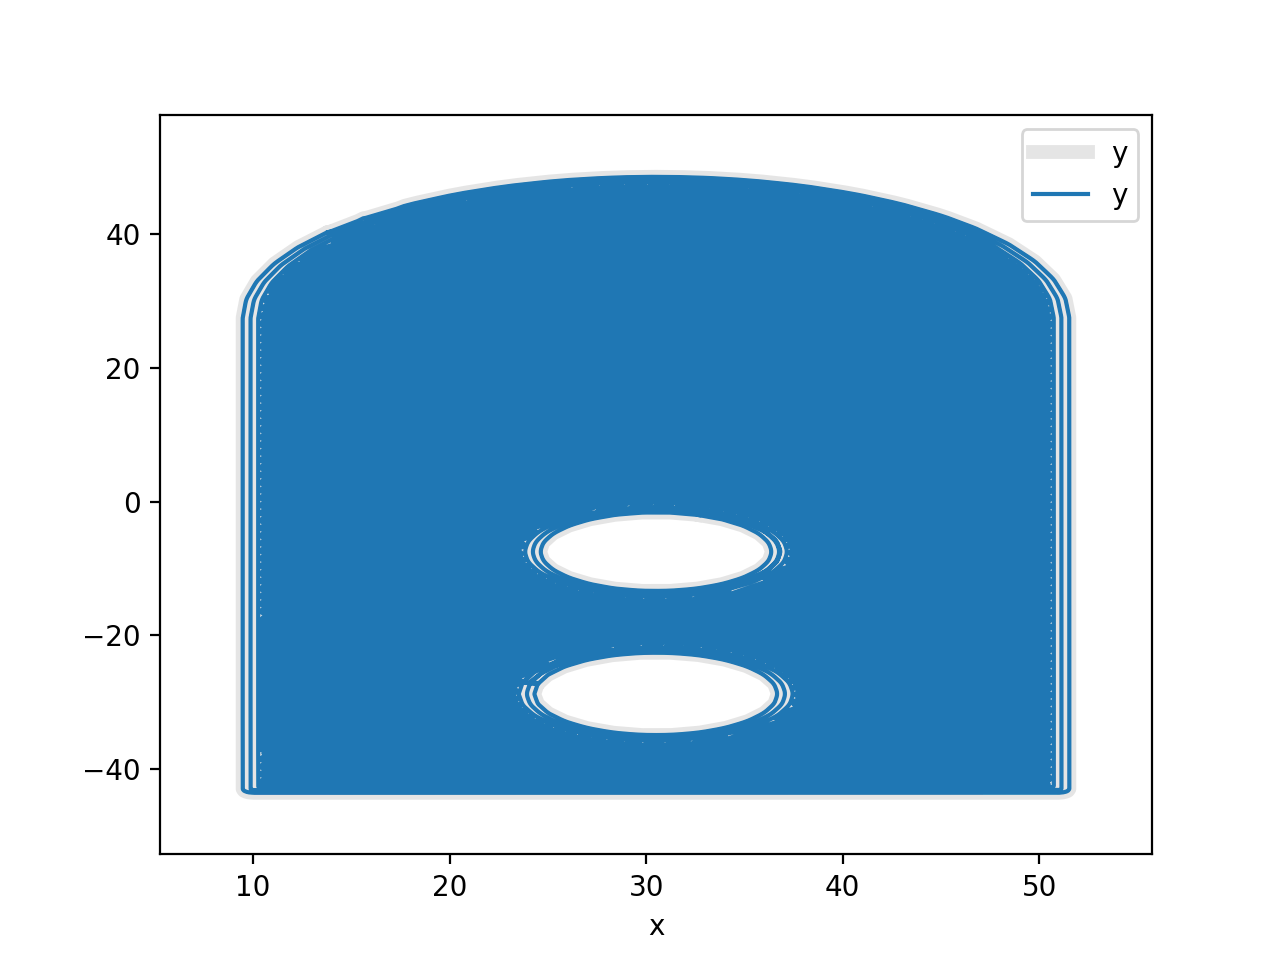

In [57]:
spm = 80
res["x"] = res["X_x"] / spm
res["y"] = res["Y_x"] / spm
res["xv"] = res["X_v"] * 65536 / 2**32 / spm * 50000000
res["yv"] = res["Y_v"] * 65536 / 2**32 / spm * 50000000
res[["x", "y", "xv", "yv", "ts"]]

lines = []
colors = []

i = 0
for index, row in all_segments.iterrows():
    i += 1
    lines.append(((row['x0'], row['y0']), (row['x1'], row['y1'])))
    st = row["seg_type"]
    if st == "start":
        colors.append((1,0,0,1))
    elif st == "end":
        colors.append((0,1,0,1))
    elif st == "short_plato":
        colors.append((0,0.3,1,1))
    elif st == "middle_plato":
        colors.append((0.8,0,0.8,1))
    elif st == "long_plato_main":
        colors.append((0.2,0.2,0.2,1))
    elif st == "long_plato_in":
        colors.append((1,0,0.8,1))
    elif st == "long_plato_out":
        colors.append((0,1,0.8,1))
    else:
        colors.append((1,1,0,1))
    
lc = LineCollection(lines, colors=colors, linewidths=1)
fig, ax = plt.subplots()

ax.add_collection(lc)

#path.iloc[limit:].plot(x="px", y="py", linewidth=3, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
full_path = pd.DataFrame()
full_path["x"] = path["px"]
full_path["y"] = path["py"]
last_x = path["x"].iloc[-1]
last_y = path["y"].iloc[-1]
full_path = full_path.append({"x": last_x, "y": last_y}, ignore_index=True)
full_path.plot(x="x", y="y", linewidth=5, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
res.plot(x="x", y="y", style="-", ax=ax)
    
ax.autoscale()
ax.margins(0.1)

<IPython.core.display.Javascript object>


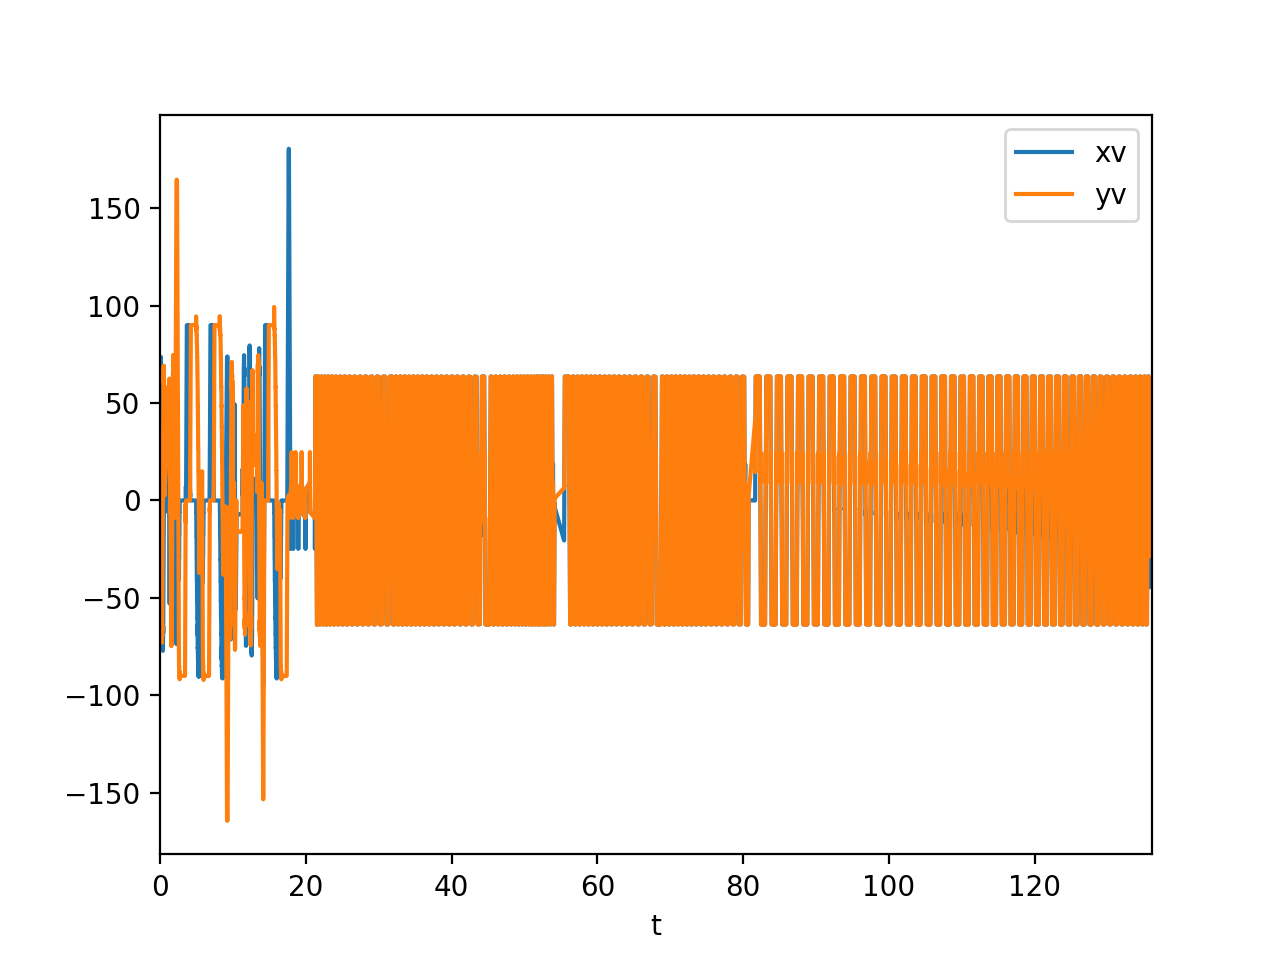

In [58]:
res.plot(x="t", y=["xv", "yv"])

In [ ]:
all_segments = path_planning.build_segments(path, plato_slowdowns)
acc_step = 10000
pr_opt = path_planning.format_segments(all_segments, acc_step=acc_step)


<ApgState x=8771010413199.36 v=0 a=0 j=0 jj=0> <ApgState x=-8387212135628.8 v=0 a=0 j=0 jj=0>
index: 0 start
x: 25.527 25.527
y: -24.41 -24.41
vx: 0.0 0.0
vy: 0.0 0.0
dx: 0.24518947197976715
dy: 0.2199463364679275
dvx: 22.144501438495595
dvy: 19.864645594194783
int_dt: 221.0
int_vx1: 152176.0 int_vy1: 136509.0
x_error: 0.0015997215959124844 int_jx: -8010.0 int_ax: 46011831.0
y_error: 0.0014349204021577577 int_jy: -7184.0 int_ay: 41274619.0
ApgStates: 25.77203291933797 -24.190211350298487
        V: 22.130407160148025 19.850267563015223
   max_xv: 22.03218173235655 0.0
   max_yv: 19.762228475883603 0.0
final x_error: -0.00015655264179770256
final y_error: -0.00015768676641414459
final vx_error: -0.014094278347570821
final vy_error: -0.014378031179560935
index: 1 middle_plato
x: 25.77203291933797 25.772189471979768
y: -24.190211350298487 -24.190053663532073
vx: 22.130407160148025 22.144501438495595
vy: 19.850267563015223 19.864645594194783
dx: 0.7315268513671072
dy: 0.6562307901799187
dv

int_vx1: 492334.0 int_vy1: -117116.0
x_error: -0.0016066482679484295 int_jx: 127413.0 int_ax: -10610739.0
y_error: -0.00015997419876967456 int_jy: 12687.0 int_ay: -45486880.0
ApgStates: 31.876657356622626 -22.34354215216823
        V: 71.62510883063078 -17.037527868524194
   max_xv: 72.62191502377391 71.62278052419424
   max_yv: -8.263596100732684 -16.93901140242815
final x_error: -8.266925081201748e-05
final y_error: 2.2378873413941847e-05
final vx_error: -0.01884609174499019
final vy_error: 0.005119456255652466
index: 13 short_plato
x: 31.876657356622626 31.87674002587344
y: -22.34354215216823 -22.343564531041643
vx: 71.62510883063078 71.64395492237577
vy: -17.037527868524194 -17.042647324779846
dx: 0.335704368288571
dy: -0.07985999053850534
dvx: -0.9686224384006863
dvy: 0.22977932790310973
int_dt: 47.0
int_vx1: 485548.0 int_vy1: -115502.0
x_error: 0.0012940803575514082 int_jx: -673610.0 int_ax: 6548822.0
y_error: -0.0003120915281815684 int_jy: 162454.0 int_ay: -1615938.0
ApgStates: 

dx: 0.29922035105654743
dy: -0.48712368322455646
dvx: -7.802021097010552
dvy: -4.1510585646631455
int_dt: 78.0
int_vx1: 237052.0 int_vy1: -443816.0
x_error: -0.0006633133202846864 int_jx: 75540.0 int_ax: -47993658.0
y_error: 0.000232632166762059 int_jy: -26493.0 int_ay: -22934464.0
ApgStates: 36.2895778473448 -25.656192550752316
        V: 34.48338247835636 -64.57572453655303
   max_xv: 42.29761543683708 34.577096812427044
   max_yv: -60.4326487518847 -64.52028173953295
final x_error: -4.7234838248755295e-05
final y_error: 3.1368354456162706e-05
final vx_error: -0.012211861470163399
final vy_error: 0.007982779994819111
index: 24 start
x: 36.2895778473448 36.28962508218305
y: -25.656192550752316 -25.656223919106772
vx: 34.48338247835636 34.495594339826525
vy: -64.57572453655303 -64.58370731654784
dx: 0.23853850244878316
dy: -0.5196347873447174
dvx: -7.782006228492449
dvy: -4.1710479956486495
int_dt: 78.0
int_vx1: 183490.0 int_vy1: -472424.0
x_error: -0.0004708988603816522 int_jx: 53627.

y_error: -0.0021145002485649655 int_jy: 231775.0 int_ay: 13958356.0
ApgStates: 36.334520608068445 -31.756851343754683
        V: -33.88631739653647 -65.76170562766492
   max_xv: -25.932822609320286 -33.79915142431855
   max_yv: -65.83286449313164 -69.80160833336413
final x_error: -3.0390794123036358e-05
final y_error: -5.651470080536569e-05
final vx_error: -0.007884836731456346
final vy_error: -0.014613687083070204
index: 36 start
x: 36.334520608068445 36.33455099886257
y: -31.756851343754683 -31.756794829053877
vx: -33.88631739653647 -33.87843255980501
vy: -65.76170562766492 -65.74709194058185
dx: -0.3001025667604864
dy: -0.5051670656489193
dvx: -7.922941240976812
dvy: 4.10124244109705
int_dt: 79.0
int_vx1: -287311.0 int_vy1: -423727.0
x_error: -0.0015012095316748741 int_jx: 164551.0 int_ax: -51666512.0
y_error: -0.0016447070421854448 int_jy: 180280.0 int_ay: 16259530.0
ApgStates: 36.03438446065225 -32.26205721331295
        V: -41.81812983006239 -61.67058018036186
   max_xv: -33.8863

   max_yv: -0.5192123353481293 -0.5660695023834705
final x_error: -0.0001037839933779594
final y_error: -5.420459487481821e-06
final vx_error: -0.08773597627096308
final vy_error: -0.0044867723046143615
index: 50 end
x: 30.448740677673367 30.448844461666745
y: -35.30118751406204 -35.301182093602556
vx: -76.55631634406745 -76.46858036779649
vy: -0.5331821739673615 -0.5286954016627471
dx: -0.6920154935999712
dy: 0.03670926456853607
dvx: 1.1247769171001778
dvy: 9.117307466962242
int_dt: 91.0
int_vx1: -518362.0 int_vy1: 58990.0
x_error: -0.0004142437949194999 int_jx: 29708.0 int_ax: 4214525.0
y_error: 0.0005331160792607648 int_jy: -38233.0 int_ay: 46861498.0
ApgStates: 29.7567425243305 -35.26448441153858
        V: -75.4278153181076 8.582137525081635
   max_xv: -75.44324034824967 -76.55631634406745
   max_yv: 8.485803846269846 -0.5331821739673615
final x_error: 1.7340257105757928e-05
final y_error: -6.162045075086553e-06
final vx_error: 0.00372410885967156
final vy_error: -0.00198776791324

x_error: -0.0006230809111649194 int_jx: 191744.0 int_ax: 25258715.0
y_error: 0.0008450582171874998 int_jy: -260054.0 int_ay: -36531645.0
ApgStates: 25.00959523080196 -32.33089980677702
        V: -42.29746991768479 60.4326487518847
   max_xv: -42.37706889398396 -46.09813913702965
   max_yv: 65.86851668544114 60.545571614056826
final x_error: -2.0790259437575287e-05
final y_error: 3.185489293855426e-05
final vx_error: -0.007657487895087911
final vy_error: 0.012006650990045387
index: 62 end
x: 25.00959523080196 25.009616021061397
y: -32.33089980677702 -32.33093166166996
vx: -42.29746991768479 -42.289812429789706
vy: 60.4326487518847 60.42064210089465
dx: -0.2992203129850104
dy: 0.4871237258837908
dvx: 7.801875577857828
dvy: 4.151058564663856
int_dt: 78.0
int_vx1: -237052.0 int_vy1: 443816.0
x_error: 0.0006627764543907233 int_jx: -75479.0 int_ax: 47990439.0
y_error: -0.0002325895075276918 int_jy: 26488.0 int_ay: 22934659.0
ApgStates: 24.710422158239407 -31.843807491906922
        V: -34.4

ApgStates: 24.550591328295877 -25.951297096991915
        V: 16.492995200678706 44.409389374777675
   max_xv: 20.87792381644249 16.51656930334866
   max_yv: 56.184944696724415 44.47298124432564
final x_error: -0.00012312425344873645
final y_error: -0.0001477265064373512
final vx_error: -0.014237017838993893
final vy_error: -0.01711466459018851
index: 74 end
x: 24.550591328295877 24.550714452549325
y: -25.951297096991915 -25.951149370485478
vx: 16.492995200678706 16.5072322185177
vy: 44.409389374777675 44.42650403936786
dx: 0.09613668945161535
dy: 0.217738551539167
dvx: 5.059634474430453
dvy: -2.5826985351331047
int_dt: 50.0
int_vx1: 148109.0 int_vy1: 287431.0
x_error: 0.001275446291010951 int_jx: -551434.0 int_ax: 59359584.0
y_error: 0.0020191558760505046 int_jy: -872973.0 int_ay: -1438334.0
ApgStates: 24.64679342869017 -25.733449119809087
        V: 21.57961716875434 41.871535358950496
   max_xv: 21.50787622667849 16.492995200678706
   max_yv: 44.409389374777675 41.96976078674197
fina

   max_yv: 48.55115548707545 34.47566996328533
final x_error: -0.008615588162200538
final y_error: -0.008157394462269707
final vx_error: -0.1112785020086875
final vy_error: -0.10692273494910154
index: 83 end
x: 35.1931481220508 35.201763710213
y: -11.773555104820991 -11.765397710358721
vx: 37.60782419703901 37.719102699047696
vy: 48.560032155364745 48.666954890313846
dx: 0.059892936824724075
dy: 0.07625644374599538
dvx: -1.2735977556207843
dvy: 1.119777018703438
int_dt: 14.0
int_vx1: 249687.0 int_vy1: 341397.0
x_error: 0.008069812296607637 int_jx: -158935293.0 int_ax: 1071577689.0
y_error: 0.007544548314323052 int_jy: -148590197.0 int_ay: 1076152773.0
ApgStates: 35.25460486183688 -11.695836657974871
        V: 38.80355507135391 51.9883178640157
   max_xv: 46.85192834585905 37.60782419703901
   max_yv: 58.43743565492332 48.560032155364745
final x_error: 0.0015638029613569415
final y_error: 0.0014620031001246758
final vx_error: 2.4693286299356885
final vy_error: 2.308508689947516
index: 

y: -5.648103384384887 -5.648009134415951
vx: -19.427825463935733 -19.435781946599413
vy: 51.19029083289205 51.22026512998858
dx: -0.2490185570503769
dy: 0.6562813662734825
dvx: -4.292063040848532
dvy: 11.32013356921906
int_dt: 115.0
int_vx1: -163002.0 int_vy1: 429568.0
x_error: -0.001133666497436181 int_jx: 40284.0 int_ax: -19124889.0
y_error: 0.0030685632522633455 int_jy: -109039.0 int_ay: 50601142.0
ApgStates: 36.2823271955112 -4.991792260636577
        V: -23.71656592004001 62.5159009359777
   max_xv: -19.427825463935733 -23.68440618738532
   max_yv: 62.4312087893486 51.19029083289205
final x_error: 1.9469561166829408e-05
final y_error: 2.975747482736324e-05
final vx_error: 0.0033225847442537315
final vy_error: 0.005476533866584532
index: 98 end
x: 36.2823271955112 36.282307725950034
y: -4.991792260636577 -4.991822018111405
vx: -23.71656592004001 -23.719888504784265
vy: 62.5159009359777 62.51042440211111
dx: -0.19610307055990006
dy: 0.43523139194800997
dvx: -7.183277326760809
dvy: -

y_error: -0.00022601479936401603 int_jy: 261800.0 int_ay: -49855781.0
ApgStates: 32.75380537728593 -1.5245231643458852
        V: -1.7262937035411596 -4.6232889872044325
   max_xv: -1.7519050743430855 -3.015011316165328
   max_yv: -1.0085932444781065 -4.533067112788558
final x_error: 1.9701304637465e-05
final y_error: -1.081766760702152e-05
final vx_error: 0.011380959679656133
final vy_error: -0.006039167788673083
index: 109 short_plato
x: 32.75380537728593 32.75378567598129
y: -1.5245231643458852 -1.5245123466782782
vx: -1.7262937035411596 -1.7376746632208158
vy: -4.6232889872044325 -4.617249819415759
dx: -0.022493513691003386
dy: -0.05970531238759591
dvx: -0.6383251889839263
dvy: -1.6598412129342623
int_dt: 110.0
int_vx1: -16250.0 int_vy1: -43177.0
x_error: -2.504349440179965e-05 int_jx: 1017.0 int_ax: -2669630.0
y_error: 0.0001967293226510236 int_jy: -7988.0 int_ay: -6356147.0
ApgStates: 32.73135411494691 -1.584179759458641
        V: -2.3575557861477137 -6.274203769862653
   max_xv

ApgStates: 36.39955429592915 -5.410395768205637
        V: 25.727349566295743 -67.74993380531669
   max_xv: 26.54560375958681 25.7455394603312
   max_yv: -67.7943171467632 -69.92195267230272
final x_error: -9.149215273396294e-06
final y_error: 2.1304008011924225e-05
final vx_error: -0.0044586221216746935
final vy_error: 0.010494424182610373
index: 122 end
x: 36.39955429592915 36.39956344514442
y: -5.410395768205637 -5.410417072213649
vx: 25.727349566295743 25.731808188417418
vy: -67.74993380531669 -67.7604282294993
dx: 0.18174354257229908
dy: -0.5814372277587125
dvx: -8.445649246840674
dvy: -2.101117668601532
int_dt: 85.0
int_vx1: 118759.0 int_vy1: -480013.0
x_error: -0.0014672382296687658 int_jx: 129117.0 int_ax: -50235454.0
y_error: 0.0032620440563242425 int_jy: -287061.0 int_ay: 1067454.0
ApgStates: 36.58122263208311 -5.991693515181543
        V: 17.2638101503253 -69.81776095926762
   max_xv: 25.727349566295743 17.351412680000067
   max_yv: -67.74396752007306 -69.76668373681605
fina

y: -10.912898449543865 -10.912902966261234
vx: -42.308238334953785 -42.30599457546244
vy: -61.39642209745944 -61.397678902440205
dx: -0.19786535444822562
dy: -0.28717394986756695
dvx: -2.976691894539833
dvy: -4.324514929334576
int_dt: 45.0
int_vx1: -311196.0 int_vy1: -451631.0
x_error: -0.0009294544806159877 int_jx: 551228.0 int_ax: -42193839.0
y_error: -0.0013760665482838164 int_jy: 816099.0 int_ay: -61642202.0
ApgStates: 35.55012803757377 -11.200154158370571
        V: -45.30927981249988 -65.75850420631468
   max_xv: -42.308238334953785 -45.26955308392644
   max_yv: -61.39642209745944 -65.70146069861948
final x_error: -5.309088933813655e-05
final y_error: -8.175895913886677e-05
final vx_error: -0.024349583006262776
final vy_error: -0.03756717952066424
index: 134 end
x: 35.55012803757377 35.55018112846311
y: -11.200154158370571 -11.200072399411432
vx: -45.30927981249988 -45.28493022949362
vy: -65.75850420631468 -65.72093702679402
dx: -0.350909839414868
dy: -0.44906451788761004
dvx: -7

x: 28.7139389640633 28.71379538602797
y: -13.505847937278451 -13.505798334633248
vx: -61.21976184658706 -61.25881266415081
vy: 14.89694113843143 14.909772031478045
dx: -0.4292690904236274
dy: 0.13250204765982865
dvx: 2.660909102894756
dvy: 7.1758065849467165
int_dt: 72.0
int_vx1: -402413.0 int_vy1: 151683.0
x_error: 0.002066775193316772 int_jx: -299252.0 int_ax: 27417396.0
y_error: -0.00023016196356984153 int_jy: 33326.0 int_ay: 43685142.0
ApgStates: 28.28477275965083 -13.37337342739571
        V: -58.52969479747117 22.065069060772657
   max_xv: -58.54351911693812 -61.21976184658706
   max_yv: 21.962914615869522 14.89694113843143
final x_error: 0.0001028860111595975
final y_error: -2.753777708797145e-05
final vx_error: 0.029157946221133102
final vy_error: -0.007678662605488995
index: 150 start
x: 28.28477275965083 28.284669873639672
y: -13.37337342739571 -13.373345889618623
vx: -58.52969479747117 -58.558852743692306
vy: 22.065069060772657 22.072747723378146
dx: -0.4098886511201094
dy: 

ApgStates: 24.238113075842147 -7.510093726534398
        V: -0.13606040738523006 74.09937097691
   max_xv: -0.23006577976047993 -9.116483852267265
   max_yv: 74.24998329952359 73.43609468080103
final x_error: 5.4242842082885545e-05
final y_error: -0.00017388137267104753
final vx_error: 0.012287309994913898
final vy_error: -0.04008915510550537
index: 165 start
x: 24.238113075842147 24.238058833000064
y: -7.510093726534398 -7.509919845161727
vx: -0.13606040738523006 -0.14834771738014396
vy: 74.09937097691 74.1394601320155
dx: 0.038676752403908665
dy: 0.6638650170095577
dvx: 8.93855991248235
dvy: 0.057999155417206794
int_dt: 90.0
int_vx1: 60490.0 int_vy1: 509606.0
x_error: 0.00012490908621742847 int_jx: -9260.0 int_ax: 45145020.0
y_error: -0.003287698372755443 int_jy: 243728.0 int_ay: -10677217.0
ApgStates: 24.276766760738564 -6.846366146430375
        V: 8.79692379385233 74.12658305838704
   max_xv: 8.69855284690857 -0.13606040738523006
   max_yv: 74.10213584080338 73.56487913057208
fina

vy: 12.220116332173347 12.232078554455185
dx: 0.30201055280823397
dy: 0.055894003220420485
dvx: 0.7603300414690182
dvy: -6.0538573044088855
int_dt: 61.0
int_vx1: 344583.0 int_vy1: 42374.0
x_error: -0.0015072994627729486 int_jx: 358881.0 int_ax: -5332336.0
y_error: -0.00048704308592140144 int_jy: 115963.0 int_ay: -48232424.0
ApgStates: 29.732176897812632 -1.2634336180891865
        V: 50.114758778363466 6.154004950076342
   max_xv: 50.0788155477494 49.288064474239945
   max_yv: 12.220116332173347 6.245682016015053
final x_error: -8.543658960746825e-05
final y_error: -3.6534823995237886e-05
final vx_error: -0.028659743786739966
final vy_error: -0.012254077688120368
index: 183 start
x: 29.732176897812632 29.73226233440224
y: -1.2634336180891865 -1.2633970832651913
vx: 50.114758778363466 50.143418522150206
vy: 6.154004950076342 6.166259027764462
dx: 0.306508698198531
dy: 0.01904286597605065
dvx: 0.7745884323288692
dvy: -6.053565449002603
int_dt: 61.0
int_vx1: 349709.0 int_vy1: 690.0
x_erro

   max_yv: 164.08986994065344 9.588402463123202
final x_error: 0.009282462419623272
final y_error: -0.008820267568326656
final vx_error: 0.11508223278239882
final vy_error: -0.11446628951017601
index: 194 long_plato_main
x: 26.733457076477816 26.724174614058192
y: 11.97341555779334 11.982235825361666
vx: -73.398114182055 -73.5131964148374
vy: 164.18955055996776 164.30401684947793
dx: -6.496671644597278
dy: 14.508313603196227
dvx: -0.11508223278239882
dvy: 0.11446628951017601
int_dt: 882.0
int_vx1: -505179.0 int_vy1: 1129089.0
x_error: -0.01788760000715257 int_jx: 1409.0 int_ax: -680143.0
y_error: 0.021750491964803588 int_jy: -1713.0 int_ay: 813910.0
ApgStates: 20.23952009971067 26.47900111149996
        V: -73.45050107687712 164.2416464164853
   max_xv: -73.398114182055 -73.72917025350034
   max_yv: 164.58594473078847 164.18955055996776
final x_error: 0.0027346678301327643
final y_error: -0.0027280494896047003
final vx_error: 0.06269533796027815
final vy_error: -0.06237043299262268
ind

ApgStates: 12.805649816289542 38.07171452898532
        V: -40.92536983080208 -61.334139900282025
   max_xv: -7.159687811508776 -40.860031731426716
   max_yv: -10.744406608864665 -61.23605999164283
final x_error: 0.0009169750575122038
final y_error: 0.0009152194233479349
final vx_error: 0.036298706174285655
final vy_error: 0.036399327289181826
index: 205 end
x: 12.805649816289542 12.80473284123203
y: 38.07171452898532 38.07079930956197
vx: -40.92536983080208 -40.96166853697637
vy: -61.334139900282025 -61.37053922757121
dx: -0.16296323552748504
dy: -0.26172603891500046
dvx: 4.131813759212939
dvy: -2.441089685957891
int_dt: 42.0
int_vx1: -252843.0 int_vy1: -438260.0
x_error: 0.00045298255598247295 int_jx: -330426.0 int_ax: 51244403.0
y_error: 0.0008815703232407657 int_jy: -643058.0 int_ay: -12671172.0
ApgStates: 12.64272332831565 37.81005566814914
        V: -36.77516360767186 -63.74219083227218
   max_xv: -36.85898263938725 -40.92536983080208
   max_yv: -61.334139900282025 -63.655606936

final vx_error: 0.018547571942079344
final vy_error: 0.07181585182158301
index: 215 start
x: 10.064185067893003 10.064131473864094
y: 30.195950615950856 30.1957437692169
vx: -11.70774339698255 -11.72629096892463
vy: -88.96546205505729 -89.03727790687887
dx: -0.05156144897983417
dy: -0.5236388705483144
dvx: 5.834908477964789
dvy: -0.8427213694723861
int_dt: 59.0
int_vx1: -40358.0 int_vy1: -617157.0
x_error: 0.0005930808856771108 int_jx: -156063.0 int_ax: 49142790.0
y_error: 0.0037011896616210294 int_jy: -973927.0 int_ay: 22298322.0
ApgStates: 10.012665059764867 29.672508053397756
        V: -5.858455551788211 -89.74006050266325
   max_xv: -5.947513272985816 -11.70774339698255
   max_yv: -88.37203495204449 -89.66424502432346
final x_error: 4.1440851697771564e-05
final y_error: 0.00019630799521408449
final vx_error: 0.014379367229550688
final vy_error: 0.06812292186641855
index: 216 long_plato_main
x: 10.012665059764867 10.01262361891317
y: 29.672508053397756 29.672311745402542
vx: -5.858

y_error: -0.0002510700960840495 int_jy: 1696079.0 int_ay: 7015556.0
ApgStates: 9.91227308462653 -43.058013065103445
        V: 6.991758709773421 -9.303330443799496
   max_xv: 6.9306406658142805 4.952889867126942
   max_yv: -9.390496416017413 -10.331859812140465
final x_error: 3.866174377442633e-05
final y_error: -3.383459308992087e-05
final vx_error: 0.041456688019423815
final vy_error: -0.0362610814603741
index: 225 short_plato
x: 9.91227308462653 9.912234422882756
y: -43.058013065103445 -43.057979230510355
vx: 6.991758709773421 6.9503020217539975
vy: -9.303330443799496 -9.267069362339122
dx: 0.02218849373806364
dy: -0.028499001525979395
dvx: -1.2246740270714902
dvy: 3.847746389110748
int_dt: 39.0
int_vx1: 39631.0 int_vy1: -37490.0
x_error: -0.002752455730968606 int_jx: 2507654.0 int_ax: -63041586.0
y_error: 0.00047313409793758865 int_jy: -431054.0 int_ay: 52838961.0
ApgStates: 9.93425191903766 -43.08647140170448
        V: 5.655747372657061 -5.43397618457675
   max_xv: 6.991758709773

y_error: -0.00027213140542947656 int_jy: 2144168.0 int_ay: 20231681.0
ApgStates: 50.951073421163485 -43.12393177134451
        V: 14.819233911111953 3.724417183548212
   max_xv: 15.48920408822596 14.477554941549897
   max_yv: 3.593886503949761 2.058077370747924
final x_error: -0.00011885399050726164
final y_error: -4.112768768038677e-05
final vx_error: -0.1345724361930678
final vy_error: -0.04654267794671574
index: 236 short_plato
x: 50.951073421163485 50.95119227515399
y: -43.12393177134451 -43.12389064365683
vx: 14.819233911111953 14.95380634730502
vy: 3.724417183548212 3.770959861494928
dx: 0.07214080075067386
dy: 0.018203183827203873
dvx: -5.7721538034123565
dvy: -1.4429795911714178
int_dt: 60.0
int_vx1: 62171.0 int_vy1: 15678.0
x_error: 0.0002532773899375229 int_jx: -63370.0 int_ax: -41424750.0
y_error: 0.00011343596754187502 int_jy: -28382.0 int_ay: -9979456.0
ApgStates: 51.02321470097918 -43.105736405788925
        V: 9.046925697475672 2.2789754439145327
   max_xv: 14.8192339111

   max_yv: 89.94611562229693 89.87262845039368
final x_error: 0.00010921857184342798
final y_error: -0.010472373199764462
final vx_error: 0.0012784817317846127
final vy_error: -0.127517059677956
x: 51.13181794353109 51.131708724959246
y: -22.427874604556713 -22.41740223135695
vx: 0.0 -0.0012784817317846127
vy: 89.8724829312414 89.99999999091935
dx: -0.0003441570573343711
dy: 16.549201997804282
dvx: -0.0012784817317846127
dvy: 0.127517059677956
int_dt: 1838.0
int_vx1: -9.0 int_vy1: 618475.0
x_error: -0.00022382816315236198 int_jx: 2.0 int_ax: -2159.0
y_error: 0.018930996382380272 int_jy: -165.0 int_ay: 182870.0
ApgStates: 51.13181794353109 -5.890944770737553
        V: 0.0 89.86738976091146
   max_xv: 0.0 0.0
   max_yv: 90.02178558148444 89.86768079921603
final x_error: 0.0003441570573343711
final y_error: -0.012272163985121765
final vx_error: 0.0012784817317846127
final vy_error: -0.1326102300078844
x: 51.13181794353109 51.131473786473755
y: -5.890944770737553 -5.878672606752431
vx: 0.

dx: -0.848519597859152
dy: 1.635667873794631
dvx: -0.027005597570742168
dvy: 0.06312898171839265
int_dt: 205.0
int_vx1: -284804.0 int_vy1: 548998.0
x_error: 0.0008125681294401943 int_jx: -5097.0 int_ax: 462980.0
y_error: -0.0014209618696376936 int_jy: 8914.0 int_ay: -774940.0
ApgStates: 48.34025767398812 37.8032711141603
        V: -41.42857505939901 79.87269782461226
   max_xv: -41.36352799832821 -41.42741090618074
   max_yv: 79.870515037328 79.74449545145035
final x_error: 0.00016083890109541699
final y_error: -0.00017270796601565053
final vx_error: 0.015800622844899692
final vy_error: -0.01699941044446973
index: 258 end
x: 48.34025767398812 48.340096835087024
y: 37.8032711141603 37.80344382212632
vx: -41.42857505939901 -41.44437568224391
vy: 79.87269782461226 79.88969723505673
dx: -0.22985130926338826
dy: 0.40846154148471214
dvx: -5.229942023932637
dvy: -3.1541245461293244
int_dt: 52.0
int_vx1: -320635.0 int_vy1: 527206.0
x_error: -0.0010863253410633433 int_jx: 417533.0 int_ax: -561

x_error: 0.0005826808969686681 int_jx: -456899.0 int_ax: 10474148.0
y_error: -0.0003797971724566196 int_jy: 297811.0 int_ay: -6754092.0
ApgStates: 42.577840324372985 44.221371512310576
        V: -72.47101166285574 53.317926358431585
   max_xv: -72.31516065075994 -72.595285018906
   max_yv: 53.393450798466795 53.21417120285332
final x_error: 4.7140590439198604e-05
final y_error: -3.257504569376124e-05
final vx_error: 0.023421623259309854
final vy_error: -0.016463508942109684
index: 273 end
x: 42.577840324372985 42.577793183782546
y: 44.221371512310576 44.22140408735627
vx: -72.47101166285574 -72.49443328611505
vy: 53.317926358431585 53.334389867373694
dx: -0.17683656570221018
dy: 0.12572172436561857
dvx: -1.679280058153978
dvy: -2.3946620886977357
int_dt: 24.0
int_vx1: -509557.0 int_vy1: 349942.0
x_error: -0.0009749530618279323 int_jx: 3811457.0 int_ax: -77249377.0
y_error: 0.0005125637712879438 int_jy: -2003804.0 int_ay: -20890203.0
ApgStates: 42.40089078142587 44.34715185014996
     

index: 290 short_plato
x: 35.58180703315698 35.581559430219265
y: 47.48863063103985 47.48870721885409
vx: -87.3846875037998 -87.55744991824801
vy: 20.771840354427695 20.82529624791668
dx: -0.6385770784525846
dy: 0.1519014804280232
dvx: -0.17276241444821494
dvy: 0.05345589348898372
int_dt: 73.0
int_vx1: -601690.0 int_vy1: 143110.0
x_error: -4.7027417160450113e-05 int_jx: 6533.0 int_ax: -1304088.0
y_error: 7.478564893403927e-05 int_jy: -10389.0 int_ay: 708674.0
ApgStates: 34.94324636470806 47.64051608616486
        V: -87.55290764383972 20.820734789595008
   max_xv: -87.3846875037998 -87.55116141401231
   max_yv: 20.821316866204143 20.771840354427695
final x_error: 1.641000366703338e-05
final y_error: -1.6025303011701908e-05
final vx_error: 0.0045422744082941335
final vy_error: -0.004561458321671097
index: 291 end
x: 34.94324636470806 34.94322995470439
y: 47.64051608616486 47.64053211146787
vx: -87.55290764383972 -87.55744991824801
vy: 20.820734789595008 20.82529624791668
dx: -0.25510341

int_dt: 31.0
int_vx1: -612619.0 int_vy1: -82230.0
x_error: 0.00449110785422846 int_jx: -8147220.0 int_ax: 132712894.0
y_error: 0.00033352784090112664 int_jy: -605045.0 int_ay: -34998130.0
ApgStates: 27.80104470206238 47.948376535703424
        V: -88.86505383998156 -11.942902347072959
   max_xv: -87.03995263203979 -89.59046681411564
   max_yv: -8.911447366699576 -11.825031833723187
final x_error: 0.000419523277720657
final y_error: 3.4155374528666016e-05
final vx_error: 0.2827478894557913
final vy_error: 0.02314861368056853
index: 307 start
x: 27.80104470206238 27.80062517878466
y: 47.948376535703424 47.948342380328896
vx: -88.86505383998156 -89.14780172943735
vy: -11.942902347072959 -11.966050960753527
dx: -0.27188125383371897
dy: -0.0412132120273867
dvx: 0.12692499392728962
dvy: -3.075236315926288
int_dt: 31.0
int_vx1: -609804.0 int_vy1: -103204.0
x_error: 0.0034100740456821654 int_jx: -6186140.0 int_ax: 97728634.0
y_error: 0.0004226695730569219 int_jy: -766756.0 int_ay: -32791807.0


        V: -60.333259170874946 -32.987300073727965
   max_xv: -60.21567969582975 -61.3111478742212
   max_yv: -31.012896215543154 -32.84876584075391
final x_error: 9.136832213840762e-05
final y_error: 4.0545303427563795e-05
final vx_error: 0.09793227205510391
final vy_error: 0.0434132615379923
index: 323 short_plato
x: 20.879060941513625 20.878969573191487
y: 45.74643385238945 45.746393307086024
vx: -60.333259170874946 -60.43119144293005
vy: -32.987300073727965 -33.03071333526596
dx: -0.5961044726139058
dy: -0.3258116830529687
dvx: 9.070823401638485
dvy: 4.968080522841088
int_dt: 107.0
int_vx1: -352273.0 int_vy1: -192547.0
x_error: 0.001386209270732408 int_jx: -61153.0 int_ax: 41450386.0
y_error: 0.0008219017894486313 int_jy: -36258.0 int_ay: 22850074.0
ApgStates: 20.283035972386596 45.42068736735731
        V: -51.24733434058726 -28.007052605971694
   max_xv: -51.325041567906744 -60.333259170874946
   max_yv: -28.049398679286245 -32.987300073727965
final x_error: 7.950348687657538e-05

y: 42.021285551516335 42.02128005891554
vx: -5.869078449904919 -5.8790930259148695
vy: -2.1417508833110332 -2.1434193323645854
dx: -0.008110153242405715
dy: -0.004456449360333181
dvx: 1.1919821971389633
dvy: -1.531961129549701
int_dt: 15.0
int_vx1: -32141.0 int_vy1: -25246.0
x_error: -0.0001408987294428954 int_jx: 2256183.0 int_ax: 18865652.0
y_error: -0.00017140508758828332 int_jy: 2744675.0 int_ay: -66582596.0
ApgStates: 15.878894812192765 42.016798599422906
        V: -4.713656380772591 -3.718450898304582
   max_xv: -4.825706128031015 -5.869078449904919
   max_yv: -2.1417508833110332 -3.656023181974888
final x_error: -2.489123919957592e-05
final y_error: -3.0502733096682277e-05
final vx_error: -0.03656012800663522
final vy_error: -0.04473888544384774
index: 340 start
x: 15.878894812192765 15.878919703431965
y: 42.016798599422906 42.016829102156
vx: -4.713656380772591 -4.677096252765955
vy: -3.718450898304582 -3.6737120128607343
dx: -0.006212731490419898
dy: -0.006762249714427071
dvx

x_error: 0.0005581298666861301 int_jx: -379377.0 int_ax: 53252994.0
y_error: 0.0005102513605521608 int_jy: -346833.0 int_ay: -18233202.0
ApgStates: 12.14212463877443 37.723059705956835
        V: -33.51058694534004 -68.0091034155339
   max_xv: -33.59353286214173 -37.83759893849492
   max_yv: -65.57587767019868 -67.93634383939207
final x_error: 4.404303063765269e-05
final y_error: 4.093153255269044e-05
final vx_error: 0.021204330908290103
final vy_error: 0.019621155604767182
index: 356 long_plato_in
x: 12.14212463877443 12.142080595743792
y: 37.723059705956835 37.72301877442428
vx: -33.51058694534004 -33.53179127624833
vy: -68.0091034155339 -68.02872457113867
dx: -0.4655477919346058
dy: -0.9444469747447997
dvx: -6.2798710414645456
dvy: -12.717097121840197
int_dt: 127.0
int_vx1: -273438.0 int_vy1: -554746.0
x_error: -0.0004001003006344206 int_jx: 10556.0 int_ax: -22939645.0
y_error: -0.0006138575123486589 int_jy: 16196.0 int_ay: -46124954.0
ApgStates: 11.676625052348708 36.77865706957876

ApgStates: 9.469048624157903 10.64363945441786
        V: 0.0 -89.85851309262216
   max_xv: 0.010186340659856796 0.0
   max_yv: -89.85487511381507 -90.20848665386438
final x_error: 0.0002878560155963328
final y_error: 0.012916147471381478
final vx_error: 0.0012773204653829969
final vy_error: 0.14148689831367278
x: 9.469048624157903 9.468760768142307
y: 10.64363945441786 10.630723306946479
vx: 0.0 -0.0012773204653829969
vy: -89.85851309262216 -89.99999999093583
dx: -0.0005233299969837901
dy: -16.604412876016198
dvx: -0.0012773204653829969
dvy: -0.14148689831367278
int_dt: 1843.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: -0.00040272225985305 int_jx: 3.0 int_ax: -3084.0
y_error: -0.03046176983909845 int_jy: 263.0 int_ay: -276918.0
ApgStates: 9.469048624157903 -5.948525738869796
        V: 0.0 -89.8670987226069
   max_xv: 0.0 0.0
   max_yv: -89.85851309262216 -90.10909707285464
final x_error: 0.0005233299969837901
final y_error: 0.01224768272854071
final vx_error: 0.0012773204653829969
fin

dvy: -0.00871602687812401
int_dt: 670.0
int_vx1: 618475.0 int_vy1: 15.0
x_error: 0.002789947333589282 int_jx: -501.0 int_ax: 45197718.0
y_error: -0.00036141716956628045 int_jy: 65.0 int_ay: -27644.0
ApgStates: 13.87736296804901 -43.53194221222308
        V: 89.95135431177914 0.0
   max_xv: 89.85181921161711 23.009051801636815
   max_yv: 0.010913936421275139 0.0
final x_error: -0.001584737066226083
final y_error: -3.628147445056129e-05
final vx_error: -0.04864566138303417
final vy_error: -0.0021979095431511287
index: 386 long_plato_main
long segment, split up 2
x: 13.87736296804901 13.878947705115236
y: -43.53194221222308 -43.53190593074863
vx: 89.95135431177914 89.99999997316218
vy: 0.0 0.0021979095431511287
dx: 16.634799247690676
dy: 0.00044248481797382055
dvx: 0.04864566138303417
dvy: 0.0021979095431511287
int_dt: 1848.0
int_vx1: 618475.0 int_vy1: 15.0
x_error: 0.007300337262427093 int_jx: -63.0 int_ax: 70057.0
y_error: 0.0002408847266863745 int_jy: -2.0 int_ay: 2380.0
ApgStates: 30.

        V: 2.885062713176012 22.616441128775477
   max_xv: 5.787442205473781 2.976012183353305
   max_yv: 22.601161617785692 22.245076252147555
final x_error: -1.4998233702101516e-05
final y_error: -6.4077611412471924e-06
final vx_error: -0.010977989742420036
final vy_error: -0.0045655922738205845
index: 401 start
x: 51.52779053081572 51.527805529049424
y: -42.97246941315476 -42.97246300539362
vx: 2.885062713176012 2.896040702918432
vy: 22.616441128775477 22.621006721049298
dx: 0.0042085240569420534
dy: 0.06606214014126977
dvx: -2.885389027945687
dvy: 0.3753712278165544
int_dt: 29.0
int_vx1: -2.0 int_vy1: 157999.0
x_error: -0.00011866256852144375 int_jx: 262942.0 int_ax: -48621204.0
y_error: -5.115429779323222e-05 int_jy: 113352.0 int_ay: 4186840.0
ApgStates: 51.531986109910534 -42.906415461413566
        V: -0.00974978320300579 22.986059775575995
   max_xv: 2.885062713176012 0.08178176358342171
   max_yv: 22.969761630520225 22.616441128775477
final x_error: -1.294496212977947e-05
fina

vy: 82.40749593824148 82.35208203218113
dx: -0.21753103696371312
dy: 0.4571944080439394
dvx: -5.609637336582132
dvy: -2.504860961231614
int_dt: 56.0
int_vx1: -284632.0 int_vy1: 549087.0
x_error: -0.001569766521946292 int_jx: 483072.0 int_ax: -58639360.0
y_error: 0.0026006890024987683 int_jy: -800323.0 int_ay: 2264916.0
ApgStates: 49.55743175581843 36.324566664905284
        V: -41.445455281063914 79.94836778379977
   max_xv: -35.809789551422 -41.3742964155972
   max_yv: 82.4171002022922 80.04120900295675
final x_error: -7.110016324674007e-05
final y_error: 0.00012496475530809903
final vx_error: -0.026028393059782218
final vy_error: 0.04573280678989988
index: 415 long_plato_main
x: 49.55743175581843 49.557502855981674
y: 36.324566664905284 36.324441700149976
vx: -41.445455281063914 -41.41942688800413
vy: 79.94836778379977 79.90263497700987
dx: -0.8756834865942551
dy: 1.6893020585672502
dvx: 0.026028393059782218
dvy: -0.04573280678989988
int_dt: 211.0
int_vx1: -284632.0 int_vy1: 549087.0

y_error: 0.0006255716179701665 int_jy: -371006.0 int_ay: 7631108.0
ApgStates: 42.79916236758977 44.55508348290808
        V: -72.50419002957642 53.36274625733495
   max_xv: -72.52892828546464 -72.81516445800662
   max_yv: 53.600670071318746 53.382100304588675
final x_error: -4.345710866715535e-05
final y_error: 3.29025607683775e-05
final vx_error: -0.019617339150016733
final vy_error: 0.014956032375394557
index: 431 end
x: 42.79916236758977 42.79920582469844
y: 44.55508348290808 44.55505058034731
vx: -72.50419002957642 -72.4845726904264
vy: 53.36274625733495 53.34779022495955
dx: -0.17716902690195013
dy: 0.12599521870691177
dvx: -1.6407366248699589
dvy: -2.432102442918783
int_dt: 24.0
int_vx1: -509520.0 int_vy1: 349993.0
x_error: -0.0012721331022405025 int_jx: 4973245.0 int_ax: -90467207.0
y_error: 0.0007214985202423918 int_jy: -2820608.0 int_ay: -11790336.0
ApgStates: 42.62184533057548 44.68116159658879
        V: -74.27559467032552 51.00402631796896
   max_xv: -72.50419002957642 -74.

final vy_error: 0.07313606644684967
index: 447 start
x: 35.9474221861437 35.9478115415466
y: 47.80776770893484 47.807666506591076
vx: -87.02656487002969 -86.74517570643997
vy: 23.862958187237382 23.789822120790532
dx: -0.2561747024891474
dy: 0.06560193781407264
dvx: -0.5259944516532897
dvy: -3.0171107296936377
int_dt: 29.0
int_vx1: -601657.0 int_vy1: 143252.0
x_error: -0.003061191970548549 int_jx: 6783246.0 int_ax: -106526468.0
y_error: 0.0006232270642314575 int_jy: -1380999.0 int_ay: -26829234.0
ApgStates: 35.69094932230469 47.87342836606316
        V: -87.76827598921955 20.88825567625463
   max_xv: -87.02656487002969 -89.00213288143277
   max_yv: 23.862958187237382 21.0337748285383
final x_error: -0.0002981613498604929
final y_error: 5.871931424650256e-05
final vx_error: -0.2157166675365687
final vy_error: 0.04240821871088585
index: 448 short_plato
x: 35.69094932230469 35.69124748365455
y: 47.87342836606316 47.87336964674891
vx: -87.76827598921955 -87.55255932168298
vy: 20.8882556762

dvy: 0.010315261117858299
int_dt: 87.0
int_vx1: -615411.0 int_vy1: -61494.0
x_error: 0.00048785858024480433 int_jx: -40038.0 int_ax: 1983458.0
y_error: 8.11216603100462e-05 int_jy: -6658.0 int_ay: 343106.0
ApgStates: 28.02358545362763 48.37716452128719
        V: -89.54404620453715 -8.941424312070012
   max_xv: -89.48598406277597 -89.60079867392778
   max_yv: -8.934875950217247 -8.958886610344052
final x_error: 4.312645502935197e-05
final y_error: 3.100118070165081e-05
final vx_error: 0.009976992680563512
final vy_error: 0.0071470371561819235
index: 464 end
x: 28.02358545362763 28.0235423271726
y: 48.37716452128719 48.37713352010649
vx: -89.54404620453715 -89.55402319721772
vy: -8.941424312070012 -8.948571349226194
dx: -0.27096764510972804
dy: -0.031761525198284346
dvx: 0.3975266103095123
dvy: -3.0393092726216224
int_dt: 30.0
int_vx1: -612610.0 int_vy1: -82331.0
x_error: -0.0029119660595338104 int_jx: 5828591.0 int_ax: -81460720.0
y_error: -0.0005302484102269744 int_jy: 1061345.0 int_a

        V: -66.53368473052979 -33.63529685884714
   max_xv: -66.95961928926408 -69.04650945216417
   max_yv: -31.249073799699545 -33.9350663125515
final x_error: -0.0004062106079167904
final y_error: -0.00022254557915601936
final vx_error: -0.4131235106301858
final vy_error: -0.22630707227904878
index: 480 start
x: 20.823754816081372 20.82416102668929
y: 46.16947963767219 46.169702183251346
vx: -66.53368473052979 -66.1205612198996
vy: -33.63529685884714 -33.40898978656809
dx: -0.1401782444496007
dy: -0.07369555485434631
dvx: 1.496300700349849
dvy: -1.9174357987984791
int_dt: 21.0
int_vx1: -446933.0 int_vy1: -244317.0
x_error: -0.0019538799739642343 int_jx: 11402000.0 int_ax: -87630205.0
y_error: -0.0011439255633618473 int_jy: 6675455.0 int_ay: -111214558.0
ApgStates: 20.68331594113074 46.095632698768746
        V: -65.3021561447531 -35.70676199160516
   max_xv: -65.614003688097 -67.38118827342987
   max_yv: -33.63529685884714 -35.81619239412248
final x_error: -0.00026063050103175556
fi

dx: -0.03802598238841881
dy: -0.018024142190071757
dvx: -1.386206511099255
dvy: 2.7345093565839127
int_dt: 26.0
int_vx1: -106664.0 int_vy1: -39373.0
x_error: 0.0004589293840773223 int_jx: -1411129.0 int_ax: -5666705.0
y_error: 0.0005641323304317325 int_jy: -1734610.0 int_ay: 69914814.0
ApgStates: 15.725836734634822 42.38821923898998
        V: -15.479017747566104 -5.677575245499611
   max_xv: -14.13543941453099 -15.388213796541097
   max_yv: -5.73665602132678 -8.463975973427296
final x_error: 5.264318467368412e-05
final y_error: 6.403744798433308e-05
final vx_error: 0.042628178064141764
final vy_error: 0.051891371343772086
index: 496 short_plato
x: 15.725836734634822 15.725784091450148
y: 42.38821923898998 42.388155201542
vx: -15.479017747566104 -15.521645925630246
vy: -5.677575245499611 -5.729466616843383
dx: -0.09471392201546003
dy: -0.03500612023787397
dvx: 8.093259179383862
dvy: 2.9512885257007953
int_dt: 83.0
int_vx1: -50755.0 int_vy1: -18735.0
x_error: 0.0005798329324182561 int_j

x_error: -0.0008600608297619772 int_jx: 420288.0 int_ax: -54628181.0
y_error: 0.0005884538938119022 int_jy: -287561.0 int_ay: -24495741.0
ApgStates: 14.109607693388124 39.863110619978976
        V: 17.43246684782207 -24.91768100298941
   max_xv: 22.20564056187868 17.510028555989265
   max_yv: -21.590094547718763 -24.833279894664884
final x_error: -6.058799852226571e-05
final y_error: 4.4117777676433434e-05
final vx_error: -0.025933286153119184
final vy_error: 0.018820244905953132
index: 513 start
x: 14.109607693388124 14.109668281386647
y: 39.863110619978976 39.8630665022013
vx: 17.43246684782207 17.45840013397519
vy: -24.91768100298941 -24.936501247895364
dx: 0.07184155802254999
dy: -0.1266906504488432
dvx: -4.734679828426479
dvy: -3.3517933757855403
int_dt: 48.0
int_vx1: 87259.0 int_vy1: -194266.0
x_error: -0.0007079467545363372 int_jx: 345954.0 int_ax: -52725381.0
y_error: 0.0007908136401866273 int_jy: -386448.0 int_ay: -22172971.0
ApgStates: 14.18139811197575 39.73647602650802
    

   max_yv: -52.75884177535772 -57.3247962165624
final x_error: -2.6394011101160686e-06
final y_error: -4.526464999266011e-06
final vx_error: -0.0005610553965169629
final vy_error: -0.0013220603584258583
index: 529 end
x: 35.42395827593096 35.42396091533207
y: -4.321229878780434 -4.321225352315435
vx: 39.70548277720809 39.70604383260461
vy: -57.3763099964708 -57.374987936112376
dx: 0.26824747951474137
dy: -0.442393387996999
dvx: -7.455207792187274
dvy: -3.9213496523449507
int_dt: 75.0
int_vx1: 221622.0 int_vy1: -421234.0
x_error: -0.001959263449110793 int_jx: 250986.0 int_ax: -54179180.0
y_error: 0.002437764049632918 int_jy: -312283.0 int_ay: -11836036.0
ApgStates: 35.69210871704668 -4.763507402469406
        V: 32.22390660084784 -61.26618245616556
   max_xv: 39.70548277720809 32.303069019690156
   max_yv: -57.3763099964708 -61.18862074799836
final x_error: -9.703839901931133e-05
final y_error: 0.00011586430802701386
final vx_error: -0.026368384172975823
final vy_error: 0.03147719265019

vy: -56.193384807556875 -56.21478902178255
dx: -0.35982638760298613
dy: -0.36105290816960434
dvx: -6.793039126112127
dvy: 5.969686625720641
int_dt: 68.0
int_vx1: -387820.0 int_vy1: -345135.0
x_error: 0.00049744878108271 int_jx: -85499.0 int_ax: -42082534.0
y_error: 0.0010638404669052193 int_jy: -182848.0 int_ay: 45753352.0
ApgStates: 34.54024138976634 -11.745600177175367
        V: -56.42403266392649 -50.20498065277934
   max_xv: -49.642258090898395 -56.31794920191169
   max_yv: -50.279486458748586 -56.193384807556875
final x_error: 3.723939709487922e-05
final y_error: 6.292136715302377e-05
final vx_error: 0.011264553084032514
final vy_error: 0.018717529056893056
index: 546 short_plato
x: 34.54024138976634 34.54020415036924
y: -11.745600177175367 -11.74566309854252
vx: -56.42403266392649 -56.43529721701052
vy: -50.20498065277934 -50.223698181836234
dx: -0.2600527334476439
dy: -0.23145958869717553
dvx: 0.3140930221623961
dvy: 0.2708292876722993
int_dt: 46.0
int_vx1: -385585.0 int_vy1: -

ApgStates: 28.82874248665571 -13.12219187276438
        V: -59.280137065798044 14.419056242331864
   max_xv: -59.33543434366584 -65.5971234664321
   max_yv: 15.96039510332048 14.43244400434196
final x_error: 0.000137491868088091
final y_error: -4.757280157186017e-05
final vx_error: 0.03961985689285541
final vy_error: -0.013556593312021192
index: 559 end
x: 28.82874248665571 28.82860499478762
y: -13.12219187276438 -13.122144299962809
vx: -59.280137065798044 -59.3197569226909
vy: 14.419056242331864 14.432612835643885
dx: -0.4026695816117254
dy: 0.12426500222326631
dvx: 2.575521011693354
dvy: 6.952307123325971
int_dt: 69.0
int_vx1: -389671.0 int_vy1: 146863.0
x_error: -0.002393483729878909 int_jx: 393753.0 int_ax: 3225980.0
y_error: 0.001135616050950361 int_jy: -186821.0 int_ay: 51822830.0
ApgStates: 28.42599107883684 -12.997895975797439
        V: -56.72976840287447 21.38054696843028
   max_xv: -56.79641617462038 -59.280137065798044
   max_yv: 21.293817553669214 14.419056242331864
final 

   max_xv: -24.858309188857675 -32.22201485186815
   max_yv: 65.11283572763205 61.26341759227216
final x_error: 7.60334282041697e-05
final y_error: -0.00011270486429104665
final vx_error: 0.020598056903985196
final vy_error: -0.030516002329250114
index: 570 short_plato
x: 25.095213926977475 25.09513789354927
y: -9.76484499006998 -9.764732285205689
vx: -24.773908080533147 -24.794506137437132
vy: 65.1898153591901 65.22033136151936
dx: -0.1266335553487572
dy: 0.33301401252488283
dvx: 0.44593642345740747
dvy: -1.1966725220996182
int_dt: 52.0
int_vx1: -167181.0 int_vy1: 439758.0
x_error: 0.0010537963614467571 int_jx: -405030.0 int_ax: 14392363.0
y_error: -0.002921687215669877 int_jy: 1122961.0 int_ay: -39560496.0
ApgStates: 24.968649459186008 -9.432004737402314
        V: -24.300825316458944 63.924671849235885
   max_xv: -24.187320377677683 -24.773908080533147
   max_yv: 65.1898153591901 63.595798565074794
final x_error: 6.90875572892935e-05
final y_error: -0.0001737598572173482
final vx_er

vx: 49.20628271065653 49.199692397708475
vy: 43.79035090096295 43.78448636710468
dx: 0.33797133637503407
dy: 0.2659281749935465
dvx: 4.540453036306197
dvy: -6.572261108317825
int_dt: 66.0
int_vx1: 369345.0 int_vy1: 255761.0
x_error: -0.0015467172004264285 int_jx: 290750.0 int_ax: 21387890.0
y_error: -0.0017284034107829527 int_jy: 324903.0 int_ay: -55568282.0
ApgStates: 27.154844423637723 -2.6706520311674127
        V: 53.72057785280049 37.18931111507118
   max_xv: 53.631229093298316 49.20628271065653
   max_yv: 43.79035090096295 37.26585418917239
final x_error: -8.44212985100512e-05
final y_error: -9.32491808773861e-05
final vx_error: -0.026157894162238904
final vy_error: -0.028778677573946254
index: 587 start
x: 27.154844423637723 27.154928844936233
y: -2.6706520311674127 -2.6705587819865353
vx: 53.72057785280049 53.74673574696273
vy: 37.18931111507118 37.218089792645124
dx: 0.3679356477319793
dy: 0.22292320451669312
dvx: 4.5732012434164915
dvy: -6.53761789688561
int_dt: 66.0
int_vx1:

x_error: 2.8256209958499312e-05 int_jx: -6728.0 int_ax: -13998918.0
y_error: 0.0003726953091920393 int_jy: -88737.0 int_ay: 47857560.0
ApgStates: 32.78574601630494 -2.0207096113264584
        V: 4.204193828627467 8.05361196398735
   max_xv: 6.132031558081507 4.236208042129874
   max_yv: 7.95917003415525 1.936277840286493
final x_error: -1.1739879433037004e-05
final y_error: 4.9850653383032295e-06
final vx_error: -0.003920822473016727
final vy_error: 0.0017215926176543661
index: 603 short_plato
x: 32.78574601630494 32.785757756184374
y: -2.0207096113264584 -2.0207145963917967
vx: 4.204193828627467 4.208114651100484
vy: 8.05361196398735 8.051890371369696
dx: 0.17097334692974187
dy: 0.3271163582949941
dvx: 0.572770072750231
dvy: 1.0867258905967514
int_dt: 381.0
int_vx1: 32827.0 int_vy1: 62812.0
x_error: -8.893703616408288e-05 int_jx: 87.0 int_ax: 660460.0
y_error: -0.00037425459173312525 int_jy: 366.0 int_ay: 1214851.0
ApgStates: 32.95645993260946 -1.6941594240162545
        V: 4.75862179

final y_error: -0.0002523018005913258
final vx_error: 0.032920297256211484
final vy_error: -0.23286757997652785
index: 619 end
x: 36.75598276662454 36.755947145579626
y: -6.792625952595847 -6.7923736507952555
vx: 9.385112207382917 9.352191910126706
vy: -76.0506372898817 -75.81776970990518
dx: 0.04368475009844275
dy: -0.6974582451433013
dvx: -9.234277075146267
dvy: 0.2145664226185886
int_dt: 92.0
int_vx1: 1037.0 int_vy1: -521142.0
x_error: -0.0006426319580654649 int_jx: 44601.0 int_ax: -47255102.0
y_error: 0.0012316643421046436 int_jy: -85481.0 int_ay: 4982127.0
ApgStates: 36.79961556393933 -7.490013800645249
        V: 0.1395528670400381 -75.82071702927351
   max_xv: 9.385112207382917 0.23559550754725933
   max_yv: -75.71841706521809 -76.0506372898817
final x_error: -5.195278365732747e-05
final y_error: 7.039709389911053e-05
final vx_error: -0.011282265196611796
final vy_error: 0.015353837989607655
index: 620 start
x: 36.79961556393933 36.799667516722984
y: -7.490013800645249 -7.490084

dy: -0.08191438900283643
dvx: -2.1365315430487115
dvy: 5.57534266751721
int_dt: 56.0
int_vx1: -329632.0 int_vy1: -81520.0
x_error: 0.00045185282625226364 int_jx: -139051.0 int_ax: -13288707.0
y_error: 0.0004063846500521606 int_jy: -125059.0 int_ay: 48338809.0
ApgStates: 32.49004252778646 -13.493243999630215
        V: -47.95510903932154 -11.851079761981964
   max_xv: -45.8312570117414 -47.90868842974305
   max_yv: -11.943193385377525 -17.43799657560885
final x_error: 3.48796831559639e-05
final y_error: 3.173699113645512e-05
final vx_error: 0.012679515468569491
final vy_error: 0.011574146109674999
index: 636 short_plato
x: 32.49004252778646 32.4900076481033
y: -13.493243999630215 -13.493275736621351
vx: -47.95510903932154 -47.96778855479011
vy: -11.851079761981964 -11.862653908091639
dx: -1.0486661455024127
dy: -0.2593630540771663
dvx: 11.051770853291679
dvy: 2.724715129722547
int_dt: 247.0
int_vx1: -253598.0 int_vy1: -62716.0
x_error: -0.00011139389893166651 int_jx: 399.0 int_ax: 20101

ApgStates: 25.23919529106747 -24.35423911266495
        V: -6.906484486535192 -15.781697584316134
   max_xv: -6.906921043992042 -7.095077307894826
   max_yv: -15.782134141772985 -15.987461665645242
final x_error: 0.0094009311955503
final y_error: 0.009452431116017124
final vx_error: 0.11830856695535541
final vy_error: 0.1173336149494979
x: 25.23919529106747 25.22979435987192
y: -24.35423911266495 -24.363691543780966
vx: -6.906484486535192 -7.024793053490548
vy: -15.781697584316134 -15.899031199265632
dx: -1.1537521808596125
dy: -2.5994328167000624
dvx: -0.09704723370819668
dvy: -0.06921339303540286
int_dt: 1631.0
int_vx1: -48128.0 int_vy1: -108927.0
x_error: -0.019394081886281 int_jx: 242.0 int_ax: -224152.0
y_error: -0.019792784713210665 int_jy: 247.0 int_ay: -220554.0
ApgStates: 24.094801347235215 -26.944266895963814
        V: -6.8853842094540605 -15.73382178321481
   max_xv: -6.88582076691091 -7.07455910742283
   max_yv: -15.734258340671659 -15.940022422000766
final x_error: 0.0093

index: 656 start
x: 26.96065310213994 26.9606600484845
y: -23.70223617073149 -23.702205215648533
vx: 58.75219358131289 58.75423027873671
vy: 41.15732735954225 41.16618440644389
dx: 0.43482381434847284
dy: 0.2671068990593888
dvx: 4.976676961424509
dvy: -7.091173326066809
int_dt: 71.0
int_vx1: 437941.0 int_vy1: 234101.0
x_error: 0.0002651067253722772 int_jx: -40030.0 int_ax: 32988187.0
y_error: -0.00029110618339167615 int_jy: 43956.0 int_ay: -46540287.0
ApgStates: 27.395469786131752 -23.435161116151143
        V: 63.726765802130096 34.057447919622064
   max_xv: 63.65982699207961 58.75219358131289
   max_yv: 41.15732735954225 34.15407263673842
final x_error: -7.130356660667303e-06
final y_error: -3.184447904303056e-05
final vx_error: -0.0021047406073009256
final vy_error: -0.008706113853378383
index: 657 short_plato
x: 27.395469786131752 27.395476916488413
y: -23.435161116151143 -23.4351292716721
vx: 63.726765802130096 63.7288705427374
vy: 34.057447919622064 34.06615403347544
dx: 0.357198

int_dt: 49.0
int_vx1: 399953.0 int_vy1: -348804.0
x_error: -0.001016130662421233 int_jx: 466769.0 int_ax: -6085962.0
y_error: 0.0009131028033557698 int_jy: -419443.0 int_ay: 5651384.0
ApgStates: 34.703193780149334 -24.252959136003632
        V: 58.171863202005625 -50.730741349980235
   max_xv: 58.13562893308699 57.52284778282046
   max_yv: -50.16234354116023 -50.69872713647783
final x_error: -6.915129254991825e-05
final y_error: 6.413102650171254e-05
final vx_error: -0.028903439342691684
final vy_error: 0.026943234215430323
index: 673 end
x: 34.703193780149334 34.703262931441884
y: -24.252959136003632 -24.253023267030134
vx: 58.171863202005625 58.20076664134832
vy: -50.730741349980235 -50.757684584195665
dx: 0.38062609397971414
dy: -0.3747769245260528
dvx: -6.9252501210774255
dvy: -6.278188721056537
int_dt: 70.0
int_vx1: 352164.0 int_vy1: -391762.0
x_error: -0.0026848135038441967 int_jx: 423020.0 int_ax: -59360818.0
y_error: 0.001997822900980495 int_jy: -314778.0 int_ay: -29374479.0
Ap

        V: -31.52847057208419 -61.1606810707599
   max_xv: -24.146575015038255 -31.427480280399323
   max_yv: -61.197788454592235 -64.97371941804886
final x_error: 2.389211530129387e-05
final y_error: 7.196898474859381e-05
final vx_error: 0.006564914876708627
final vy_error: 0.019790453878179903
index: 689 start
x: 35.98078732669633 35.98076343458103
y: -31.573889138610106 -31.573961107594855
vx: -31.52847057208419 -31.535035486960897
vy: -61.1606810707599 -61.18047152463808
dx: -0.2600076722906124
dy: -0.43758114446514185
dvx: -7.387156411359236
dvy: 3.7844825266366584
int_dt: 74.0
int_vx1: -267426.0 int_vy1: -394286.0
x_error: 0.0002660499426383467 int_jx: -35482.0 int_ax: -43644862.0
y_error: 0.0011944096006537563 int_jy: -159294.0 int_ay: 28926240.0
ApgStates: 35.720809372140096 -32.011402627187785
        V: -38.90731022693217 -57.3576835449785
   max_xv: -31.52847057208419 -38.80471922457218
   max_yv: -57.396100601181395 -61.1606810707599
final x_error: 2.971773437820957e-05
fin

y: -34.75183528099675 -34.7518291186278
vx: -72.59863195940852 -72.59579723920407
vy: 17.285783542320132 17.287092804380155
dx: -0.2394850474109731
dy: 0.05703720757863806
dvx: 2.8693418724513435
dvy: -0.6812863846553334
int_dt: 34.0
int_vx1: -479176.0 int_vy1: 114105.0
x_error: 0.002615879279884936 int_jx: -3596847.0 int_ax: 99153424.0
y_error: -0.0006102773214760049 int_jy: 839134.0 int_ay: -23289971.0
ApgStates: 28.91130002739187 -34.69485363349319
        V: -69.59104212000966 16.570411389693618
   max_xv: -69.45090717636049 -72.59863195940852
   max_yv: 17.285783542320132 16.540143406018615
final x_error: 0.00022603699731149618
final y_error: -5.556007507578897e-05
final vx_error: 0.1382479669475174
final vy_error: -0.034085767971181014
index: 706 end
x: 28.91130002739187 28.91107399039456
y: -34.69485363349319 -34.69479807341811
vx: -69.59104212000966 -69.72929008695718
vy: 16.570411389693618 16.6044971576648
dx: -0.5540899824710337
dy: 0.1678059475664
dvx: 2.8698314668610436
dvy

x_error: -3.2669814284957965e-05 int_jx: 17006.0 int_ax: 44630563.0
y_error: 0.0008000988085754557 int_jy: -416477.0 int_ay: 10283610.0
ApgStates: 24.316121760637497 -28.795871972772296
        V: -0.30151568353176117 39.20358722098172
   max_xv: -0.40236045606434345 -5.003530532121658
   max_yv: 39.42506737075746 39.13344698958099
final x_error: 6.447242615337245e-06
final y_error: 4.1758672928438045e-05
final vx_error: 0.0026104908227728707
final vy_error: 0.018304143659008787
index: 722 start
x: 24.316121760637497 24.31611531339488
y: -28.795871972772296 -28.795913731445225
vx: -0.30151568353176117 -0.30412617435453404
vy: 39.20358722098172 39.18528307732271
dx: 0.009674930533144277
dy: 0.18480063378069644
dvx: 4.712326071821855
dvy: 0.01828958507052647
int_dt: 47.0
int_vx1: 30311.0 int_vy1: 269531.0
x_error: 0.00025365681641886795 int_jx: -132036.0 int_ax: 48257150.0
y_error: 0.0005016024530348773 int_jy: -261100.0 int_ay: 6311542.0
ApgStates: 24.325808097490107 -28.61104876684491


final x_error: -5.271037814935653e-05
final y_error: -7.593276782102976e-05
final vx_error: -0.01936572722632235
final vy_error: -0.027836640106308153
index: 738 middle_plato
x: 25.48311500344239 25.48316771382054
y: -23.924828246901747 -23.924752314133926
vx: 45.22924427874386 45.248610005970185
vy: 40.5697210226208 40.597557662727105
dx: 0.5821297925184084
dy: 0.5223219841542246
dvx: 11.221968167087518
dvy: 10.078936518420043
int_dt: 114.0
int_vx1: 387930.0 int_vy1: 348055.0
x_error: 0.0031121058066503338 int_jx: -113522.0 int_ax: 50803558.0
y_error: 0.0028811111781621435 int_jy: -105096.0 int_ay: 45807616.0
ApgStates: 26.065280539331024 -23.402478998843584
        V: 56.45750206895173 50.65361619926989
   max_xv: 56.37324647977948 45.22924427874386
   max_yv: 50.57838279753923 40.5697210226208
final x_error: 3.5743370226271054e-05
final y_error: 2.7263903938035128e-05
final vx_error: 0.006289623120352417
final vy_error: 0.004958658229050172
index: 739 end
x: 26.065280539331024 26.06

dx: 0.5330095364586924
dy: -0.31654165091946496
dvx: -5.265588455599442
dvy: -7.917351775187186
int_dt: 79.0
int_vx1: 446640.0 int_vy1: -303223.0
x_error: -0.001510831433895632 int_jx: 165606.0 int_ax: -36559414.0
y_error: 0.000374280912009084 int_jy: -41026.0 int_ay: -43514697.0
ApgStates: 34.40787306520902 -22.996966306902472
        V: 64.97444701381028 -44.115440687164664
   max_xv: 70.26028470136225 65.02697942778468
   max_yv: -36.20734787546098 -44.01183105073869
final x_error: -7.90233132903495e-05
final y_error: 3.6796210554967956e-05
final vx_error: -0.020249231952533364
final vy_error: 0.009258963483503635
index: 755 start
x: 34.40787306520902 34.40795208852231
y: -22.996966306902472 -22.997003103113027
vx: 64.97444701381028 64.99469624576281
vy: -44.115440687164664 -44.12469965064817
dx: 0.4908254753362229
dy: -0.3784955207325602
dvx: -5.325658072470546
dvy: -7.88366092338169
int_dt: 79.0
int_vx1: 409903.0 int_vy1: -357335.0
x_error: -0.0017023872993160438 int_jx: 186603.0 

y_error: 3.3585412666070624e-05 int_jy: -3415.0 int_ay: 10821484.0
ApgStates: 37.10895675816387 -30.892604600023482
        V: -23.831235012039542 -64.14484232664108
   max_xv: -15.731493476778269 -23.735046852380037
   max_yv: -64.16827091015875 -66.07253453694284
final x_error: 8.750887047881406e-06
final y_error: 2.4273064454405358e-05
final vx_error: 0.0020960143204682424
final vy_error: 0.006202003255040722
index: 771 short_plato
x: 37.10895675816387 37.10894800727682
y: -30.892604600023482 -30.892628873087936
vx: -23.831235012039542 -23.83333102636001
vy: -64.14484232664108 -64.15104432989612
dx: -0.20715989055151596
dy: -0.5576031498444571
dvx: -0.9002300570593711
dvy: -2.4236667179526137
int_dt: 85.0
int_vx1: -169953.0 int_vy1: -457455.0
x_error: -0.0008136305726758053 int_jx: 71600.0 int_ax: -7812479.0
y_error: -0.0021927797999836685 int_jy: 192965.0 int_ay: -21042214.0
ApgStates: 36.90179397584684 -31.45025945742615
        V: -24.73199856467545 -66.58068741671741
   max_xv: 

index: 787 end
x: 30.461245924232525 30.4611900123599
y: -35.69108348348178 -35.69107942459314
vx: -79.53742169775069 -79.5848310441482
vy: -0.5227047950029373 -0.5192367387219966
dx: -0.7491225076685097
dy: 0.03998602888729863
dvx: 1.0338731817014661
dvy: 9.480022852778877
int_dt: 95.0
int_vx1: -539472.0 int_vy1: 61554.0
x_error: 0.0016236045961566248 int_jx: -102341.0 int_ax: 9762600.0
y_error: 0.00039576771568050617 int_jy: -24947.0 int_ay: 46126122.0
ApgStates: 29.71220570383407 -35.651111249546524
        V: -78.4859003033489 8.95364792086184
   max_xv: -78.48633686080575 -79.53742169775069
   max_yv: 8.85644112713635 -0.5227047950029373
final x_error: 8.228727005388237e-05
final y_error: -1.3794952039347663e-05
final vx_error: 0.017648212700322574
final vy_error: -0.0036701369140992313
index: 788 start
x: 29.71220570383407 29.712123416564015
y: -35.651111249546524 -35.651097454594485
vx: -78.4859003033489 -78.50354851604922
vy: 8.95364792086184 8.95731805777594
dx: -0.73890204993

int_dt: 73.0
int_vx1: -53748.0 int_vy1: 421907.0
x_error: 0.0003943952728917566 int_jx: -54790.0 int_ax: 46909950.0
y_error: -0.0004020962266295669 int_jy: 55860.0 int_ay: 9441581.0
ApgStates: 23.666013667241668 -30.02643052787986
        V: -7.811613613739611 61.38579919934273
   max_xv: -7.907074177637696 -15.100958989933131
   max_yv: 61.355967773124576 59.53465006314218
final x_error: 3.503178546537811e-05
final y_error: -3.485425183669122e-05
final vx_error: 0.009717320218263659
final vy_error: -0.009812639050366556
index: 804 short_plato
x: 23.666013667241668 23.665978635456202
y: -30.02643052787986 -30.026395673628024
vx: -7.811613613739611 -7.821330933957874
vy: 61.38579919934273 61.395611838393094
dx: -0.12880882246310676
dy: 1.0108788824819612
dvx: 2.435653645933481
dvy: -19.18577541449784
int_dt: 195.0
int_vx1: -36943.0 int_vy1: 289996.0
x_error: -0.00010864126084975112 int_jx: 792.0 int_ax: 5548121.0
y_error: -4.167877321847868e-05 int_jy: 304.0 int_ay: -44340042.0
ApgState

   max_xv: -34.39810825511813 -37.20720997080207
   max_yv: 23.579486878588796 19.46740667335689
final x_error: 6.298111802038875e-05
final y_error: 1.7268942253068076e-05
final vx_error: 0.030976827370544413
final vy_error: 0.008421286845887721
index: 815 start
x: 26.711992783237246 26.711929802119226
y: -13.009364034598695 -13.009381303540948
vx: -34.35750841163099 -34.38848523900153
vy: 23.668253561481833 23.659832274635946
dx: -0.13690708361110637
dy: 0.1068321757700268
dvx: 2.8255243406953916
dvy: 4.143372652899508
int_dt: 42.0
int_vx1: -216686.0 int_vy1: 191120.0
x_error: 0.0016020836798613658 int_jx: -1168634.0 int_ax: 54839231.0
y_error: -0.0010683912026028253 int_jy: 779334.0 int_ay: 28062713.0
ApgStates: 26.575202044330535 -12.902611941182988
        V: -31.474774004891515 27.772184694185857
   max_xv: -31.490199035033587 -34.35750841163099
   max_yv: 27.6390346698463 23.668253561481833
final x_error: 0.00011634470439503275
final y_error: -8.0082354319444e-05
final vx_error: 

index: 826 end
x: 23.88671889842767 23.886725455514544
y: -8.172680873041974 -8.172776688609156
vx: -9.056238923221827 -9.053668415399086
vy: 74.37163731083274 74.33293914386627
dx: -0.040968467277384235
dy: 0.6627543024870786
dvx: 8.918896113169755
dvy: -0.02222738104987343
int_dt: 89.0
int_vx1: -944.0 int_vy1: 510925.0
x_error: 0.0003890361010299159 int_jx: -29824.0 int_ax: 46458645.0
y_error: 0.0009446939042145885 int_jy: -72421.0 int_ay: 3110072.0
ApgStates: 23.845790152552535 -7.509923847476022
        V: -0.12820237316191196 74.34995495714247
   max_xv: -0.2255546860396862 -9.056238923221827
   max_yv: 74.52035788446665 74.35723091475666
final x_error: 3.972140224917098e-05
final y_error: 2.7230788735010947e-06
final vx_error: 0.009140436890160863
final vy_error: 0.00054502735960682
index: 827 start
x: 23.845790152552535 23.845750431150286
y: -7.509923847476022 -7.509926570554896
vx: -0.12820237316191196 -0.13734281005207283
vy: 74.34995495714247 74.34940992978287
dx: 0.038486116

int_dt: 85.0
int_vx1: 501429.0 int_vy1: 124237.0
x_error: -0.002183956735926529 int_jx: 192189.0 int_ax: 9010880.0
y_error: -0.00107163018400791 int_jy: 94304.0 int_ay: -48768237.0
ApgStates: 28.733543828127903 -1.0900322977360362
        V: 72.94336683116853 18.063728930428624
   max_xv: 72.88763299584389 69.7252107784152
   max_yv: 26.526831788942214 18.154532881453633
final x_error: -0.00010046102169880555
final y_error: -6.293898127629483e-05
final vx_error: -0.024141798599615072
final vy_error: -0.015066311174230407
index: 843 short_plato
x: 28.733543828127903 28.733644289149602
y: -1.0900322977360362 -1.0899693587547599
vx: 72.94336683116853 72.96750862976815
vy: 18.063728930428624 18.078795241602855
dx: 0.25708335320531717
dy: 0.06373430690416537
dvx: 2.052085950755469
dvy: 0.5175199069829581
int_dt: 35.0
int_vx1: 515365.0 int_vy1: 127689.0
x_error: -0.0017070195982018532 int_jx: 2151669.0 int_ax: -11248816.0
y_error: -0.0003684367845666614 int_jy: 464408.0 int_ay: -1468682.0
Ap

   max_xv: 46.14295903593302 42.620376916602254
   max_yv: -61.6088800597936 -66.70961738564074
final x_error: 4.20106166103551e-05
final y_error: -6.291532672797473e-05
final vx_error: 0.01601650066510274
final vy_error: -0.023805643582910818
index: 859 end
x: 36.0852210526336 36.08517904201699
y: -3.888285778895954 -3.888222863569226
vx: 42.533938540145755 42.51792203948065
vy: -61.484897742047906 -61.461092098464995
dx: 0.3070272845575346
dy: -0.5064227272118003
dvx: -7.984913891002989
dvy: -4.1696242098402365
int_dt: 80.0
int_vx1: 237419.0 int_vy1: -451174.0
x_error: -0.001703762694063471 int_jx: 179837.0 int_ax: -52144622.0
y_error: 0.0019262180732639855 int_jy: -203318.0 int_ay: -15339818.0
ApgStates: 36.39216333452892 -4.3946153473481555
        V: 34.52732926234603 -65.63073839060962
   max_xv: 42.533938540145755 34.61158485151827
   max_yv: -61.484897742047906 -65.56103471666574
final x_error: -8.500266221744823e-05
final y_error: 9.315875959892139e-05
final vx_error: -0.02169

vx: -51.713286666199565 -51.74087777723057
vy: -58.495934354141355 -58.53869019066296
dx: -0.38972277604670325
dy: -0.3908835343531951
dvx: -7.077628101721544
dvy: 6.188594763776855
int_dt: 71.0
int_vx1: -404008.0 int_vy1: -359453.0
x_error: 0.0022132117703570486 int_jx: -334187.0 int_ax: -33030368.0
y_error: 0.0027773647587743255 int_jy: -419371.0 int_ay: 54142812.0
ApgStates: 35.104631659340114 -12.30063739241101
        V: -58.75917850062251 -52.269315347075455
   max_xv: -51.713286666199565 -58.634032029658556
   max_yv: -52.32446710579097 -58.495934354141355
final x_error: 0.00010978317049392672
final y_error: 0.00013128658567218565
final vx_error: 0.03173626729859791
final vy_error: 0.03802424328904408
index: 876 short_plato
x: 35.104631659340114 35.10452187616962
y: -12.30063739241101 -12.300768678996683
vx: -58.75917850062251 -58.79091476792111
vy: -52.269315347075455 -52.3073395903645
dx: -0.4471864568578141
dy: -0.39790348465075986
dvx: 7.905471654482589
dvy: 7.02385311995411

x_error: -0.0035534305492546992 int_jx: 73.0 int_ax: -27835744.0
y_error: -0.00515375871566448 int_jy: 106.0 int_ay: -45102402.0
ApgStates: 20.89332534000091 -25.50950911428314
        V: -94.42039299756289 -153.09327864088118
   max_xv: -9.439827408641577 -94.3588383961469
   max_yv: -15.30745066702366 -152.99359802156687
final x_error: 0.006866559483345469
final y_error: 0.0068731899177478795
final vx_error: 0.0981926421350039
final vy_error: 0.09365607834058665
index: 892 long_plato_main
x: 20.89332534000091 20.886458780517565
y: -25.50950911428314 -25.51638230420089
vx: -94.42039299756289 -94.51858563969789
vy: -153.09327864088118 -153.18693471922177
dx: -3.3690500537552133
dy: -5.455987562136528
dvx: -0.0981926421350039
dvy: -0.09365607834058665
int_dt: 356.0
int_vx1: -649527.0 int_vy1: -1052693.0
x_error: -0.005940557126777435 int_jx: 7116.0 int_ax: -1390909.0
y_error: -0.004203411514886568 int_jy: 5035.0 int_ay: -1014784.0
ApgStates: 17.52468362450413 -30.965079075042162
       

ApgStates: 50.74188543425221 10.694411319480276
        V: 0.0 89.8679718375206
   max_xv: 0.0 0.0
   max_yv: 90.022076619789 89.86826287582517
final x_error: 0.0006469266583408739
final y_error: -0.012217681499040012
final vx_error: 0.0012822704734520957
final vy_error: -0.13202815334484796
x: 50.74188543425221 50.74123850759387
y: 10.694411319480276 10.706629000979316
vx: 0.0 -0.0012822704734520957
vy: 89.8679718375206 89.99999999086545
dx: -0.0008815233841446002
dy: 16.47809267220172
dvx: -0.0012822704734520957
dvy: 0.13202815334484796
int_dt: 1830.0
int_vx1: -9.0 int_vy1: 618475.0
x_error: -0.0007618683715797658 int_jx: 7.0 int_ax: -6727.0
y_error: 0.020183533643114517 int_jy: -178.0 int_ay: 195352.0
ApgStates: 50.74188543425221 27.15963666377123
        V: 0.0 89.86738976091146
   max_xv: 0.0 0.0
   max_yv: 90.02687875181437 89.86768079921603
final x_error: 0.0008815233841446002
final y_error: -0.012867327910761617
final vx_error: 0.0012822704734520957
final vy_error: -0.132610229

vy: 84.77494702674448 84.79240392279203
dx: -0.1861045727333135
dy: 0.4712386484625668
dvx: -5.652228009009164
dvy: -2.433941200716248
int_dt: 56.0
int_vx1: -246067.0 int_vy1: 565843.0
x_error: -0.0016917161657517 int_jx: 520600.0 int_ax: -60033038.0
y_error: 0.003192316849663257 int_jy: -982388.0 int_ay: 7932665.0
ApgStates: 49.051033080320806 35.54525256730616
        V: -35.83598299883306 82.39949238486588
   max_xv: -30.15520633198321 -35.76627932488918
   max_yv: 84.85483704134822 82.50193786807358
final x_error: -7.839325684244614e-05
final y_error: 0.00016197241890125724
final vx_error: -0.028548657840687497
final vy_error: 0.05848655883764309
index: 913 start
x: 49.051033080320806 49.05111147357765
y: 35.54525256730616 35.545090594887256
vx: -35.83598299883306 -35.80743434099237
vy: 82.39949238486588 82.34100582602824
dx: -0.21766071813304677
dy: 0.45709424892800854
dvx: -5.608565217600095
dvy: -2.5098846556014536
int_dt: 56.0
int_vx1: -284805.0 int_vy1: 548997.0
x_error: -0.00

y_error: 0.0009198997853872015 int_jy: -3596233.0 int_ay: -5240809.0
ApgStates: 42.6339609496044 43.69546436463482
        V: -72.64883606694639 53.42008080333471
   max_xv: -70.79477654770017 -72.86012987606227
   max_yv: 55.90496584773064 53.61551302485169
final x_error: -0.0001679710224777864
final y_error: 0.00010691971248633081
final vx_error: -0.14820892582690703
final vy_error: 0.09411091863061216
index: 929 short_plato
x: 42.6339609496044 42.63412892062688
y: 43.69546436463482 43.69535744492234
vx: -72.64883606694639 -72.50062714111948
vy: 53.42008080333471 53.3259698847041
dx: -0.2888557923852062
dy: 0.2124770690224267
dvx: 0.14820892582690703
dvy: -0.09411091863061216
int_dt: 40.0
int_vx1: -498221.0 int_vy1: 366453.0
x_error: 0.0014506818480199968 int_jx: -1224992.0 int_ax: 26167731.0
y_error: -0.0010196599177945131 int_jy: 861026.0 int_ay: -18280565.0
ApgStates: 42.34521582315024 43.907862111143764
        V: -72.44350854307413 53.284893510863185
   max_xv: -71.9973468221724

final vy_error: -0.009102578517200755
index: 945 end
x: 36.006518707143144 36.00645593443846
y: 46.96735307333059 46.96740987542316
vx: -85.91567166149616 -85.92613555344063
vy: 26.76213625818491 26.77123883670211
dx: -0.2567311698378276
dy: 0.07522764751077204
dvx: -0.8261210743481513
dvy: -2.9638687158755133
int_dt: 30.0
int_vx1: -596085.0 int_vy1: 163540.0
x_error: 0.0022137079023138995 int_jx: -4430957.0 int_ax: 54062759.0
y_error: -0.000761056821458439 int_jy: 1523331.0 int_ay: -67344540.0
ApgStates: 35.75000210024696 47.042504940680224
        V: -86.59204468131065 23.745378712192178
   max_xv: -85.12157364748418 -86.42688044346869
   max_yv: 26.76213625818491 23.796892492100596
final x_error: 0.00021456294164323708
final y_error: -7.578016113996e-05
final vx_error: 0.14974805453366002
final vy_error: -0.05288883011721879
index: 946 start
x: 35.75000210024696 35.749787537305316
y: 47.042504940680224 47.042580720841364
vx: -86.59204468131065 -86.74179273584431
vy: 23.7453787121921

dvy: -2.8566656051646397
int_dt: 29.0
int_vx1: -615420.0 int_vy1: -61396.0
x_error: 0.0034529611957765383 int_jx: -7651362.0 int_ax: 109218214.0
y_error: 0.00020538234046796333 int_jy: -455103.0 int_ay: -37764358.0
ApgStates: 28.852950063299385 47.665544201652516
        V: -89.3065589480102 -8.91755917109549
   max_xv: -87.58914191275835 -89.44422006607056
   max_yv: -6.077607395127416 -8.805509423837066
final x_error: 0.00034420104619314884
final y_error: 2.295173651134519e-05
final vx_error: 0.24889184062830338
final vy_error: 0.016713829196564944
index: 962 short_plato
x: 28.852950063299385 28.852605862253192
y: 47.665544201652516 47.665521249916004
vx: -89.3065589480102 -89.55545078863851
vy: -8.91755917109549 -8.934273000292055
dx: -0.7365561070003075
dy: -0.07346927014523885
dvx: -0.24889184062830338
dvy: -0.016713829196564944
int_dt: 82.0
int_vx1: -615420.0 int_vy1: -61396.0
x_error: -0.0032345310072674494 int_jx: 317038.0 int_ax: -14365223.0
y_error: -0.00027750957693584155 in

        V: -56.80762114934623 -26.43995685502887
   max_xv: -56.90351827070118 -75.71346941404045
   max_yv: -26.48448571562767 -35.260600270703435
final x_error: 0.00015220574202601256
final y_error: 0.00014914552073719278
final vx_error: 0.015860616671453442
final vy_error: 0.015448111209398263
index: 978 end
x: 21.28296285285428 21.282810647112253
y: 45.514549301504154 45.51440015598342
vx: -56.80762114934623 -56.823481766017686
vy: -26.43995685502887 -26.45540496623827
dx: -0.10115204139829359
dy: -0.04915439641681729
dvx: 0.8892142707193784
dvy: -1.8071483722297366
int_dt: 18.0
int_vx1: -384268.0 int_vy1: -194113.0
x_error: 0.00034579926186495413 int_jx: -3204406.0 int_ax: 51089126.0
y_error: -2.635208216084095e-05 int_jy: 244196.0 int_ay: -47413963.0
ApgStates: 21.181865138931197 45.46539189867675
        V: -55.85301551036537 -28.25079718604684
   max_xv: -55.84530299529433 -56.80762114934623
   max_yv: -26.43995685502887 -28.154754545539618
final x_error: 5.432747521183501e-05


y: 41.7127081582183 41.71303543924521
vx: -8.816859917715192 -7.7631280869070185
vy: -5.14162820763886 -4.624870428872665
dx: -0.01112114717956203
dy: -0.0052927213531575035
dvx: 0.1964174144071098
dvy: 1.9558124998939603
int_dt: 14.0
int_vx1: -59239.0 int_vy1: -21893.0
x_error: 0.0010947636462237398 int_jx: -21561416.0 int_ax: 157249455.0
y_error: 0.000634302823186772 int_jy: -12492621.0 int_ay: 150362907.0
ApgStates: 16.164807713937943 41.70753905599471
        V: -8.284114301204681 -2.990709617733955
   max_xv: -7.363414624705912 -8.816859917715192
   max_yv: -2.964079612866044 -5.14162820763886
final x_error: 0.00021300242054778096
final y_error: 0.0001236191295674871
final vx_error: 0.33632820210340064
final vy_error: 0.19510609001094448
index: 995 short_plato
x: 16.164807713937943 16.164594711517395
y: 41.70753905599471 41.70741543686514
vx: -8.284114301204681 -8.620442503308082
vy: -2.990709617733955 -3.1858157077448994
dx: -0.029499815794640227
dy: -0.010947006680865456
dvx: 4.

x_error: -0.00014469436467834385 int_jx: 643.0 int_ax: -15908012.0
y_error: 4.4748109676362446e-05 int_jy: -199.0 int_ay: -32085481.0
ApgStates: 12.01744914054684 35.68442479989957
        V: -39.740552892908454 -80.72471246123314
   max_xv: -31.670933822169896 -39.70562829636037
   max_yv: -64.34464012272656 -80.65340807661414
final x_error: 0.00018546603449642873
final y_error: 0.0002512310785931504
final vx_error: 0.016920589910320416
final vy_error: 0.017737973856839062
index: 1011 end
x: 12.01744914054684 12.017263674512344
y: 35.68442479989957 35.684173568820974
vx: -39.740552892908454 -39.757473482818774
vy: -80.72471246123314 -80.74245043508998
dx: -0.20079116654436469
dy: -0.4434910802415786
dvx: 5.397499785805408
dvy: -2.258524584822453
int_dt: 54.0
int_vx1: -236004.0 int_vy1: -570256.0
x_error: -0.0004954258770979436 int_jx: 170035.0 int_ax: 40423792.0
y_error: -0.0015927212087234466 int_jy: 546638.0 int_ay: -33594758.0
ApgStates: 11.81664145609643 35.2408581074886
        V

x: 10.25904382753465 10.258293282854872
y: -22.14306844872423 -22.155596567538478
vx: 0.0 -0.0012821791345429994
vy: -89.86782631836832 -89.99999999086675
dx: -0.0009848620041861267
dy: -16.45996407085726
dvx: -0.0012821791345429994
dvy: -0.13217367249843903
int_dt: 1827.0
int_vx1: -9.0 int_vy1: -618475.0
x_error: -0.0008652287069175202 int_jx: 8.0 int_ax: -7631.0
y_error: -0.029048499316957077 int_jy: 257.0 int_ay: -267340.0
ApgStates: 10.25904382753465 -38.59062257289421
        V: 0.0 -89.86782631836832
   max_xv: 0.0 0.0
   max_yv: -89.86782631836832 -90.10269423015416
final x_error: 0.0009848620041861267
final y_error: 0.012409946687277795
final vx_error: 0.0012821791345429994
final vy_error: 0.13217367249843903
index: 1023 long_plato_out
x: 10.25904382753465 10.258058965530465
y: -38.59062257289421 -38.60303251958149
vx: 0.0 -0.0012821791345429994
vy: -89.86782631836832 -89.99999999086675
dx: -0.0010412923938396546
dy: -3.973428287602715
dvx: -0.00019005156100980242
dvy: 76.52753

dvx: 0.010477378964424133
dvy: -7.666429374703824
int_dt: 79.0
int_vx1: 0.0 int_vy1: 117900.0
x_error: 8.115796493335381e-05 int_jx: -8896.0 int_ax: 411121.0
y_error: 0.0003871837207540807 int_jy: -42440.0 int_ay: -42027836.0
ApgStates: 50.55999327509012 -41.27921826330945
        V: -0.0026193447411060333 17.154670786112547
   max_xv: 0.009458744898438454 -0.010477378964424133
   max_yv: 24.823093554005027 17.255370039492846
final x_error: -6.724909880517771e-06
final y_error: -8.281159871614818e-06
final vx_error: -0.0026193447411060333
final vy_error: -0.0019933931886555456
index: 1041 end
x: 50.55999327509012 50.56
y: -41.27921826330945 -41.27920998214958
vx: -0.0026193447411060333 0.0
vy: 17.154670786112547 17.156664179301202
dx: -0.01760111624736993
dy: 0.13180792661481178
dvx: -3.0302790511899476
dvy: -11.609237092392998
int_dt: 116.0
int_vx1: -20842.0 int_vy1: 38108.0
x_error: -0.0001465594900906808 int_jx: 5074.0 int_ax: -12059134.0
y_error: -0.0004331997025666112 int_jy: 1499

x: 49.379677186368966 49.366522222994796
y: -41.12972720941995 -41.1414777770052
vx: -7.275230018422008 -7.424213801731574
vy: -7.283233571797609 -7.424213801731574
dx: -1.3612458217399563
dy: -1.3598414259510392
dvx: -1.502035204521027
dvy: -1.4940316511454252
int_dt: 1664.0
int_vx1: -60317.0 int_vy1: -60317.0
x_error: -0.025752198111675284 int_jx: 302.0 int_ax: -657792.0
y_error: -0.023681459238936498 int_jy: 278.0 int_ay: -635658.0
ApgStates: 48.02875199878868 -42.47967823358719
        V: -8.65416950546205 -8.656352292746305
   max_xv: -7.275230018422008 -8.653878467157483
   max_yv: -7.283233571797609 -8.656061254441738
final x_error: 0.010320634159668884
final y_error: 0.009890401783799518
final vx_error: 0.12309571748098413
final vy_error: 0.12091293019672911
index: 1056 end
x: 48.02875199878868 48.01843136462901
y: -42.47967823358719 -42.489568635370986
vx: -8.65416950546205 -8.777265222943035
vy: -8.656352292746305 -8.777265222943035
dx: -0.11294665316881947
dy: -0.06271392525

vy: -8.66843038238585 -8.785029280385915
dx: -0.11202931411568784
dy: -0.062173647628746664
dvx: -8.14828285027819
dvy: 4.275915742192892
int_dt: 80.0
int_vx1: -115562.0 int_vy1: -30185.0
x_error: -0.010498236881147704 int_jx: 1108122.0 int_ax: -90195984.0
y_error: -0.009716147054270152 int_jy: 1025570.0 int_ay: -16951427.0
ApgStates: 46.78438332688343 -42.54269664125983
        V: -16.909325495362282 -4.477769834920764
   max_xv: -8.668139344081283 -16.903504729270935
   max_yv: -4.620087565854192 -8.997449185699224
final x_error: -0.0003650370472598752
final y_error: -0.0003356467377173544
final vx_error: -0.09290330100280997
final vy_error: -0.0852551947278064
index: 1069 start
x: 46.78438332688343 46.78474836393069
y: -42.54269664125983 -42.54236099452211
vx: -16.909325495362282 -16.816422194359472
vy: -4.477769834920764 -4.392514640192958
dx: -0.1669458930722172
dy: -0.017303358740164754
dvx: -7.938489612970745
dvy: 4.477769834920764
int_dt: 80.0
int_vx1: -170753.0 int_vy1: 0.0
x_

x: 47.11083633650374 47.10188797296065
y: -41.13483106085565 -41.14382152889142
vx: -7.990311132743954 -8.105622307802568
vy: -7.991620805114508 -8.107285340692965
dx: -1.3542853719295138
dy: -1.3546034996081602
dvx: -0.7937063143358776
dvy: -0.7941988613840891
int_dt: 1593.0
int_vx1: -60363.0 int_vy1: -60376.0
x_error: -0.018253494934910464 int_jx: 244.0 int_ax: -418723.0
y_error: -0.01831653460683924 int_jy: 245.0 int_ay: -419684.0
ApgStates: 45.76551717240177 -42.4805041566398
        V: -8.668284863233566 -8.670467650517821
   max_xv: -7.990311132743954 -8.668284863233566
   max_yv: -7.991620805114508 -8.670467650517821
final x_error: 0.00896620782754809
final y_error: 0.008930403824010114
final vx_error: 0.11573258384626506
final vy_error: 0.11535201598077549
index: 1080 end
x: 45.76551717240177 45.756550964574224
y: -42.4805041566398 -42.48943456046381
vx: -8.668284863233566 -8.784017447079831
vy: -8.670467650517821 -8.785819666498597
dx: -0.11177161466225272
dy: -0.0618544834761

x: 44.52175607206114 44.52180517727303
y: -42.542412005797964 -42.54239206677081
vx: -16.814155969768763 -16.80160405817979
vy: -4.393950803205371 -4.388644085603085
dx: -0.16696709588576653
dy: -0.01758799420203161
dvx: -8.01176397538465
dvy: 4.393950803205371
int_dt: 80.0
int_vx1: -170602.0 int_vy1: 0.0
x_error: -0.0008076235978364821 int_jx: 85247.0 int_ax: -48511755.0
y_error: 0.0002075065509501428 int_jy: -21903.0 int_ay: 25611864.0
ApgStates: 44.354781517757104 -42.55996730536223
        V: -24.827604647725824 0.008294591680169106
   max_xv: -16.814155969768763 -24.734908947721124
   max_yv: -0.044674379751086235 -4.393950803205371
final x_error: -7.458418266992339e-06
final y_error: 3.269463776689463e-05
final vx_error: -0.0016847025724118225
final vy_error: 0.008294591680169106
index: 1098 short_plato
x: 44.354781517757104 44.35478897617537
y: -42.55996730536223 -42.559999999999995
vx: -24.827604647725824 -24.825919945153412
vy: 0.008294591680169106 0.0
dx: -0.16657049393247547

int_vx1: -170753.0 int_vy1: 0.0
x_error: -0.0009462010034440027 int_jx: 99874.0 int_ax: -49131242.0
y_error: 0.0001927143887883176 int_jy: -20342.0 int_ay: 25573181.0
ApgStates: 43.2234246929856 -42.55996967732441
        V: -24.85103323124349 0.007566995918750763
   max_xv: -16.830017557367682 -24.75950168445706
   max_yv: -0.045547494664788246 -4.398170858621597
final x_error: -1.2740825610535467e-05
final y_error: 3.0322675584670833e-05
final vx_error: -0.0032181229104679687
final vy_error: 0.007566995918750763
index: 1114 short_plato
x: 43.2234246929856 43.22343743381121
y: -42.55996967732441 -42.559999999999995
vx: -24.85103323124349 -24.847815108333023
vy: 0.007566995918750763 0.0
dx: -0.1668621267968149
dy: -3.0322675584670833e-05
dvx: 7.679192875441753
dvy: -0.007566995918750763
int_dt: 79.0
int_vx1: -118004.0 int_vy1: 0.0
x_error: -0.0004878095976899033 int_jx: 53470.0 int_ax: 41665153.0
y_error: -6.059039946748612e-05 int_jy: 6641.0 int_ay: -305458.0
ApgStates: 43.05656664131

   max_xv: -16.830017557367682 -24.7592106461525
   max_yv: -0.04525645636022091 -4.399917088449001
final x_error: -1.2129059122401031e-05
final y_error: 3.150138071816855e-05
final vx_error: -0.0031116292476482954
final vy_error: 0.0077125150710344315
index: 1130 short_plato
x: 42.09242166892905 42.09243379798817
y: -42.55996849861928 -42.559999999999995
vx: -24.850742192938924 -24.847630563691276
vy: 0.0077125150710344315 0.0
dx: -0.16685546691721953
dy: -3.150138071816855e-05
dvx: 7.678745411286226
dvy: -0.0077125150710344315
int_dt: 79.0
int_vx1: -118005.0 int_vy1: 0.0
x_error: -0.0004817468315643225 int_jx: 52805.0 int_ax: 41688932.0
y_error: -6.235157089840015e-05 int_jy: 6835.0 int_ay: -313950.0
ApgStates: 41.92557025293168 -42.55999169437215
        V: -17.170968931168318 0.0026193447411060333
   max_xv: -17.272686818614602 -24.850742192938924
   max_yv: 0.0077125150710344315 -0.006984919309616089
final x_error: 4.05091984845285e-06
final y_error: 8.305627844151786e-06
final vx

vx: -24.828186724334955 -24.825897838384627
vy: 0.007130438461899758 0.0
dx: -0.16656969972535052
dy: -2.8925691722747615e-05
dvx: 7.6713805396343915
dvy: -0.007130438461899758
int_dt: 79.0
int_vx1: -117901.0 int_vy1: 0.0
x_error: -0.0003452241169163983 int_jx: 37841.0 int_ax: 42237702.0
y_error: -5.74473849521695e-05 int_jy: 6297.0 int_ay: -289380.0
ApgStates: 40.79422083508503 -42.55999233465642
        V: -17.15437974780798 0.0023283064365386963
   max_xv: -17.25478796288371 -24.828186724334955
   max_yv: 0.007130438461899758 -0.006402842700481416
final x_error: 1.0166043630022159e-05
final y_error: 7.665343574103645e-06
final vx_error: 0.0024264368925841495
final vy_error: 0.0023283064365386963
index: 1147 end
x: 40.79422083508503 40.7942106690414
y: -42.55999233465642 -42.559999999999995
vx: -17.15437974780798 -17.156806184700564
vy: 0.0023283064365386963 0.0
dx: -0.13181114941932748
dy: 0.01760111994772018
dvx: 11.608747979651227
dvy: 3.0307473600875667
int_dt: 116.0
int_vx1: -38

x_error: -0.0004894695166601792 int_jx: 53652.0 int_ax: 41657135.0
y_error: -5.867013551963396e-05 int_jy: 6431.0 int_ay: -295502.0
ApgStates: 39.6625680389097 -42.559992509279404
        V: -17.170532373711467 0.0023283064365386963
   max_xv: -17.272395780310035 -24.85088771209121
   max_yv: 0.007275957614183426 -0.006548361852765083
final x_error: 5.472720907562234e-06
final y_error: 7.490720591363242e-06
final vx_error: 0.0013079820902746064
final vy_error: 0.0023283064365386963
index: 1163 end
x: 39.6625680389097 39.66256256618879
y: -42.559992509279404 -42.559999999999995
vx: -17.170532373711467 -17.17184035580174
vy: 0.0023283064365386963 0.0
dx: -0.1320383918846133
dy: 0.017631514757290745
dvx: 11.620193386070653
dvy: 3.0332528838235184
int_dt: 116.0
int_vx1: -38142.0 int_vy1: 20860.0
x_error: 0.00032397432733333176 int_jx: -11217.0 int_ax: 45764777.0
y_error: 0.00016359980146418707 int_jy: -5664.0 int_ay: 12104653.0
ApgStates: 39.53058647515532 -42.5424050645344
        V: -5.5

final y_error: 8.436595081207088e-06
final vx_error: 0.002284431493119854
final vy_error: 0.002473825588822365
index: 1179 end
x: 38.53121894120518 38.53120998214959
y: -42.559991563404914 -42.559999999999995
vx: -17.15437974780798 -17.1566641793011
vy: 0.002473825588822365 0.0
dx: -0.13180860451053178
dy: 0.01759940456216924
dvx: 11.608946054088465
dvy: 3.030424570342213
int_dt: 116.0
int_vx1: -38108.0 int_vy1: 20842.0
x_error: 0.0004308193349054079 int_jx: -14916.0 int_ax: 45935817.0
y_error: 0.00014569904086059182 int_jy: -5045.0 int_ay: 12058017.0
ApgStates: 38.39947029540595 -42.542441400666725
        V: -5.535111995413899 3.02461558021605
   max_xv: -5.633337423205376 -17.15437974780798
   max_yv: 2.999149728566408 0.002473825588822365
final x_error: 5.995871129726993e-05
final y_error: -4.924182398013954e-05
final vx_error: 0.010321698305615357
final vy_error: -0.008282815714985237
index: 1180 start
x: 38.39947029540595 38.39941033669465
y: -42.542441400666725 -42.5423921588427

dy: 0.01763120916707095
dvx: 11.620484424375253
dvy: 3.0331073646712166
int_dt: 116.0
int_vx1: -38142.0 int_vy1: 20860.0
x_error: 0.0003272068812414375 int_jx: -11329.0 int_ax: 45772403.0
y_error: 0.00016244297527379103 int_jy: -5624.0 int_ay: 12101768.0
ApgStates: 37.26758705510106 -42.54240585033782
        V: -5.540496204048395 3.027671482414007
   max_xv: -5.639303708449006 -17.170823412016034
   max_yv: 3.0023511499166484 0.002473825588822365
final x_error: 5.740807597476305e-05
final y_error: -4.485581570889963e-05
final vx_error: 0.009842783592385551
final vy_error: -0.007909707846031733
index: 1196 start
x: 37.26758705510106 37.267529647025086
y: -42.54240585033782 -42.54236099452211
vx: -5.540496204048395 -5.550338987640781
vy: 3.027671482414007 3.035581190260039
dx: 0.0029689668104850853
dy: 0.052961872249369435
dvx: 11.611658584568472
dvy: 3.0434908981060707
int_dt: 116.0
int_vx1: 41721.0 int_vy1: 41721.0
x_error: 0.00047144409162669376 int_jx: -16323.0 int_ax: 46028157.0
y_

   max_yv: -8.84610926732421 -63.560582930222154
final x_error: 0.0010649841608838528
final y_error: 0.0010857666048238457
final vx_error: 0.03882853429373512
final vy_error: 0.03975042897932113
index: 1208 end
x: 36.70661923591793 36.70555425175704
y: -42.48835491490551 -42.48944068151033
vx: -8.745846571400762 -8.784675105694497
vy: -8.745555533096194 -8.785305962075515
dx: -0.10387185423027745
dy: -0.054005255472070246
dvx: -8.0703437477943
dvy: 4.352902552058437
int_dt: 80.0
int_vx1: -115560.0 int_vy1: -30186.0
x_error: -0.0020272121860642756 int_jx: 213979.0 int_ax: -53991173.0
y_error: -0.0012348233768975092 int_jy: 130339.0 int_ay: 19291170.0
ApgStates: 36.60269591840729 -42.54237862370443
        V: -16.829289961606264 -4.398461896926165
   max_xv: -8.745846571400762 -16.74707164056599
   max_yv: -4.464236553758383 -8.745555533096194
final x_error: -5.146328035721126e-05
final y_error: -1.8453326852352347e-05
final vx_error: -0.013099642411201984
final vy_error: -0.005808915888

ApgStates: 50.5424055247549 -27.570587279126052
        V: -3.027671482414007 5.540496204048395
   max_xv: -0.002473825588822365 -3.0023511499166484
   max_yv: 17.170823412016034 5.639303708449006
final x_error: 4.4530232777617584e-05
final y_error: -5.763210097597948e-05
final vx_error: 0.007909707846039282
final vy_error: -0.00984278359240065
index: 1220 start
x: 50.5424055247549 50.54236099452212
y: -27.570587279126052 -27.570529647025076
vx: -3.027671482414007 -3.0355811902600465
vy: 5.540496204048395 5.550338987640796
dx: -0.05296154666643815
dy: -0.002968742785483869
dvx: -3.0434908981060858
dvy: -11.611658584568488
int_dt: 116.0
int_vx1: -41721.0 int_vy1: -41721.0
x_error: -0.00034024201143978416 int_jx: 11780.0 int_ax: -12499494.0
y_error: -0.00047122006662547733 int_jy: 16315.0 int_ay: -46027693.0
ApgStates: 50.489483628769406 -27.573590183248747
        V: -6.064365152269601 -6.072514224797487
   max_xv: -3.027671482414007 -6.039626896381377
   max_yv: 5.540496204048395 -5.97

vy: 5.535111995413899 5.545406957733332
dx: -0.05287192064945856
dy: -0.0029614196592184783
dvx: -3.0411519668532474
dvy: -11.600879542483197
int_dt: 116.0
int_vx1: -41684.0 int_vy1: -41684.0
x_error: -0.00029945303909073573 int_jx: 10368.0 int_ax: -12408558.0
y_error: -0.0004633578555832685 int_jy: 16043.0 int_ay: -45970110.0
ApgStates: 50.489608818896116 -26.442464646617886
        V: -6.058835424482823 -6.067421054467559
   max_xv: -3.02461558021605 -6.033951649442315
   max_yv: 5.535111995413899 -5.96948666498065
final x_error: 3.9504390706213144e-05
final y_error: -3.396112330378287e-05
final vx_error: 0.006932122586474243
final vy_error: -0.0016535073982613113
index: 1237 long_plato_in
x: 50.489608818896116 50.48956931450541
y: -26.442464646617886 -26.442430685494582
vx: -6.058835424482823 -6.0657675470692975
vy: -6.067421054467559 -6.0657675470692975
dx: -2.006642736423167
dy: -2.006569270909157
dvx: -57.580774882306464
dvy: -57.57218925232173
int_dt: 576.0
int_vx1: -437328.0 in

dvx: 0.007275957614183426
dvy: -7.679274651643539
int_dt: 79.0
int_vx1: 0.0 int_vy1: 118003.0
x_error: 5.854460907883663e-05 int_jx: -6417.0 int_ax: 294950.0
y_error: 0.0004889063850725961 int_jy: -53590.0 int_ay: -41661243.0
ApgStates: 50.55999263480585 -25.439565944918435
        V: -0.0023283064365386963 17.17067789286375
   max_xv: 0.006548361852765083 -0.007275957614183426
   max_yv: 24.85103323124349 17.27254129946232
final x_error: -7.365194150565912e-06
final y_error: -3.774635189301989e-06
final vx_error: -0.0023283064365386963
final vy_error: -0.0010806867362020967
index: 1251 end
x: 50.55999263480585 50.56
y: -25.439565944918435 -25.439562170283246
vx: -0.0023283064365386963 0.0
vy: 17.17067789286375 17.171758579599953
dx: -0.017631096060092943
dy: 0.1320359226476775
dvx: -3.0331507920678953
dvy: -11.620452970296109
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38141.0
x_error: -0.00016318110426638555 int_jx: 5650.0 int_ax: -12103841.0
y_error: -0.0003264580140438511 int_jy: 1130

        V: 6.072368705645203 6.064219633117318
   max_xv: 5.974434316158296 -5.540641723200679
   max_yv: 6.0394813772290945 3.0278170015662904
final x_error: 3.123150400341501e-05
final y_error: -4.037167033033029e-05
final vx_error: 0.0011799221748631794
final vy_error: -0.006969150353020481
index: 1261 long_plato_in
x: 32.745587867100724 32.74555663559672
y: -42.4894837360736 -42.48944336440327
vx: 6.072368705645203 6.0711887834703395
vy: 6.064219633117318 6.071188783470339
dx: 2.0065391018737273
dy: 2.006610705048061
dvx: 57.56724160114409
dvy: 57.575390673671954
int_dt: 576.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0017127736915085734 int_jx: -484.0 int_ax: 45149767.0
y_error: 0.002019461265788891 int_jy: -571.0 int_ay: 45181195.0
ApgStates: 34.75087311584316 -40.48403051457368
        V: 63.59652616083621 63.59812687151135
   max_xv: 63.4969910606742 6.072368705645203
   max_yv: 63.49859177134931 6.064219633117318
final x_error: -0.0012538531312884516
final y_error: -0.001

index: 1271 long_plato_out
x: 34.17764444951713 34.16591122989277
y: -40.49060591388494 -40.503088770107226
vx: -63.50164767354727 -63.63961030678928
vy: -63.49568138830364 -63.63961030678928
dx: -1.9982129576248013
dy: -1.998962594222725
dvx: 54.72437452073234
dvy: 54.71840823548871
int_dt: 549.0
int_vx1: -60317.0 int_vy1: -60317.0
x_error: -0.011420201538204111 int_jx: 3730.0 int_ax: 43868036.0
y_error: -0.012333921323165242 int_jy: 4028.0 int_ay: 43781341.0
ApgStates: 32.18045553716179 -42.48852715137415
        V: -8.739589247852564 -8.739589247852564
   max_xv: -8.841598173603415 -63.50164767354727
   max_yv: -8.8417436927557 -63.49568138830364
final x_error: 0.0010240452694603164
final y_error: 0.001041356733516352
final vx_error: 0.03768390496236407
final vy_error: 0.03768390496236407
index: 1272 end
x: 32.18045553716179 32.17943149189233
y: -42.48852715137415 -42.489568508107666
vx: -8.739589247852564 -8.777273152814928
vy: -8.739589247852564 -8.777273152814928
dx: -0.103650249

vy: -6.067275535315274 -6.06577276655548
dx: -2.0066439173653805
dy: -2.00657066951916
dvx: -57.58092040145874
dvy: -57.572334771474004
int_dt: 576.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.002212226657860583 int_jx: 626.0 int_ax: -45201358.0
y_error: -0.0018912874722012418 int_jy: 535.0 int_ay: -45168437.0
ApgStates: 48.484145294640214 -25.053841369310398
        V: -63.598272390663624 -63.59725375659763
   max_xv: -6.058689905330539 -63.498737290501595
   max_yv: -6.067275535315274 -63.497718656435616
final x_error: 0.0011793017158368002
final y_error: 0.0011926377652251574
final vx_error: 0.04133791612565574
final vy_error: 0.04235655019164852
index: 1286 long_plato_main
long segment, split up 1
x: 48.484145294640214 48.48296599292438
y: -25.053841369310398 -25.055034007075623
vx: -63.598272390663624 -63.63961030678928
vy: -63.59725375659763 -63.63961030678928
dx: -15.449177642457286
dy: -15.449190978506671
dvx: -0.04133791612565574
dvy: -0.04235655019164852
int_dt: 2427.0

x_error: -0.002020021070826772 int_jx: 571.0 int_ax: -45181195.0
y_error: -0.001705815618866069 int_jy: 482.0 int_ay: -45149077.0
ApgStates: 48.48403152776696 -23.92188047998585
        V: -63.59812687151135 -63.59681719914079
   max_xv: -6.064219633117318 -63.49859177134931
   max_yv: -6.072514224797487 -63.49728209897876
final x_error: 0.001158043353179039
final y_error: 0.0012460356003636264
final vx_error: 0.0414834352779323
final vy_error: 0.04279310764849242
index: 1302 long_plato_main
long segment, split up 1
x: 48.48403152776696 48.48287348441378
y: -23.92188047998585 -23.923126515586215
vx: -63.59812687151135 -63.63961030678928
vy: -63.59681719914079 -63.63961030678928
dx: -16.58112035553489
dy: -16.581208347782074
dvx: -0.0414834352779323
dvy: -0.04279310764849242
int_dt: 2605.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.008408500303207233 int_jx: 26.0 int_ax: -41035.0
y_error: -0.00866745913794773 int_jy: 26.0 int_ay: -41261.0
ApgStates: 31.924371238563207 -40.4813185

y_error: 0.0019257390638074412 int_jy: -203268.0 int_ay: 53544710.0
ApgStates: 50.54237933130749 -21.248700768421408
        V: 4.397152224555612 16.82870788499713
   max_xv: 8.74933903105557 4.461908247321844
   max_yv: 16.745616449043155 8.74933903105557
final x_error: 1.833678536655725e-05
final y_error: 4.7595509272468917e-05
final vx_error: 0.0046375843626673685
final vy_error: 0.0122856906377109
index: 1313 start
x: 50.54237933130749 50.54236099452212
y: -21.248700768421408 -21.24874836393068
vx: 4.397152224555612 4.392514640192944
vy: 16.82870788499713 16.81642219435942
dx: 0.01762066869251555
dy: 0.1672633346102046
dvx: -4.397152224555612
dvy: 8.019107223335823
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -0.00018779809759905675 int_jx: 19823.0 int_ax: -25546686.0
y_error: 0.0009581323075522619 int_jy: -101134.0 int_ay: 49189014.0
ApgStates: 50.5599710834194 -21.08142516409513
        V: -0.007275957614183426 24.85088771209121
   max_xv: 4.397152224555612 0.045838532969

final vy_error: -0.0414834352779323
index: 1326 long_plato_main
long segment, split up 1
x: 30.224872602264394 30.226126515586223
y: -40.48403125672136 -40.48287348441377
vx: 63.59652616083621 63.63961030678928
vy: 63.59812687151135 63.63961030678928
dx: 18.278216225503545
dy: 18.278120084489295
dvx: 0.043084145953066866
dvy: 0.0414834352779323
int_dt: 2872.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.007111059209722726 int_jx: -16.0 int_ax: 29730.0
y_error: 0.006784968457111518 int_jy: -15.0 int_ay: 28043.0
ApgStates: 48.482335924052634 -22.225947019262243
        V: 63.449115259572864 63.452316680923104
   max_xv: 63.59652616083621 63.44926077872515
   max_yv: 63.59812687151135 63.45246220007538
final x_error: -0.020752903715305138
final y_error: -0.020035847030179355
final vx_error: -0.19049504721641597
final vy_error: -0.18729362586617526
index: 1327 long_plato_out
x: 48.482335924052634 48.50308882776794
y: -22.225947019262243 -22.205911172232064
vx: 63.449115259572864 63.63961

index: 1342 long_plato_main
long segment, split up 2
x: 29.09388068131916 29.095126515586223
y: -40.4840311985137 -40.48287348441377
vx: 63.59681719914079 63.63961030678929
vy: 63.59812687151135 63.63961030678929
dx: 9.70519875038249
dy: 9.705110630215351
dvx: 0.04279310764849953
dvy: 0.04148343527793941
int_dt: 1525.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.003424215240063688 int_jx: -52.0 int_ax: 52284.0
y_error: 0.003235968432612424 int_jy: -49.0 int_ay: 49610.0
ApgStates: 38.79043922119122 -30.787220473950732
        V: 63.52129275910556 63.5236210655421
   max_xv: 63.59681719914079 63.52143827825785
   max_yv: 63.59812687151135 63.52376658469438
final x_error: -0.008640210510428403
final y_error: -0.00829990565238603
final vx_error: -0.11831754768372349
final vy_error: -0.1159892412471848
x: 38.79043922119122 38.79907943170165
y: -30.787220473950732 -30.778920568298346
vx: 63.52129275910556 63.63961030678929
vy: 63.5236210655421 63.63961030678929
dx: 9.712593126625855
dy: 9

y_error: 3.4588288293946334e-05 int_jy: -681218.0 int_ay: 51102478.0
ApgStates: 36.5906685276404 -32.42094803318847
        V: 0.10622898116707802 0.6378104444593191
   max_xv: 0.04016328603029251 -0.813452061265707
   max_yv: 0.5440961103886366 -0.8131610229611396
final x_error: 1.4705251061286617e-07
final y_error: 7.015637343954495e-06
final vx_error: 3.086372093580314e-05
final vy_error: 0.010641513735310415
index: 1354 start
x: 36.5906685276404 36.59066838058789
y: -32.42094803318847 -32.42095504882582
vx: 0.10622898116707802 0.10619811744614222
vy: 0.6378104444593191 0.6271689307240087
dx: 0.0008217587860457343
dy: 0.0019446019600763975
dvx: 0.9246477785580496
dvy: 1.4350079418216244
int_dt: 14.0
int_vx1: 7084.0 int_vy1: 14244.0
x_error: 7.202955579188597e-05 int_jx: -1418625.0 int_ax: 39674357.0
y_error: 0.00011894049762517511 int_jy: -2342538.0 int_ay: 62558516.0
ApgStates: 36.591503618399614 -32.418981021703225
        V: 1.051812432706356 2.108135959133506
   max_xv: 1.004809

   max_yv: 5.535257514566183 -5.969341145828367
final x_error: 4.118231624516966e-05
final y_error: -3.453783564921764e-05
final vx_error: 0.007072820517763034
final vy_error: -0.0015128094669734082
index: 1366 long_plato_in
x: 50.48961060878169 50.489569426465444
y: -17.391465111370202 -17.391430573534553
vx: -6.058689905330539 -6.065762725848302
vy: -6.067275535315274 -6.065762725848301
dx: -2.0066444435931032
dy: -2.0065687234412053
dvx: -57.580920401458755
dvy: -57.57233477147399
int_dt: 576.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0022127528855833134 int_jx: 626.0 int_ax: -45201358.0
y_error: -0.0018893413942464576 int_jy: 534.0 int_ay: -45168149.0
ApgStates: 48.484145993132145 -19.396837788019333
        V: -63.598272390663624 -63.59725375659763
   max_xv: -6.058689905330539 -63.498737290501595
   max_yv: -6.067275535315274 -63.497718656435616
final x_error: 0.0011798279435595305
final y_error: 0.0011960467920744122
final vx_error: 0.04133791612566995
final vy_error: 0

vy: -6.072805263102055 -6.0713231257313
dx: -2.006610843249014
dy: -2.006690217528714
dvx: -57.57322254277291
dvy: -57.569264117867
int_dt: 576.0
int_vx1: -437311.0 int_vy1: -437345.0
x_error: -0.0020991306643693974 int_jx: 594.0 int_ax: -45186112.0
y_error: -0.0017801680925657593 int_jy: 503.0 int_ay: -45156832.0
ApgStates: 48.484034132559785 -18.265023625656035
        V: -63.59594408422709 -63.59870894812047
   max_xv: -6.063928594812752 -63.496408984065056
   max_yv: -6.072805263102055 -63.49917384795845
final x_error: 0.0011573598146199515
final y_error: 0.0012601335740072273
final vx_error: 0.04120705335856911
final vy_error: 0.04336043284858704
index: 1383 long_plato_main
x: 48.484034132559785 48.482876772745165
y: -18.265023625656035 -18.266283759230042
vx: -63.59594408422709 -63.63715113758566
vy: -63.59870894812047 -63.642069380969055
dx: -8.785624083836169
dy: -8.786405771477927
dvx: -0.04120705335856911
dvy: -0.04336043284858704
int_dt: 1380.0
int_vx1: -437311.0 int_vy1: -4

y_error: -0.001699844355686153 int_jy: 481.0 int_ay: -45148676.0
ApgStates: 48.484034103455954 -17.133878880497072
        V: -63.59812687151135 -63.59667167998851
   max_xv: -6.0640741139650345 -63.49859177134931
   max_yv: -6.072659743949772 -63.497136579826474
final x_error: 0.0011600108771716577
final y_error: 0.0012470269241333654
final vx_error: 0.04148343527793941
final vy_error: 0.04293862680077609
index: 1399 long_plato_main
x: 48.484034103455954 48.48287409257878
y: -17.133878880497072 -17.135125907421205
vx: -63.59812687151135 -63.63961030678929
vy: -63.59667167998851 -63.63961030678929
dx: -8.827665187103186
dy: -8.827752203150148
dvx: -0.04148343527793941
dvy: -0.04293862680077609
int_dt: 1387.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.0037309783279326327 int_jx: 76.0 int_ax: -66172.0
y_error: -0.003918878337634624 int_jy: 79.0 int_ay: -68726.0
ApgStates: 39.664726422632114 -25.953611215311106
        V: -63.52434866130352 -63.52740456350147
   max_xv: -63.5244941

final vy_error: 0.04235655019163431
index: 1415 long_plato_main
x: 48.48414542560745 48.482965580731076
y: -16.002841673991647 -16.004034419268923
vx: -63.598272390663624 -63.63961030678928
vy: -63.59725375659763 -63.639610306789265
dx: -8.958449183830808
dy: -8.958462084231709
dvx: -0.04133791612565574
dvy: -0.04235655019163431
int_dt: 1407.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.007267006294931377 int_jx: 141.0 int_ax: -112422.0
y_error: -0.007351629460893605 int_jy: 143.0 int_ay: -114154.0
ApgStates: 39.53270363330189 -24.954245194760155
        V: -63.53715434670448 -63.536426750943065
   max_xv: -63.53744538500905 -63.64673026837408
   max_yv: -63.53671778924763 -63.64673026837408
final x_error: 0.007007391525249318
final y_error: 0.007058563463200329
final vx_error: 0.10245596008479652
final vy_error: 0.10318355584620065
index: 1416 long_plato_out
x: 39.53270363330189 39.52569624177664
y: -24.954245194760155 -24.961303758223355
vx: -63.53715434670448 -63.6396103067892

dvy: -0.04356510581666129
int_dt: 1456.0
int_vx1: -437312.0 int_vy1: -437344.0
x_error: -0.0034049157920961193 int_jx: 60.0 int_ax: -56418.0
y_error: -0.0036902274901379427 int_jy: 65.0 int_ay: -60778.0
ApgStates: 39.22637296840362 -24.128980543548245
        V: -63.52114723995328 -63.5227479506284
   max_xv: -63.52129275910556 -63.59608960337937
   max_yv: -63.52289346978068 -63.59841790981591
final x_error: 0.008326893373158839
final y_error: 0.008819164711734828
final vx_error: 0.11609026952647383
final vy_error: 0.11923506500416892
index: 1432 long_plato_out
x: 39.22637296840362 39.218046075030465
y: -24.128980543548245 -24.13779970825998
vx: -63.52114723995328 -63.63723750947975
vy: -63.5227479506284 -63.64198301563257
dx: -2.0170058645760065
dy: -2.0176479255470348
dvx: 57.80803842260808
dvy: 57.80921309981434
int_dt: 579.0
int_vx1: -39260.0 int_vy1: -39263.0
x_error: -0.009784516194956794 int_jx: 2724.0 int_ax: 44175889.0
y_error: -0.010367558398778343 int_jy: 2887.0 int_ay: 441

        V: -63.53715434670448 -63.53948265314102
   max_xv: -63.53729986585677 -63.6279582977295
   max_yv: -63.539628172293305 -63.63028660416603
final x_error: 0.007896979436864626
final y_error: 0.007730442301941309
final vx_error: 0.10245596008479652
final vy_error: 0.1001276536482365
index: 1448 long_plato_out
x: 38.91115776262991 38.90326078319305
y: -23.313008774505 -23.320739216806942
vx: -63.53715434670448 -63.63961030678928
vy: -63.53948265314102 -63.63961030678926
dx: -2.013576597930701
dy: -2.0134100607957777
dvx: 57.320984866041364
dvy: 57.3233131724779
int_dt: 574.0
int_vx1: -42717.0 int_vy1: -42717.0
x_error: -0.008790955998629002 int_jx: 2512.0 int_ax: 44253079.0
y_error: -0.008557487814780274 int_jy: 2445.0 int_ay: 44274135.0
ApgStates: 36.898735541615636 -25.325271710255187
        V: -6.1759783420711765 -6.176269380375743
   max_xv: -6.277550710365175 -63.53715434670448
   max_yv: -6.27769622951746 -63.53948265314102
final x_error: 0.0011543769164248374
final y_error

y: -22.64297568946146 -22.650524637182766
vx: -63.53118806146086 -63.63961030678929
vy: -63.53002390824258 -63.63961030678928
dx: -2.0127829729730635
dy: -2.012926054196644
dvx: 57.266542257480396
dvy: 57.26537810426212
int_dt: 574.0
int_vx1: -43050.0 int_vy1: -43050.0
x_error: -0.006780549270761327 int_jx: 1938.0 int_ax: 44375116.0
y_error: -0.006957077761075681 int_jy: 1988.0 int_ay: 44359852.0
ApgStates: 36.43827080144361 -24.654724578806203
        V: -6.22414518147707 -6.223563104867935
   max_xv: -6.3252809923142195 -63.53118806146086
   max_yv: -6.324698915705085 -63.53002390824258
final x_error: 0.0011725451017170485
final y_error: 0.0011771648518994482
final vx_error: 0.040500622503396144
final vy_error: 0.04108269911252993
index: 1465 end
x: 36.43827080144361 36.43709825634189
y: -24.654724578806203 -24.655901743658102
vx: -6.22414518147707 -6.264645803980466
vy: -6.223563104867935 -6.264645803980465
dx: -0.07638592061879734
dy: -0.01228512952977212
dvx: -1.987331227760258
dv

x_error: -0.010351380354435946 int_jx: 3053.0 int_ax: 44112912.0
y_error: -0.010908705801963237 int_jy: 3217.0 int_ay: 44063567.0
ApgStates: 35.976775378219784 -23.984238609056924
        V: -6.754708010703325 -6.75529008731246
   max_xv: -6.856571417301893 -63.52376658469438
   max_yv: -6.857299013063312 -63.520274125039585
final x_error: 0.0011232755852148557
final y_error: 0.0011092883085019878
final vx_error: 0.03967195814255842
final vy_error: 0.039089881533421966
index: 1481 end
x: 35.976775378219784 35.97565210263457
y: -23.984238609056924 -23.985347897365425
vx: -6.754708010703325 -6.794379968845884
vy: -6.75529008731246 -6.794379968845882
dx: -0.08787885718618327
dy: -0.018215494505369634
dvx: -3.3764710063076073
dvy: 10.212338939630841
int_dt: 103.0
int_vx1: -69621.0 int_vy1: 23757.0
x_error: -0.0010853116817344244 int_jx: 53676.0 int_ax: -17527730.0
y_error: -0.000719188654574765 int_jy: 35569.0 int_ay: 42821118.0
ApgStates: 35.88890503509715 -24.002445179587234
        V: -

   max_yv: -6.9591624196618795 -63.53191565722228
final x_error: 0.0011274653107875565
final y_error: 0.0010999944441785203
final vx_error: 0.03961100703477527
final vy_error: 0.03875393021862461
index: 1497 end
x: 35.393165317362175 35.39203785205139
y: -23.437857687906366 -23.438957682350544
vx: -6.856134859845042 -6.8957458668798175
vy: -6.857444532215594 -6.896198462434219
dx: -0.08837838343687565
dy: -0.02046700526698686
dvx: -3.9341613780438554
dvy: 9.827887527404302
int_dt: 99.0
int_vx1: -74150.0 int_vy1: 20413.0
x_error: -0.0012255077685807692 int_jx: 68258.0 int_ax: -21275395.0
y_error: -0.0007351470516319125 int_jy: 40946.0 int_ay: 42681303.0
ApgStates: 35.30478431843035 -23.458314522951845
        V: -10.790536180138588 2.9691727831959724
   max_xv: -6.856134859845042 -10.758230928331614
   max_yv: 2.8655631467700005 -6.857444532215594
final x_error: -2.6154949495094115e-06
final y_error: 1.017022150762159e-05
final vx_error: -0.00023994224969037248
final vy_error: -0.001270

vy: -6.991758709773421 -7.030122827830821
dx: -0.0876955272281208
dy: -0.02322399845674994
dvx: -4.610164713254952
dvy: 9.259875399340812
int_dt: 93.0
int_vx1: -79725.0 int_vy1: 15586.0
x_error: -0.0014693467790536374 int_jx: 98723.0 int_ax: -26915846.0
y_error: -0.000795815026293667 int_jy: 53469.0 int_ay: 42355114.0
ApgStates: 34.69872779736575 -22.93576907142066
        V: -11.605152394622564 2.26616975851357
   max_xv: -6.991322152316569 -11.565571185201406
   max_yv: 2.161250449717045 -6.991758709773421
final x_error: -1.732051599390161e-05
final y_error: 2.2995178809992467e-06
final vx_error: -0.003665529051042782
final vy_error: -0.0019469310538209328
index: 1514 start
x: 34.69872779736575 34.69874511788174
y: -22.93576907142066 -22.93577137093854
vx: -11.605152394622564 -11.601486865571522
vy: 2.26616975851357 2.2681166895673908
dx: -0.1291109652363005
dy: 0.06431582177657802
dvx: -4.568142301558023
dvy: 9.300186448452033
int_dt: 93.0
int_vx1: -111142.0 int_vy1: 79483.0
x_error

y_error: -0.0008948503012433662 int_jy: 81593.0 int_ay: 41586184.0
ApgStates: 33.99358230875619 -22.51544654610567
        V: -12.887467164546253 1.0960502550005913
   max_xv: -7.296912372112273 -12.836098903790116
   max_yv: 0.9888026397675276 -7.296475814655424
final x_error: -3.761364774845788e-05
final y_error: -6.677595536075387e-06
final vx_error: -0.009176367598804802
final vy_error: -0.0032141877210767333
index: 1530 start
x: 33.99358230875619 33.99361992240394
y: -22.51544654610567 -22.515439868510136
vx: -12.887467164546253 -12.878290796947448
vy: 1.0960502550005913 1.099264442721668
dx: -0.1319487354226112
dy: 0.04483721727624612
dvx: -5.535539127190129
dvy: 8.436497236433826
int_dt: 84.0
int_vx1: -126602.0 int_vy1: 65507.0
x_error: -0.0007214845248526558 int_jx: 65786.0 int_ax: -32441458.0
y_error: 0.0006190326810333602 int_jy: -56444.0 int_ay: 47602191.0
ApgStates: 33.861648635354825 -22.47061286653858
        V: -18.41937773860991 9.531649993732572
   max_xv: -12.88746716

final y_error: -6.93465305445784e-06
final vx_error: -0.007842749998687282
final vy_error: -0.002529749596672737
index: 1546 start
x: 33.245980064964854 33.24601128432338
y: -22.134022716283802 -22.134015781630747
vx: -13.530225260183215 -13.522382510184528
vy: 0.47177309170365334 0.4743028413003261
dx: -0.13210987745383562
dy: 0.03578463997827086
dvx: -5.990815548613462
dvy: 8.000556802469376
int_dt: 80.0
int_vx1: -134148.0 int_vy1: 58221.0
x_error: -0.00020410720959063156 int_jx: 21544.0 int_ax: -34587405.0
y_error: 0.00040849008436438794 int_jy: -43117.0 int_ay: 46763477.0
ApgStates: 33.113886422359386 -22.098245930476118
        V: -19.517174223437905 8.470378816127777
   max_xv: -13.530225260183215 -19.444269128143787
   max_yv: 8.374190656468272 0.47177309170365334
final x_error: 1.6234848366991628e-05
final y_error: -7.854170586796272e-06
final vx_error: 0.0038665853587716015
final vy_error: -0.0019510780452520748
index: 1547 short_plato
x: 33.113886422359386 33.11387018751102
y

vy: -1.4044053386896849 -1.3986136213991904
dx: -0.13402675064737934
dy: 0.014055337203775053
dvx: -7.1078318140973575
dvy: 6.743118911464307
int_dt: 71.0
int_vx1: -153818.0 int_vy1: 36687.0
x_error: -0.0006925280949179324 int_jx: 104569.0 int_ax: -48798198.0
y_error: 0.0004258824025633601 int_jy: -64307.0 int_ay: 45054830.0
ApgStates: 32.2595300333323 -21.847956510111693
        V: -22.386666387319565 5.340261850506067
   max_xv: -15.275581972673534 -22.294698283076286
   max_yv: 5.25033101439476 -1.4044053386896849
final x_error: -1.1406182395035103e-05
final y_error: 1.0704127031857524e-05
final vx_error: -0.003252600548673712
final vy_error: 0.001548277731445502
index: 1563 short_plato
x: 32.2595300333323 32.25954143951469
y: -21.847956510111693 -21.847967214238725
vx: -22.386666387319565 -22.38341378677089
vy: 5.340261850506067 5.338713572774622
dx: -0.1380714728469954
dy: 0.03292372435043944
dvx: 7.092845424541281
dvy: -1.6925014895808683
int_dt: 73.0
int_vx1: -105098.0 int_vy1: 

x_error: -0.00031671979600034206 int_jx: 37492.0 int_ax: -46423267.0
y_error: 0.0002868371586828289 int_jy: -33955.0 int_ay: 31978966.0
ApgStates: 31.3211994164139 -21.653481833720583
        V: -23.867760319262743 2.0160223357379436
   max_xv: -16.179546946659684 -23.771135602146387
   max_yv: 1.95082975551486 -3.231980372220278
final x_error: 8.553861896132275e-06
final y_error: 2.4675766550075195e-05
final vx_error: 0.0021422138728084406
final vy_error: 0.00399989999468886
index: 1579 short_plato
x: 31.3211994164139 31.321190862552005
y: -21.653481833720583 -21.653506509487134
vx: -23.867760319262743 -23.86990253313555
vy: 2.0160223357379436 2.012022435743255
dx: -0.15439027896590574
dy: 0.012988343207737785
dvx: 7.39519432617184
dvy: -0.6275301830635953
int_dt: 77.0
int_vx1: -113199.0 int_vy1: 9542.0
x_error: 0.0012899517768438784 int_jx: -152701.0 int_ax: 49131898.0
y_error: -0.0001506101557851025 int_jy: 17829.0 int_ay: -4356432.0
ApgStates: 31.166882016112094 -21.64052083572839


   max_yv: -0.21696905605494976 -4.4955231714993715
final x_error: 4.1153632061252665e-05
final y_error: 3.415916872739899e-05
final vx_error: 0.010122788056630583
final vy_error: 0.008657688280997666
index: 1595 short_plato
x: 30.21307008224353 30.213028928611468
y: -21.629376164139252 -21.62941032330798
vx: -24.925393518060442 -24.935516306117073
vy: -0.16632839106023312 -0.17498607934123078
dx: -0.1680990108549949
dy: -0.0012135125527485968
dvx: 7.693116021466082
dvy: 0.0454001279261973
int_dt: 80.0
int_vx1: -118419.0 int_vy1: -831.0
x_error: 0.0009161515262192665 int_jx: -96703.0 int_ax: 47176766.0
y_error: -6.222294687674434e-05 int_jy: 6568.0 int_ay: -7130.0
ApgStates: 30.045027722951954 -21.630569770433944
        V: -17.21782609820366 -0.11568772606551647
   max_xv: -17.305719666182995 -24.925393518060442
   max_yv: -0.11685187928378582 -0.16632839106023312
final x_error: 5.665156341905231e-05
final y_error: 1.9906258057034165e-05
final vx_error: 0.014451398390701087
final vy_e

vx: -29.26433808170259 -29.268840474726098
vy: -7.473572622984648 -7.481100200391256
dx: -0.2957662249462665
dy: -0.07562763506842884
dvx: 12.525049089923481
dvy: 3.195019178445511
int_dt: 129.0
int_vx1: -115032.0 int_vy1: -29402.0
x_error: 0.0015838707463835533 int_jx: -39874.0 int_ax: 46298610.0
y_error: 0.0003333329645442973 int_jy: -8392.0 int_ay: 11695613.0
ApgStates: 28.605324691159648 -21.88205279709306
        V: -16.724225133657455 -4.26778569817543
   max_xv: -16.815756680443883 -29.26433808170259
   max_yv: -4.291505319997668 -7.473572622984648
final x_error: 9.569651577479021e-05
final y_error: 6.917265540096196e-05
final vx_error: 0.01506385812165334
final vy_error: 0.010767746363706365
index: 1612 end
x: 28.605324691159648 28.605228994643873
y: -21.88205279709306 -21.88212196974846
vx: -16.724225133657455 -16.73928899177911
vy: -4.26778569817543 -4.278553444539137
dx: -0.1260712418470007
dy: -0.019282282473490397
dvx: 11.408897741309984
dvy: 5.182688162121856
int_dt: 114.

ApgStates: 26.198585410600526 -23.10238822429907
        V: -17.891579773277044 -10.958901839330792
   max_xv: -2.166489139199257 -17.880374798551202
   max_yv: -1.576554495841265 -10.951625881716609
final x_error: 0.004987422533918817
final y_error: 0.005151704014220826
final vx_error: 0.08378593625440445
final vy_error: 0.08590733641674397
index: 1627 end
x: 26.198585410600526 26.193597988066607
y: -23.10238822429907 -23.10753992831329
vx: -17.891579773277044 -17.97536570953145
vy: -10.958901839330792 -11.044809175747536
dx: -0.15272064312042133
dy: -0.0867824515471618
dvx: 12.633506816537395
dvy: 9.165955508503306
int_dt: 127.0
int_vx1: -36133.0 int_vy1: -12321.0
x_error: -0.005088857636373234 int_jx: 134261.0 int_ax: 36274732.0
y_error: -0.005349948704957086 int_jy: 141150.0 int_ay: 23540767.0
ApgStates: 26.045801884027195 -23.18923836174887
        V: -5.2677933126688 -1.8037098925560713
   max_xv: -5.385954864323139 -17.891579773277044
   max_yv: -1.895532477647066 -10.9589018393

   max_xv: -63.49451723508537 -63.711340771988034
   max_yv: -63.492771005257964 -63.71483323164284
final x_error: 0.012668455780342924
final y_error: 0.01269487459756391
final vx_error: 0.13708951832831673
final vy_error: 0.13723503748058619
x: 24.502937895011154 24.49026943923081
y: -24.145035686171617 -24.15773056076918
vx: -63.50252078846097 -63.63961030678929
vy: -63.502375269308686 -63.63961030678927
dx: -12.00897031873369
dy: -12.008996737550909
dvx: -0.13708951832831673
dvy: -0.13723503748058619
int_dt: 1885.0
int_vx1: -437328.0 int_vy1: -437328.0
x_error: -0.02583215317706191 int_jx: 208.0 int_ax: -228791.0
y_error: -0.0258725969044022 int_jy: 209.0 int_ay: -229768.0
ApgStates: 12.506558234452267 -36.14153657873627
        V: -63.502811826765544 -63.502811826765544
   max_xv: -63.50252078846097 -63.70770279318094
   max_yv: -63.502375269308686 -63.708721427246935
final x_error: 0.012590658174802982
final y_error: 0.012495844986254667
final vx_error: 0.13679848002374229
final v

y: -24.237215535333384 -24.23718343078628
vx: 0.8290226105600597 0.8352125993108473
vy: 0.8293136488646269 0.8352125993108473
dx: 0.00047562002881207377
dy: 0.00021170189982200327
dvx: -1.0411218529890431
dvy: -1.4110226659953249
int_dt: 14.0
int_vx1: -1458.0 int_vy1: -3997.0
x_error: -8.2384313753181e-06 int_jx: 162256.0 int_ax: -34629369.0
y_error: -3.2217306122461764e-05 int_jy: 634521.0 int_ay: -49830008.0
ApgStates: 24.97625581803545 -24.237010324224833
        V: -0.2153683453798294 -0.5913898348808289
   max_xv: 0.8290226105600597 -0.14319084584712982
   max_yv: 0.8293136488646269 -0.499130692332983
final x_error: -2.2025706876149798e-06
final y_error: -6.490791271573926e-06
final vx_error: -0.00326910295084587
final vy_error: -0.009680817750130855
index: 1650 start
x: 24.97625581803545 24.97625802060614
y: -24.237010324224833 -24.237003833433562
vx: -0.2153683453798294 -0.21209924242898354
vy: -0.5913898348808289 -0.581709017130698
dx: -0.0010403048245990476
dy: -0.001821578723

x_error: 0.0012245274759159486 int_jx: -44668.0 int_ax: -17770084.0
y_error: 0.0008377728190662737 int_jy: -30560.0 int_ay: -43239921.0
ApgStates: 23.646371797656638 -26.734288332602013
        V: 0.9227369446307421 -5.314941518008709
   max_xv: 6.068003131076693 0.9735231287777424
   max_yv: 6.068148650228977 -5.211331881582737
final x_error: -1.4914074473182382e-05
final y_error: -4.486271524939411e-06
final vx_error: -0.0025975750439810597
final vy_error: 0.0031365374986043193
index: 1666 start
x: 23.646371797656638 23.64638671173111
y: -26.734288332602013 -26.734283846330488
vx: 0.9227369446307421 0.9253345196747231
vy: -5.314941518008709 -5.318078055507313
dx: -0.01902492632018493
dy: -0.12604702830797976
dvx: -5.18061195173362
dvy: -11.429758639458242
int_dt: 114.0
int_vx1: -29260.0 int_vy1: -115069.0
x_error: -0.0002735829401547818 int_jx: 9980.0 int_ax: -21035063.0
y_error: -0.0008783149172355564 int_jy: 32039.0 int_ay: -46979952.0
ApgStates: 23.627358832743948 -26.860309912092

   max_yv: 6.048358045518397 -5.407055141404271
final x_error: -1.814391181298447e-05
final y_error: -7.276185350235664e-06
final vx_error: -0.0030464955283240336
final vy_error: 0.002800450888162942
index: 1682 start
x: 23.38779111800063 23.387809261912444
y: -28.132302848473195 -28.132295572287845
vx: 2.0873267203569412 2.0903732158852653
vy: -5.510228220373392 -5.513028671261555
dx: 0.0010785411638813969
dy: -0.13124682916347297
dvx: -3.994893978263078
dvy: -11.604142811826385
int_dt: 116.0
int_vx1: -13109.0 int_vy1: -117609.0
x_error: -0.00016355989901128964 int_jx: 5663.0 int_ax: -15838452.0
y_error: -0.000604413041433105 int_jy: 20927.0 int_ay: -46265811.0
ApgStates: 23.38884054391924 -28.263517075185668
        V: -1.9083381630480292 -17.108686733990908
   max_xv: 2.0873267203569412 -1.8747232388705015
   max_yv: -5.510228220373392 -17.011334421113133
final x_error: -2.9115245272492984e-05
final y_error: 3.260245100022985e-05
final vx_error: -0.0007709051418924862
final vy_error

vy: -5.187903298065066 -5.191827240735746
dx: 0.032336192694252475
dy: -0.11664105529199276
dvx: -1.861280272241344
dvy: -10.94396750982488
int_dt: 109.0
int_vx1: 13912.0 int_vy1: -110857.0
x_error: 3.2206364334541604e-05 int_jx: -1344.0 int_ax: -7617311.0
y_error: -0.0009957771751878397 int_jy: 41555.0 int_ay: -47482182.0
ApgStates: 23.405106441930865 -29.40146719812416
        V: 2.0164588931947947 -16.128906281664968
   max_xv: 3.885797923430801 2.033775672316551
   max_yv: -5.187903298065066 -16.03344571776688
final x_error: -4.186937561456716e-05
final y_error: 1.6171333854231307e-05
final vx_error: -0.008058757994662269
final vy_error: 0.0029645262249786697
index: 1699 short_plato
x: 23.405106441930865 23.40514831130648
y: -29.40146719812416 -29.401483369458013
vx: 2.0164588931947947 2.024517651189457
vy: -16.128906281664968 -16.131870807889946
dx: 0.01874524676264855
dy: -0.1490494324178151
dvx: 0.9223475069187739
dvy: -7.288249477969195
int_dt: 75.0
int_vx1: 20195.0 int_vy1: -1

y_error: -0.0004012335173833037 int_jy: 18731.0 int_ay: -45975402.0
ApgStates: 23.547285769598556 -30.389354056762535
        V: 3.4565164241939788 -15.386176528409122
   max_xv: 4.5209890231490135 3.4661206882447004
   max_yv: -4.902249202132225 -15.288533177226784
final x_error: -4.321033623710946e-05
final y_error: 3.0450255511738078e-05
final vx_error: -0.00833697675657552
final vy_error: 0.005768387352105719
index: 1715 short_plato
x: 23.547285769598556 23.547328979934793
y: -30.389354056762535 -30.389384507018047
vx: 3.4565164241939788 3.4648534009505543
vy: -15.386176528409122 -15.391944915761227
dx: 0.03138525046664142
dy: -0.13926143621940668
dvx: 1.6082957069777968
dvy: -7.113277361988734
int_dt: 73.0
int_vx1: 34805.0 int_vy1: -154615.0
x_error: 0.0003628808663549421 int_jx: -50412.0 int_ax: 11762009.0
y_error: -0.00133458557911581 int_jy: 185404.0 int_ay: -50651229.0
ApgStates: 23.57866712030768 -30.528650402640928
        V: 5.063775461167097 -22.509193513542414
   max_xv: 

final vy_error: 0.004422871864953493
index: 1731 short_plato
x: 23.834106623542493 23.83413220774472
y: -31.253844952527437 -31.253867551948716
vx: 5.870097083970904 5.877128942230618
vy: -15.076511772349477 -15.08093464421443
dx: 0.036761168712779124
dy: -0.09428749552383309
dvx: 2.0004681178540675
dvy: -5.1196555379938715
int_dt: 53.0
int_vx1: 54086.0 int_vy1: -138787.0
x_error: 0.0004484793901973205 int_jx: -162801.0 int_ax: 21312782.0
y_error: -0.0010708805231089968 int_jy: 388736.0 int_ay: -53805043.0
ApgStates: 23.870882267363367 -31.348181919394996
        V: 7.876078598201274 -20.215375116094947
   max_xv: 7.847556844353676 5.870097083970904
   max_yv: -15.076511772349477 -20.14086931012571
final x_error: 1.4475108095268752e-05
final y_error: -4.947134372557116e-05
final vx_error: 0.005513396376302104
final vy_error: -0.019207805751598528
index: 1732 end
x: 23.870882267363367 23.87086779225527
y: -31.348181919394996 -31.34813244805127
vx: 7.876078598201274 7.870565201824972
vy:

dvy: -3.5001741992921858
int_dt: 37.0
int_vx1: 65562.0 int_vy1: -126369.0
x_error: 0.00029187436919997367 int_jx: -311409.0 int_ax: 27922862.0
y_error: -0.0004970830366701762 int_jy: 530353.0 int_ay: -52415244.0
ApgStates: 24.201567614216355 -32.12996726689395
        V: 9.551149560138583 -18.408172763884068
   max_xv: 9.514042176306248 7.719791028648615
   max_yv: -14.888937585055828 -18.334249034523964
final x_error: 1.886729653222119e-05
final y_error: -3.393086196012973e-05
final vx_error: 0.010561994603026648
final vy_error: -0.01906097953605368
index: 1748 end
x: 24.201567614216355 24.201548746919823
y: -32.12996726689395 -32.12993333603199
vx: 9.551149560138583 9.540587565535557
vy: -18.408172763884068 -18.389111784348014
dx: 0.044878638078746036
dy: -0.13170700154888948
dvx: -8.443088034277524
dvy: 5.5513846148033394
int_dt: 84.0
int_vx1: 7615.0 int_vy1: -88351.0
x_error: -0.00031248051383414577 int_jx: 28492.0 int_ax: -46463315.0
y_error: -0.00011670204661839989 int_jy: 10641.

        V: 11.486845323815942 -16.413250705227256
   max_xv: 11.477968655526638 10.150542948395014
   max_yv: -14.512625057250261 -16.396952560171485
final x_error: 5.56214501656882e-05
final y_error: -7.609856381662894e-05
final vx_error: 0.05945328573788622
final vy_error: -0.08139856496989495
index: 1764 end
x: 24.642496888407504 24.642441266957338
y: -32.80021318824962 -32.800137089685805
vx: 11.486845323815942 11.427392038078056
vy: -16.413250705227256 -16.33185214025736
dx: 0.06283886424635554
dy: -0.12934564825729922
dvx: -9.296795689929475
dvy: 4.723678249946014
int_dt: 92.0
int_vx1: 15050.0 int_vy1: -80330.0
x_error: -0.000539753855772318 int_jx: 37460.0 int_ax: -47232926.0
y_error: 0.00016343575835620072 int_jy: -11343.0 int_ay: 23645301.0
ApgStates: 24.705288650000465 -32.929523471477445
        V: 2.180022420361638 -11.681695468723774
   max_xv: 11.486845323815942 2.2773747332394123
   max_yv: -11.732045095413923 -16.413250705227256
final x_error: -4.710265339369357e-05
fin

y: -33.45451370297466 -33.454554582369816
vx: 12.030504876747726 12.071566912217824
vy: -15.530531527474523 -15.590404230759187
dx: 0.06963826537928952
dy: -0.12796829233781182
dvx: -9.480526720856169
dvy: 4.249913239506535
int_dt: 95.0
int_vx1: 17523.0 int_vy1: -77520.0
x_error: -9.28388726126883e-05 int_jx: 5852.0 int_ax: -45221869.0
y_error: -0.00040271088193222226 int_jy: 25384.0 int_ay: 18941406.0
ApgStates: 25.18263525620382 -33.582461781417955
        V: 2.54265614785254 -11.276279110461473
   max_xv: 12.030504876747726 2.641900209710002
   max_yv: -11.32371835410595 -15.530531527474523
final x_error: -3.4417573878897656e-05
final y_error: 2.021389451556388e-05
final vx_error: -0.0073220080390177245
final vy_error: 0.004339177506514247
index: 1781 start
x: 25.18263525620382 25.1826696737777
y: -33.582461781417955 -33.58248199531247
vx: 2.54265614785254 2.5499781558915577
vy: -11.276279110461473 -11.280618287967988
dx: -0.021016065310405452
dy: -0.08691161746211407
dvx: -9.514266

x_error: 0.0014957629639944514 int_jx: -73976.0 int_ax: -39772312.0
y_error: -0.0016639998051584115 int_jy: 82297.0 int_ay: 6778116.0
ApgStates: 25.77884945843648 -34.114460564535115
        V: 3.729655873030424 -9.406066965311766
   max_xv: 13.696117093786597 3.834866220131517
   max_yv: -9.439827408641577 -11.923693818971515
final x_error: 4.52462705524681e-06
final y_error: -9.630845575259173e-06
final vx_error: 0.0010079128615534394
final vy_error: -0.0018993953209101022
index: 1797 start
x: 25.77884945843648 25.778844933809424
y: -34.114460564535115 -34.11445093368954
vx: 3.729655873030424 3.7286479601688707
vy: -9.406066965311766 -9.404167569990856
dx: -0.01471469300189554
dy: -0.08240467003028584
dvx: -10.311688413252853
dvy: 2.8240344250893354
int_dt: 103.0
int_vx1: -45231.0 int_vy1: -45231.0
x_error: -0.000540822194407653 int_jx: 26748.0 int_ax: -46464381.0
y_error: 7.495938936585844e-05 int_jy: -3707.0 int_ay: 12539038.0
ApgStates: 25.764113854382185 -34.19682446293533
      

ApgStates: 26.064959131179375 -34.46204078683164
        V: 6.859627319499849 6.859627319499849
   max_xv: 63.593906816095114 6.959890015423298
   max_yv: 63.59419785439968 6.959890015423298
final x_error: -0.0011026364130941602
final y_error: -0.0011025544241221041
final vx_error: -0.04026984907861042
final vy_error: -0.04026984907861042
index: 1809 end
x: 26.064959131179375 26.06606176759247
y: -34.46204078683164 -34.46093823240752
vx: 6.859627319499849 6.89989716857846
vy: 6.859627319499849 6.89989716857846
dx: 0.08833558661634555
dy: 0.02056629618498107
dvx: 3.9594642104696005
dvy: -9.805997529645863
int_dt: 98.0
int_vx1: 74348.0 int_vy1: -20247.0
x_error: 0.0019080007065248594 int_jx: -109557.0 int_ax: 23563895.0
y_error: 0.0009008233072975713 int_jy: -51725.0 int_ay: -42528831.0
ApgStates: 26.153318404101764 -34.4414748560777
        V: 10.824005585163832 -2.943415893241763
   max_xv: 10.795338312163949 6.859627319499849
   max_yv: 6.859627319499849 -2.8379145078361034
final x_er

x: 19.065785231066865 19.065807117730103
y: -42.5424072618736 -42.54239364582519
vx: 16.796402633190155 16.801978847625378
vy: 4.3849286157637835 4.388382769275883
dx: 0.10264932704157559
dy: 0.0528326785728197
dvx: -8.018497846775128
dvy: 4.3918369227879825
int_dt: 80.0
int_vx1: 60321.0 int_vy1: 60313.0
x_error: -4.8653442547674786e-05 int_jx: 5136.0 int_ax: -45345818.0
y_error: 0.000405765983821027 int_jy: -42830.0 int_ay: 26436656.0
ApgStates: 19.168410750569773 -42.48958248537034
        V: 8.771748980507255 8.774659363552928
   max_xv: 16.796402633190155 8.871575118973851
   max_yv: 8.72358214110136 4.3849286157637835
final x_error: -2.3807538667597328e-05
final y_error: -7.902069562248926e-06
final vx_error: -0.006155805907772205
final vy_error: -0.0021061749988380285
index: 1822 long_plato_in
x: 19.168410750569773 19.16843455810844
y: -42.48958248537034 -42.48957458330078
vx: 8.771748980507255 8.777904786415027
vy: 8.774659363552928 8.776765538551766
dx: 1.9867608347269226
dy: 1

   max_xv: 24.770124582573775 17.167330952361226
   max_yv: 0.008731149137020111 -0.011059455573558807
final x_error: 2.737790315521238e-05
final y_error: 8.494802742120555e-06
final vx_error: 0.007001620869910852
final vy_error: 0.002764863893389702
index: 1836 end
x: 20.030464811714364 20.03043743381121
y: -42.55999150519725 -42.559999999999995
vx: 24.854816729202863 24.847815108332952
vy: 0.002764863893389702 0.0
dx: 0.16728355221632185
dy: 0.017630510675139988
dvx: -8.038394534843444
dvy: 4.3897497762995545
int_dt: 80.0
int_vx1: 115562.0 int_vy1: 30185.0
x_error: 0.00019643171237149204 int_jx: -20734.0 int_ax: -44422429.0
y_error: 0.00026895545055793946 int_jy: -28389.0 int_ay: 25847547.0
ApgStates: 20.197732558006418 -42.54237386522815
        V: 16.812555259093642 4.3892941903322935
   max_xv: 24.854816729202863 16.91485522314906
   max_yv: 4.336907295510173 0.002764863893389702
final x_error: -1.580592426719818e-05
final y_error: -1.2870706036949286e-05
final vx_error: -0.003866

   max_xv: 16.796839190647006 8.871866157278419
   max_yv: 8.72358214110136 4.3849286157637835
final x_error: -2.351585550997015e-05
final y_error: -8.248855749570794e-06
final vx_error: -0.005929183677601202
final vy_error: -0.0020558433361426154
index: 1854 long_plato_in
x: 21.43141136388108 21.43143487973659
y: -42.48958343124483 -42.48957518238908
vx: 8.772040018811822 8.777969202489423
vy: 8.774659363552928 8.77671520688907
dx: 1.9867864505731347
dy: 1.9864873602969837
dvx: 54.87211613676227
dvy: 54.86040476971325
int_dt: 549.0
int_vx1: 437359.0 int_vy1: 437297.0
x_error: 0.001706719448417715 int_jx: -557.0 int_ax: 45165982.0
y_error: 0.0015828093866012694 int_jy: -517.0 int_ay: 45145452.0
ApgStates: 23.417100275981237 -40.5042095972132
        V: 63.603511080145836 63.59419785439968
   max_xv: 63.50397597998381 8.772040018811822
   max_yv: 63.494662754237645 8.774659363552928
final x_error: -0.0010975384729761117
final y_error: -0.0011135262653496625
final vx_error: -0.0406450754

vx: 8.779461495578289 8.785029280385887
vy: 8.783390512689948 8.78502928038589
dx: 1.9864324029748204
dy: 1.9864186755511
dvx: 54.86014881121097
dvy: 54.856219794099346
int_dt: 549.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0012721645212998567 int_jx: -415.0 int_ax: 45117214.0
y_error: 0.001150386389198843 int_jy: -376.0 int_ay: 45103286.0
ApgStates: 24.548930663730015 -40.50411541721784
        V: 63.60234692692756 63.6011827737093
   max_xv: 63.502811826765544 8.779461495578289
   max_yv: 63.501502154394984 8.783390512689948
final x_error: -0.0010369884529026763
final y_error: -0.001083069400770853
final vx_error: -0.03726337986169881
final vy_error: -0.03842753307999658
index: 1871 long_plato_main
x: 24.548930663730015 24.549967652182918
y: -40.50411541721784 -40.50303234781707
vx: 63.60234692692756 63.63961030678926
vy: 63.6011827737093 63.639610306789294
dx: 2.675304736959287
dy: 2.6753508179071517
dvx: 0.03726337986169881
dvy: 0.03842753307999658
int_dt: 420.0
int_vx1: 4373

x_error: 0.0012724977393610004 int_jx: -416.0 int_ax: 45117489.0
y_error: 0.001150585898201939 int_jy: -376.0 int_ay: 45103286.0
ApgStates: 25.679937049278987 -40.50411578101572
        V: 63.60234692692756 63.6011827737093
   max_xv: 63.502811826765544 8.779461495578289
   max_yv: 63.501502154394984 8.783390512689948
final x_error: -0.0010304386150608025
final y_error: -0.001083268909773949
final vx_error: -0.03726337986171302
final vy_error: -0.03842753307997526
index: 1887 long_plato_main
x: 25.679937049278987 25.680967487894048
y: -40.50411578101572 -40.503032512105946
vx: 63.60234692692756 63.63961030678927
vy: 63.6011827737093 63.63961030678927
dx: 2.57592667625282
dy: 2.57597950654754
dvx: 0.03726337986171302
dvy: 0.03842753307997526
int_dt: 405.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: -0.0007208788464119209 int_jx: 586.0 int_ax: -77240.0
y_error: -0.0006444246288737077 int_jy: 524.0 int_ay: -63390.0
ApgStates: 28.255271618252618 -37.92868541678414
        V: 63.6107870377

final vx_error: -0.04026088750526213
final vy_error: -0.04095939959560724
index: 1903 long_plato_main
x: 26.811123994992112 26.81221045676639
y: -40.50420895692893 -40.50309622338518
vx: 63.60409315675497 63.64435404426023
vy: 63.593906816095114 63.63486621569072
dx: 2.5843320956882607
dy: 2.583973268227872
dvx: 0.04026088750526213
dvy: 0.04095939959560724
int_dt: 406.0
int_vx1: 437361.0 int_vy1: 437295.0
x_error: 0.001189659949277555 int_jx: -961.0 int_ax: 239796.0
y_error: 0.001232604933091963 int_jy: -995.0 int_ay: 247344.0
ApgStates: 29.39487764728069 -37.920829507140446
        V: 63.61529813148081 63.60525730997323
   max_xv: 63.6537151876837 63.60409315675497
   max_yv: 63.64498403854668 63.593906816095114
final x_error: -0.0005784433996822713
final y_error: -0.0005938184393912138
final vx_error: -0.029055912779419657
final vy_error: -0.0296089057174882
index: 1904 long_plato_out
x: 29.39487764728069 29.395456090680373
y: -37.920829507140446 -37.920235688701055
vx: 63.6152981314

dvx: 0.037263379861720125
dvy: 0.03842753307998237
int_dt: 484.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0026919198716193193 int_jx: -1283.0 int_ax: 345150.0
y_error: 0.00277182507988627 int_jy: -1321.0 int_ay: 355429.0
ApgStates: 31.024051417478358 -37.42293348660693
        V: 63.60525730997323 63.60525730997323
   max_xv: 63.68674803525209 63.60234692692756
   max_yv: 63.68907634168864 63.6011827737093
final x_error: -0.0008310877396802141
final y_error: -0.0008159918249788234
final vx_error: -0.034352996816046755
final vy_error: -0.034352996816046755
index: 1920 long_plato_out
x: 31.024051417478358 31.024882505218038
y: -37.42293348660693 -37.42211749478195
vx: 63.60525730997323 63.63961030678928
vy: 63.60525730997323 63.63961030678928
dx: 1.9569485825216368
dy: 1.9569334866069354
dvx: -51.867923267010596
dvy: -51.867923267010596
int_dt: 519.0
int_vx1: 80658.0 int_vy1: 80658.0
x_error: -0.0007837707361648683 int_jx: 303.0 int_ax: -45086834.0
y_error: -0.000798866650866259 in

int_dt: 1651.0
int_vx1: -66327.0 int_vy1: 20736.0
x_error: -0.020581679051518975 int_jx: 247.0 int_ax: -836236.0
y_error: 0.020363994504313254 int_jy: -245.0 int_ay: 422870.0
ApgStates: 23.238904550669712 -41.65383061809931
        V: -9.53077687881887 2.8988870326429605
   max_xv: -7.333728717640042 -9.529903763905168
   max_yv: 2.8988870326429605 2.2086896933615208
final x_error: 0.00985692959567075
final y_error: -0.00956079112821584
final vx_error: 0.12100302083216263
final vy_error: -0.11861831698139724
x: 23.238904550669712 23.22904762107404
y: -41.65383061809931 -41.6442698269711
vx: -9.53077687881887 -9.651779899651032
vy: 2.8988870326429605 3.017505349624358
dx: -1.784857092166071
dy: 0.5644918548104627
dvx: -2.316597981646238
dvy: 0.8050429566589239
int_dt: 1651.0
int_vx1: -81415.0 int_vy1: 25453.0
x_error: -0.020201007837329144 int_jx: 243.0 int_ax: -832536.0
y_error: 0.019472195100140866 int_jy: -234.0 int_ay: 412758.0
ApgStates: 21.463758656171148 -41.09905987753533
      

y_error: 0.00048734693237451054 int_jy: -53419.0 int_ay: -41666338.0
ApgStates: 50.55999203817733 2.843431951976379
        V: -0.002473825588822365 17.17067789286375
   max_xv: 0.00683940015733242 -0.007566995918750763
   max_yv: 24.85088771209121 17.27254129946232
final x_error: -7.961822667823526e-06
final y_error: -4.732568568588391e-06
final vx_error: -0.002473825588822365
final vy_error: -0.001194699115519171
index: 1940 end
x: 50.55999203817733 50.559999999999995
y: 2.843431951976379 2.8434366845449475
vx: -0.002473825588822365 0.0
vy: 17.17067789286375 17.17187259197927
dx: -0.017631109881627083
dy: 0.1320381474555683
dvx: -3.033113063276167
dvy: -11.620328485739105
int_dt: 116.0
int_vx1: -20860.0 int_vy1: 38142.0
x_error: -0.00016234368982992464 int_jx: 5621.0 int_ax: -12101594.0
y_error: -0.0003250699923489364 int_jy: 11255.0 int_ay: -45767546.0
ApgStates: 50.542405684825965 2.9754125407524383
        V: -3.027671482414007 5.540496204048395
   max_xv: -0.002473825588822365 -3

y_error: 0.004676251721900115 int_jy: -2450.0 int_ay: 45670000.0
ApgStates: 38.88108468730748 -8.069932666341776
        V: 63.60671250149607 63.606275944039226
   max_xv: 63.50790499709547 16.67998731136322
   max_yv: 63.507468439638615 16.67765900492668
final x_error: -0.0007630808975562786
final y_error: -0.0007804345468187535
final vx_error: -0.03289780529321007
final vy_error: -0.03333436275005397
index: 1952 long_plato_main
x: 38.88108468730748 38.881847768205034
y: -8.069932666341776 -8.069152231794957
vx: 63.60671250149607 63.63961030678928
vy: 63.606275944039226 63.63961030678928
dx: 9.622004058774252
dy: 9.622021412423518
dvx: 0.03289780529321007
dvy: 0.03333436275005397
int_dt: 1512.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.0021844211002530756 int_jx: -34.0 int_ax: 35500.0
y_error: 0.002234808373356145 int_jy: -35.0 int_ay: 36386.0
ApgStates: 48.49683620908577 1.54571872370783
        V: 63.5387550573796 63.53759090416133
   max_xv: 63.60671250149607 63.53890057653189

final vy_error: -0.03842753307997526
index: 1968 long_plato_main
x: 39.30811141093541 39.30914531156359
y: -6.5118992661265676 -6.5108546884364005
vx: 63.60103725455702 63.63961030678927
vy: 63.6011827737093 63.63961030678927
dx: 9.194920936881658
dy: 9.194931613943652
dvx: 0.038573052232251825
dvy: 0.03842753307997526
int_dt: 1445.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.001786769126300669 int_jx: -32.0 int_ax: 35139.0
y_error: 0.00178707488892087 int_jy: -32.0 int_ay: 35093.0
ApgStates: 48.497592763158494 2.677593029136767
        V: 63.55068762786686 63.55054210871458
   max_xv: 63.60103725455702 63.550833147019155
   max_yv: 63.6011827737093 63.55068762786686
final x_error: -0.005439584658574859
final y_error: -0.00543931868031633
final vx_error: -0.08892267892241534
final vy_error: -0.0890681980746919
index: 1969 long_plato_out
x: 48.497592763158494 48.50303234781707
y: 2.677593029136767 2.6830323478170834
vx: 63.55068762786686 63.63961030678927
vy: 63.55054210871458 63.63

dvy: 0.040028243755081405
int_dt: 1428.0
int_vx1: 437328.0 int_vy1: 437328.0
x_error: 0.005402203751650347 int_jx: -100.0 int_ax: 84296.0
y_error: 0.005286316559012505 int_jy: -98.0 int_ay: 82593.0
ApgStates: 48.49587489501387 3.8068172852834663
        V: 63.54093784466386 63.53991921059788
   max_xv: 63.626066548749804 63.54108336381614
   max_yv: 63.625047914683826 63.540064729750156
final x_error: -0.007157370003987751
final y_error: -0.007214979734401883
final vx_error: -0.09867246212542824
final vy_error: -0.0996910961913855
index: 1985 long_plato_out
x: 48.49587489501387 48.50303226501786
y: 3.8068172852834663 3.814032265017868
vx: 63.54093784466386 63.63961030678929
vy: 63.53991921059788 63.639610306789265
dx: 1.9935689003278796
dy: 1.9936265100582902
dvx: -54.75589718726088
dvy: -54.7548785531949
int_dt: 549.0
int_vx1: 60370.0 int_vy1: 60370.0
x_error: 0.005484340649186237 int_jx: -1791.0 int_ax: -44426196.0
y_error: 0.005569983319566063 int_jy: -1819.0 int_ay: -44417674.0
Apg

        V: 63.53919161483646 63.53890057653189
   max_xv: 63.64163709804415 63.53948265314102
   max_yv: 63.64178261719645 63.53919161483646
final x_error: -0.007127980033125425
final y_error: -0.007110278729549613
final vx_error: -0.10041869195281805
final vy_error: -0.10070973025738539
index: 2001 long_plato_out
x: 48.49596076586563 48.50308874589876
y: 4.938978467169216 4.9460887458987655
vx: 63.53919161483646 63.63961030678928
vy: 63.53890057653189 63.63961030678927
dx: 1.9936076888113519
dy: 1.9935899875077778
dvx: -54.76191513271835
dvy: -54.761624094413776
int_dt: 549.0
int_vx1: 60317.0 int_vy1: 60317.0
x_error: 0.005782496424302508 int_jx: -1889.0 int_ax: -44404190.0
y_error: 0.005772790217313428 int_jy: -1885.0 int_ay: -44405048.0
ApgStates: 50.488519506177866 6.931517023975028
        V: 8.738570613786578 8.738570613786578
   max_xv: 63.53919161483646 8.839560905471444
   max_yv: 63.53890057653189 8.839560905471444
final x_error: -0.0010489484991182962
final y_error: -0.00105

y: 6.067809632429851 6.0770338227222
vx: 63.5227479506284 63.64195867521829
vy: 63.516199588775635 63.63726185169979
dx: 1.995460703625099
dy: 1.9956361649369523
dvx: -54.737434310821605
dvy: -54.731534311599084
int_dt: 549.0
int_vx1: 60372.0 int_vy1: 60368.0
x_error: 0.007868405697767145 int_jx: -2570.0 int_ax: -44197200.0
y_error: 0.00823990620249937 int_jy: -2691.0 int_ay: -44159092.0
ApgStates: 50.4883835621858 8.062390215843914
        V: 8.746719686314464 8.746137609705329
   max_xv: 63.5227479506284 8.848001016303897
   max_yv: 63.516199588775635 8.847564458847046
final x_error: -0.001057027844467484
final y_error: -0.001055581522889426
final vx_error: -0.038593953492332744
final vy_error: -0.038527667471221605
index: 2018 end
x: 50.4883835621858 50.48944059003027
y: 8.062390215843914 8.063445797366803
vx: 8.746719686314464 8.785313639806796
vy: 8.746137609705329 8.78466527717655
dx: 0.05397658532176308
dy: 0.10386242972638904
dvx: -4.354062866411065
dvy: 8.07004627484556
int_dt

x_error: 0.008499584594950704 int_jx: -2776.0 int_ax: -44137788.0
y_error: 0.008903269518626189 int_jy: -2908.0 int_ay: -44096540.0
ApgStates: 50.48840166476835 9.193395859245209
        V: 8.747156243771315 8.746428648009896
   max_xv: 63.51925549097359 8.848583092913032
   max_yv: 63.51256160996854 8.848001016303897
final x_error: -0.0010388288022298298
final y_error: -0.0010497244643445924
final vx_error: -0.038161748319105016
final vy_error: -0.03825557420661596
index: 2034 end
x: 50.48840166476835 50.48944049357058
y: 9.193395859245209 9.194445583709554
vx: 8.747156243771315 8.78531799209042
vy: 8.746428648009896 8.784684222216512
dx: 0.053958458624293826
dy: 0.10385684255216532
dvx: -4.354497247726105
dvy: 8.069781182379959
int_dt: 80.0
int_vx1: 30186.0 int_vy1: 115560.0
x_error: 0.0011815435105546612 int_jx: -124716.0 int_ax: -19525101.0
y_error: 0.0020098432380173392 int_jy: -212145.0 int_ay: 53914536.0
ApgStates: 50.542381834236906 9.297304173731243
        V: 4.39802533946931

final x_error: -0.00106086574923836
final y_error: -0.001045507914959387
final vx_error: -0.038705009474565344
final vy_error: -0.03870500947456179
index: 2050 end
x: 50.48850760271121 50.48956846846045
y: 10.325522960545493 10.326568468460453
vx: 8.738570613786578 8.777275623261144
vy: 8.738570613786578 8.77727562326114
dx: 0.0538845144038973
dy: 0.1036717701305907
dvx: -4.349932802156006
dvy: 8.063009424946657
int_dt: 80.0
int_vx1: 30158.0 int_vy1: 115460.0
x_error: 0.001158465650171081 int_jx: -122280.0 int_ax: -19597146.0
y_error: 0.0019140757798670194 int_jy: -202037.0 int_ay: 53472533.0
ApgStates: 50.54241165111121 10.429242056477813
        V: 4.393659764900804 16.81371941231191
   max_xv: 8.738570613786578 4.458706825971603
   max_yv: 16.730482457205653 8.738570613786578
final x_error: 1.9533996102438778e-05
final y_error: 4.732580172905898e-05
final vx_error: 0.005021953270231805
final vy_error: 0.012139373578676782
index: 2051 start
x: 50.54241165111121 50.54239211711511
y: 1

dx: 0.05396361119710491
dy: 0.10384126768065371
dvx: -4.354345525617391
dvy: 8.069139725393129
int_dt: 80.0
int_vx1: 30185.0 int_vy1: 115562.0
x_error: 0.0011884497294829544 int_jx: -125445.0 int_ax: -19495122.0
y_error: 0.001989582790134392 int_jy: -210007.0 int_ay: 53825739.0
ApgStates: 50.54238094657008 11.560302385976536
        V: 4.397734301164746 16.829435480758548
   max_xv: 8.746865205466747 4.4630724005401134
   max_yv: 16.746780602261424 8.747301762923598
final x_error: 1.999252344830893e-05
final y_error: 5.0675900748586855e-05
final vx_error: 0.005214621315389856
final vy_error: 0.012993992441820978
index: 2067 start
x: 50.54238094657008 50.54236095404663
y: 11.560302385976536 11.560251710075788
vx: 4.397734301164746 4.392519679849356
vy: 16.829435480758548 16.816441488316727
dx: 0.017619053429918097
dy: 0.16726063814008363
dvx: -4.397734301164746
dvy: 8.018408136176191
int_dt: 80.0
int_vx1: 0.0 int_vy1: 170753.0
x_error: -0.000191770630131316 int_jx: 20242.0 int_ax: -2556